In [2]:
# Ensemble pipeline combining Keras and PyTorch models

import torch
import torch.nn.functional as F
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Layer
from torchvision import transforms
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [3]:
# --- Custom Attention Module ---

class AttentionModule(Layer):
    def __init__(self, **kwargs):
        super(AttentionModule, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionModule, self).build(input_shape)

    def call(self, x):
        attention = tf.matmul(x, self.W)
        attention = tf.nn.softmax(attention, axis=-1)
        return tf.multiply(x, attention)

# --- Load Models ---

# PyTorch Model
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),

            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(128 * 28 * 28, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

pytorch_model = CNNModel()

pytorch_model.load_state_dict(torch.load('best_model_2.pth', map_location=torch.device('cpu')))
pytorch_model.eval()

# Keras Model
keras_model = load_model('T_L_1.keras', compile=False, custom_objects={'AttentionModule': AttentionModule})

In [4]:
# --- Preprocessing ---

pytorch_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pytorch_input = pytorch_transform(img).unsqueeze(0)
    keras_input = cv2.resize(img, (224, 224)).astype('float32') / 255.0
    keras_input = np.expand_dims(keras_input, axis=0)
    return pytorch_input, keras_input, img

In [5]:
# --- Create Dataset ---

path = "Desktop/kagglehub/kagglehub/datasets/ahmedashrafahmed/fdata-adni-dataset/versions/1"
valid_classes = ['AD', 'CN', 'EMCI', 'LMCI']

images = []
labels = []

for subfolder in os.listdir(path):
    subfolder_path = os.path.join(path, subfolder)
    if os.path.isdir(subfolder_path):
        for folder in os.listdir(subfolder_path):
            if folder in valid_classes:
                subfolder_path2 = os.path.join(subfolder_path, folder)
                if os.path.isdir(subfolder_path2):
                    for image_filename in os.listdir(subfolder_path2):
                        image_path = os.path.join(subfolder_path2, image_filename)
                        images.append(image_path)
                        labels.append(folder)

df = pd.DataFrame({'image_path': images, 'label': labels})
_, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [6]:
# --- Ensemble Prediction (Weighted) ---

def ensemble_predict(pytorch_model, keras_model, input_tensor):
    with torch.no_grad():
        pytorch_logits = pytorch_model(input_tensor)
        pytorch_probs = F.softmax(pytorch_logits, dim=1).cpu().numpy()
    keras_probs = keras_model.predict(input_tensor.permute(0, 2, 3, 1).numpy())
    
    ensemble_probs = (0.4 * pytorch_probs) + (0.6 * keras_probs)
    predicted_classes = np.argmax(ensemble_probs, axis=1)
    return predicted_classes, ensemble_probs

In [7]:
# --- Evaluation with Progress Bar and Batching ---

true_labels = []
pred_labels = []
pred_confidences = []
label_map = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

# Wrap the loop with tqdm for a progress bar
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    try:
        img_path = row['image_path']
        label = row['label']
        pytorch_input, keras_input, img = preprocess_image(img_path)
        pred_classes, conf = ensemble_predict(pytorch_model, keras_model, pytorch_input)
        pred_labels.append(pred_classes[0])
        true_labels.append(label_map[label])
        pred_confidences.append(np.max(conf))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Check for empty results in case of errors
if not true_labels or not pred_labels:
    print("No predictions were made. Please check for errors in data or model inference.")
else:
    # Classification report
    print(classification_report(true_labels, pred_labels, target_names=valid_classes))

  0%|                                                                                         | 0/6797 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


  0%|                                                                              | 1/6797 [00:06<11:46:18,  6.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  0%|                                                                               | 2/6797 [00:06<5:10:07,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  0%|                                                                               | 3/6797 [00:06<3:05:48,  1.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  0%|                                                                               | 4/6797 [00:07<2:05:59,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  0%|                                                                               | 5/6797 [00:07<1:31:59,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|                                                                               | 6/6797 [00:07<1:11:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  0%|                                                                                 | 7/6797 [00:07<57:26,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|                                                                                 | 8/6797 [00:08<48:12,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  0%|                                                                                 | 9/6797 [00:08<42:01,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  0%|                                                                                | 10/6797 [00:08<38:53,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  0%|▏                                                                               | 11/6797 [00:09<37:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


  0%|▏                                                                               | 12/6797 [00:09<36:09,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  0%|▏                                                                               | 13/6797 [00:09<34:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  0%|▏                                                                               | 14/6797 [00:09<33:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|▏                                                                               | 15/6797 [00:10<32:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  0%|▏                                                                               | 16/6797 [00:10<32:10,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  0%|▏                                                                               | 17/6797 [00:10<31:36,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|▏                                                                               | 18/6797 [00:10<31:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  0%|▏                                                                               | 19/6797 [00:11<30:03,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  0%|▏                                                                               | 20/6797 [00:11<30:05,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  0%|▏                                                                               | 21/6797 [00:11<30:31,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


  0%|▎                                                                               | 22/6797 [00:12<33:05,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  0%|▎                                                                               | 23/6797 [00:12<31:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|▎                                                                               | 24/6797 [00:12<31:05,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|▎                                                                               | 25/6797 [00:12<30:16,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  0%|▎                                                                               | 26/6797 [00:13<30:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  0%|▎                                                                               | 27/6797 [00:13<30:19,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  0%|▎                                                                               | 28/6797 [00:13<29:38,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  0%|▎                                                                               | 29/6797 [00:13<29:24,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  0%|▎                                                                               | 30/6797 [00:14<30:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  0%|▎                                                                               | 31/6797 [00:14<29:30,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  0%|▍                                                                               | 32/6797 [00:14<28:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  0%|▍                                                                               | 33/6797 [00:14<28:28,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▍                                                                               | 34/6797 [00:15<27:45,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  1%|▍                                                                               | 35/6797 [00:15<30:15,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|▍                                                                               | 36/6797 [00:15<29:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


  1%|▍                                                                               | 37/6797 [00:16<31:51,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  1%|▍                                                                               | 38/6797 [00:16<40:19,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  1%|▍                                                                               | 39/6797 [00:17<41:28,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|▍                                                                               | 40/6797 [00:17<38:44,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  1%|▍                                                                               | 41/6797 [00:17<36:44,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  1%|▍                                                                               | 42/6797 [00:17<34:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  1%|▌                                                                               | 43/6797 [00:18<33:43,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  1%|▌                                                                               | 44/6797 [00:18<33:19,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  1%|▌                                                                               | 45/6797 [00:18<32:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  1%|▌                                                                               | 46/6797 [00:18<32:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|▌                                                                               | 47/6797 [00:19<32:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  1%|▌                                                                               | 48/6797 [00:19<32:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  1%|▌                                                                               | 49/6797 [00:19<31:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▌                                                                               | 50/6797 [00:20<30:49,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  1%|▌                                                                               | 51/6797 [00:20<29:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  1%|▌                                                                               | 52/6797 [00:20<29:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  1%|▌                                                                               | 53/6797 [00:20<29:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▋                                                                               | 54/6797 [00:21<28:47,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  1%|▋                                                                               | 55/6797 [00:21<28:09,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▋                                                                               | 56/6797 [00:21<27:55,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  1%|▋                                                                               | 57/6797 [00:21<27:59,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  1%|▋                                                                               | 58/6797 [00:22<27:53,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|▋                                                                               | 59/6797 [00:22<29:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▋                                                                               | 60/6797 [00:22<28:50,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  1%|▋                                                                               | 61/6797 [00:22<28:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|▋                                                                               | 62/6797 [00:23<28:15,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  1%|▋                                                                               | 63/6797 [00:23<28:14,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|▊                                                                               | 64/6797 [00:23<27:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  1%|▊                                                                               | 65/6797 [00:23<27:48,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|▊                                                                               | 66/6797 [00:24<28:22,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  1%|▊                                                                               | 67/6797 [00:24<27:46,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▊                                                                               | 68/6797 [00:24<27:34,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


  1%|▊                                                                               | 69/6797 [00:24<27:11,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  1%|▊                                                                               | 70/6797 [00:25<27:07,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▊                                                                               | 71/6797 [00:25<27:20,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  1%|▊                                                                               | 72/6797 [00:25<27:31,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  1%|▊                                                                               | 73/6797 [00:25<28:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▊                                                                               | 74/6797 [00:26<27:42,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  1%|▉                                                                               | 75/6797 [00:26<27:17,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|▉                                                                               | 76/6797 [00:26<27:30,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▉                                                                               | 77/6797 [00:26<27:25,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  1%|▉                                                                               | 78/6797 [00:27<27:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  1%|▉                                                                               | 79/6797 [00:27<28:59,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▉                                                                               | 80/6797 [00:27<28:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|▉                                                                               | 81/6797 [00:27<28:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  1%|▉                                                                               | 82/6797 [00:28<28:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|▉                                                                               | 83/6797 [00:28<27:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  1%|▉                                                                               | 84/6797 [00:28<27:42,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|█                                                                               | 85/6797 [00:28<27:51,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|█                                                                               | 86/6797 [00:29<28:46,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|█                                                                               | 87/6797 [00:29<30:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|█                                                                               | 88/6797 [00:29<29:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  1%|█                                                                               | 89/6797 [00:29<30:27,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  1%|█                                                                               | 90/6797 [00:30<31:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  1%|█                                                                               | 91/6797 [00:30<30:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|█                                                                               | 92/6797 [00:30<30:07,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|█                                                                               | 93/6797 [00:31<30:58,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  1%|█                                                                               | 94/6797 [00:31<29:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  1%|█                                                                               | 95/6797 [00:31<30:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  1%|█▏                                                                              | 96/6797 [00:31<29:39,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  1%|█▏                                                                              | 97/6797 [00:32<30:10,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  1%|█▏                                                                              | 98/6797 [00:32<28:46,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|█▏                                                                              | 99/6797 [00:32<30:04,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  1%|█▏                                                                             | 100/6797 [00:32<29:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|█▏                                                                             | 101/6797 [00:33<29:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  2%|█▏                                                                             | 102/6797 [00:33<29:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▏                                                                             | 103/6797 [00:33<29:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  2%|█▏                                                                             | 104/6797 [00:33<29:17,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  2%|█▏                                                                             | 105/6797 [00:34<28:29,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▏                                                                             | 106/6797 [00:34<28:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▏                                                                             | 107/6797 [00:34<29:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  2%|█▎                                                                             | 108/6797 [00:34<29:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|█▎                                                                             | 109/6797 [00:35<28:17,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|█▎                                                                             | 110/6797 [00:35<28:30,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|█▎                                                                             | 111/6797 [00:35<27:54,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|█▎                                                                             | 112/6797 [00:35<27:48,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▎                                                                             | 113/6797 [00:36<27:44,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▎                                                                             | 114/6797 [00:36<27:12,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  2%|█▎                                                                             | 115/6797 [00:36<27:15,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|█▎                                                                             | 116/6797 [00:36<27:07,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▎                                                                             | 117/6797 [00:37<27:13,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  2%|█▎                                                                             | 118/6797 [00:37<29:16,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  2%|█▍                                                                             | 119/6797 [00:37<28:41,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▍                                                                             | 120/6797 [00:37<28:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  2%|█▍                                                                             | 121/6797 [00:38<28:03,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|█▍                                                                             | 122/6797 [00:38<27:56,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


  2%|█▍                                                                             | 123/6797 [00:38<29:24,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▍                                                                             | 124/6797 [00:39<29:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▍                                                                             | 125/6797 [00:39<29:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▍                                                                             | 126/6797 [00:39<29:19,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  2%|█▍                                                                             | 127/6797 [00:39<28:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▍                                                                             | 128/6797 [00:39<27:43,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  2%|█▍                                                                             | 129/6797 [00:40<27:11,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▌                                                                             | 130/6797 [00:40<27:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▌                                                                             | 131/6797 [00:40<27:33,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  2%|█▌                                                                             | 132/6797 [00:40<27:16,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▌                                                                             | 133/6797 [00:41<27:28,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  2%|█▌                                                                             | 134/6797 [00:41<27:18,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▌                                                                             | 135/6797 [00:41<27:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▌                                                                             | 136/6797 [00:41<27:26,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▌                                                                             | 137/6797 [00:42<27:09,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▌                                                                             | 138/6797 [00:42<27:21,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▌                                                                             | 139/6797 [00:42<26:41,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▋                                                                             | 140/6797 [00:42<26:48,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  2%|█▋                                                                             | 141/6797 [00:43<27:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▋                                                                             | 142/6797 [00:43<28:18,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▋                                                                             | 143/6797 [00:43<27:58,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▋                                                                             | 144/6797 [00:43<27:59,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|█▋                                                                             | 145/6797 [00:44<27:35,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|█▋                                                                             | 146/6797 [00:44<27:17,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▋                                                                             | 147/6797 [00:44<27:05,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▋                                                                             | 148/6797 [00:44<26:38,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▋                                                                             | 149/6797 [00:45<27:01,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▋                                                                             | 150/6797 [00:45<26:57,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  2%|█▊                                                                             | 151/6797 [00:45<27:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  2%|█▊                                                                             | 152/6797 [00:45<27:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  2%|█▊                                                                             | 153/6797 [00:46<27:21,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  2%|█▊                                                                             | 154/6797 [00:46<27:15,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  2%|█▊                                                                             | 155/6797 [00:46<27:13,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  2%|█▊                                                                             | 156/6797 [00:46<27:38,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▊                                                                             | 157/6797 [00:47<27:31,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  2%|█▊                                                                             | 158/6797 [00:47<27:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  2%|█▊                                                                             | 159/6797 [00:47<29:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  2%|█▊                                                                             | 160/6797 [00:48<31:22,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  2%|█▊                                                                             | 161/6797 [00:48<29:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  2%|█▉                                                                             | 162/6797 [00:48<28:54,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|█▉                                                                             | 163/6797 [00:48<28:15,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  2%|█▉                                                                             | 164/6797 [00:49<30:41,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  2%|█▉                                                                             | 165/6797 [00:49<29:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  2%|█▉                                                                             | 166/6797 [00:49<28:53,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  2%|█▉                                                                             | 167/6797 [00:49<29:09,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  2%|█▉                                                                             | 168/6797 [00:50<28:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  2%|█▉                                                                             | 169/6797 [00:50<28:10,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  3%|█▉                                                                             | 170/6797 [00:50<28:12,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  3%|█▉                                                                             | 171/6797 [00:50<28:26,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  3%|█▉                                                                             | 172/6797 [00:51<27:51,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██                                                                             | 173/6797 [00:51<27:41,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  3%|██                                                                             | 174/6797 [00:51<27:39,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██                                                                             | 175/6797 [00:51<27:20,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  3%|██                                                                             | 176/6797 [00:52<27:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██                                                                             | 177/6797 [00:52<27:52,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  3%|██                                                                             | 178/6797 [00:52<27:52,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  3%|██                                                                             | 179/6797 [00:52<28:02,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██                                                                             | 180/6797 [00:53<27:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██                                                                             | 181/6797 [00:53<27:34,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██                                                                             | 182/6797 [00:53<27:51,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  3%|██▏                                                                            | 183/6797 [00:53<27:39,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  3%|██▏                                                                            | 184/6797 [00:54<27:52,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  3%|██▏                                                                            | 185/6797 [00:54<28:27,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


  3%|██▏                                                                            | 186/6797 [00:54<29:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  3%|██▏                                                                            | 187/6797 [00:54<30:45,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|██▏                                                                            | 188/6797 [00:55<30:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██▏                                                                            | 189/6797 [00:55<29:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  3%|██▏                                                                            | 190/6797 [00:55<28:21,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  3%|██▏                                                                            | 191/6797 [00:55<27:59,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  3%|██▏                                                                            | 192/6797 [00:56<29:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▏                                                                            | 193/6797 [00:56<29:20,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▎                                                                            | 194/6797 [00:56<29:03,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  3%|██▎                                                                            | 195/6797 [00:57<29:41,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|██▎                                                                            | 196/6797 [00:57<32:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  3%|██▎                                                                            | 197/6797 [00:57<34:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  3%|██▎                                                                            | 198/6797 [00:58<33:56,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  3%|██▎                                                                            | 199/6797 [00:58<32:25,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  3%|██▎                                                                            | 200/6797 [00:58<30:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  3%|██▎                                                                            | 201/6797 [00:59<36:22,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


  3%|██▎                                                                            | 202/6797 [00:59<38:02,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  3%|██▎                                                                            | 203/6797 [00:59<36:20,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  3%|██▎                                                                            | 204/6797 [01:00<35:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  3%|██▍                                                                            | 205/6797 [01:00<33:46,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|██▍                                                                            | 206/6797 [01:00<31:10,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  3%|██▍                                                                            | 207/6797 [01:00<30:26,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  3%|██▍                                                                            | 208/6797 [01:01<29:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  3%|██▍                                                                            | 209/6797 [01:01<28:42,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  3%|██▍                                                                            | 210/6797 [01:01<28:47,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  3%|██▍                                                                            | 211/6797 [01:01<29:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


  3%|██▍                                                                            | 212/6797 [01:02<29:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|██▍                                                                            | 213/6797 [01:02<29:02,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  3%|██▍                                                                            | 214/6797 [01:02<28:51,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  3%|██▍                                                                            | 215/6797 [01:02<30:35,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  3%|██▌                                                                            | 216/6797 [01:03<29:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


  3%|██▌                                                                            | 217/6797 [01:03<29:22,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|██▌                                                                            | 218/6797 [01:03<29:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  3%|██▌                                                                            | 219/6797 [01:04<31:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▌                                                                            | 220/6797 [01:04<31:35,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  3%|██▌                                                                            | 221/6797 [01:04<30:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  3%|██▌                                                                            | 222/6797 [01:04<30:24,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  3%|██▌                                                                            | 223/6797 [01:05<29:56,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  3%|██▌                                                                            | 224/6797 [01:05<29:55,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  3%|██▌                                                                            | 225/6797 [01:05<30:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  3%|██▋                                                                            | 226/6797 [01:05<30:28,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  3%|██▋                                                                            | 227/6797 [01:06<31:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  3%|██▋                                                                            | 228/6797 [01:06<37:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  3%|██▋                                                                            | 229/6797 [01:07<35:07,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  3%|██▋                                                                            | 230/6797 [01:07<33:20,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  3%|██▋                                                                            | 231/6797 [01:07<33:06,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|██▋                                                                            | 232/6797 [01:07<32:01,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|██▋                                                                            | 233/6797 [01:08<31:36,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  3%|██▋                                                                            | 234/6797 [01:08<30:45,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  3%|██▋                                                                            | 235/6797 [01:08<29:21,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  3%|██▋                                                                            | 236/6797 [01:08<30:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  3%|██▊                                                                            | 237/6797 [01:09<30:07,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  4%|██▊                                                                            | 238/6797 [01:09<30:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


  4%|██▊                                                                            | 239/6797 [01:09<31:07,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


  4%|██▊                                                                            | 240/6797 [01:10<32:37,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


  4%|██▊                                                                            | 241/6797 [01:10<32:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


  4%|██▊                                                                            | 242/6797 [01:10<31:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|██▊                                                                            | 243/6797 [01:10<30:46,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


  4%|██▊                                                                            | 244/6797 [01:11<30:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


  4%|██▊                                                                            | 245/6797 [01:11<30:21,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  4%|██▊                                                                            | 246/6797 [01:11<30:11,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|██▊                                                                            | 247/6797 [01:12<29:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                            | 248/6797 [01:12<29:28,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


  4%|██▉                                                                            | 249/6797 [01:12<29:56,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


  4%|██▉                                                                            | 250/6797 [01:12<33:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


  4%|██▉                                                                            | 251/6797 [01:13<31:54,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▉                                                                            | 252/6797 [01:13<30:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  4%|██▉                                                                            | 253/6797 [01:13<30:35,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  4%|██▉                                                                            | 254/6797 [01:13<29:14,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|██▉                                                                            | 255/6797 [01:14<28:09,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|██▉                                                                            | 256/6797 [01:14<27:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|██▉                                                                            | 257/6797 [01:14<27:45,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  4%|██▉                                                                            | 258/6797 [01:14<27:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  4%|███                                                                            | 259/6797 [01:15<27:15,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|███                                                                            | 260/6797 [01:15<27:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███                                                                            | 261/6797 [01:15<26:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  4%|███                                                                            | 262/6797 [01:15<26:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  4%|███                                                                            | 263/6797 [01:16<26:28,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███                                                                            | 264/6797 [01:16<26:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                            | 265/6797 [01:16<26:18,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|███                                                                            | 266/6797 [01:16<26:10,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███                                                                            | 267/6797 [01:17<26:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███                                                                            | 268/6797 [01:17<26:17,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|███▏                                                                           | 269/6797 [01:17<26:00,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▏                                                                           | 270/6797 [01:17<26:05,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▏                                                                           | 271/6797 [01:18<26:33,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  4%|███▏                                                                           | 272/6797 [01:18<26:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  4%|███▏                                                                           | 273/6797 [01:18<26:55,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|███▏                                                                           | 274/6797 [01:18<26:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  4%|███▏                                                                           | 275/6797 [01:19<26:33,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  4%|███▏                                                                           | 276/6797 [01:19<26:07,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  4%|███▏                                                                           | 277/6797 [01:19<25:45,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


  4%|███▏                                                                           | 278/6797 [01:19<26:39,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|███▏                                                                           | 279/6797 [01:20<27:31,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▎                                                                           | 280/6797 [01:20<26:41,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███▎                                                                           | 281/6797 [01:20<26:23,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▎                                                                           | 282/6797 [01:20<26:34,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  4%|███▎                                                                           | 283/6797 [01:21<26:15,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|███▎                                                                           | 284/6797 [01:21<26:12,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  4%|███▎                                                                           | 285/6797 [01:21<26:05,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███▎                                                                           | 286/6797 [01:21<25:52,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███▎                                                                           | 287/6797 [01:21<26:03,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███▎                                                                           | 288/6797 [01:22<25:51,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███▎                                                                           | 289/6797 [01:22<26:10,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███▎                                                                           | 290/6797 [01:22<25:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  4%|███▍                                                                           | 291/6797 [01:22<25:38,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  4%|███▍                                                                           | 292/6797 [01:23<25:38,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  4%|███▍                                                                           | 293/6797 [01:23<25:54,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|███▍                                                                           | 294/6797 [01:23<26:53,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  4%|███▍                                                                           | 295/6797 [01:23<27:09,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▍                                                                           | 296/6797 [01:24<26:49,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


  4%|███▍                                                                           | 297/6797 [01:24<26:21,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  4%|███▍                                                                           | 298/6797 [01:24<26:37,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  4%|███▍                                                                           | 299/6797 [01:24<28:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  4%|███▍                                                                           | 300/6797 [01:25<28:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  4%|███▍                                                                           | 301/6797 [01:25<27:34,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  4%|███▌                                                                           | 302/6797 [01:25<27:12,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  4%|███▌                                                                           | 303/6797 [01:25<26:58,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███▌                                                                           | 304/6797 [01:26<26:37,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  4%|███▌                                                                           | 305/6797 [01:26<26:35,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  5%|███▌                                                                           | 306/6797 [01:26<26:24,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  5%|███▌                                                                           | 307/6797 [01:26<26:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  5%|███▌                                                                           | 308/6797 [01:27<26:05,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|███▌                                                                           | 309/6797 [01:27<25:55,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▌                                                                           | 310/6797 [01:27<25:58,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▌                                                                           | 311/6797 [01:27<25:58,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  5%|███▋                                                                           | 312/6797 [01:28<25:31,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▋                                                                           | 313/6797 [01:28<25:31,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  5%|███▋                                                                           | 314/6797 [01:28<25:40,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▋                                                                           | 315/6797 [01:28<25:45,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


  5%|███▋                                                                           | 316/6797 [01:29<25:48,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|███▋                                                                           | 317/6797 [01:29<26:15,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|███▋                                                                           | 318/6797 [01:29<26:02,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▋                                                                           | 319/6797 [01:29<26:19,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  5%|███▋                                                                           | 320/6797 [01:30<27:25,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|███▋                                                                           | 321/6797 [01:30<28:15,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|███▋                                                                           | 322/6797 [01:30<27:52,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  5%|███▊                                                                           | 323/6797 [01:30<27:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|███▊                                                                           | 324/6797 [01:31<27:08,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|███▊                                                                           | 325/6797 [01:31<26:53,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▊                                                                           | 326/6797 [01:31<26:12,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|███▊                                                                           | 327/6797 [01:31<26:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  5%|███▊                                                                           | 328/6797 [01:32<26:02,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▊                                                                           | 329/6797 [01:32<25:53,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|███▊                                                                           | 330/6797 [01:32<25:34,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|███▊                                                                           | 331/6797 [01:32<25:36,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▊                                                                           | 332/6797 [01:32<25:39,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|███▊                                                                           | 333/6797 [01:33<26:19,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                           | 334/6797 [01:33<25:32,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|███▉                                                                           | 335/6797 [01:33<25:50,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                           | 336/6797 [01:33<25:51,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  5%|███▉                                                                           | 337/6797 [01:34<26:09,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|███▉                                                                           | 338/6797 [01:34<26:31,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|███▉                                                                           | 339/6797 [01:34<27:09,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  5%|███▉                                                                           | 340/6797 [01:34<27:37,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|███▉                                                                           | 341/6797 [01:35<27:27,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|███▉                                                                           | 342/6797 [01:35<28:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|███▉                                                                           | 343/6797 [01:35<28:44,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  5%|███▉                                                                           | 344/6797 [01:36<29:33,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|████                                                                           | 345/6797 [01:36<30:21,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|████                                                                           | 346/6797 [01:36<29:52,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|████                                                                           | 347/6797 [01:36<28:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|████                                                                           | 348/6797 [01:37<28:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████                                                                           | 349/6797 [01:37<28:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████                                                                           | 350/6797 [01:37<27:51,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|████                                                                           | 351/6797 [01:37<27:29,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|████                                                                           | 352/6797 [01:38<28:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  5%|████                                                                           | 353/6797 [01:38<28:56,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  5%|████                                                                           | 354/6797 [01:38<28:18,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  5%|████▏                                                                          | 355/6797 [01:38<28:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  5%|████▏                                                                          | 356/6797 [01:39<27:59,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████▏                                                                          | 357/6797 [01:39<27:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  5%|████▏                                                                          | 358/6797 [01:39<26:57,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████▏                                                                          | 359/6797 [01:39<26:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  5%|████▏                                                                          | 360/6797 [01:40<26:37,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████▏                                                                          | 361/6797 [01:40<27:49,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  5%|████▏                                                                          | 362/6797 [01:40<27:17,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  5%|████▏                                                                          | 363/6797 [01:40<26:52,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|████▏                                                                          | 364/6797 [01:41<26:24,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████▏                                                                          | 365/6797 [01:41<25:58,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  5%|████▎                                                                          | 366/6797 [01:41<26:17,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|████▎                                                                          | 367/6797 [01:41<26:15,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████▎                                                                          | 368/6797 [01:42<26:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|████▎                                                                          | 369/6797 [01:42<26:23,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  5%|████▎                                                                          | 370/6797 [01:42<26:22,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  5%|████▎                                                                          | 371/6797 [01:42<26:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  5%|████▎                                                                          | 372/6797 [01:43<25:50,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  5%|████▎                                                                          | 373/6797 [01:43<25:34,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|████▎                                                                          | 374/6797 [01:43<25:58,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  6%|████▎                                                                          | 375/6797 [01:43<26:34,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|████▎                                                                          | 376/6797 [01:44<25:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▍                                                                          | 377/6797 [01:44<26:17,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  6%|████▍                                                                          | 378/6797 [01:44<26:20,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▍                                                                          | 379/6797 [01:44<26:23,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  6%|████▍                                                                          | 380/6797 [01:45<26:14,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                          | 381/6797 [01:45<26:06,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▍                                                                          | 382/6797 [01:45<25:58,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▍                                                                          | 383/6797 [01:45<26:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▍                                                                          | 384/6797 [01:46<25:57,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▍                                                                          | 385/6797 [01:46<25:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▍                                                                          | 386/6797 [01:46<25:24,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▍                                                                          | 387/6797 [01:46<25:50,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  6%|████▌                                                                          | 388/6797 [01:47<25:52,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▌                                                                          | 389/6797 [01:47<25:54,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▌                                                                          | 390/6797 [01:47<28:56,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|████▌                                                                          | 391/6797 [01:47<28:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|████▌                                                                          | 392/6797 [01:48<27:24,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  6%|████▌                                                                          | 393/6797 [01:48<27:01,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


  6%|████▌                                                                          | 394/6797 [01:48<27:08,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|████▌                                                                          | 395/6797 [01:48<27:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▌                                                                          | 396/6797 [01:49<27:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  6%|████▌                                                                          | 397/6797 [01:49<26:42,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▋                                                                          | 398/6797 [01:49<26:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


  6%|████▋                                                                          | 399/6797 [01:49<27:59,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  6%|████▋                                                                          | 400/6797 [01:50<28:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|████▋                                                                          | 401/6797 [01:50<29:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|████▋                                                                          | 402/6797 [01:50<29:36,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  6%|████▋                                                                          | 403/6797 [01:51<28:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  6%|████▋                                                                          | 404/6797 [01:51<27:20,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▋                                                                          | 405/6797 [01:51<27:14,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▋                                                                          | 406/6797 [01:51<26:55,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  6%|████▋                                                                          | 407/6797 [01:52<26:39,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▋                                                                          | 408/6797 [01:52<25:47,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  6%|████▊                                                                          | 409/6797 [01:52<26:45,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|████▊                                                                          | 410/6797 [01:52<26:33,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  6%|████▊                                                                          | 411/6797 [01:52<26:26,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|████▊                                                                          | 412/6797 [01:53<26:33,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▊                                                                          | 413/6797 [01:53<26:12,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|████▊                                                                          | 414/6797 [01:53<25:37,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|████▊                                                                          | 415/6797 [01:53<25:41,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                          | 416/6797 [01:54<25:48,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|████▊                                                                          | 417/6797 [01:54<25:59,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  6%|████▊                                                                          | 418/6797 [01:54<26:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  6%|████▊                                                                          | 419/6797 [01:54<26:22,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  6%|████▉                                                                          | 420/6797 [01:55<26:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▉                                                                          | 421/6797 [01:55<26:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▉                                                                          | 422/6797 [01:55<25:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  6%|████▉                                                                          | 423/6797 [01:55<26:16,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|████▉                                                                          | 424/6797 [01:56<25:39,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|████▉                                                                          | 425/6797 [01:56<25:40,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|████▉                                                                          | 426/6797 [01:56<25:46,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  6%|████▉                                                                          | 427/6797 [01:56<26:12,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  6%|████▉                                                                          | 428/6797 [01:57<26:04,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  6%|████▉                                                                          | 429/6797 [01:57<26:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  6%|████▉                                                                          | 430/6797 [01:57<26:07,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  6%|█████                                                                          | 431/6797 [01:57<26:15,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  6%|█████                                                                          | 432/6797 [01:58<25:50,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|█████                                                                          | 433/6797 [01:58<26:08,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|█████                                                                          | 434/6797 [01:58<25:58,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  6%|█████                                                                          | 435/6797 [01:58<26:00,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  6%|█████                                                                          | 436/6797 [01:59<25:54,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  6%|█████                                                                          | 437/6797 [01:59<25:39,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  6%|█████                                                                          | 438/6797 [01:59<25:50,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|█████                                                                          | 439/6797 [01:59<25:47,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  6%|█████                                                                          | 440/6797 [02:00<25:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  6%|█████▏                                                                         | 441/6797 [02:00<25:49,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  7%|█████▏                                                                         | 442/6797 [02:00<25:29,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


  7%|█████▏                                                                         | 443/6797 [02:00<27:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  7%|█████▏                                                                         | 444/6797 [02:01<27:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▏                                                                         | 445/6797 [02:01<27:23,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▏                                                                         | 446/6797 [02:01<26:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  7%|█████▏                                                                         | 447/6797 [02:01<26:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▏                                                                         | 448/6797 [02:02<25:18,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▏                                                                         | 449/6797 [02:02<25:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▏                                                                         | 450/6797 [02:02<25:21,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  7%|█████▏                                                                         | 451/6797 [02:02<25:35,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▎                                                                         | 452/6797 [02:03<25:25,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  7%|█████▎                                                                         | 453/6797 [02:03<25:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  7%|█████▎                                                                         | 454/6797 [02:03<25:27,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▎                                                                         | 455/6797 [02:03<25:32,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  7%|█████▎                                                                         | 456/6797 [02:04<26:13,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▎                                                                         | 457/6797 [02:04<26:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  7%|█████▎                                                                         | 458/6797 [02:04<26:18,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  7%|█████▎                                                                         | 459/6797 [02:04<26:10,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  7%|█████▎                                                                         | 460/6797 [02:05<25:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▎                                                                         | 461/6797 [02:05<25:53,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|█████▎                                                                         | 462/6797 [02:05<26:23,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▍                                                                         | 463/6797 [02:05<26:03,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  7%|█████▍                                                                         | 464/6797 [02:06<26:36,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▍                                                                         | 465/6797 [02:06<26:26,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  7%|█████▍                                                                         | 466/6797 [02:06<26:34,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████▍                                                                         | 467/6797 [02:06<26:12,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  7%|█████▍                                                                         | 468/6797 [02:07<26:16,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  7%|█████▍                                                                         | 469/6797 [02:07<25:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  7%|█████▍                                                                         | 470/6797 [02:07<25:48,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▍                                                                         | 471/6797 [02:07<25:46,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|█████▍                                                                         | 472/6797 [02:08<26:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


  7%|█████▍                                                                         | 473/6797 [02:08<26:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  7%|█████▌                                                                         | 474/6797 [02:08<26:26,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▌                                                                         | 475/6797 [02:08<25:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  7%|█████▌                                                                         | 476/6797 [02:08<25:46,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  7%|█████▌                                                                         | 477/6797 [02:09<25:38,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▌                                                                         | 478/6797 [02:09<25:46,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  7%|█████▌                                                                         | 479/6797 [02:09<25:22,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  7%|█████▌                                                                         | 480/6797 [02:09<25:44,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  7%|█████▌                                                                         | 481/6797 [02:10<25:34,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▌                                                                         | 482/6797 [02:10<25:29,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▌                                                                         | 483/6797 [02:10<25:41,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


  7%|█████▋                                                                         | 484/6797 [02:10<26:27,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  7%|█████▋                                                                         | 485/6797 [02:11<27:05,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▋                                                                         | 486/6797 [02:11<26:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▋                                                                         | 487/6797 [02:11<26:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


  7%|█████▋                                                                         | 488/6797 [02:12<29:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▋                                                                         | 489/6797 [02:12<28:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  7%|█████▋                                                                         | 490/6797 [02:12<27:14,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▋                                                                         | 491/6797 [02:12<26:44,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  7%|█████▋                                                                         | 492/6797 [02:13<26:52,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▋                                                                         | 493/6797 [02:13<26:34,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▋                                                                         | 494/6797 [02:13<26:31,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  7%|█████▊                                                                         | 495/6797 [02:13<26:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  7%|█████▊                                                                         | 496/6797 [02:14<26:25,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  7%|█████▊                                                                         | 497/6797 [02:14<26:09,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  7%|█████▊                                                                         | 498/6797 [02:14<25:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  7%|█████▊                                                                         | 499/6797 [02:14<25:52,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  7%|█████▊                                                                         | 500/6797 [02:15<25:53,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  7%|█████▊                                                                         | 501/6797 [02:15<25:32,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|█████▊                                                                         | 502/6797 [02:15<25:37,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  7%|█████▊                                                                         | 503/6797 [02:15<25:41,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  7%|█████▊                                                                         | 504/6797 [02:16<26:18,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


  7%|█████▊                                                                         | 505/6797 [02:16<26:08,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


  7%|█████▉                                                                         | 506/6797 [02:16<25:51,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  7%|█████▉                                                                         | 507/6797 [02:16<25:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  7%|█████▉                                                                         | 508/6797 [02:17<26:10,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  7%|█████▉                                                                         | 509/6797 [02:17<25:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  8%|█████▉                                                                         | 510/6797 [02:17<26:38,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▉                                                                         | 511/6797 [02:17<26:17,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  8%|█████▉                                                                         | 512/6797 [02:17<25:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|█████▉                                                                         | 513/6797 [02:18<25:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  8%|█████▉                                                                         | 514/6797 [02:18<26:16,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  8%|█████▉                                                                         | 515/6797 [02:18<26:41,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  8%|█████▉                                                                         | 516/6797 [02:19<26:34,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████                                                                         | 517/6797 [02:19<26:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████                                                                         | 518/6797 [02:19<26:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|██████                                                                         | 519/6797 [02:19<25:59,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


  8%|██████                                                                         | 520/6797 [02:19<25:46,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  8%|██████                                                                         | 521/6797 [02:20<26:01,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  8%|██████                                                                         | 522/6797 [02:20<25:49,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████                                                                         | 523/6797 [02:20<25:57,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  8%|██████                                                                         | 524/6797 [02:21<26:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


  8%|██████                                                                         | 525/6797 [02:21<27:53,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████                                                                         | 526/6797 [02:21<27:11,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  8%|██████▏                                                                        | 527/6797 [02:21<26:57,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  8%|██████▏                                                                        | 528/6797 [02:22<26:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  8%|██████▏                                                                        | 529/6797 [02:22<26:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  8%|██████▏                                                                        | 530/6797 [02:22<28:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  8%|██████▏                                                                        | 531/6797 [02:22<29:54,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  8%|██████▏                                                                        | 532/6797 [02:23<28:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▏                                                                        | 533/6797 [02:23<27:34,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▏                                                                        | 534/6797 [02:23<26:57,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▏                                                                        | 535/6797 [02:23<26:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|██████▏                                                                        | 536/6797 [02:24<25:53,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  8%|██████▏                                                                        | 537/6797 [02:24<25:38,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  8%|██████▎                                                                        | 538/6797 [02:24<25:29,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


  8%|██████▎                                                                        | 539/6797 [02:24<26:42,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▎                                                                        | 540/6797 [02:25<26:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▎                                                                        | 541/6797 [02:25<25:45,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▎                                                                        | 542/6797 [02:25<25:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  8%|██████▎                                                                        | 543/6797 [02:25<25:41,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|██████▎                                                                        | 544/6797 [02:26<25:56,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|██████▎                                                                        | 545/6797 [02:26<26:23,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▎                                                                        | 546/6797 [02:26<25:56,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▎                                                                        | 547/6797 [02:26<27:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  8%|██████▎                                                                        | 548/6797 [02:27<26:41,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▍                                                                        | 549/6797 [02:27<26:12,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▍                                                                        | 550/6797 [02:27<26:00,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▍                                                                        | 551/6797 [02:27<26:33,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  8%|██████▍                                                                        | 552/6797 [02:28<25:49,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▍                                                                        | 553/6797 [02:28<25:27,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  8%|██████▍                                                                        | 554/6797 [02:28<25:19,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  8%|██████▍                                                                        | 555/6797 [02:28<25:14,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  8%|██████▍                                                                        | 556/6797 [02:29<24:59,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  8%|██████▍                                                                        | 557/6797 [02:29<25:46,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|██████▍                                                                        | 558/6797 [02:29<25:29,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▍                                                                        | 559/6797 [02:29<25:21,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▌                                                                        | 560/6797 [02:30<26:15,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|██████▌                                                                        | 561/6797 [02:30<25:51,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▌                                                                        | 562/6797 [02:30<25:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  8%|██████▌                                                                        | 563/6797 [02:30<26:15,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


  8%|██████▌                                                                        | 564/6797 [02:31<25:52,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


  8%|██████▌                                                                        | 565/6797 [02:31<25:50,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▌                                                                        | 566/6797 [02:31<27:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▌                                                                        | 567/6797 [02:31<27:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  8%|██████▌                                                                        | 568/6797 [02:32<26:34,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


  8%|██████▌                                                                        | 569/6797 [02:32<25:59,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  8%|██████▌                                                                        | 570/6797 [02:32<25:33,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  8%|██████▋                                                                        | 571/6797 [02:32<25:40,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  8%|██████▋                                                                        | 572/6797 [02:33<25:45,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  8%|██████▋                                                                        | 573/6797 [02:33<25:53,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▋                                                                        | 574/6797 [02:33<25:38,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  8%|██████▋                                                                        | 575/6797 [02:33<25:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  8%|██████▋                                                                        | 576/6797 [02:34<25:38,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  8%|██████▋                                                                        | 577/6797 [02:34<25:26,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  9%|██████▋                                                                        | 578/6797 [02:34<25:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  9%|██████▋                                                                        | 579/6797 [02:34<25:51,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|██████▋                                                                        | 580/6797 [02:35<25:56,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  9%|██████▊                                                                        | 581/6797 [02:35<25:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|██████▊                                                                        | 582/6797 [02:35<25:15,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|██████▊                                                                        | 583/6797 [02:35<25:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|██████▊                                                                        | 584/6797 [02:36<25:45,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▊                                                                        | 585/6797 [02:36<25:30,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|██████▊                                                                        | 586/6797 [02:36<25:34,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|██████▊                                                                        | 587/6797 [02:36<25:21,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|██████▊                                                                        | 588/6797 [02:37<25:21,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|██████▊                                                                        | 589/6797 [02:37<25:18,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|██████▊                                                                        | 590/6797 [02:37<25:26,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▊                                                                        | 591/6797 [02:37<25:25,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|██████▉                                                                        | 592/6797 [02:38<25:22,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|██████▉                                                                        | 593/6797 [02:38<25:13,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  9%|██████▉                                                                        | 594/6797 [02:38<25:43,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  9%|██████▉                                                                        | 595/6797 [02:38<29:05,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▉                                                                        | 596/6797 [02:39<28:02,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


  9%|██████▉                                                                        | 597/6797 [02:39<27:11,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|██████▉                                                                        | 598/6797 [02:39<26:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


  9%|██████▉                                                                        | 599/6797 [02:39<26:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|██████▉                                                                        | 600/6797 [02:40<27:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  9%|██████▉                                                                        | 601/6797 [02:40<27:48,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


  9%|██████▉                                                                        | 602/6797 [02:40<28:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                        | 603/6797 [02:41<28:59,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


  9%|███████                                                                        | 604/6797 [02:41<27:57,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████                                                                        | 605/6797 [02:41<27:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


  9%|███████                                                                        | 606/6797 [02:41<29:17,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


  9%|███████                                                                        | 607/6797 [02:42<28:33,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|███████                                                                        | 608/6797 [02:42<28:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|███████                                                                        | 609/6797 [02:42<27:39,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  9%|███████                                                                        | 610/6797 [02:42<28:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  9%|███████                                                                        | 611/6797 [02:43<27:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


  9%|███████                                                                        | 612/6797 [02:43<27:45,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  9%|███████                                                                        | 613/6797 [02:43<28:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  9%|███████▏                                                                       | 614/6797 [02:44<28:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|███████▏                                                                       | 615/6797 [02:44<28:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


  9%|███████▏                                                                       | 616/6797 [02:44<28:13,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


  9%|███████▏                                                                       | 617/6797 [02:44<29:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


  9%|███████▏                                                                       | 618/6797 [02:45<28:34,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  9%|███████▏                                                                       | 619/6797 [02:45<27:40,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  9%|███████▏                                                                       | 620/6797 [02:45<27:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


  9%|███████▏                                                                       | 621/6797 [02:45<27:04,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|███████▏                                                                       | 622/6797 [02:46<26:26,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  9%|███████▏                                                                       | 623/6797 [02:46<26:32,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|███████▎                                                                       | 624/6797 [02:46<26:03,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


  9%|███████▎                                                                       | 625/6797 [02:46<26:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


  9%|███████▎                                                                       | 626/6797 [02:47<26:17,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  9%|███████▎                                                                       | 627/6797 [02:47<25:46,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|███████▎                                                                       | 628/6797 [02:47<25:42,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


  9%|███████▎                                                                       | 629/6797 [02:47<25:47,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


  9%|███████▎                                                                       | 630/6797 [02:48<25:28,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████▎                                                                       | 631/6797 [02:48<25:20,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|███████▎                                                                       | 632/6797 [02:48<25:04,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  9%|███████▎                                                                       | 633/6797 [02:48<25:53,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  9%|███████▎                                                                       | 634/6797 [02:49<27:42,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


  9%|███████▍                                                                       | 635/6797 [02:49<28:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|███████▍                                                                       | 636/6797 [02:49<27:16,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|███████▍                                                                       | 637/6797 [02:50<27:36,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


  9%|███████▍                                                                       | 638/6797 [02:50<27:06,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


  9%|███████▍                                                                       | 639/6797 [02:50<26:44,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


  9%|███████▍                                                                       | 640/6797 [02:50<25:57,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


  9%|███████▍                                                                       | 641/6797 [02:51<25:59,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  9%|███████▍                                                                       | 642/6797 [02:51<26:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


  9%|███████▍                                                                       | 643/6797 [02:51<27:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  9%|███████▍                                                                       | 644/6797 [02:51<26:42,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


  9%|███████▍                                                                       | 645/6797 [02:52<26:18,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 10%|███████▌                                                                       | 646/6797 [02:52<25:35,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▌                                                                       | 647/6797 [02:52<25:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▌                                                                       | 648/6797 [02:52<25:51,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▌                                                                       | 649/6797 [02:53<25:42,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 10%|███████▌                                                                       | 650/6797 [02:53<25:50,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▌                                                                       | 651/6797 [02:53<25:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 10%|███████▌                                                                       | 652/6797 [02:53<25:08,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 10%|███████▌                                                                       | 653/6797 [02:54<25:08,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▌                                                                       | 654/6797 [02:54<25:07,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▌                                                                       | 655/6797 [02:54<25:07,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 10%|███████▌                                                                       | 656/6797 [02:54<25:04,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▋                                                                       | 657/6797 [02:55<25:14,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 10%|███████▋                                                                       | 658/6797 [02:55<25:30,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 10%|███████▋                                                                       | 659/6797 [02:55<25:42,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 10%|███████▋                                                                       | 660/6797 [02:55<25:32,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|███████▋                                                                       | 661/6797 [02:56<25:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███████▋                                                                       | 662/6797 [02:56<25:46,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|███████▋                                                                       | 663/6797 [02:56<25:56,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|███████▋                                                                       | 664/6797 [02:56<26:09,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 10%|███████▋                                                                       | 665/6797 [02:57<26:14,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|███████▋                                                                       | 666/6797 [02:57<25:58,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███████▊                                                                       | 667/6797 [02:57<25:30,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 10%|███████▊                                                                       | 668/6797 [02:57<25:17,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▊                                                                       | 669/6797 [02:58<24:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▊                                                                       | 670/6797 [02:58<25:25,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|███████▊                                                                       | 671/6797 [02:58<25:34,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▊                                                                       | 672/6797 [02:58<25:28,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 10%|███████▊                                                                       | 673/6797 [02:59<25:46,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 10%|███████▊                                                                       | 674/6797 [02:59<25:21,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 10%|███████▊                                                                       | 675/6797 [02:59<26:58,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|███████▊                                                                       | 676/6797 [02:59<26:13,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███████▊                                                                       | 677/6797 [03:00<26:00,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 10%|███████▉                                                                       | 678/6797 [03:00<25:58,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 10%|███████▉                                                                       | 679/6797 [03:00<25:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 10%|███████▉                                                                       | 680/6797 [03:00<25:43,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|███████▉                                                                       | 681/6797 [03:01<25:28,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|███████▉                                                                       | 682/6797 [03:01<25:01,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|███████▉                                                                       | 683/6797 [03:01<25:19,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▉                                                                       | 684/6797 [03:01<25:21,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|███████▉                                                                       | 685/6797 [03:02<25:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|███████▉                                                                       | 686/6797 [03:02<25:28,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 10%|███████▉                                                                       | 687/6797 [03:02<25:10,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 10%|███████▉                                                                       | 688/6797 [03:02<25:24,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|████████                                                                       | 689/6797 [03:03<25:25,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 10%|████████                                                                       | 690/6797 [03:03<25:43,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|████████                                                                       | 691/6797 [03:03<25:21,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 10%|████████                                                                       | 692/6797 [03:03<25:03,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 10%|████████                                                                       | 693/6797 [03:04<25:43,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 10%|████████                                                                       | 694/6797 [03:04<25:56,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|████████                                                                       | 695/6797 [03:04<26:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 10%|████████                                                                       | 696/6797 [03:04<26:30,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|████████                                                                       | 697/6797 [03:05<27:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|████████                                                                       | 698/6797 [03:05<29:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|████████                                                                       | 699/6797 [03:05<27:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 10%|████████▏                                                                      | 700/6797 [03:06<27:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 10%|████████▏                                                                      | 701/6797 [03:06<26:44,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 10%|████████▏                                                                      | 702/6797 [03:06<26:22,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 10%|████████▏                                                                      | 703/6797 [03:06<26:27,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 10%|████████▏                                                                      | 704/6797 [03:07<26:23,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 10%|████████▏                                                                      | 705/6797 [03:07<25:50,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 10%|████████▏                                                                      | 706/6797 [03:07<25:36,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 10%|████████▏                                                                      | 707/6797 [03:07<25:23,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|████████▏                                                                      | 708/6797 [03:08<25:11,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 10%|████████▏                                                                      | 709/6797 [03:08<25:28,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 10%|████████▎                                                                      | 710/6797 [03:08<24:58,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 10%|████████▎                                                                      | 711/6797 [03:08<25:07,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 10%|████████▎                                                                      | 712/6797 [03:09<26:07,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 10%|████████▎                                                                      | 713/6797 [03:09<25:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████▎                                                                      | 714/6797 [03:09<25:36,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 11%|████████▎                                                                      | 715/6797 [03:09<27:19,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|████████▎                                                                      | 716/6797 [03:10<27:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 11%|████████▎                                                                      | 717/6797 [03:10<26:16,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████▎                                                                      | 718/6797 [03:10<26:06,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▎                                                                      | 719/6797 [03:10<25:44,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 11%|████████▎                                                                      | 720/6797 [03:11<25:25,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 11%|████████▍                                                                      | 721/6797 [03:11<25:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 11%|████████▍                                                                      | 722/6797 [03:11<24:27,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 11%|████████▍                                                                      | 723/6797 [03:11<24:33,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 11%|████████▍                                                                      | 724/6797 [03:12<25:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 11%|████████▍                                                                      | 725/6797 [03:12<25:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|████████▍                                                                      | 726/6797 [03:12<24:59,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 11%|████████▍                                                                      | 727/6797 [03:12<24:56,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████▍                                                                      | 728/6797 [03:13<25:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 11%|████████▍                                                                      | 729/6797 [03:13<25:14,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 11%|████████▍                                                                      | 730/6797 [03:13<25:18,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 11%|████████▍                                                                      | 731/6797 [03:13<25:16,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▌                                                                      | 732/6797 [03:14<25:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 11%|████████▌                                                                      | 733/6797 [03:14<25:10,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 11%|████████▌                                                                      | 734/6797 [03:14<25:06,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▌                                                                      | 735/6797 [03:14<25:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 11%|████████▌                                                                      | 736/6797 [03:15<25:09,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▌                                                                      | 737/6797 [03:15<25:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 11%|████████▌                                                                      | 738/6797 [03:15<24:44,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 11%|████████▌                                                                      | 739/6797 [03:15<25:20,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 11%|████████▌                                                                      | 740/6797 [03:16<26:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|████████▌                                                                      | 741/6797 [03:16<26:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|████████▌                                                                      | 742/6797 [03:16<25:36,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 11%|████████▋                                                                      | 743/6797 [03:16<25:23,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 11%|████████▋                                                                      | 744/6797 [03:17<25:36,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|████████▋                                                                      | 745/6797 [03:17<25:23,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▋                                                                      | 746/6797 [03:17<25:14,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▋                                                                      | 747/6797 [03:17<25:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|████████▋                                                                      | 748/6797 [03:18<25:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|████████▋                                                                      | 749/6797 [03:18<25:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▋                                                                      | 750/6797 [03:18<25:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▋                                                                      | 751/6797 [03:18<25:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 11%|████████▋                                                                      | 752/6797 [03:19<26:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 11%|████████▊                                                                      | 753/6797 [03:19<27:38,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 11%|████████▊                                                                      | 754/6797 [03:19<27:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 11%|████████▊                                                                      | 755/6797 [03:19<28:30,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 11%|████████▊                                                                      | 756/6797 [03:20<27:50,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 11%|████████▊                                                                      | 757/6797 [03:20<28:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 11%|████████▊                                                                      | 758/6797 [03:20<27:18,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 11%|████████▊                                                                      | 759/6797 [03:21<26:36,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 11%|████████▊                                                                      | 760/6797 [03:21<26:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▊                                                                      | 761/6797 [03:21<25:43,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 11%|████████▊                                                                      | 762/6797 [03:21<25:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▊                                                                      | 763/6797 [03:22<25:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|████████▉                                                                      | 764/6797 [03:22<25:41,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 11%|████████▉                                                                      | 765/6797 [03:22<25:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 11%|████████▉                                                                      | 766/6797 [03:22<25:30,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 11%|████████▉                                                                      | 767/6797 [03:23<25:12,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 11%|████████▉                                                                      | 768/6797 [03:23<25:06,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 11%|████████▉                                                                      | 769/6797 [03:23<25:18,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 11%|████████▉                                                                      | 770/6797 [03:23<25:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 11%|████████▉                                                                      | 771/6797 [03:24<25:33,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 11%|████████▉                                                                      | 772/6797 [03:24<26:05,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 11%|████████▉                                                                      | 773/6797 [03:24<25:45,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 11%|████████▉                                                                      | 774/6797 [03:24<26:07,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 11%|█████████                                                                      | 775/6797 [03:25<25:51,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 11%|█████████                                                                      | 776/6797 [03:25<25:28,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|█████████                                                                      | 777/6797 [03:25<25:29,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 11%|█████████                                                                      | 778/6797 [03:25<25:12,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 11%|█████████                                                                      | 779/6797 [03:26<25:05,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 11%|█████████                                                                      | 780/6797 [03:26<24:46,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 11%|█████████                                                                      | 781/6797 [03:26<25:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 12%|█████████                                                                      | 782/6797 [03:26<24:55,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|█████████                                                                      | 783/6797 [03:27<24:50,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█████████                                                                      | 784/6797 [03:27<25:29,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████                                                                      | 785/6797 [03:27<25:26,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                     | 786/6797 [03:27<25:24,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 12%|█████████▏                                                                     | 787/6797 [03:28<25:03,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|█████████▏                                                                     | 788/6797 [03:28<25:06,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 12%|█████████▏                                                                     | 789/6797 [03:28<24:49,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 12%|█████████▏                                                                     | 790/6797 [03:28<24:42,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|█████████▏                                                                     | 791/6797 [03:29<24:38,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█████████▏                                                                     | 792/6797 [03:29<25:23,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 12%|█████████▏                                                                     | 793/6797 [03:29<25:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▏                                                                     | 794/6797 [03:29<25:29,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 12%|█████████▏                                                                     | 795/6797 [03:30<26:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|█████████▎                                                                     | 796/6797 [03:30<26:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▎                                                                     | 797/6797 [03:30<26:08,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|█████████▎                                                                     | 798/6797 [03:30<26:21,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 12%|█████████▎                                                                     | 799/6797 [03:31<25:36,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 12%|█████████▎                                                                     | 800/6797 [03:31<25:13,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|█████████▎                                                                     | 801/6797 [03:31<25:06,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|█████████▎                                                                     | 802/6797 [03:32<27:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▎                                                                     | 803/6797 [03:32<26:42,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 12%|█████████▎                                                                     | 804/6797 [03:32<26:13,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█████████▎                                                                     | 805/6797 [03:32<26:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 12%|█████████▎                                                                     | 806/6797 [03:33<25:39,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|█████████▍                                                                     | 807/6797 [03:33<25:38,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▍                                                                     | 808/6797 [03:33<24:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 12%|█████████▍                                                                     | 809/6797 [03:33<24:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|█████████▍                                                                     | 810/6797 [03:34<24:51,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|█████████▍                                                                     | 811/6797 [03:34<24:40,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▍                                                                     | 812/6797 [03:34<24:37,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▍                                                                     | 813/6797 [03:34<24:45,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 12%|█████████▍                                                                     | 814/6797 [03:34<24:57,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 12%|█████████▍                                                                     | 815/6797 [03:35<24:48,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 12%|█████████▍                                                                     | 816/6797 [03:35<24:51,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|█████████▍                                                                     | 817/6797 [03:35<25:06,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 12%|█████████▌                                                                     | 818/6797 [03:36<25:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▌                                                                     | 819/6797 [03:36<25:21,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▌                                                                     | 820/6797 [03:36<25:01,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 12%|█████████▌                                                                     | 821/6797 [03:36<25:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 12%|█████████▌                                                                     | 822/6797 [03:37<25:13,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▌                                                                     | 823/6797 [03:37<25:24,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 12%|█████████▌                                                                     | 824/6797 [03:37<25:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 12%|█████████▌                                                                     | 825/6797 [03:37<24:52,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 12%|█████████▌                                                                     | 826/6797 [03:38<24:56,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|█████████▌                                                                     | 827/6797 [03:38<24:51,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 12%|█████████▌                                                                     | 828/6797 [03:38<24:41,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▋                                                                     | 829/6797 [03:38<24:48,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|█████████▋                                                                     | 830/6797 [03:39<24:55,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 12%|█████████▋                                                                     | 831/6797 [03:39<24:45,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|█████████▋                                                                     | 832/6797 [03:39<24:12,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|█████████▋                                                                     | 833/6797 [03:39<24:06,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 12%|█████████▋                                                                     | 834/6797 [03:40<24:49,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 12%|█████████▋                                                                     | 835/6797 [03:40<24:59,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 12%|█████████▋                                                                     | 836/6797 [03:40<26:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 12%|█████████▋                                                                     | 837/6797 [03:40<26:03,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 12%|█████████▋                                                                     | 838/6797 [03:41<25:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 12%|█████████▊                                                                     | 839/6797 [03:41<25:37,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 12%|█████████▊                                                                     | 840/6797 [03:41<25:00,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 12%|█████████▊                                                                     | 841/6797 [03:41<25:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 12%|█████████▊                                                                     | 842/6797 [03:42<24:53,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 12%|█████████▊                                                                     | 843/6797 [03:42<24:37,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 12%|█████████▊                                                                     | 844/6797 [03:42<25:14,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 12%|█████████▊                                                                     | 845/6797 [03:42<25:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|█████████▊                                                                     | 846/6797 [03:43<25:24,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 12%|█████████▊                                                                     | 847/6797 [03:43<25:04,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 12%|█████████▊                                                                     | 848/6797 [03:43<24:58,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 12%|█████████▊                                                                     | 849/6797 [03:43<25:15,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████▉                                                                     | 850/6797 [03:44<25:17,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 13%|█████████▉                                                                     | 851/6797 [03:44<25:10,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|█████████▉                                                                     | 852/6797 [03:44<24:58,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|█████████▉                                                                     | 853/6797 [03:44<24:57,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|█████████▉                                                                     | 854/6797 [03:45<24:49,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▉                                                                     | 855/6797 [03:45<24:52,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|█████████▉                                                                     | 856/6797 [03:45<24:52,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▉                                                                     | 857/6797 [03:45<25:42,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|█████████▉                                                                     | 858/6797 [03:46<26:52,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 13%|█████████▉                                                                     | 859/6797 [03:46<27:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|█████████▉                                                                     | 860/6797 [03:46<27:23,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|██████████                                                                     | 861/6797 [03:47<27:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|██████████                                                                     | 862/6797 [03:47<27:40,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 13%|██████████                                                                     | 863/6797 [03:47<28:11,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 13%|██████████                                                                     | 864/6797 [03:47<28:18,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|██████████                                                                     | 865/6797 [03:48<27:37,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 13%|██████████                                                                     | 866/6797 [03:48<27:22,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 13%|██████████                                                                     | 867/6797 [03:48<30:25,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|██████████                                                                     | 868/6797 [03:49<30:22,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|██████████                                                                     | 869/6797 [03:49<29:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 13%|██████████                                                                     | 870/6797 [03:49<29:34,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|██████████                                                                     | 871/6797 [03:49<29:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 13%|██████████▏                                                                    | 872/6797 [03:50<28:25,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 13%|██████████▏                                                                    | 873/6797 [03:50<27:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 13%|██████████▏                                                                    | 874/6797 [03:50<29:19,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 13%|██████████▏                                                                    | 875/6797 [03:51<27:49,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 13%|██████████▏                                                                    | 876/6797 [03:51<26:58,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|██████████▏                                                                    | 877/6797 [03:51<26:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 13%|██████████▏                                                                    | 878/6797 [03:51<26:04,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 13%|██████████▏                                                                    | 879/6797 [03:52<26:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|██████████▏                                                                    | 880/6797 [03:52<25:48,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 13%|██████████▏                                                                    | 881/6797 [03:52<25:43,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 13%|██████████▎                                                                    | 882/6797 [03:52<26:08,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 13%|██████████▎                                                                    | 883/6797 [03:53<25:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 13%|██████████▎                                                                    | 884/6797 [03:53<25:17,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 13%|██████████▎                                                                    | 885/6797 [03:53<25:33,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|██████████▎                                                                    | 886/6797 [03:53<26:45,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████▎                                                                    | 887/6797 [03:54<26:13,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|██████████▎                                                                    | 888/6797 [03:54<25:38,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 13%|██████████▎                                                                    | 889/6797 [03:54<25:35,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 13%|██████████▎                                                                    | 890/6797 [03:55<25:40,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 13%|██████████▎                                                                    | 891/6797 [03:55<25:15,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 13%|██████████▎                                                                    | 892/6797 [03:55<25:19,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 13%|██████████▍                                                                    | 893/6797 [03:55<24:57,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 13%|██████████▍                                                                    | 894/6797 [03:56<25:01,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 13%|██████████▍                                                                    | 895/6797 [03:56<24:43,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 13%|██████████▍                                                                    | 896/6797 [03:56<24:48,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|██████████▍                                                                    | 897/6797 [03:56<24:38,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|██████████▍                                                                    | 898/6797 [03:57<24:41,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 13%|██████████▍                                                                    | 899/6797 [03:57<24:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████▍                                                                    | 900/6797 [03:57<24:37,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 13%|██████████▍                                                                    | 901/6797 [03:57<24:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 13%|██████████▍                                                                    | 902/6797 [03:58<24:29,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 13%|██████████▍                                                                    | 903/6797 [03:58<25:19,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 13%|██████████▌                                                                    | 904/6797 [03:58<25:53,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|██████████▌                                                                    | 905/6797 [03:58<25:38,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 13%|██████████▌                                                                    | 906/6797 [03:59<25:29,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 13%|██████████▌                                                                    | 907/6797 [03:59<25:34,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|██████████▌                                                                    | 908/6797 [03:59<25:01,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 13%|██████████▌                                                                    | 909/6797 [03:59<25:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 13%|██████████▌                                                                    | 910/6797 [04:00<25:14,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 13%|██████████▌                                                                    | 911/6797 [04:00<25:02,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 13%|██████████▌                                                                    | 912/6797 [04:00<24:26,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 13%|██████████▌                                                                    | 913/6797 [04:00<24:38,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 13%|██████████▌                                                                    | 914/6797 [04:01<25:58,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 13%|██████████▋                                                                    | 915/6797 [04:01<25:41,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 13%|██████████▋                                                                    | 916/6797 [04:01<25:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|██████████▋                                                                    | 917/6797 [04:01<24:53,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████▋                                                                    | 918/6797 [04:02<24:52,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 14%|██████████▋                                                                    | 919/6797 [04:02<24:56,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 14%|██████████▋                                                                    | 920/6797 [04:02<25:08,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 14%|██████████▋                                                                    | 921/6797 [04:02<24:58,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|██████████▋                                                                    | 922/6797 [04:03<25:11,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 14%|██████████▋                                                                    | 923/6797 [04:03<25:38,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 14%|██████████▋                                                                    | 924/6797 [04:03<25:26,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 14%|██████████▊                                                                    | 925/6797 [04:03<25:12,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|██████████▊                                                                    | 926/6797 [04:04<25:01,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 14%|██████████▊                                                                    | 927/6797 [04:04<25:05,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 14%|██████████▊                                                                    | 928/6797 [04:04<24:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 14%|██████████▊                                                                    | 929/6797 [04:04<25:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▊                                                                    | 930/6797 [04:05<26:01,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 14%|██████████▊                                                                    | 931/6797 [04:05<25:38,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 14%|██████████▊                                                                    | 932/6797 [04:05<25:25,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 14%|██████████▊                                                                    | 933/6797 [04:06<25:17,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████▊                                                                    | 934/6797 [04:06<25:00,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|██████████▊                                                                    | 935/6797 [04:06<24:41,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████▉                                                                    | 936/6797 [04:06<25:12,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 14%|██████████▉                                                                    | 937/6797 [04:07<25:08,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|██████████▉                                                                    | 938/6797 [04:07<25:08,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 14%|██████████▉                                                                    | 939/6797 [04:07<24:52,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 14%|██████████▉                                                                    | 940/6797 [04:07<24:43,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|██████████▉                                                                    | 941/6797 [04:08<24:38,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 14%|██████████▉                                                                    | 942/6797 [04:08<24:09,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 14%|██████████▉                                                                    | 943/6797 [04:08<24:39,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|██████████▉                                                                    | 944/6797 [04:08<24:23,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 14%|██████████▉                                                                    | 945/6797 [04:09<24:32,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|██████████▉                                                                    | 946/6797 [04:09<24:22,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|███████████                                                                    | 947/6797 [04:09<24:47,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 14%|███████████                                                                    | 948/6797 [04:09<24:45,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|███████████                                                                    | 949/6797 [04:10<24:41,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 14%|███████████                                                                    | 950/6797 [04:10<24:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 14%|███████████                                                                    | 951/6797 [04:10<24:48,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████                                                                    | 952/6797 [04:10<24:28,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 14%|███████████                                                                    | 953/6797 [04:11<24:21,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 14%|███████████                                                                    | 954/6797 [04:11<25:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 14%|███████████                                                                    | 955/6797 [04:11<25:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|███████████                                                                    | 956/6797 [04:11<25:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|███████████                                                                    | 957/6797 [04:12<25:03,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 14%|███████████▏                                                                   | 958/6797 [04:12<25:10,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|███████████▏                                                                   | 959/6797 [04:12<24:51,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████▏                                                                   | 960/6797 [04:12<24:43,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 14%|███████████▏                                                                   | 961/6797 [04:13<24:42,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 14%|███████████▏                                                                   | 962/6797 [04:13<24:24,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 14%|███████████▏                                                                   | 963/6797 [04:13<24:40,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|███████████▏                                                                   | 964/6797 [04:13<24:35,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████▏                                                                   | 965/6797 [04:14<24:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 14%|███████████▏                                                                   | 966/6797 [04:14<24:25,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|███████████▏                                                                   | 967/6797 [04:14<24:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 14%|███████████▎                                                                   | 968/6797 [04:14<24:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 14%|███████████▎                                                                   | 969/6797 [04:15<26:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 14%|███████████▎                                                                   | 970/6797 [04:15<26:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|███████████▎                                                                   | 971/6797 [04:15<25:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████▎                                                                   | 972/6797 [04:16<25:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████▎                                                                   | 973/6797 [04:16<25:32,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 14%|███████████▎                                                                   | 974/6797 [04:16<24:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████▎                                                                   | 975/6797 [04:16<24:55,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 14%|███████████▎                                                                   | 976/6797 [04:17<25:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|███████████▎                                                                   | 977/6797 [04:17<24:53,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 14%|███████████▎                                                                   | 978/6797 [04:17<24:47,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 14%|███████████▍                                                                   | 979/6797 [04:17<24:45,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 14%|███████████▍                                                                   | 980/6797 [04:18<25:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 14%|███████████▍                                                                   | 981/6797 [04:18<24:51,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 14%|███████████▍                                                                   | 982/6797 [04:18<24:50,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 14%|███████████▍                                                                   | 983/6797 [04:18<24:54,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 14%|███████████▍                                                                   | 984/6797 [04:19<25:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 14%|███████████▍                                                                   | 985/6797 [04:19<24:32,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|███████████▍                                                                   | 986/6797 [04:19<24:42,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|███████████▍                                                                   | 987/6797 [04:19<24:28,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 15%|███████████▍                                                                   | 988/6797 [04:20<24:19,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|███████████▍                                                                   | 989/6797 [04:20<24:31,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|███████████▌                                                                   | 990/6797 [04:20<24:26,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|███████████▌                                                                   | 991/6797 [04:20<24:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████▌                                                                   | 992/6797 [04:21<24:27,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 15%|███████████▌                                                                   | 993/6797 [04:21<25:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 15%|███████████▌                                                                   | 994/6797 [04:21<25:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 15%|███████████▌                                                                   | 995/6797 [04:21<25:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 15%|███████████▌                                                                   | 996/6797 [04:22<25:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|███████████▌                                                                   | 997/6797 [04:22<25:08,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████▌                                                                   | 998/6797 [04:22<24:48,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████▌                                                                   | 999/6797 [04:22<24:40,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 15%|███████████▍                                                                  | 1000/6797 [04:23<24:24,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 15%|███████████▍                                                                  | 1001/6797 [04:23<24:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|███████████▍                                                                  | 1002/6797 [04:23<24:19,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▌                                                                  | 1003/6797 [04:23<24:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 15%|███████████▌                                                                  | 1004/6797 [04:24<24:16,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 15%|███████████▌                                                                  | 1005/6797 [04:24<24:53,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|███████████▌                                                                  | 1006/6797 [04:24<24:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|███████████▌                                                                  | 1007/6797 [04:24<24:41,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▌                                                                  | 1008/6797 [04:25<24:25,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 15%|███████████▌                                                                  | 1009/6797 [04:25<24:22,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▌                                                                  | 1010/6797 [04:25<24:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 15%|███████████▌                                                                  | 1011/6797 [04:25<24:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 15%|███████████▌                                                                  | 1012/6797 [04:26<24:52,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|███████████▌                                                                  | 1013/6797 [04:26<24:44,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|███████████▋                                                                  | 1014/6797 [04:26<24:51,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 15%|███████████▋                                                                  | 1015/6797 [04:27<25:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 15%|███████████▋                                                                  | 1016/6797 [04:27<25:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 15%|███████████▋                                                                  | 1017/6797 [04:27<25:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▋                                                                  | 1018/6797 [04:27<24:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████▋                                                                  | 1019/6797 [04:28<24:59,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 15%|███████████▋                                                                  | 1020/6797 [04:28<24:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|███████████▋                                                                  | 1021/6797 [04:28<24:28,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 15%|███████████▋                                                                  | 1022/6797 [04:28<25:48,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|███████████▋                                                                  | 1023/6797 [04:29<25:24,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 15%|███████████▊                                                                  | 1024/6797 [04:29<25:34,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 15%|███████████▊                                                                  | 1025/6797 [04:29<25:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▊                                                                  | 1026/6797 [04:29<25:18,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 15%|███████████▊                                                                  | 1027/6797 [04:30<25:13,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▊                                                                  | 1028/6797 [04:30<24:51,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 15%|███████████▊                                                                  | 1029/6797 [04:30<25:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 15%|███████████▊                                                                  | 1030/6797 [04:30<24:36,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|███████████▊                                                                  | 1031/6797 [04:31<24:47,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▊                                                                  | 1032/6797 [04:31<24:28,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 15%|███████████▊                                                                  | 1033/6797 [04:31<25:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 15%|███████████▊                                                                  | 1034/6797 [04:32<25:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|███████████▉                                                                  | 1035/6797 [04:32<26:04,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|███████████▉                                                                  | 1036/6797 [04:32<25:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|███████████▉                                                                  | 1037/6797 [04:32<25:38,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 15%|███████████▉                                                                  | 1038/6797 [04:33<25:47,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|███████████▉                                                                  | 1039/6797 [04:33<25:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|███████████▉                                                                  | 1040/6797 [04:33<24:57,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 15%|███████████▉                                                                  | 1041/6797 [04:33<25:01,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 15%|███████████▉                                                                  | 1042/6797 [04:34<24:58,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 15%|███████████▉                                                                  | 1043/6797 [04:34<24:51,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 15%|███████████▉                                                                  | 1044/6797 [04:34<24:30,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 15%|███████████▉                                                                  | 1045/6797 [04:34<24:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 15%|████████████                                                                  | 1046/6797 [04:35<24:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 15%|████████████                                                                  | 1047/6797 [04:35<24:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 15%|████████████                                                                  | 1048/6797 [04:35<24:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 15%|████████████                                                                  | 1049/6797 [04:35<24:08,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 15%|████████████                                                                  | 1050/6797 [04:36<24:15,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 15%|████████████                                                                  | 1051/6797 [04:36<24:23,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 15%|████████████                                                                  | 1052/6797 [04:36<24:30,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 15%|████████████                                                                  | 1053/6797 [04:36<24:40,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 16%|████████████                                                                  | 1054/6797 [04:37<24:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|████████████                                                                  | 1055/6797 [04:37<24:34,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 16%|████████████                                                                  | 1056/6797 [04:37<24:10,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 16%|████████████▏                                                                 | 1057/6797 [04:37<24:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 16%|████████████▏                                                                 | 1058/6797 [04:38<24:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 16%|████████████▏                                                                 | 1059/6797 [04:38<24:22,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 16%|████████████▏                                                                 | 1060/6797 [04:38<24:27,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▏                                                                 | 1061/6797 [04:38<24:14,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 16%|████████████▏                                                                 | 1062/6797 [04:39<24:04,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████▏                                                                 | 1063/6797 [04:39<24:20,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 16%|████████████▏                                                                 | 1064/6797 [04:39<24:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 16%|████████████▏                                                                 | 1065/6797 [04:39<24:50,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 16%|████████████▏                                                                 | 1066/6797 [04:40<24:20,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 16%|████████████▏                                                                 | 1067/6797 [04:40<24:32,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▎                                                                 | 1068/6797 [04:40<24:26,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 16%|████████████▎                                                                 | 1069/6797 [04:41<24:35,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▎                                                                 | 1070/6797 [04:41<24:31,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 16%|████████████▎                                                                 | 1071/6797 [04:41<24:21,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 16%|████████████▎                                                                 | 1072/6797 [04:41<24:47,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 16%|████████████▎                                                                 | 1073/6797 [04:42<25:39,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 16%|████████████▎                                                                 | 1074/6797 [04:42<25:16,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 16%|████████████▎                                                                 | 1075/6797 [04:42<24:19,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 16%|████████████▎                                                                 | 1076/6797 [04:42<24:39,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|████████████▎                                                                 | 1077/6797 [04:43<24:30,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|████████████▎                                                                 | 1078/6797 [04:43<24:19,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▍                                                                 | 1079/6797 [04:43<24:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 16%|████████████▍                                                                 | 1080/6797 [04:43<23:52,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|████████████▍                                                                 | 1081/6797 [04:44<24:04,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▍                                                                 | 1082/6797 [04:44<23:44,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 16%|████████████▍                                                                 | 1083/6797 [04:44<24:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|████████████▍                                                                 | 1084/6797 [04:44<24:27,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 16%|████████████▍                                                                 | 1085/6797 [04:45<24:38,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|████████████▍                                                                 | 1086/6797 [04:45<24:21,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 16%|████████████▍                                                                 | 1087/6797 [04:45<24:07,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 16%|████████████▍                                                                 | 1088/6797 [04:45<24:05,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|████████████▍                                                                 | 1089/6797 [04:46<24:10,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 16%|████████████▌                                                                 | 1090/6797 [04:46<23:49,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 16%|████████████▌                                                                 | 1091/6797 [04:46<24:02,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 16%|████████████▌                                                                 | 1092/6797 [04:46<24:09,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 16%|████████████▌                                                                 | 1093/6797 [04:47<24:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 16%|████████████▌                                                                 | 1094/6797 [04:47<25:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 16%|████████████▌                                                                 | 1095/6797 [04:47<25:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 16%|████████████▌                                                                 | 1096/6797 [04:47<24:46,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 16%|████████████▌                                                                 | 1097/6797 [04:48<25:18,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 16%|████████████▌                                                                 | 1098/6797 [04:48<27:47,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 16%|████████████▌                                                                 | 1099/6797 [04:48<26:52,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 16%|████████████▌                                                                 | 1100/6797 [04:49<27:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 16%|████████████▋                                                                 | 1101/6797 [04:49<27:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 16%|████████████▋                                                                 | 1102/6797 [04:49<29:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 16%|████████████▋                                                                 | 1103/6797 [04:50<30:32,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 16%|████████████▋                                                                 | 1104/6797 [04:50<29:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 16%|████████████▋                                                                 | 1105/6797 [04:50<29:29,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 16%|████████████▋                                                                 | 1106/6797 [04:51<29:03,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 16%|████████████▋                                                                 | 1107/6797 [04:51<28:56,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 16%|████████████▋                                                                 | 1108/6797 [04:51<29:46,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 16%|████████████▋                                                                 | 1109/6797 [04:51<29:23,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 16%|████████████▋                                                                 | 1110/6797 [04:52<29:22,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 16%|████████████▋                                                                 | 1111/6797 [04:52<27:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 16%|████████████▊                                                                 | 1112/6797 [04:52<27:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 16%|████████████▊                                                                 | 1113/6797 [04:53<27:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 16%|████████████▊                                                                 | 1114/6797 [04:53<26:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 16%|████████████▊                                                                 | 1115/6797 [04:53<26:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 16%|████████████▊                                                                 | 1116/6797 [04:53<26:19,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 16%|████████████▊                                                                 | 1117/6797 [04:54<25:57,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 16%|████████████▊                                                                 | 1118/6797 [04:54<26:18,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 16%|████████████▊                                                                 | 1119/6797 [04:54<26:27,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 16%|████████████▊                                                                 | 1120/6797 [04:55<26:37,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 16%|████████████▊                                                                 | 1121/6797 [04:55<26:21,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 17%|████████████▉                                                                 | 1122/6797 [04:55<26:54,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|████████████▉                                                                 | 1123/6797 [04:55<27:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|████████████▉                                                                 | 1124/6797 [04:56<26:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|████████████▉                                                                 | 1125/6797 [04:56<26:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|████████████▉                                                                 | 1126/6797 [04:56<25:38,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 17%|████████████▉                                                                 | 1127/6797 [04:56<25:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 17%|████████████▉                                                                 | 1128/6797 [04:57<24:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 17%|████████████▉                                                                 | 1129/6797 [04:57<24:41,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 17%|████████████▉                                                                 | 1130/6797 [04:57<24:26,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|████████████▉                                                                 | 1131/6797 [04:57<24:29,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 17%|████████████▉                                                                 | 1132/6797 [04:58<24:43,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 17%|█████████████                                                                 | 1133/6797 [04:58<24:08,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 17%|█████████████                                                                 | 1134/6797 [04:58<24:05,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|█████████████                                                                 | 1135/6797 [04:59<24:41,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 17%|█████████████                                                                 | 1136/6797 [04:59<24:30,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 17%|█████████████                                                                 | 1137/6797 [04:59<24:36,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█████████████                                                                 | 1138/6797 [04:59<24:30,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 17%|█████████████                                                                 | 1139/6797 [05:00<25:44,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 17%|█████████████                                                                 | 1140/6797 [05:00<26:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████                                                                 | 1141/6797 [05:00<25:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 17%|█████████████                                                                 | 1142/6797 [05:00<26:04,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 17%|█████████████                                                                 | 1143/6797 [05:01<25:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 17%|█████████████▏                                                                | 1144/6797 [05:01<25:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█████████████▏                                                                | 1145/6797 [05:01<25:18,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 17%|█████████████▏                                                                | 1146/6797 [05:01<24:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 17%|█████████████▏                                                                | 1147/6797 [05:02<24:57,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████▏                                                                | 1148/6797 [05:02<24:24,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 17%|█████████████▏                                                                | 1149/6797 [05:02<24:32,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 17%|█████████████▏                                                                | 1150/6797 [05:03<24:15,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████▏                                                                | 1151/6797 [05:03<24:09,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 17%|█████████████▏                                                                | 1152/6797 [05:03<23:58,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 17%|█████████████▏                                                                | 1153/6797 [05:03<27:57,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 17%|█████████████▏                                                                | 1154/6797 [05:04<28:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|█████████████▎                                                                | 1155/6797 [05:04<26:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█████████████▎                                                                | 1156/6797 [05:04<26:02,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 17%|█████████████▎                                                                | 1157/6797 [05:04<25:30,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 17%|█████████████▎                                                                | 1158/6797 [05:05<25:07,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 17%|█████████████▎                                                                | 1159/6797 [05:05<24:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 17%|█████████████▎                                                                | 1160/6797 [05:05<24:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 17%|█████████████▎                                                                | 1161/6797 [05:05<24:04,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█████████████▎                                                                | 1162/6797 [05:06<24:25,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 17%|█████████████▎                                                                | 1163/6797 [05:06<24:22,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 17%|█████████████▎                                                                | 1164/6797 [05:06<24:17,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█████████████▎                                                                | 1165/6797 [05:07<24:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|█████████████▍                                                                | 1166/6797 [05:07<25:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 17%|█████████████▍                                                                | 1167/6797 [05:07<24:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 17%|█████████████▍                                                                | 1168/6797 [05:07<24:21,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████▍                                                                | 1169/6797 [05:08<24:15,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 17%|█████████████▍                                                                | 1170/6797 [05:08<23:56,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 17%|█████████████▍                                                                | 1171/6797 [05:08<24:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 17%|█████████████▍                                                                | 1172/6797 [05:08<24:01,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 17%|█████████████▍                                                                | 1173/6797 [05:09<24:31,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 17%|█████████████▍                                                                | 1174/6797 [05:09<25:32,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 17%|█████████████▍                                                                | 1175/6797 [05:09<25:05,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 17%|█████████████▍                                                                | 1176/6797 [05:09<24:33,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 17%|█████████████▌                                                                | 1177/6797 [05:10<24:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 17%|█████████████▌                                                                | 1178/6797 [05:10<26:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 17%|█████████████▌                                                                | 1179/6797 [05:10<25:24,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 17%|█████████████▌                                                                | 1180/6797 [05:11<25:03,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 17%|█████████████▌                                                                | 1181/6797 [05:11<24:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 17%|█████████████▌                                                                | 1182/6797 [05:11<24:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 17%|█████████████▌                                                                | 1183/6797 [05:11<24:22,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 17%|█████████████▌                                                                | 1184/6797 [05:12<24:31,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 17%|█████████████▌                                                                | 1185/6797 [05:12<24:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 17%|█████████████▌                                                                | 1186/6797 [05:12<24:25,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 17%|█████████████▌                                                                | 1187/6797 [05:12<24:41,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 17%|█████████████▋                                                                | 1188/6797 [05:13<24:20,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 17%|█████████████▋                                                                | 1189/6797 [05:13<24:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|█████████████▋                                                                | 1190/6797 [05:13<25:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|█████████████▋                                                                | 1191/6797 [05:13<24:57,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 18%|█████████████▋                                                                | 1192/6797 [05:14<25:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 18%|█████████████▋                                                                | 1193/6797 [05:14<27:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▋                                                                | 1194/6797 [05:14<26:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 18%|█████████████▋                                                                | 1195/6797 [05:15<26:04,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 18%|█████████████▋                                                                | 1196/6797 [05:15<25:42,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 18%|█████████████▋                                                                | 1197/6797 [05:15<25:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 18%|█████████████▋                                                                | 1198/6797 [05:15<25:00,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                                | 1199/6797 [05:16<24:54,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 18%|█████████████▊                                                                | 1200/6797 [05:16<24:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 18%|█████████████▊                                                                | 1201/6797 [05:16<24:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 18%|█████████████▊                                                                | 1202/6797 [05:16<25:05,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▊                                                                | 1203/6797 [05:17<24:27,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 18%|█████████████▊                                                                | 1204/6797 [05:17<24:14,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|█████████████▊                                                                | 1205/6797 [05:17<24:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 18%|█████████████▊                                                                | 1206/6797 [05:17<24:14,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 18%|█████████████▊                                                                | 1207/6797 [05:18<24:17,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▊                                                                | 1208/6797 [05:18<24:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|█████████████▊                                                                | 1209/6797 [05:18<24:22,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|█████████████▉                                                                | 1210/6797 [05:18<24:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▉                                                                | 1211/6797 [05:19<23:57,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 18%|█████████████▉                                                                | 1212/6797 [05:19<23:37,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|█████████████▉                                                                | 1213/6797 [05:19<23:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 18%|█████████████▉                                                                | 1214/6797 [05:20<23:52,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 18%|█████████████▉                                                                | 1215/6797 [05:20<24:00,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 18%|█████████████▉                                                                | 1216/6797 [05:20<25:05,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 18%|█████████████▉                                                                | 1217/6797 [05:20<25:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 18%|█████████████▉                                                                | 1218/6797 [05:21<28:11,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 18%|█████████████▉                                                                | 1219/6797 [05:21<27:41,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|██████████████                                                                | 1220/6797 [05:21<26:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|██████████████                                                                | 1221/6797 [05:22<25:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 18%|██████████████                                                                | 1222/6797 [05:22<25:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


 18%|██████████████                                                                | 1223/6797 [05:22<24:43,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 18%|██████████████                                                                | 1224/6797 [05:22<24:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|██████████████                                                                | 1225/6797 [05:23<24:13,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 18%|██████████████                                                                | 1226/6797 [05:23<24:28,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 18%|██████████████                                                                | 1227/6797 [05:23<26:54,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 18%|██████████████                                                                | 1228/6797 [05:23<25:57,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 18%|██████████████                                                                | 1229/6797 [05:24<25:13,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 18%|██████████████                                                                | 1230/6797 [05:24<24:39,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 18%|██████████████▏                                                               | 1231/6797 [05:24<24:25,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 18%|██████████████▏                                                               | 1232/6797 [05:24<24:22,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 18%|██████████████▏                                                               | 1233/6797 [05:25<24:13,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 18%|██████████████▏                                                               | 1234/6797 [05:25<24:06,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 18%|██████████████▏                                                               | 1235/6797 [05:25<23:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 18%|██████████████▏                                                               | 1236/6797 [05:25<23:33,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 18%|██████████████▏                                                               | 1237/6797 [05:26<26:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 18%|██████████████▏                                                               | 1238/6797 [05:26<26:11,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 18%|██████████████▏                                                               | 1239/6797 [05:26<25:45,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|██████████████▏                                                               | 1240/6797 [05:27<25:01,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 18%|██████████████▏                                                               | 1241/6797 [05:27<24:26,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 18%|██████████████▎                                                               | 1242/6797 [05:27<23:53,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 18%|██████████████▎                                                               | 1243/6797 [05:27<23:43,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 18%|██████████████▎                                                               | 1244/6797 [05:28<23:40,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 18%|██████████████▎                                                               | 1245/6797 [05:28<23:43,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 18%|██████████████▎                                                               | 1246/6797 [05:28<23:34,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 18%|██████████████▎                                                               | 1247/6797 [05:28<23:38,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 18%|██████████████▎                                                               | 1248/6797 [05:29<25:54,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 18%|██████████████▎                                                               | 1249/6797 [05:29<25:38,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|██████████████▎                                                               | 1250/6797 [05:29<25:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 18%|██████████████▎                                                               | 1251/6797 [05:30<25:18,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 18%|██████████████▎                                                               | 1252/6797 [05:30<24:59,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 18%|██████████████▍                                                               | 1253/6797 [05:30<24:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 18%|██████████████▍                                                               | 1254/6797 [05:30<25:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|██████████████▍                                                               | 1255/6797 [05:31<25:35,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|██████████████▍                                                               | 1256/6797 [05:31<25:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 18%|██████████████▍                                                               | 1257/6797 [05:31<24:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 19%|██████████████▍                                                               | 1258/6797 [05:31<24:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 19%|██████████████▍                                                               | 1259/6797 [05:32<24:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▍                                                               | 1260/6797 [05:32<24:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▍                                                               | 1261/6797 [05:32<24:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 19%|██████████████▍                                                               | 1262/6797 [05:32<24:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 19%|██████████████▍                                                               | 1263/6797 [05:33<24:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                               | 1264/6797 [05:33<23:56,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 19%|██████████████▌                                                               | 1265/6797 [05:33<23:54,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 19%|██████████████▌                                                               | 1266/6797 [05:33<23:49,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 19%|██████████████▌                                                               | 1267/6797 [05:34<23:56,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 19%|██████████████▌                                                               | 1268/6797 [05:34<24:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                               | 1269/6797 [05:34<24:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 19%|██████████████▌                                                               | 1270/6797 [05:35<24:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 19%|██████████████▌                                                               | 1271/6797 [05:35<24:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 19%|██████████████▌                                                               | 1272/6797 [05:35<24:27,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 19%|██████████████▌                                                               | 1273/6797 [05:35<24:14,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 19%|██████████████▌                                                               | 1274/6797 [05:36<25:04,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 19%|██████████████▋                                                               | 1275/6797 [05:36<24:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 19%|██████████████▋                                                               | 1276/6797 [05:36<24:22,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 19%|██████████████▋                                                               | 1277/6797 [05:36<24:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 19%|██████████████▋                                                               | 1278/6797 [05:37<24:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 19%|██████████████▋                                                               | 1279/6797 [05:37<24:17,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 19%|██████████████▋                                                               | 1280/6797 [05:37<23:54,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▋                                                               | 1281/6797 [05:37<23:32,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 19%|██████████████▋                                                               | 1282/6797 [05:38<23:40,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 19%|██████████████▋                                                               | 1283/6797 [05:38<23:28,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▋                                                               | 1284/6797 [05:38<23:36,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 19%|██████████████▋                                                               | 1285/6797 [05:38<23:44,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 19%|██████████████▊                                                               | 1286/6797 [05:39<23:38,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 19%|██████████████▊                                                               | 1287/6797 [05:39<23:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 19%|██████████████▊                                                               | 1288/6797 [05:39<23:51,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 19%|██████████████▊                                                               | 1289/6797 [05:40<23:38,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 19%|██████████████▊                                                               | 1290/6797 [05:40<23:35,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 19%|██████████████▊                                                               | 1291/6797 [05:40<23:20,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 19%|██████████████▊                                                               | 1292/6797 [05:40<23:42,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 19%|██████████████▊                                                               | 1293/6797 [05:41<24:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▊                                                               | 1294/6797 [05:41<25:13,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|██████████████▊                                                               | 1295/6797 [05:41<25:20,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▊                                                               | 1296/6797 [05:41<25:55,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 19%|██████████████▉                                                               | 1297/6797 [05:42<25:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 19%|██████████████▉                                                               | 1298/6797 [05:42<26:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 19%|██████████████▉                                                               | 1299/6797 [05:42<26:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 19%|██████████████▉                                                               | 1300/6797 [05:43<25:55,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 19%|██████████████▉                                                               | 1301/6797 [05:43<25:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|██████████████▉                                                               | 1302/6797 [05:43<25:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|██████████████▉                                                               | 1303/6797 [05:43<26:05,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 19%|██████████████▉                                                               | 1304/6797 [05:44<25:35,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 19%|██████████████▉                                                               | 1305/6797 [05:44<25:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 19%|██████████████▉                                                               | 1306/6797 [05:44<25:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 19%|██████████████▉                                                               | 1307/6797 [05:45<26:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 19%|███████████████                                                               | 1308/6797 [05:45<26:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 19%|███████████████                                                               | 1309/6797 [05:45<26:40,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 19%|███████████████                                                               | 1310/6797 [05:45<27:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|███████████████                                                               | 1311/6797 [05:46<27:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 19%|███████████████                                                               | 1312/6797 [05:46<26:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 19%|███████████████                                                               | 1313/6797 [05:46<26:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 19%|███████████████                                                               | 1314/6797 [05:47<26:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 19%|███████████████                                                               | 1315/6797 [05:47<25:25,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 19%|███████████████                                                               | 1316/6797 [05:47<24:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 19%|███████████████                                                               | 1317/6797 [05:47<24:43,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 19%|███████████████                                                               | 1318/6797 [05:48<24:50,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 19%|███████████████▏                                                              | 1319/6797 [05:48<24:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 19%|███████████████▏                                                              | 1320/6797 [05:48<24:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 19%|███████████████▏                                                              | 1321/6797 [05:48<24:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 19%|███████████████▏                                                              | 1322/6797 [05:49<23:57,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 19%|███████████████▏                                                              | 1323/6797 [05:49<23:50,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 19%|███████████████▏                                                              | 1324/6797 [05:49<23:27,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 19%|███████████████▏                                                              | 1325/6797 [05:49<23:47,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|███████████████▏                                                              | 1326/6797 [05:50<23:45,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 20%|███████████████▏                                                              | 1327/6797 [05:50<23:40,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 20%|███████████████▏                                                              | 1328/6797 [05:50<23:44,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 20%|███████████████▎                                                              | 1329/6797 [05:51<23:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 20%|███████████████▎                                                              | 1330/6797 [05:51<24:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 20%|███████████████▎                                                              | 1331/6797 [05:51<24:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 20%|███████████████▎                                                              | 1332/6797 [05:51<24:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|███████████████▎                                                              | 1333/6797 [05:52<24:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|███████████████▎                                                              | 1334/6797 [05:52<24:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 20%|███████████████▎                                                              | 1335/6797 [05:52<23:53,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|███████████████▎                                                              | 1336/6797 [05:52<23:45,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|███████████████▎                                                              | 1337/6797 [05:53<23:45,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 20%|███████████████▎                                                              | 1338/6797 [05:53<26:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 20%|███████████████▎                                                              | 1339/6797 [05:53<27:25,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 20%|███████████████▍                                                              | 1340/6797 [05:54<26:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|███████████████▍                                                              | 1341/6797 [05:54<25:49,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 20%|███████████████▍                                                              | 1342/6797 [05:54<25:42,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 20%|███████████████▍                                                              | 1343/6797 [05:54<25:24,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 20%|███████████████▍                                                              | 1344/6797 [05:55<25:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 20%|███████████████▍                                                              | 1345/6797 [05:55<24:47,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 20%|███████████████▍                                                              | 1346/6797 [05:55<24:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 20%|███████████████▍                                                              | 1347/6797 [05:55<23:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 20%|███████████████▍                                                              | 1348/6797 [05:56<23:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 20%|███████████████▍                                                              | 1349/6797 [05:56<23:32,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 20%|███████████████▍                                                              | 1350/6797 [05:56<23:31,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 20%|███████████████▌                                                              | 1351/6797 [05:56<23:29,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 20%|███████████████▌                                                              | 1352/6797 [05:57<24:12,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 20%|███████████████▌                                                              | 1353/6797 [05:57<24:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 20%|███████████████▌                                                              | 1354/6797 [05:57<25:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 20%|███████████████▌                                                              | 1355/6797 [05:58<26:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 20%|███████████████▌                                                              | 1356/6797 [05:58<26:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 20%|███████████████▌                                                              | 1357/6797 [05:58<26:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 20%|███████████████▌                                                              | 1358/6797 [05:59<26:35,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 20%|███████████████▌                                                              | 1359/6797 [05:59<26:47,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 20%|███████████████▌                                                              | 1360/6797 [05:59<25:46,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████▌                                                              | 1361/6797 [05:59<25:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 20%|███████████████▋                                                              | 1362/6797 [06:00<25:44,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▋                                                              | 1363/6797 [06:00<26:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 20%|███████████████▋                                                              | 1364/6797 [06:00<28:21,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 20%|███████████████▋                                                              | 1365/6797 [06:01<26:50,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▋                                                              | 1366/6797 [06:01<26:24,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 20%|███████████████▋                                                              | 1367/6797 [06:01<28:05,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 20%|███████████████▋                                                              | 1368/6797 [06:01<26:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 20%|███████████████▋                                                              | 1369/6797 [06:02<25:36,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 20%|███████████████▋                                                              | 1370/6797 [06:02<25:05,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 20%|███████████████▋                                                              | 1371/6797 [06:02<24:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 20%|███████████████▋                                                              | 1372/6797 [06:03<24:32,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 20%|███████████████▊                                                              | 1373/6797 [06:03<24:10,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 20%|███████████████▊                                                              | 1374/6797 [06:03<23:59,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 20%|███████████████▊                                                              | 1375/6797 [06:03<24:02,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 20%|███████████████▊                                                              | 1376/6797 [06:04<24:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 20%|███████████████▊                                                              | 1377/6797 [06:04<23:47,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 20%|███████████████▊                                                              | 1378/6797 [06:04<23:41,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 20%|███████████████▊                                                              | 1379/6797 [06:04<23:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 20%|███████████████▊                                                              | 1380/6797 [06:05<23:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|███████████████▊                                                              | 1381/6797 [06:05<23:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 20%|███████████████▊                                                              | 1382/6797 [06:05<24:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|███████████████▊                                                              | 1383/6797 [06:05<24:03,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 20%|███████████████▉                                                              | 1384/6797 [06:06<23:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 20%|███████████████▉                                                              | 1385/6797 [06:06<23:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 20%|███████████████▉                                                              | 1386/6797 [06:06<23:37,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 20%|███████████████▉                                                              | 1387/6797 [06:06<23:33,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▉                                                              | 1388/6797 [06:07<23:42,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 20%|███████████████▉                                                              | 1389/6797 [06:07<23:25,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 20%|███████████████▉                                                              | 1390/6797 [06:07<23:34,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 20%|███████████████▉                                                              | 1391/6797 [06:08<23:40,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 20%|███████████████▉                                                              | 1392/6797 [06:08<23:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 20%|███████████████▉                                                              | 1393/6797 [06:08<23:36,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|███████████████▉                                                              | 1394/6797 [06:08<23:35,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|████████████████                                                              | 1395/6797 [06:09<23:08,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 21%|████████████████                                                              | 1396/6797 [06:09<23:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 21%|████████████████                                                              | 1397/6797 [06:09<23:26,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 21%|████████████████                                                              | 1398/6797 [06:09<23:30,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 21%|████████████████                                                              | 1399/6797 [06:10<28:46,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 21%|████████████████                                                              | 1400/6797 [06:10<27:47,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|████████████████                                                              | 1401/6797 [06:10<26:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 21%|████████████████                                                              | 1402/6797 [06:11<25:18,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 21%|████████████████                                                              | 1403/6797 [06:11<24:48,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 21%|████████████████                                                              | 1404/6797 [06:11<24:28,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 21%|████████████████                                                              | 1405/6797 [06:11<25:49,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 21%|████████████████▏                                                             | 1406/6797 [06:12<25:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|████████████████▏                                                             | 1407/6797 [06:12<25:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|████████████████▏                                                             | 1408/6797 [06:12<24:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 21%|████████████████▏                                                             | 1409/6797 [06:13<24:09,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 21%|████████████████▏                                                             | 1410/6797 [06:13<24:32,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 21%|████████████████▏                                                             | 1411/6797 [06:13<24:05,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 21%|████████████████▏                                                             | 1412/6797 [06:13<23:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 21%|████████████████▏                                                             | 1413/6797 [06:14<23:44,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 21%|████████████████▏                                                             | 1414/6797 [06:14<23:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 21%|████████████████▏                                                             | 1415/6797 [06:14<23:43,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 21%|████████████████▏                                                             | 1416/6797 [06:14<23:34,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|████████████████▎                                                             | 1417/6797 [06:15<23:40,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 21%|████████████████▎                                                             | 1418/6797 [06:15<23:50,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 21%|████████████████▎                                                             | 1419/6797 [06:15<23:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 21%|████████████████▎                                                             | 1420/6797 [06:15<23:35,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 21%|████████████████▎                                                             | 1421/6797 [06:16<23:29,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 21%|████████████████▎                                                             | 1422/6797 [06:16<23:37,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 21%|████████████████▎                                                             | 1423/6797 [06:16<23:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 21%|████████████████▎                                                             | 1424/6797 [06:16<23:30,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|████████████████▎                                                             | 1425/6797 [06:17<23:16,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|████████████████▎                                                             | 1426/6797 [06:17<23:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 21%|████████████████▍                                                             | 1427/6797 [06:17<23:18,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|████████████████▍                                                             | 1428/6797 [06:18<23:11,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 21%|████████████████▍                                                             | 1429/6797 [06:18<23:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 21%|████████████████▍                                                             | 1430/6797 [06:18<23:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 21%|████████████████▍                                                             | 1431/6797 [06:18<23:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 21%|████████████████▍                                                             | 1432/6797 [06:19<23:23,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 21%|████████████████▍                                                             | 1433/6797 [06:19<23:24,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████▍                                                             | 1434/6797 [06:19<23:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 21%|████████████████▍                                                             | 1435/6797 [06:19<23:33,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 21%|████████████████▍                                                             | 1436/6797 [06:20<22:55,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 21%|████████████████▍                                                             | 1437/6797 [06:20<23:01,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 21%|████████████████▌                                                             | 1438/6797 [06:20<23:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 21%|████████████████▌                                                             | 1439/6797 [06:20<23:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 21%|████████████████▌                                                             | 1440/6797 [06:21<23:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 21%|████████████████▌                                                             | 1441/6797 [06:21<23:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 21%|████████████████▌                                                             | 1442/6797 [06:21<23:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 21%|████████████████▌                                                             | 1443/6797 [06:21<23:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████▌                                                             | 1444/6797 [06:22<24:25,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 21%|████████████████▌                                                             | 1445/6797 [06:22<24:07,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 21%|████████████████▌                                                             | 1446/6797 [06:22<24:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 21%|████████████████▌                                                             | 1447/6797 [06:23<23:46,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 21%|████████████████▌                                                             | 1448/6797 [06:23<23:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 21%|████████████████▋                                                             | 1449/6797 [06:23<23:31,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 21%|████████████████▋                                                             | 1450/6797 [06:23<23:33,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 21%|████████████████▋                                                             | 1451/6797 [06:24<23:20,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 21%|████████████████▋                                                             | 1452/6797 [06:24<23:16,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|████████████████▋                                                             | 1453/6797 [06:24<23:19,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 21%|████████████████▋                                                             | 1454/6797 [06:24<23:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 21%|████████████████▋                                                             | 1455/6797 [06:25<23:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 21%|████████████████▋                                                             | 1456/6797 [06:25<23:18,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 21%|████████████████▋                                                             | 1457/6797 [06:25<23:15,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 21%|████████████████▋                                                             | 1458/6797 [06:26<26:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 21%|████████████████▋                                                             | 1459/6797 [06:26<25:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████▊                                                             | 1460/6797 [06:26<24:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 21%|████████████████▊                                                             | 1461/6797 [06:26<24:37,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 22%|████████████████▊                                                             | 1462/6797 [06:27<24:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 22%|████████████████▊                                                             | 1463/6797 [06:27<24:17,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|████████████████▊                                                             | 1464/6797 [06:27<24:07,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▊                                                             | 1465/6797 [06:27<23:33,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 22%|████████████████▊                                                             | 1466/6797 [06:28<23:21,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 22%|████████████████▊                                                             | 1467/6797 [06:28<23:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 22%|████████████████▊                                                             | 1468/6797 [06:28<23:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|████████████████▊                                                             | 1469/6797 [06:28<23:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 22%|████████████████▊                                                             | 1470/6797 [06:29<22:55,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 22%|████████████████▉                                                             | 1471/6797 [06:29<23:00,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 22%|████████████████▉                                                             | 1472/6797 [06:29<23:06,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|████████████████▉                                                             | 1473/6797 [06:29<23:04,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|████████████████▉                                                             | 1474/6797 [06:30<23:03,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 22%|████████████████▉                                                             | 1475/6797 [06:30<22:50,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 22%|████████████████▉                                                             | 1476/6797 [06:30<22:52,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 22%|████████████████▉                                                             | 1477/6797 [06:30<23:00,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|████████████████▉                                                             | 1478/6797 [06:31<23:13,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 22%|████████████████▉                                                             | 1479/6797 [06:31<23:16,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 22%|████████████████▉                                                             | 1480/6797 [06:31<23:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|████████████████▉                                                             | 1481/6797 [06:32<23:27,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 22%|█████████████████                                                             | 1482/6797 [06:32<24:53,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 22%|█████████████████                                                             | 1483/6797 [06:32<24:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|█████████████████                                                             | 1484/6797 [06:32<24:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 22%|█████████████████                                                             | 1485/6797 [06:33<24:27,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|█████████████████                                                             | 1486/6797 [06:33<25:06,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|█████████████████                                                             | 1487/6797 [06:33<24:37,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 22%|█████████████████                                                             | 1488/6797 [06:34<24:22,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 22%|█████████████████                                                             | 1489/6797 [06:34<24:12,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 22%|█████████████████                                                             | 1490/6797 [06:34<23:58,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 22%|█████████████████                                                             | 1491/6797 [06:34<23:53,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 22%|█████████████████                                                             | 1492/6797 [06:35<23:33,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 22%|█████████████████▏                                                            | 1493/6797 [06:35<23:15,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 22%|█████████████████▏                                                            | 1494/6797 [06:35<22:52,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 22%|█████████████████▏                                                            | 1495/6797 [06:35<22:54,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 22%|█████████████████▏                                                            | 1496/6797 [06:36<23:04,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 22%|█████████████████▏                                                            | 1497/6797 [06:36<23:05,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 22%|█████████████████▏                                                            | 1498/6797 [06:36<23:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 22%|█████████████████▏                                                            | 1499/6797 [06:36<23:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 22%|█████████████████▏                                                            | 1500/6797 [06:37<26:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 22%|█████████████████▏                                                            | 1501/6797 [06:37<27:27,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 22%|█████████████████▏                                                            | 1502/6797 [06:37<27:45,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 22%|█████████████████▏                                                            | 1503/6797 [06:38<27:14,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 22%|█████████████████▎                                                            | 1504/6797 [06:38<26:50,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 22%|█████████████████▎                                                            | 1505/6797 [06:38<27:00,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 22%|█████████████████▎                                                            | 1506/6797 [06:39<26:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 22%|█████████████████▎                                                            | 1507/6797 [06:39<26:37,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 22%|█████████████████▎                                                            | 1508/6797 [06:39<27:04,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|█████████████████▎                                                            | 1509/6797 [06:40<26:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 22%|█████████████████▎                                                            | 1510/6797 [06:40<26:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 22%|█████████████████▎                                                            | 1511/6797 [06:40<27:12,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 22%|█████████████████▎                                                            | 1512/6797 [06:40<27:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 22%|█████████████████▎                                                            | 1513/6797 [06:41<26:10,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 22%|█████████████████▎                                                            | 1514/6797 [06:41<26:56,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 22%|█████████████████▍                                                            | 1515/6797 [06:41<27:30,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 22%|█████████████████▍                                                            | 1516/6797 [06:42<27:40,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 22%|█████████████████▍                                                            | 1517/6797 [06:42<26:38,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|█████████████████▍                                                            | 1518/6797 [06:42<26:04,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 22%|█████████████████▍                                                            | 1519/6797 [06:43<27:50,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|█████████████████▍                                                            | 1520/6797 [06:43<31:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 22%|█████████████████▍                                                            | 1521/6797 [06:43<30:29,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 22%|█████████████████▍                                                            | 1522/6797 [06:44<29:45,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 22%|█████████████████▍                                                            | 1523/6797 [06:44<29:06,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 22%|█████████████████▍                                                            | 1524/6797 [06:44<29:27,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|█████████████████▌                                                            | 1525/6797 [06:45<30:27,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|█████████████████▌                                                            | 1526/6797 [06:45<28:43,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|█████████████████▌                                                            | 1527/6797 [06:45<27:55,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 22%|█████████████████▌                                                            | 1528/6797 [06:46<27:21,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 22%|█████████████████▌                                                            | 1529/6797 [06:46<30:11,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 23%|█████████████████▌                                                            | 1530/6797 [06:46<30:19,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 23%|█████████████████▌                                                            | 1531/6797 [06:47<29:32,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|█████████████████▌                                                            | 1532/6797 [06:47<28:42,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 23%|█████████████████▌                                                            | 1533/6797 [06:47<28:14,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 23%|█████████████████▌                                                            | 1534/6797 [06:48<28:08,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|█████████████████▌                                                            | 1535/6797 [06:48<28:01,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 23%|█████████████████▋                                                            | 1536/6797 [06:48<26:28,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 23%|█████████████████▋                                                            | 1537/6797 [06:49<26:17,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|█████████████████▋                                                            | 1538/6797 [06:49<26:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 23%|█████████████████▋                                                            | 1539/6797 [06:49<25:58,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 23%|█████████████████▋                                                            | 1540/6797 [06:49<26:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 23%|█████████████████▋                                                            | 1541/6797 [06:50<26:47,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|█████████████████▋                                                            | 1542/6797 [06:50<27:19,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 23%|█████████████████▋                                                            | 1543/6797 [06:50<27:41,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 23%|█████████████████▋                                                            | 1544/6797 [06:51<26:40,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 23%|█████████████████▋                                                            | 1545/6797 [06:51<26:17,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|█████████████████▋                                                            | 1546/6797 [06:51<26:21,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 23%|█████████████████▊                                                            | 1547/6797 [06:52<26:20,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 23%|█████████████████▊                                                            | 1548/6797 [06:52<26:27,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 23%|█████████████████▊                                                            | 1549/6797 [06:52<26:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 23%|█████████████████▊                                                            | 1550/6797 [06:53<26:46,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|█████████████████▊                                                            | 1551/6797 [06:53<26:50,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 23%|█████████████████▊                                                            | 1552/6797 [06:53<26:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 23%|█████████████████▊                                                            | 1553/6797 [06:53<26:58,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|█████████████████▊                                                            | 1554/6797 [06:54<25:41,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 23%|█████████████████▊                                                            | 1555/6797 [06:54<24:36,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 23%|█████████████████▊                                                            | 1556/6797 [06:54<24:14,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 23%|█████████████████▊                                                            | 1557/6797 [06:54<24:01,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 23%|█████████████████▉                                                            | 1558/6797 [06:55<25:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 23%|█████████████████▉                                                            | 1559/6797 [06:55<25:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|█████████████████▉                                                            | 1560/6797 [06:55<26:45,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 23%|█████████████████▉                                                            | 1561/6797 [06:56<30:13,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 23%|█████████████████▉                                                            | 1562/6797 [06:56<34:33,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 23%|█████████████████▉                                                            | 1563/6797 [06:57<36:34,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 23%|█████████████████▉                                                            | 1564/6797 [06:57<35:43,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


 23%|█████████████████▉                                                            | 1565/6797 [06:58<36:58,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 23%|█████████████████▉                                                            | 1566/6797 [06:58<37:43,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 23%|█████████████████▉                                                            | 1567/6797 [06:59<35:37,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 23%|█████████████████▉                                                            | 1568/6797 [06:59<32:35,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 23%|██████████████████                                                            | 1569/6797 [06:59<31:13,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 23%|██████████████████                                                            | 1570/6797 [06:59<29:31,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 23%|██████████████████                                                            | 1571/6797 [07:00<29:11,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 23%|██████████████████                                                            | 1572/6797 [07:00<28:51,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 23%|██████████████████                                                            | 1573/6797 [07:00<27:31,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 23%|██████████████████                                                            | 1574/6797 [07:01<27:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 23%|██████████████████                                                            | 1575/6797 [07:01<27:16,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 23%|██████████████████                                                            | 1576/6797 [07:01<25:44,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 23%|██████████████████                                                            | 1577/6797 [07:02<26:14,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 23%|██████████████████                                                            | 1578/6797 [07:02<24:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 23%|██████████████████                                                            | 1579/6797 [07:02<26:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 23%|██████████████████▏                                                           | 1580/6797 [07:02<26:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 23%|██████████████████▏                                                           | 1581/6797 [07:03<27:01,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██████████████████▏                                                           | 1582/6797 [07:03<28:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 23%|██████████████████▏                                                           | 1583/6797 [07:03<28:10,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 23%|██████████████████▏                                                           | 1584/6797 [07:04<27:14,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 23%|██████████████████▏                                                           | 1585/6797 [07:04<28:07,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 23%|██████████████████▏                                                           | 1586/6797 [07:04<27:27,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 23%|██████████████████▏                                                           | 1587/6797 [07:05<27:04,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 23%|██████████████████▏                                                           | 1588/6797 [07:05<27:16,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 23%|██████████████████▏                                                           | 1589/6797 [07:05<26:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 23%|██████████████████▏                                                           | 1590/6797 [07:06<25:16,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 23%|██████████████████▎                                                           | 1591/6797 [07:06<25:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 23%|██████████████████▎                                                           | 1592/6797 [07:06<24:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 23%|██████████████████▎                                                           | 1593/6797 [07:06<24:25,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 23%|██████████████████▎                                                           | 1594/6797 [07:07<24:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 23%|██████████████████▎                                                           | 1595/6797 [07:07<23:57,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 23%|██████████████████▎                                                           | 1596/6797 [07:07<23:39,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 23%|██████████████████▎                                                           | 1597/6797 [07:07<23:29,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 24%|██████████████████▎                                                           | 1598/6797 [07:08<23:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|██████████████████▎                                                           | 1599/6797 [07:08<23:28,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 24%|██████████████████▎                                                           | 1600/6797 [07:08<23:16,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 24%|██████████████████▎                                                           | 1601/6797 [07:09<22:54,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|██████████████████▍                                                           | 1602/6797 [07:09<22:56,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▍                                                           | 1603/6797 [07:09<22:44,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|██████████████████▍                                                           | 1604/6797 [07:09<22:58,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██████████████████▍                                                           | 1605/6797 [07:10<23:11,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 24%|██████████████████▍                                                           | 1606/6797 [07:10<22:57,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|██████████████████▍                                                           | 1607/6797 [07:10<23:04,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 24%|██████████████████▍                                                           | 1608/6797 [07:10<22:58,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 24%|██████████████████▍                                                           | 1609/6797 [07:11<24:36,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▍                                                           | 1610/6797 [07:11<24:22,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 24%|██████████████████▍                                                           | 1611/6797 [07:11<23:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██████████████████▍                                                           | 1612/6797 [07:12<23:40,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██████████████████▌                                                           | 1613/6797 [07:12<23:37,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████▌                                                           | 1614/6797 [07:12<23:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|██████████████████▌                                                           | 1615/6797 [07:12<23:15,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 24%|██████████████████▌                                                           | 1616/6797 [07:13<24:19,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▌                                                           | 1617/6797 [07:13<24:25,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 24%|██████████████████▌                                                           | 1618/6797 [07:13<24:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 24%|██████████████████▌                                                           | 1619/6797 [07:13<23:52,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 24%|██████████████████▌                                                           | 1620/6797 [07:14<23:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|██████████████████▌                                                           | 1621/6797 [07:14<23:25,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 24%|██████████████████▌                                                           | 1622/6797 [07:14<23:19,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 24%|██████████████████▌                                                           | 1623/6797 [07:15<30:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▋                                                           | 1624/6797 [07:15<28:13,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|██████████████████▋                                                           | 1625/6797 [07:15<26:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▋                                                           | 1626/6797 [07:16<25:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 24%|██████████████████▋                                                           | 1627/6797 [07:16<27:27,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▋                                                           | 1628/6797 [07:16<26:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 24%|██████████████████▋                                                           | 1629/6797 [07:17<26:34,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 24%|██████████████████▋                                                           | 1630/6797 [07:17<25:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████▋                                                           | 1631/6797 [07:17<24:41,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 24%|██████████████████▋                                                           | 1632/6797 [07:17<23:54,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 24%|██████████████████▋                                                           | 1633/6797 [07:18<23:45,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 24%|██████████████████▊                                                           | 1634/6797 [07:18<23:26,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████▊                                                           | 1635/6797 [07:18<23:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 24%|██████████████████▊                                                           | 1636/6797 [07:18<23:23,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 24%|██████████████████▊                                                           | 1637/6797 [07:19<23:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 24%|██████████████████▊                                                           | 1638/6797 [07:19<22:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▊                                                           | 1639/6797 [07:19<22:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|██████████████████▊                                                           | 1640/6797 [07:19<22:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 24%|██████████████████▊                                                           | 1641/6797 [07:20<22:42,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 24%|██████████████████▊                                                           | 1642/6797 [07:20<22:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▊                                                           | 1643/6797 [07:20<22:39,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|██████████████████▊                                                           | 1644/6797 [07:21<22:48,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|██████████████████▉                                                           | 1645/6797 [07:21<22:51,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 24%|██████████████████▉                                                           | 1646/6797 [07:21<24:16,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|██████████████████▉                                                           | 1647/6797 [07:21<23:39,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|██████████████████▉                                                           | 1648/6797 [07:22<23:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 24%|██████████████████▉                                                           | 1649/6797 [07:22<23:02,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 24%|██████████████████▉                                                           | 1650/6797 [07:22<23:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 24%|██████████████████▉                                                           | 1651/6797 [07:22<23:03,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 24%|██████████████████▉                                                           | 1652/6797 [07:23<22:45,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 24%|██████████████████▉                                                           | 1653/6797 [07:23<22:33,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 24%|██████████████████▉                                                           | 1654/6797 [07:23<22:47,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|██████████████████▉                                                           | 1655/6797 [07:24<22:55,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 24%|███████████████████                                                           | 1656/6797 [07:24<22:42,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 24%|███████████████████                                                           | 1657/6797 [07:24<22:40,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 24%|███████████████████                                                           | 1658/6797 [07:24<22:18,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|███████████████████                                                           | 1659/6797 [07:25<22:25,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 24%|███████████████████                                                           | 1660/6797 [07:25<22:30,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 24%|███████████████████                                                           | 1661/6797 [07:25<22:28,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 24%|███████████████████                                                           | 1662/6797 [07:25<22:33,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 24%|███████████████████                                                           | 1663/6797 [07:26<22:37,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 24%|███████████████████                                                           | 1664/6797 [07:26<22:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 24%|███████████████████                                                           | 1665/6797 [07:26<22:25,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|███████████████████                                                           | 1666/6797 [07:26<22:12,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                          | 1667/6797 [07:27<22:29,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▏                                                          | 1668/6797 [07:27<22:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████▏                                                          | 1669/6797 [07:27<22:35,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                          | 1670/6797 [07:27<22:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▏                                                          | 1671/6797 [07:28<22:00,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▏                                                          | 1672/6797 [07:28<22:03,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|███████████████████▏                                                          | 1673/6797 [07:28<22:26,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 25%|███████████████████▏                                                          | 1674/6797 [07:28<22:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 25%|███████████████████▏                                                          | 1675/6797 [07:29<22:19,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 25%|███████████████████▏                                                          | 1676/6797 [07:29<22:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▏                                                          | 1677/6797 [07:29<22:27,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                          | 1678/6797 [07:30<22:24,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 25%|███████████████████▎                                                          | 1679/6797 [07:30<22:32,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████▎                                                          | 1680/6797 [07:30<22:41,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████▎                                                          | 1681/6797 [07:30<22:40,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 25%|███████████████████▎                                                          | 1682/6797 [07:31<22:42,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▎                                                          | 1683/6797 [07:31<22:54,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████▎                                                          | 1684/6797 [07:31<22:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 25%|███████████████████▎                                                          | 1685/6797 [07:31<23:45,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 25%|███████████████████▎                                                          | 1686/6797 [07:32<23:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 25%|███████████████████▎                                                          | 1687/6797 [07:32<23:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 25%|███████████████████▎                                                          | 1688/6797 [07:32<23:09,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▍                                                          | 1689/6797 [07:33<22:53,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▍                                                          | 1690/6797 [07:33<22:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▍                                                          | 1691/6797 [07:33<22:57,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 25%|███████████████████▍                                                          | 1692/6797 [07:33<22:54,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                          | 1693/6797 [07:34<22:39,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▍                                                          | 1694/6797 [07:34<22:38,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▍                                                          | 1695/6797 [07:34<22:27,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▍                                                          | 1696/6797 [07:34<22:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▍                                                          | 1697/6797 [07:35<22:16,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▍                                                          | 1698/6797 [07:35<22:37,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▍                                                          | 1699/6797 [07:35<22:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▌                                                          | 1700/6797 [07:35<22:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▌                                                          | 1701/6797 [07:36<22:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 25%|███████████████████▌                                                          | 1702/6797 [07:36<22:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 25%|███████████████████▌                                                          | 1703/6797 [07:36<22:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 25%|███████████████████▌                                                          | 1704/6797 [07:37<22:56,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 25%|███████████████████▌                                                          | 1705/6797 [07:37<22:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 25%|███████████████████▌                                                          | 1706/6797 [07:37<22:38,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████▌                                                          | 1707/6797 [07:37<22:15,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 25%|███████████████████▌                                                          | 1708/6797 [07:38<22:12,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▌                                                          | 1709/6797 [07:38<22:28,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▌                                                          | 1710/6797 [07:38<22:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 25%|███████████████████▋                                                          | 1711/6797 [07:38<22:29,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▋                                                          | 1712/6797 [07:39<22:22,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|███████████████████▋                                                          | 1713/6797 [07:39<22:17,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 25%|███████████████████▋                                                          | 1714/6797 [07:39<22:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▋                                                          | 1715/6797 [07:39<22:02,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 25%|███████████████████▋                                                          | 1716/6797 [07:40<22:12,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 25%|███████████████████▋                                                          | 1717/6797 [07:40<22:09,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▋                                                          | 1718/6797 [07:40<22:04,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 25%|███████████████████▋                                                          | 1719/6797 [07:40<22:25,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 25%|███████████████████▋                                                          | 1720/6797 [07:41<22:34,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 25%|███████████████████▋                                                          | 1721/6797 [07:41<22:43,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 25%|███████████████████▊                                                          | 1722/6797 [07:41<22:44,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 25%|███████████████████▊                                                          | 1723/6797 [07:42<24:19,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 25%|███████████████████▊                                                          | 1724/6797 [07:42<23:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 25%|███████████████████▊                                                          | 1725/6797 [07:42<23:22,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|███████████████████▊                                                          | 1726/6797 [07:42<22:36,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 25%|███████████████████▊                                                          | 1727/6797 [07:43<22:24,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 25%|███████████████████▊                                                          | 1728/6797 [07:43<22:30,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 25%|███████████████████▊                                                          | 1729/6797 [07:43<22:10,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 25%|███████████████████▊                                                          | 1730/6797 [07:43<22:20,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 25%|███████████████████▊                                                          | 1731/6797 [07:44<22:06,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 25%|███████████████████▉                                                          | 1732/6797 [07:44<22:00,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 25%|███████████████████▉                                                          | 1733/6797 [07:44<21:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|███████████████████▉                                                          | 1734/6797 [07:44<22:00,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|███████████████████▉                                                          | 1735/6797 [07:45<22:03,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 26%|███████████████████▉                                                          | 1736/6797 [07:45<22:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|███████████████████▉                                                          | 1737/6797 [07:45<22:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 26%|███████████████████▉                                                          | 1738/6797 [07:46<22:26,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|███████████████████▉                                                          | 1739/6797 [07:46<22:13,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|███████████████████▉                                                          | 1740/6797 [07:46<22:24,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 26%|███████████████████▉                                                          | 1741/6797 [07:46<22:28,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 26%|███████████████████▉                                                          | 1742/6797 [07:47<22:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████                                                          | 1743/6797 [07:47<22:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████                                                          | 1744/6797 [07:47<22:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 26%|████████████████████                                                          | 1745/6797 [07:47<22:44,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 26%|████████████████████                                                          | 1746/6797 [07:48<22:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|████████████████████                                                          | 1747/6797 [07:48<22:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|████████████████████                                                          | 1748/6797 [07:48<22:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 26%|████████████████████                                                          | 1749/6797 [07:49<22:30,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████                                                          | 1750/6797 [07:49<22:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|████████████████████                                                          | 1751/6797 [07:49<21:58,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████                                                          | 1752/6797 [07:49<22:07,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|████████████████████                                                          | 1753/6797 [07:50<22:15,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|████████████████████▏                                                         | 1754/6797 [07:50<22:14,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 26%|████████████████████▏                                                         | 1755/6797 [07:50<22:32,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|████████████████████▏                                                         | 1756/6797 [07:50<22:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 26%|████████████████████▏                                                         | 1757/6797 [07:51<22:12,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|████████████████████▏                                                         | 1758/6797 [07:51<22:21,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|████████████████████▏                                                         | 1759/6797 [07:51<22:24,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 26%|████████████████████▏                                                         | 1760/6797 [07:51<23:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 26%|████████████████████▏                                                         | 1761/6797 [07:52<23:45,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|████████████████████▏                                                         | 1762/6797 [07:52<24:11,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 26%|████████████████████▏                                                         | 1763/6797 [07:52<23:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 26%|████████████████████▏                                                         | 1764/6797 [07:53<23:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 26%|████████████████████▎                                                         | 1765/6797 [07:53<22:59,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████▎                                                         | 1766/6797 [07:53<22:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 26%|████████████████████▎                                                         | 1767/6797 [07:53<22:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████▎                                                         | 1768/6797 [07:54<22:31,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 26%|████████████████████▎                                                         | 1769/6797 [07:54<22:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 26%|████████████████████▎                                                         | 1770/6797 [07:54<22:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 26%|████████████████████▎                                                         | 1771/6797 [07:54<22:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 26%|████████████████████▎                                                         | 1772/6797 [07:55<22:40,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 26%|████████████████████▎                                                         | 1773/6797 [07:55<22:23,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


 26%|████████████████████▎                                                         | 1774/6797 [07:55<22:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|████████████████████▎                                                         | 1775/6797 [07:56<22:13,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 26%|████████████████████▍                                                         | 1776/6797 [07:56<22:10,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████▍                                                         | 1777/6797 [07:56<22:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▍                                                         | 1778/6797 [07:56<22:14,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 26%|████████████████████▍                                                         | 1779/6797 [07:57<22:14,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 26%|████████████████████▍                                                         | 1780/6797 [07:57<21:59,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 26%|████████████████████▍                                                         | 1781/6797 [07:57<22:05,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 26%|████████████████████▍                                                         | 1782/6797 [07:57<21:48,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|████████████████████▍                                                         | 1783/6797 [07:58<21:45,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 26%|████████████████████▍                                                         | 1784/6797 [07:58<22:00,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 26%|████████████████████▍                                                         | 1785/6797 [07:58<22:26,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 26%|████████████████████▍                                                         | 1786/6797 [07:59<27:07,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 26%|████████████████████▌                                                         | 1787/6797 [07:59<26:23,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 26%|████████████████████▌                                                         | 1788/6797 [07:59<25:08,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 26%|████████████████████▌                                                         | 1789/6797 [07:59<24:30,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 26%|████████████████████▌                                                         | 1790/6797 [08:00<23:58,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 26%|████████████████████▌                                                         | 1791/6797 [08:00<23:35,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 26%|████████████████████▌                                                         | 1792/6797 [08:00<23:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▌                                                         | 1793/6797 [08:01<22:55,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 26%|████████████████████▌                                                         | 1794/6797 [08:01<22:32,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 26%|████████████████████▌                                                         | 1795/6797 [08:01<22:18,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 26%|████████████████████▌                                                         | 1796/6797 [08:01<22:09,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▌                                                         | 1797/6797 [08:02<22:10,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 26%|████████████████████▋                                                         | 1798/6797 [08:02<22:01,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 26%|████████████████████▋                                                         | 1799/6797 [08:02<23:30,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 26%|████████████████████▋                                                         | 1800/6797 [08:02<23:19,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 26%|████████████████████▋                                                         | 1801/6797 [08:03<22:37,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 27%|████████████████████▋                                                         | 1802/6797 [08:03<22:25,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 27%|████████████████████▋                                                         | 1803/6797 [08:03<22:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 27%|████████████████████▋                                                         | 1804/6797 [08:04<22:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 27%|████████████████████▋                                                         | 1805/6797 [08:04<22:03,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 27%|████████████████████▋                                                         | 1806/6797 [08:04<21:52,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|████████████████████▋                                                         | 1807/6797 [08:04<21:52,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▋                                                         | 1808/6797 [08:05<22:05,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|████████████████████▊                                                         | 1809/6797 [08:05<21:54,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|████████████████████▊                                                         | 1810/6797 [08:05<22:12,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 27%|████████████████████▊                                                         | 1811/6797 [08:05<22:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|████████████████████▊                                                         | 1812/6797 [08:06<22:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 27%|████████████████████▊                                                         | 1813/6797 [08:06<23:15,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 27%|████████████████████▊                                                         | 1814/6797 [08:06<23:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|████████████████████▊                                                         | 1815/6797 [08:06<23:05,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 27%|████████████████████▊                                                         | 1816/6797 [08:07<22:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|████████████████████▊                                                         | 1817/6797 [08:07<22:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 27%|████████████████████▊                                                         | 1818/6797 [08:07<22:33,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 27%|████████████████████▊                                                         | 1819/6797 [08:08<25:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 27%|████████████████████▉                                                         | 1820/6797 [08:08<25:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 27%|████████████████████▉                                                         | 1821/6797 [08:08<25:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|████████████████████▉                                                         | 1822/6797 [08:09<25:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 27%|████████████████████▉                                                         | 1823/6797 [08:09<24:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|████████████████████▉                                                         | 1824/6797 [08:09<24:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|████████████████████▉                                                         | 1825/6797 [08:09<24:03,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|████████████████████▉                                                         | 1826/6797 [08:10<24:32,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 27%|████████████████████▉                                                         | 1827/6797 [08:10<24:56,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 27%|████████████████████▉                                                         | 1828/6797 [08:10<24:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 27%|████████████████████▉                                                         | 1829/6797 [08:11<24:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|█████████████████████                                                         | 1830/6797 [08:11<24:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 27%|█████████████████████                                                         | 1831/6797 [08:11<23:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 27%|█████████████████████                                                         | 1832/6797 [08:11<23:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 27%|█████████████████████                                                         | 1833/6797 [08:12<23:35,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|█████████████████████                                                         | 1834/6797 [08:12<23:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 27%|█████████████████████                                                         | 1835/6797 [08:12<24:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 27%|█████████████████████                                                         | 1836/6797 [08:13<24:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|█████████████████████                                                         | 1837/6797 [08:13<24:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 27%|█████████████████████                                                         | 1838/6797 [08:13<23:33,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 27%|█████████████████████                                                         | 1839/6797 [08:13<23:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|█████████████████████                                                         | 1840/6797 [08:14<22:39,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|█████████████████████▏                                                        | 1841/6797 [08:14<22:33,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 27%|█████████████████████▏                                                        | 1842/6797 [08:14<22:11,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 27%|█████████████████████▏                                                        | 1843/6797 [08:15<22:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 27%|█████████████████████▏                                                        | 1844/6797 [08:15<21:47,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 27%|█████████████████████▏                                                        | 1845/6797 [08:15<22:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 27%|█████████████████████▏                                                        | 1846/6797 [08:15<21:59,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 27%|█████████████████████▏                                                        | 1847/6797 [08:16<21:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|█████████████████████▏                                                        | 1848/6797 [08:16<21:55,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 27%|█████████████████████▏                                                        | 1849/6797 [08:16<21:53,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 27%|█████████████████████▏                                                        | 1850/6797 [08:16<22:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 27%|█████████████████████▏                                                        | 1851/6797 [08:17<22:07,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 27%|█████████████████████▎                                                        | 1852/6797 [08:17<22:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|█████████████████████▎                                                        | 1853/6797 [08:17<21:57,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 27%|█████████████████████▎                                                        | 1854/6797 [08:17<22:02,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 27%|█████████████████████▎                                                        | 1855/6797 [08:18<22:06,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|█████████████████████▎                                                        | 1856/6797 [08:18<22:06,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|█████████████████████▎                                                        | 1857/6797 [08:18<22:01,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 27%|█████████████████████▎                                                        | 1858/6797 [08:19<22:10,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 27%|█████████████████████▎                                                        | 1859/6797 [08:19<22:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|█████████████████████▎                                                        | 1860/6797 [08:19<21:59,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 27%|█████████████████████▎                                                        | 1861/6797 [08:19<22:02,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 27%|█████████████████████▎                                                        | 1862/6797 [08:20<21:52,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 27%|█████████████████████▍                                                        | 1863/6797 [08:20<21:58,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 27%|█████████████████████▍                                                        | 1864/6797 [08:20<22:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|█████████████████████▍                                                        | 1865/6797 [08:20<22:14,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|█████████████████████▍                                                        | 1866/6797 [08:21<21:46,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 27%|█████████████████████▍                                                        | 1867/6797 [08:21<22:01,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 27%|█████████████████████▍                                                        | 1868/6797 [08:21<21:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 27%|█████████████████████▍                                                        | 1869/6797 [08:21<21:52,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 28%|█████████████████████▍                                                        | 1870/6797 [08:22<21:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 28%|█████████████████████▍                                                        | 1871/6797 [08:22<21:32,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 28%|█████████████████████▍                                                        | 1872/6797 [08:22<21:56,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 28%|█████████████████████▍                                                        | 1873/6797 [08:23<23:14,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 28%|█████████████████████▌                                                        | 1874/6797 [08:23<23:04,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 28%|█████████████████████▌                                                        | 1875/6797 [08:23<22:40,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|█████████████████████▌                                                        | 1876/6797 [08:23<22:22,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 28%|█████████████████████▌                                                        | 1877/6797 [08:24<22:16,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|█████████████████████▌                                                        | 1878/6797 [08:24<22:22,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▌                                                        | 1879/6797 [08:24<22:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 28%|█████████████████████▌                                                        | 1880/6797 [08:24<21:49,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 28%|█████████████████████▌                                                        | 1881/6797 [08:25<21:48,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 28%|█████████████████████▌                                                        | 1882/6797 [08:25<21:46,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 28%|█████████████████████▌                                                        | 1883/6797 [08:25<21:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 28%|█████████████████████▌                                                        | 1884/6797 [08:26<22:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|█████████████████████▋                                                        | 1885/6797 [08:26<22:01,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 28%|█████████████████████▋                                                        | 1886/6797 [08:26<22:08,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|█████████████████████▋                                                        | 1887/6797 [08:26<21:55,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 28%|█████████████████████▋                                                        | 1888/6797 [08:27<22:03,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 28%|█████████████████████▋                                                        | 1889/6797 [08:27<21:48,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▋                                                        | 1890/6797 [08:27<21:52,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 28%|█████████████████████▋                                                        | 1891/6797 [08:27<22:34,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 28%|█████████████████████▋                                                        | 1892/6797 [08:28<22:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 28%|█████████████████████▋                                                        | 1893/6797 [08:28<22:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 28%|█████████████████████▋                                                        | 1894/6797 [08:28<22:14,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|█████████████████████▋                                                        | 1895/6797 [08:29<22:21,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|█████████████████████▊                                                        | 1896/6797 [08:29<22:21,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|█████████████████████▊                                                        | 1897/6797 [08:29<22:26,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 28%|█████████████████████▊                                                        | 1898/6797 [08:29<22:00,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 28%|█████████████████████▊                                                        | 1899/6797 [08:30<21:50,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▊                                                        | 1900/6797 [08:30<21:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 28%|█████████████████████▊                                                        | 1901/6797 [08:30<21:47,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 28%|█████████████████████▊                                                        | 1902/6797 [08:30<22:01,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 28%|█████████████████████▊                                                        | 1903/6797 [08:31<21:58,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 28%|█████████████████████▊                                                        | 1904/6797 [08:31<21:49,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 28%|█████████████████████▊                                                        | 1905/6797 [08:31<21:46,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 28%|█████████████████████▊                                                        | 1906/6797 [08:31<21:49,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 28%|█████████████████████▉                                                        | 1907/6797 [08:32<21:47,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 28%|█████████████████████▉                                                        | 1908/6797 [08:32<21:48,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 28%|█████████████████████▉                                                        | 1909/6797 [08:32<21:45,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 28%|█████████████████████▉                                                        | 1910/6797 [08:33<21:31,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 28%|█████████████████████▉                                                        | 1911/6797 [08:33<21:34,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|█████████████████████▉                                                        | 1912/6797 [08:33<22:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 28%|█████████████████████▉                                                        | 1913/6797 [08:33<22:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|█████████████████████▉                                                        | 1914/6797 [08:34<22:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 28%|█████████████████████▉                                                        | 1915/6797 [08:34<22:11,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|█████████████████████▉                                                        | 1916/6797 [08:34<22:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 28%|█████████████████████▉                                                        | 1917/6797 [08:34<22:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 28%|██████████████████████                                                        | 1918/6797 [08:35<22:09,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|██████████████████████                                                        | 1919/6797 [08:35<22:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 28%|██████████████████████                                                        | 1920/6797 [08:35<21:57,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 28%|██████████████████████                                                        | 1921/6797 [08:36<21:46,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 28%|██████████████████████                                                        | 1922/6797 [08:36<21:41,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 28%|██████████████████████                                                        | 1923/6797 [08:36<21:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 28%|██████████████████████                                                        | 1924/6797 [08:36<21:45,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 28%|██████████████████████                                                        | 1925/6797 [08:37<21:49,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 28%|██████████████████████                                                        | 1926/6797 [08:37<21:43,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 28%|██████████████████████                                                        | 1927/6797 [08:37<21:48,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 28%|██████████████████████▏                                                       | 1928/6797 [08:37<21:59,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 28%|██████████████████████▏                                                       | 1929/6797 [08:38<21:41,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 28%|██████████████████████▏                                                       | 1930/6797 [08:38<21:52,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 28%|██████████████████████▏                                                       | 1931/6797 [08:38<21:51,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 28%|██████████████████████▏                                                       | 1932/6797 [08:39<22:18,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 28%|██████████████████████▏                                                       | 1933/6797 [08:39<22:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 28%|██████████████████████▏                                                       | 1934/6797 [08:39<22:21,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|██████████████████████▏                                                       | 1935/6797 [08:39<22:21,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|██████████████████████▏                                                       | 1936/6797 [08:40<22:00,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 28%|██████████████████████▏                                                       | 1937/6797 [08:40<21:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▏                                                       | 1938/6797 [08:40<21:40,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 29%|██████████████████████▎                                                       | 1939/6797 [08:40<21:35,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|██████████████████████▎                                                       | 1940/6797 [08:41<21:31,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|██████████████████████▎                                                       | 1941/6797 [08:41<21:42,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|██████████████████████▎                                                       | 1942/6797 [08:41<21:47,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██████████████████████▎                                                       | 1943/6797 [08:41<21:41,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▎                                                       | 1944/6797 [08:42<21:46,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▎                                                       | 1945/6797 [08:42<21:42,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 29%|██████████████████████▎                                                       | 1946/6797 [08:42<21:29,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 29%|██████████████████████▎                                                       | 1947/6797 [08:43<21:53,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 29%|██████████████████████▎                                                       | 1948/6797 [08:43<22:05,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 29%|██████████████████████▎                                                       | 1949/6797 [08:43<22:37,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▍                                                       | 1950/6797 [08:43<22:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|██████████████████████▍                                                       | 1951/6797 [08:44<22:50,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 29%|██████████████████████▍                                                       | 1952/6797 [08:44<22:41,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██████████████████████▍                                                       | 1953/6797 [08:44<22:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 29%|██████████████████████▍                                                       | 1954/6797 [08:45<22:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 29%|██████████████████████▍                                                       | 1955/6797 [08:45<22:14,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 29%|██████████████████████▍                                                       | 1956/6797 [08:45<22:00,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|██████████████████████▍                                                       | 1957/6797 [08:45<21:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██████████████████████▍                                                       | 1958/6797 [08:46<22:06,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 29%|██████████████████████▍                                                       | 1959/6797 [08:46<21:53,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▍                                                       | 1960/6797 [08:46<21:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|██████████████████████▌                                                       | 1961/6797 [08:46<21:57,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██████████████████████▌                                                       | 1962/6797 [08:47<21:55,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▌                                                       | 1963/6797 [08:47<22:08,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|██████████████████████▌                                                       | 1964/6797 [08:47<22:05,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 29%|██████████████████████▌                                                       | 1965/6797 [08:48<22:16,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▌                                                       | 1966/6797 [08:48<22:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 29%|██████████████████████▌                                                       | 1967/6797 [08:48<21:50,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▌                                                       | 1968/6797 [08:48<21:47,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 29%|██████████████████████▌                                                       | 1969/6797 [08:49<21:56,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 29%|██████████████████████▌                                                       | 1970/6797 [08:49<21:38,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 29%|██████████████████████▌                                                       | 1971/6797 [08:49<21:42,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 29%|██████████████████████▋                                                       | 1972/6797 [08:49<22:00,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██████████████████████▋                                                       | 1973/6797 [08:50<22:03,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 29%|██████████████████████▋                                                       | 1974/6797 [08:50<21:57,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 29%|██████████████████████▋                                                       | 1975/6797 [08:50<22:17,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 29%|██████████████████████▋                                                       | 1976/6797 [08:51<25:55,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██████████████████████▋                                                       | 1977/6797 [08:51<26:30,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 29%|██████████████████████▋                                                       | 1978/6797 [08:51<26:26,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|██████████████████████▋                                                       | 1979/6797 [08:52<25:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 29%|██████████████████████▋                                                       | 1980/6797 [08:52<24:25,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 29%|██████████████████████▋                                                       | 1981/6797 [08:52<23:32,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▋                                                       | 1982/6797 [08:52<22:44,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 29%|██████████████████████▊                                                       | 1983/6797 [08:53<22:32,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 29%|██████████████████████▊                                                       | 1984/6797 [08:53<22:19,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 29%|██████████████████████▊                                                       | 1985/6797 [08:53<21:51,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 29%|██████████████████████▊                                                       | 1986/6797 [08:54<21:48,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 29%|██████████████████████▊                                                       | 1987/6797 [08:54<21:46,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 29%|██████████████████████▊                                                       | 1988/6797 [08:54<21:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 29%|██████████████████████▊                                                       | 1989/6797 [08:54<21:38,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 29%|██████████████████████▊                                                       | 1990/6797 [08:55<21:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 29%|██████████████████████▊                                                       | 1991/6797 [08:55<21:21,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|██████████████████████▊                                                       | 1992/6797 [08:55<21:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 29%|██████████████████████▊                                                       | 1993/6797 [08:55<21:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 29%|██████████████████████▉                                                       | 1994/6797 [08:56<21:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 29%|██████████████████████▉                                                       | 1995/6797 [08:56<21:49,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 29%|██████████████████████▉                                                       | 1996/6797 [08:56<21:25,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 29%|██████████████████████▉                                                       | 1997/6797 [08:57<21:35,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 29%|██████████████████████▉                                                       | 1998/6797 [08:57<21:27,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 29%|██████████████████████▉                                                       | 1999/6797 [08:57<21:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 29%|██████████████████████▉                                                       | 2000/6797 [08:57<21:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 29%|██████████████████████▉                                                       | 2001/6797 [08:58<21:31,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 29%|██████████████████████▉                                                       | 2002/6797 [08:58<21:29,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 29%|██████████████████████▉                                                       | 2003/6797 [08:58<21:19,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 29%|██████████████████████▉                                                       | 2004/6797 [08:58<21:32,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 29%|███████████████████████                                                       | 2005/6797 [08:59<21:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 30%|███████████████████████                                                       | 2006/6797 [08:59<21:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 30%|███████████████████████                                                       | 2007/6797 [08:59<21:25,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 30%|███████████████████████                                                       | 2008/6797 [09:00<22:54,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████                                                       | 2009/6797 [09:00<22:56,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████                                                       | 2010/6797 [09:00<22:29,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 30%|███████████████████████                                                       | 2011/6797 [09:00<21:54,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|███████████████████████                                                       | 2012/6797 [09:01<21:50,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|███████████████████████                                                       | 2013/6797 [09:01<21:35,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 30%|███████████████████████                                                       | 2014/6797 [09:01<21:47,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 30%|███████████████████████                                                       | 2015/6797 [09:01<21:17,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 30%|███████████████████████▏                                                      | 2016/6797 [09:02<23:53,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 30%|███████████████████████▏                                                      | 2017/6797 [09:02<23:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 30%|███████████████████████▏                                                      | 2018/6797 [09:02<24:17,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|███████████████████████▏                                                      | 2019/6797 [09:03<24:14,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 30%|███████████████████████▏                                                      | 2020/6797 [09:03<23:17,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 30%|███████████████████████▏                                                      | 2021/6797 [09:03<22:43,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▏                                                      | 2022/6797 [09:04<22:14,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▏                                                      | 2023/6797 [09:04<21:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|███████████████████████▏                                                      | 2024/6797 [09:04<21:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 30%|███████████████████████▏                                                      | 2025/6797 [09:04<21:30,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 30%|███████████████████████▏                                                      | 2026/6797 [09:05<21:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 30%|███████████████████████▎                                                      | 2027/6797 [09:05<20:56,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 30%|███████████████████████▎                                                      | 2028/6797 [09:05<20:57,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|███████████████████████▎                                                      | 2029/6797 [09:05<21:06,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|███████████████████████▎                                                      | 2030/6797 [09:06<21:00,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 30%|███████████████████████▎                                                      | 2031/6797 [09:06<20:44,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▎                                                      | 2032/6797 [09:06<21:18,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 30%|███████████████████████▎                                                      | 2033/6797 [09:06<21:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 30%|███████████████████████▎                                                      | 2034/6797 [09:07<21:09,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|███████████████████████▎                                                      | 2035/6797 [09:07<20:57,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 30%|███████████████████████▎                                                      | 2036/6797 [09:07<21:22,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 30%|███████████████████████▍                                                      | 2037/6797 [09:08<21:27,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 30%|███████████████████████▍                                                      | 2038/6797 [09:08<22:06,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███████████████████████▍                                                      | 2039/6797 [09:08<22:32,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 30%|███████████████████████▍                                                      | 2040/6797 [09:08<22:30,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 30%|███████████████████████▍                                                      | 2041/6797 [09:09<22:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 30%|███████████████████████▍                                                      | 2042/6797 [09:09<22:16,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 30%|███████████████████████▍                                                      | 2043/6797 [09:09<22:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|███████████████████████▍                                                      | 2044/6797 [09:09<22:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 30%|███████████████████████▍                                                      | 2045/6797 [09:10<21:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███████████████████████▍                                                      | 2046/6797 [09:10<21:47,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 30%|███████████████████████▍                                                      | 2047/6797 [09:10<22:00,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 30%|███████████████████████▌                                                      | 2048/6797 [09:11<21:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 30%|███████████████████████▌                                                      | 2049/6797 [09:11<21:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 30%|███████████████████████▌                                                      | 2050/6797 [09:11<21:36,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|███████████████████████▌                                                      | 2051/6797 [09:11<21:27,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▌                                                      | 2052/6797 [09:12<21:12,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 30%|███████████████████████▌                                                      | 2053/6797 [09:12<20:55,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 30%|███████████████████████▌                                                      | 2054/6797 [09:12<22:34,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 30%|███████████████████████▌                                                      | 2055/6797 [09:13<22:14,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 30%|███████████████████████▌                                                      | 2056/6797 [09:13<22:01,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 30%|███████████████████████▌                                                      | 2057/6797 [09:13<21:37,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 30%|███████████████████████▌                                                      | 2058/6797 [09:13<21:27,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 30%|███████████████████████▋                                                      | 2059/6797 [09:14<21:16,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 30%|███████████████████████▋                                                      | 2060/6797 [09:14<21:52,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 30%|███████████████████████▋                                                      | 2061/6797 [09:14<22:26,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 30%|███████████████████████▋                                                      | 2062/6797 [09:14<23:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 30%|███████████████████████▋                                                      | 2063/6797 [09:15<23:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 30%|███████████████████████▋                                                      | 2064/6797 [09:15<22:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 30%|███████████████████████▋                                                      | 2065/6797 [09:15<22:27,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 30%|███████████████████████▋                                                      | 2066/6797 [09:16<23:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 30%|███████████████████████▋                                                      | 2067/6797 [09:16<22:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 30%|███████████████████████▋                                                      | 2068/6797 [09:16<22:33,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 30%|███████████████████████▋                                                      | 2069/6797 [09:17<23:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 30%|███████████████████████▊                                                      | 2070/6797 [09:17<22:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 30%|███████████████████████▊                                                      | 2071/6797 [09:17<23:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 30%|███████████████████████▊                                                      | 2072/6797 [09:17<22:07,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 30%|███████████████████████▊                                                      | 2073/6797 [09:18<22:57,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████▊                                                      | 2074/6797 [09:18<22:32,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|███████████████████████▊                                                      | 2075/6797 [09:18<22:56,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████▊                                                      | 2076/6797 [09:19<23:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 31%|███████████████████████▊                                                      | 2077/6797 [09:19<23:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████▊                                                      | 2078/6797 [09:19<22:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 31%|███████████████████████▊                                                      | 2079/6797 [09:19<22:13,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|███████████████████████▊                                                      | 2080/6797 [09:20<22:01,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 31%|███████████████████████▉                                                      | 2081/6797 [09:20<21:29,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 31%|███████████████████████▉                                                      | 2082/6797 [09:20<21:19,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 31%|███████████████████████▉                                                      | 2083/6797 [09:20<21:32,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 31%|███████████████████████▉                                                      | 2084/6797 [09:21<21:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 31%|███████████████████████▉                                                      | 2085/6797 [09:21<21:12,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


 31%|███████████████████████▉                                                      | 2086/6797 [09:21<20:55,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|███████████████████████▉                                                      | 2087/6797 [09:22<20:51,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 31%|███████████████████████▉                                                      | 2088/6797 [09:22<21:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 31%|███████████████████████▉                                                      | 2089/6797 [09:22<21:18,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 31%|███████████████████████▉                                                      | 2090/6797 [09:22<22:51,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|███████████████████████▉                                                      | 2091/6797 [09:23<22:27,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████                                                      | 2092/6797 [09:23<21:55,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████                                                      | 2093/6797 [09:23<21:43,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 31%|████████████████████████                                                      | 2094/6797 [09:24<21:53,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 31%|████████████████████████                                                      | 2095/6797 [09:24<21:52,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 31%|████████████████████████                                                      | 2096/6797 [09:24<21:44,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|████████████████████████                                                      | 2097/6797 [09:24<21:41,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 31%|████████████████████████                                                      | 2098/6797 [09:25<21:17,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 31%|████████████████████████                                                      | 2099/6797 [09:25<21:35,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 31%|████████████████████████                                                      | 2100/6797 [09:25<21:38,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 31%|████████████████████████                                                      | 2101/6797 [09:25<22:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 31%|████████████████████████                                                      | 2102/6797 [09:26<22:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 31%|████████████████████████▏                                                     | 2103/6797 [09:26<23:49,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|████████████████████████▏                                                     | 2104/6797 [09:26<23:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 31%|████████████████████████▏                                                     | 2105/6797 [09:27<22:13,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▏                                                     | 2106/6797 [09:27<21:50,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 31%|████████████████████████▏                                                     | 2107/6797 [09:27<21:33,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|████████████████████████▏                                                     | 2108/6797 [09:27<21:18,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 31%|████████████████████████▏                                                     | 2109/6797 [09:28<21:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 31%|████████████████████████▏                                                     | 2110/6797 [09:28<21:00,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 31%|████████████████████████▏                                                     | 2111/6797 [09:28<20:51,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|████████████████████████▏                                                     | 2112/6797 [09:28<20:41,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████▏                                                     | 2113/6797 [09:29<20:45,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 31%|████████████████████████▎                                                     | 2114/6797 [09:29<21:11,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 31%|████████████████████████▎                                                     | 2115/6797 [09:29<21:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 31%|████████████████████████▎                                                     | 2116/6797 [09:30<21:12,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 31%|████████████████████████▎                                                     | 2117/6797 [09:30<21:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████▎                                                     | 2118/6797 [09:30<21:23,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 31%|████████████████████████▎                                                     | 2119/6797 [09:30<21:54,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 31%|████████████████████████▎                                                     | 2120/6797 [09:31<21:44,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 31%|████████████████████████▎                                                     | 2121/6797 [09:31<21:46,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 31%|████████████████████████▎                                                     | 2122/6797 [09:31<21:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 31%|████████████████████████▎                                                     | 2123/6797 [09:32<21:36,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 31%|████████████████████████▎                                                     | 2124/6797 [09:32<21:19,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 31%|████████████████████████▍                                                     | 2125/6797 [09:32<21:28,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 31%|████████████████████████▍                                                     | 2126/6797 [09:32<21:08,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|████████████████████████▍                                                     | 2127/6797 [09:33<21:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 31%|████████████████████████▍                                                     | 2128/6797 [09:33<22:21,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 31%|████████████████████████▍                                                     | 2129/6797 [09:33<21:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 31%|████████████████████████▍                                                     | 2130/6797 [09:33<21:41,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|████████████████████████▍                                                     | 2131/6797 [09:34<21:14,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 31%|████████████████████████▍                                                     | 2132/6797 [09:34<21:06,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 31%|████████████████████████▍                                                     | 2133/6797 [09:34<21:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 31%|████████████████████████▍                                                     | 2134/6797 [09:35<21:28,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 31%|████████████████████████▌                                                     | 2135/6797 [09:35<21:40,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 31%|████████████████████████▌                                                     | 2136/6797 [09:35<21:48,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 31%|████████████████████████▌                                                     | 2137/6797 [09:35<21:15,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 31%|████████████████████████▌                                                     | 2138/6797 [09:36<21:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 31%|████████████████████████▌                                                     | 2139/6797 [09:36<21:52,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 31%|████████████████████████▌                                                     | 2140/6797 [09:36<21:07,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 31%|████████████████████████▌                                                     | 2141/6797 [09:37<21:03,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▌                                                     | 2142/6797 [09:37<21:11,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|████████████████████████▌                                                     | 2143/6797 [09:37<21:06,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▌                                                     | 2144/6797 [09:37<21:01,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|████████████████████████▌                                                     | 2145/6797 [09:38<20:55,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|████████████████████████▋                                                     | 2146/6797 [09:38<21:02,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|████████████████████████▋                                                     | 2147/6797 [09:38<21:33,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▋                                                     | 2148/6797 [09:38<21:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████▋                                                     | 2149/6797 [09:39<21:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|████████████████████████▋                                                     | 2150/6797 [09:39<21:16,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|████████████████████████▋                                                     | 2151/6797 [09:39<21:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 32%|████████████████████████▋                                                     | 2152/6797 [09:40<21:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|████████████████████████▋                                                     | 2153/6797 [09:40<21:14,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|████████████████████████▋                                                     | 2154/6797 [09:40<21:07,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|████████████████████████▋                                                     | 2155/6797 [09:40<21:19,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 32%|████████████████████████▋                                                     | 2156/6797 [09:41<21:08,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 32%|████████████████████████▊                                                     | 2157/6797 [09:41<21:15,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▊                                                     | 2158/6797 [09:41<21:29,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 32%|████████████████████████▊                                                     | 2159/6797 [09:42<22:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 32%|████████████████████████▊                                                     | 2160/6797 [09:42<22:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 32%|████████████████████████▊                                                     | 2161/6797 [09:42<22:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|████████████████████████▊                                                     | 2162/6797 [09:42<21:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 32%|████████████████████████▊                                                     | 2163/6797 [09:43<21:50,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 32%|████████████████████████▊                                                     | 2164/6797 [09:43<21:15,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 32%|████████████████████████▊                                                     | 2165/6797 [09:43<22:15,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|████████████████████████▊                                                     | 2166/6797 [09:43<22:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 32%|████████████████████████▊                                                     | 2167/6797 [09:44<22:06,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|████████████████████████▉                                                     | 2168/6797 [09:44<21:42,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 32%|████████████████████████▉                                                     | 2169/6797 [09:44<21:34,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 32%|████████████████████████▉                                                     | 2170/6797 [09:45<23:58,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 32%|████████████████████████▉                                                     | 2171/6797 [09:45<24:09,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|████████████████████████▉                                                     | 2172/6797 [09:45<22:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 32%|████████████████████████▉                                                     | 2173/6797 [09:46<22:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 32%|████████████████████████▉                                                     | 2174/6797 [09:46<22:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 32%|████████████████████████▉                                                     | 2175/6797 [09:46<21:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 32%|████████████████████████▉                                                     | 2176/6797 [09:46<21:48,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 32%|████████████████████████▉                                                     | 2177/6797 [09:47<21:34,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 32%|████████████████████████▉                                                     | 2178/6797 [09:47<25:54,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 32%|█████████████████████████                                                     | 2179/6797 [09:48<27:01,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|█████████████████████████                                                     | 2180/6797 [09:48<25:00,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|█████████████████████████                                                     | 2181/6797 [09:48<23:43,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 32%|█████████████████████████                                                     | 2182/6797 [09:48<23:04,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 32%|█████████████████████████                                                     | 2183/6797 [09:49<22:12,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 32%|█████████████████████████                                                     | 2184/6797 [09:49<21:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 32%|█████████████████████████                                                     | 2185/6797 [09:49<21:52,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 32%|█████████████████████████                                                     | 2186/6797 [09:49<21:43,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 32%|█████████████████████████                                                     | 2187/6797 [09:50<21:34,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 32%|█████████████████████████                                                     | 2188/6797 [09:50<21:07,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|█████████████████████████                                                     | 2189/6797 [09:50<21:17,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 32%|█████████████████████████▏                                                    | 2190/6797 [09:51<21:31,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 32%|█████████████████████████▏                                                    | 2191/6797 [09:51<21:28,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 32%|█████████████████████████▏                                                    | 2192/6797 [09:51<21:25,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 32%|█████████████████████████▏                                                    | 2193/6797 [09:51<21:06,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 32%|█████████████████████████▏                                                    | 2194/6797 [09:52<20:46,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 32%|█████████████████████████▏                                                    | 2195/6797 [09:52<20:55,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 32%|█████████████████████████▏                                                    | 2196/6797 [09:52<20:51,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 32%|█████████████████████████▏                                                    | 2197/6797 [09:52<21:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 32%|█████████████████████████▏                                                    | 2198/6797 [09:53<20:53,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 32%|█████████████████████████▏                                                    | 2199/6797 [09:53<20:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 32%|█████████████████████████▏                                                    | 2200/6797 [09:53<21:48,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 32%|█████████████████████████▎                                                    | 2201/6797 [09:54<21:53,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 32%|█████████████████████████▎                                                    | 2202/6797 [09:54<21:37,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|█████████████████████████▎                                                    | 2203/6797 [09:54<21:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 32%|█████████████████████████▎                                                    | 2204/6797 [09:54<21:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 32%|█████████████████████████▎                                                    | 2205/6797 [09:55<21:22,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 32%|█████████████████████████▎                                                    | 2206/6797 [09:55<21:16,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 32%|█████████████████████████▎                                                    | 2207/6797 [09:55<21:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 32%|█████████████████████████▎                                                    | 2208/6797 [09:56<21:10,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 32%|█████████████████████████▎                                                    | 2209/6797 [09:56<20:52,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 33%|█████████████████████████▎                                                    | 2210/6797 [09:56<21:27,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 33%|█████████████████████████▎                                                    | 2211/6797 [09:56<21:29,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|█████████████████████████▍                                                    | 2212/6797 [09:57<21:18,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|█████████████████████████▍                                                    | 2213/6797 [09:57<21:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|█████████████████████████▍                                                    | 2214/6797 [09:57<21:20,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 33%|█████████████████████████▍                                                    | 2215/6797 [09:57<21:01,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▍                                                    | 2216/6797 [09:58<20:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 33%|█████████████████████████▍                                                    | 2217/6797 [09:58<20:46,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▍                                                    | 2218/6797 [09:58<21:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|█████████████████████████▍                                                    | 2219/6797 [09:59<21:06,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 33%|█████████████████████████▍                                                    | 2220/6797 [09:59<21:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 33%|█████████████████████████▍                                                    | 2221/6797 [09:59<20:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 33%|█████████████████████████▍                                                    | 2222/6797 [09:59<21:00,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 33%|█████████████████████████▌                                                    | 2223/6797 [10:00<20:52,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 33%|█████████████████████████▌                                                    | 2224/6797 [10:00<20:36,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 33%|█████████████████████████▌                                                    | 2225/6797 [10:00<21:08,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 33%|█████████████████████████▌                                                    | 2226/6797 [10:00<20:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 33%|█████████████████████████▌                                                    | 2227/6797 [10:01<21:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 33%|█████████████████████████▌                                                    | 2228/6797 [10:01<20:48,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 33%|█████████████████████████▌                                                    | 2229/6797 [10:01<20:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|█████████████████████████▌                                                    | 2230/6797 [10:02<20:41,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 33%|█████████████████████████▌                                                    | 2231/6797 [10:02<20:51,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 33%|█████████████████████████▌                                                    | 2232/6797 [10:02<20:44,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 33%|█████████████████████████▋                                                    | 2233/6797 [10:02<20:57,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 33%|█████████████████████████▋                                                    | 2234/6797 [10:03<21:01,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 33%|█████████████████████████▋                                                    | 2235/6797 [10:03<20:55,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 33%|█████████████████████████▋                                                    | 2236/6797 [10:03<20:38,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 33%|█████████████████████████▋                                                    | 2237/6797 [10:03<20:28,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 33%|█████████████████████████▋                                                    | 2238/6797 [10:04<21:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|█████████████████████████▋                                                    | 2239/6797 [10:04<21:23,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 33%|█████████████████████████▋                                                    | 2240/6797 [10:04<22:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


 33%|█████████████████████████▋                                                    | 2241/6797 [10:05<22:04,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▋                                                    | 2242/6797 [10:05<21:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 33%|█████████████████████████▋                                                    | 2243/6797 [10:05<21:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 33%|█████████████████████████▊                                                    | 2244/6797 [10:06<20:58,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 33%|█████████████████████████▊                                                    | 2245/6797 [10:06<20:43,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 33%|█████████████████████████▊                                                    | 2246/6797 [10:06<20:41,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|█████████████████████████▊                                                    | 2247/6797 [10:06<20:40,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 33%|█████████████████████████▊                                                    | 2248/6797 [10:07<20:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 33%|█████████████████████████▊                                                    | 2249/6797 [10:07<20:23,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 33%|█████████████████████████▊                                                    | 2250/6797 [10:07<20:14,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 33%|█████████████████████████▊                                                    | 2251/6797 [10:07<20:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 33%|█████████████████████████▊                                                    | 2252/6797 [10:08<20:17,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 33%|█████████████████████████▊                                                    | 2253/6797 [10:08<20:24,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 33%|█████████████████████████▊                                                    | 2254/6797 [10:08<20:23,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 33%|█████████████████████████▉                                                    | 2255/6797 [10:08<20:20,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 33%|█████████████████████████▉                                                    | 2256/6797 [10:09<20:36,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 33%|█████████████████████████▉                                                    | 2257/6797 [10:09<20:26,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 33%|█████████████████████████▉                                                    | 2258/6797 [10:09<20:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 33%|█████████████████████████▉                                                    | 2259/6797 [10:10<20:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 33%|█████████████████████████▉                                                    | 2260/6797 [10:10<21:28,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 33%|█████████████████████████▉                                                    | 2261/6797 [10:10<21:22,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 33%|█████████████████████████▉                                                    | 2262/6797 [10:10<21:10,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 33%|█████████████████████████▉                                                    | 2263/6797 [10:11<20:51,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 33%|█████████████████████████▉                                                    | 2264/6797 [10:11<20:49,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 33%|█████████████████████████▉                                                    | 2265/6797 [10:11<20:48,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 33%|██████████████████████████                                                    | 2266/6797 [10:11<20:24,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|██████████████████████████                                                    | 2267/6797 [10:12<20:20,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 33%|██████████████████████████                                                    | 2268/6797 [10:12<22:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 33%|██████████████████████████                                                    | 2269/6797 [10:12<23:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 33%|██████████████████████████                                                    | 2270/6797 [10:13<23:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 33%|██████████████████████████                                                    | 2271/6797 [10:13<22:34,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 33%|██████████████████████████                                                    | 2272/6797 [10:13<23:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 33%|██████████████████████████                                                    | 2273/6797 [10:14<23:37,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 33%|██████████████████████████                                                    | 2274/6797 [10:14<25:23,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 33%|██████████████████████████                                                    | 2275/6797 [10:14<24:37,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 33%|██████████████████████████                                                    | 2276/6797 [10:15<24:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 34%|██████████████████████████▏                                                   | 2277/6797 [10:15<23:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 34%|██████████████████████████▏                                                   | 2278/6797 [10:15<24:34,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 34%|██████████████████████████▏                                                   | 2279/6797 [10:16<24:05,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 34%|██████████████████████████▏                                                   | 2280/6797 [10:16<23:28,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 34%|██████████████████████████▏                                                   | 2281/6797 [10:16<23:02,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 34%|██████████████████████████▏                                                   | 2282/6797 [10:17<22:33,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 34%|██████████████████████████▏                                                   | 2283/6797 [10:17<22:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 34%|██████████████████████████▏                                                   | 2284/6797 [10:17<22:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 34%|██████████████████████████▏                                                   | 2285/6797 [10:17<22:58,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 34%|██████████████████████████▏                                                   | 2286/6797 [10:18<22:31,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 34%|██████████████████████████▏                                                   | 2287/6797 [10:18<22:35,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 34%|██████████████████████████▎                                                   | 2288/6797 [10:18<22:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▎                                                   | 2289/6797 [10:19<22:06,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|██████████████████████████▎                                                   | 2290/6797 [10:19<22:20,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 34%|██████████████████████████▎                                                   | 2291/6797 [10:19<22:24,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 34%|██████████████████████████▎                                                   | 2292/6797 [10:20<23:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 34%|██████████████████████████▎                                                   | 2293/6797 [10:20<22:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 34%|██████████████████████████▎                                                   | 2294/6797 [10:20<23:45,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 34%|██████████████████████████▎                                                   | 2295/6797 [10:21<24:10,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 34%|██████████████████████████▎                                                   | 2296/6797 [10:21<24:13,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 34%|██████████████████████████▎                                                   | 2297/6797 [10:21<24:32,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 34%|██████████████████████████▎                                                   | 2298/6797 [10:22<24:49,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 34%|██████████████████████████▍                                                   | 2299/6797 [10:22<24:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|██████████████████████████▍                                                   | 2300/6797 [10:22<23:50,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 34%|██████████████████████████▍                                                   | 2301/6797 [10:22<24:32,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 34%|██████████████████████████▍                                                   | 2302/6797 [10:23<24:42,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 34%|██████████████████████████▍                                                   | 2303/6797 [10:23<24:24,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 34%|██████████████████████████▍                                                   | 2304/6797 [10:23<24:21,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 34%|██████████████████████████▍                                                   | 2305/6797 [10:24<24:21,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


 34%|██████████████████████████▍                                                   | 2306/6797 [10:24<28:09,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 34%|██████████████████████████▍                                                   | 2307/6797 [10:25<28:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 34%|██████████████████████████▍                                                   | 2308/6797 [10:25<26:58,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 34%|██████████████████████████▍                                                   | 2309/6797 [10:25<25:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 34%|██████████████████████████▌                                                   | 2310/6797 [10:26<24:59,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 34%|██████████████████████████▌                                                   | 2311/6797 [10:26<24:06,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 34%|██████████████████████████▌                                                   | 2312/6797 [10:26<22:59,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 34%|██████████████████████████▌                                                   | 2313/6797 [10:26<22:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 34%|██████████████████████████▌                                                   | 2314/6797 [10:27<22:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 34%|██████████████████████████▌                                                   | 2315/6797 [10:27<21:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▌                                                   | 2316/6797 [10:27<21:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 34%|██████████████████████████▌                                                   | 2317/6797 [10:28<21:15,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 34%|██████████████████████████▌                                                   | 2318/6797 [10:28<20:58,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 34%|██████████████████████████▌                                                   | 2319/6797 [10:28<21:07,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 34%|██████████████████████████▌                                                   | 2320/6797 [10:28<21:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 34%|██████████████████████████▋                                                   | 2321/6797 [10:29<21:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 34%|██████████████████████████▋                                                   | 2322/6797 [10:29<21:05,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▋                                                   | 2323/6797 [10:29<21:01,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 34%|██████████████████████████▋                                                   | 2324/6797 [10:30<20:52,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 34%|██████████████████████████▋                                                   | 2325/6797 [10:30<20:48,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 34%|██████████████████████████▋                                                   | 2326/6797 [10:30<20:40,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████▋                                                   | 2327/6797 [10:30<20:57,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|██████████████████████████▋                                                   | 2328/6797 [10:31<20:53,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 34%|██████████████████████████▋                                                   | 2329/6797 [10:31<20:35,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 34%|██████████████████████████▋                                                   | 2330/6797 [10:31<20:39,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 34%|██████████████████████████▋                                                   | 2331/6797 [10:31<20:38,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 34%|██████████████████████████▊                                                   | 2332/6797 [10:32<20:33,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 34%|██████████████████████████▊                                                   | 2333/6797 [10:32<20:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 34%|██████████████████████████▊                                                   | 2334/6797 [10:32<20:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 34%|██████████████████████████▊                                                   | 2335/6797 [10:33<20:34,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 34%|██████████████████████████▊                                                   | 2336/6797 [10:33<20:55,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 34%|██████████████████████████▊                                                   | 2337/6797 [10:33<20:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 34%|██████████████████████████▊                                                   | 2338/6797 [10:33<20:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 34%|██████████████████████████▊                                                   | 2339/6797 [10:34<20:40,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 34%|██████████████████████████▊                                                   | 2340/6797 [10:34<20:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▊                                                   | 2341/6797 [10:34<20:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 34%|██████████████████████████▉                                                   | 2342/6797 [10:35<20:49,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 34%|██████████████████████████▉                                                   | 2343/6797 [10:35<20:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 34%|██████████████████████████▉                                                   | 2344/6797 [10:35<21:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|██████████████████████████▉                                                   | 2345/6797 [10:35<21:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 35%|██████████████████████████▉                                                   | 2346/6797 [10:36<20:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 35%|██████████████████████████▉                                                   | 2347/6797 [10:36<20:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|██████████████████████████▉                                                   | 2348/6797 [10:36<20:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|██████████████████████████▉                                                   | 2349/6797 [10:37<20:58,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|██████████████████████████▉                                                   | 2350/6797 [10:37<21:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|██████████████████████████▉                                                   | 2351/6797 [10:37<20:59,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 35%|██████████████████████████▉                                                   | 2352/6797 [10:37<20:54,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████                                                   | 2353/6797 [10:38<20:50,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 35%|███████████████████████████                                                   | 2354/6797 [10:38<20:41,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 35%|███████████████████████████                                                   | 2355/6797 [10:38<20:35,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 35%|███████████████████████████                                                   | 2356/6797 [10:39<20:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████                                                   | 2357/6797 [10:39<20:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|███████████████████████████                                                   | 2358/6797 [10:39<20:56,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 35%|███████████████████████████                                                   | 2359/6797 [10:39<20:48,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 35%|███████████████████████████                                                   | 2360/6797 [10:40<20:57,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 35%|███████████████████████████                                                   | 2361/6797 [10:40<20:43,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████                                                   | 2362/6797 [10:40<20:46,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 35%|███████████████████████████                                                   | 2363/6797 [10:40<20:32,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 35%|███████████████████████████▏                                                  | 2364/6797 [10:41<20:44,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 35%|███████████████████████████▏                                                  | 2365/6797 [10:41<20:45,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 35%|███████████████████████████▏                                                  | 2366/6797 [10:41<21:05,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 35%|███████████████████████████▏                                                  | 2367/6797 [10:42<20:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 35%|███████████████████████████▏                                                  | 2368/6797 [10:42<21:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 35%|███████████████████████████▏                                                  | 2369/6797 [10:42<21:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 35%|███████████████████████████▏                                                  | 2370/6797 [10:43<21:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 35%|███████████████████████████▏                                                  | 2371/6797 [10:43<21:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 35%|███████████████████████████▏                                                  | 2372/6797 [10:43<21:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 35%|███████████████████████████▏                                                  | 2373/6797 [10:43<21:25,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 35%|███████████████████████████▏                                                  | 2374/6797 [10:44<20:59,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███████████████████████████▎                                                  | 2375/6797 [10:44<20:45,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████▎                                                  | 2376/6797 [10:44<20:42,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 35%|███████████████████████████▎                                                  | 2377/6797 [10:44<20:33,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 35%|███████████████████████████▎                                                  | 2378/6797 [10:45<20:40,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████▎                                                  | 2379/6797 [10:45<20:44,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 35%|███████████████████████████▎                                                  | 2380/6797 [10:45<21:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 35%|███████████████████████████▎                                                  | 2381/6797 [10:46<21:25,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 35%|███████████████████████████▎                                                  | 2382/6797 [10:46<21:15,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 35%|███████████████████████████▎                                                  | 2383/6797 [10:46<21:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|███████████████████████████▎                                                  | 2384/6797 [10:46<21:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 35%|███████████████████████████▎                                                  | 2385/6797 [10:47<20:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 35%|███████████████████████████▍                                                  | 2386/6797 [10:47<20:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████▍                                                  | 2387/6797 [10:47<20:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 35%|███████████████████████████▍                                                  | 2388/6797 [10:48<20:32,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 35%|███████████████████████████▍                                                  | 2389/6797 [10:48<20:17,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 35%|███████████████████████████▍                                                  | 2390/6797 [10:48<20:39,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 35%|███████████████████████████▍                                                  | 2391/6797 [10:48<20:19,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 35%|███████████████████████████▍                                                  | 2392/6797 [10:49<20:31,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 35%|███████████████████████████▍                                                  | 2393/6797 [10:49<20:22,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 35%|███████████████████████████▍                                                  | 2394/6797 [10:49<20:39,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 35%|███████████████████████████▍                                                  | 2395/6797 [10:50<21:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 35%|███████████████████████████▍                                                  | 2396/6797 [10:50<22:35,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 35%|███████████████████████████▌                                                  | 2397/6797 [10:50<22:34,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 35%|███████████████████████████▌                                                  | 2398/6797 [10:51<24:10,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 35%|███████████████████████████▌                                                  | 2399/6797 [10:51<24:45,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 35%|███████████████████████████▌                                                  | 2400/6797 [10:51<23:50,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 35%|███████████████████████████▌                                                  | 2401/6797 [10:52<23:12,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 35%|███████████████████████████▌                                                  | 2402/6797 [10:52<22:21,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 35%|███████████████████████████▌                                                  | 2403/6797 [10:52<29:03,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


 35%|███████████████████████████▌                                                  | 2404/6797 [10:53<39:09,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 35%|███████████████████████████▌                                                  | 2405/6797 [10:54<34:36,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 35%|███████████████████████████▌                                                  | 2406/6797 [10:54<30:03,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 35%|███████████████████████████▌                                                  | 2407/6797 [10:55<34:21,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 35%|███████████████████████████▋                                                  | 2408/6797 [10:55<36:06,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 35%|███████████████████████████▋                                                  | 2409/6797 [10:56<35:40,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 35%|███████████████████████████▋                                                  | 2410/6797 [10:56<32:35,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 35%|███████████████████████████▋                                                  | 2411/6797 [10:56<28:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 35%|███████████████████████████▋                                                  | 2412/6797 [10:56<26:35,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███████████████████████████▋                                                  | 2413/6797 [10:57<24:26,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▋                                                  | 2414/6797 [10:57<23:11,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|███████████████████████████▋                                                  | 2415/6797 [10:57<21:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 36%|███████████████████████████▋                                                  | 2416/6797 [10:58<23:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 36%|███████████████████████████▋                                                  | 2417/6797 [10:58<24:18,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▋                                                  | 2418/6797 [10:58<23:30,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                  | 2419/6797 [10:59<23:17,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 36%|███████████████████████████▊                                                  | 2420/6797 [10:59<22:56,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                  | 2421/6797 [10:59<22:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                  | 2422/6797 [11:00<22:30,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                  | 2423/6797 [11:00<22:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 36%|███████████████████████████▊                                                  | 2424/6797 [11:00<22:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 36%|███████████████████████████▊                                                  | 2425/6797 [11:01<23:57,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|███████████████████████████▊                                                  | 2426/6797 [11:01<22:38,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 36%|███████████████████████████▊                                                  | 2427/6797 [11:01<24:00,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 36%|███████████████████████████▊                                                  | 2428/6797 [11:01<23:46,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|███████████████████████████▊                                                  | 2429/6797 [11:02<22:59,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███████████████████████████▉                                                  | 2430/6797 [11:02<21:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|███████████████████████████▉                                                  | 2431/6797 [11:02<21:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 36%|███████████████████████████▉                                                  | 2432/6797 [11:03<20:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|███████████████████████████▉                                                  | 2433/6797 [11:03<21:02,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███████████████████████████▉                                                  | 2434/6797 [11:03<20:19,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 36%|███████████████████████████▉                                                  | 2435/6797 [11:03<19:35,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|███████████████████████████▉                                                  | 2436/6797 [11:04<19:27,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|███████████████████████████▉                                                  | 2437/6797 [11:04<18:43,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 36%|███████████████████████████▉                                                  | 2438/6797 [11:04<19:19,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 36%|███████████████████████████▉                                                  | 2439/6797 [11:04<18:48,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 36%|████████████████████████████                                                  | 2440/6797 [11:05<18:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


 36%|████████████████████████████                                                  | 2441/6797 [11:05<18:21,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████                                                  | 2442/6797 [11:05<17:56,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 36%|████████████████████████████                                                  | 2443/6797 [11:05<17:39,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 36%|████████████████████████████                                                  | 2444/6797 [11:06<22:58,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 36%|████████████████████████████                                                  | 2445/6797 [11:06<22:40,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


 36%|████████████████████████████                                                  | 2446/6797 [11:06<21:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


 36%|████████████████████████████                                                  | 2447/6797 [11:07<20:15,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 36%|████████████████████████████                                                  | 2448/6797 [11:07<20:16,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|████████████████████████████                                                  | 2449/6797 [11:07<19:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 36%|████████████████████████████                                                  | 2450/6797 [11:08<20:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 36%|████████████████████████████▏                                                 | 2451/6797 [11:08<21:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 36%|████████████████████████████▏                                                 | 2452/6797 [11:08<20:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 36%|████████████████████████████▏                                                 | 2453/6797 [11:08<22:47,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 36%|████████████████████████████▏                                                 | 2454/6797 [11:09<30:16,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 36%|████████████████████████████▏                                                 | 2455/6797 [11:10<33:20,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 36%|████████████████████████████▏                                                 | 2456/6797 [11:10<34:10,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 36%|████████████████████████████▏                                                 | 2457/6797 [11:11<32:53,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 36%|████████████████████████████▏                                                 | 2458/6797 [11:11<31:28,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 36%|████████████████████████████▏                                                 | 2459/6797 [11:11<28:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 36%|████████████████████████████▏                                                 | 2460/6797 [11:12<28:14,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 36%|████████████████████████████▏                                                 | 2461/6797 [11:12<30:01,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 36%|████████████████████████████▎                                                 | 2462/6797 [11:12<27:46,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 36%|████████████████████████████▎                                                 | 2463/6797 [11:13<25:46,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 36%|████████████████████████████▎                                                 | 2464/6797 [11:13<25:11,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|████████████████████████████▎                                                 | 2465/6797 [11:13<23:09,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 36%|████████████████████████████▎                                                 | 2466/6797 [11:14<21:51,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 36%|████████████████████████████▎                                                 | 2467/6797 [11:14<20:27,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 36%|████████████████████████████▎                                                 | 2468/6797 [11:14<20:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████▎                                                 | 2469/6797 [11:14<20:04,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 36%|████████████████████████████▎                                                 | 2470/6797 [11:15<19:42,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 36%|████████████████████████████▎                                                 | 2471/6797 [11:15<18:59,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 36%|████████████████████████████▎                                                 | 2472/6797 [11:15<18:24,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 36%|████████████████████████████▍                                                 | 2473/6797 [11:15<18:11,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████▍                                                 | 2474/6797 [11:16<18:35,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|████████████████████████████▍                                                 | 2475/6797 [11:16<18:25,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 36%|████████████████████████████▍                                                 | 2476/6797 [11:16<18:51,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████▍                                                 | 2477/6797 [11:16<18:39,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 36%|████████████████████████████▍                                                 | 2478/6797 [11:17<18:16,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 36%|████████████████████████████▍                                                 | 2479/6797 [11:17<17:58,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 36%|████████████████████████████▍                                                 | 2480/6797 [11:17<18:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 37%|████████████████████████████▍                                                 | 2481/6797 [11:17<18:58,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 37%|████████████████████████████▍                                                 | 2482/6797 [11:18<19:42,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 37%|████████████████████████████▍                                                 | 2483/6797 [11:18<19:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 37%|████████████████████████████▌                                                 | 2484/6797 [11:18<19:13,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 37%|████████████████████████████▌                                                 | 2485/6797 [11:19<20:00,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 37%|████████████████████████████▌                                                 | 2486/6797 [11:19<20:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████▌                                                 | 2487/6797 [11:19<20:08,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▌                                                 | 2488/6797 [11:19<19:17,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▌                                                 | 2489/6797 [11:20<18:56,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 37%|████████████████████████████▌                                                 | 2490/6797 [11:20<18:35,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▌                                                 | 2491/6797 [11:20<18:18,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 37%|████████████████████████████▌                                                 | 2492/6797 [11:20<18:00,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|████████████████████████████▌                                                 | 2493/6797 [11:21<17:53,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▌                                                 | 2494/6797 [11:21<17:39,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 37%|████████████████████████████▋                                                 | 2495/6797 [11:21<17:36,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▋                                                 | 2496/6797 [11:21<17:44,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▋                                                 | 2497/6797 [11:22<17:51,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▋                                                 | 2498/6797 [11:22<17:54,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▋                                                 | 2499/6797 [11:22<17:54,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 37%|████████████████████████████▋                                                 | 2500/6797 [11:22<17:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▋                                                 | 2501/6797 [11:23<17:43,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▋                                                 | 2502/6797 [11:23<17:56,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 37%|████████████████████████████▋                                                 | 2503/6797 [11:23<17:39,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 37%|████████████████████████████▋                                                 | 2504/6797 [11:23<17:39,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|████████████████████████████▋                                                 | 2505/6797 [11:24<17:44,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|████████████████████████████▊                                                 | 2506/6797 [11:24<17:50,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▊                                                 | 2507/6797 [11:24<18:13,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|████████████████████████████▊                                                 | 2508/6797 [11:24<18:33,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|████████████████████████████▊                                                 | 2509/6797 [11:25<18:45,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 37%|████████████████████████████▊                                                 | 2510/6797 [11:25<19:13,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▊                                                 | 2511/6797 [11:25<20:06,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 37%|████████████████████████████▊                                                 | 2512/6797 [11:26<20:07,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 37%|████████████████████████████▊                                                 | 2513/6797 [11:26<19:53,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 37%|████████████████████████████▊                                                 | 2514/6797 [11:26<19:51,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▊                                                 | 2515/6797 [11:26<19:56,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▊                                                 | 2516/6797 [11:27<20:03,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▉                                                 | 2517/6797 [11:27<19:33,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|████████████████████████████▉                                                 | 2518/6797 [11:27<19:21,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 37%|████████████████████████████▉                                                 | 2519/6797 [11:27<20:10,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|████████████████████████████▉                                                 | 2520/6797 [11:28<19:38,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 37%|████████████████████████████▉                                                 | 2521/6797 [11:28<20:00,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|████████████████████████████▉                                                 | 2522/6797 [11:28<19:39,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 37%|████████████████████████████▉                                                 | 2523/6797 [11:29<20:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|████████████████████████████▉                                                 | 2524/6797 [11:29<19:54,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 37%|████████████████████████████▉                                                 | 2525/6797 [11:29<20:04,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|████████████████████████████▉                                                 | 2526/6797 [11:29<19:42,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|████████████████████████████▉                                                 | 2527/6797 [11:30<19:51,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|█████████████████████████████                                                 | 2528/6797 [11:30<20:06,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|█████████████████████████████                                                 | 2529/6797 [11:30<19:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 37%|█████████████████████████████                                                 | 2530/6797 [11:30<19:04,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 37%|█████████████████████████████                                                 | 2531/6797 [11:31<18:50,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 37%|█████████████████████████████                                                 | 2532/6797 [11:31<18:12,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|█████████████████████████████                                                 | 2533/6797 [11:31<18:03,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|█████████████████████████████                                                 | 2534/6797 [11:31<17:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 37%|█████████████████████████████                                                 | 2535/6797 [11:32<17:49,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|█████████████████████████████                                                 | 2536/6797 [11:32<17:56,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 37%|█████████████████████████████                                                 | 2537/6797 [11:32<17:42,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|█████████████████████████████▏                                                | 2538/6797 [11:32<17:46,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████▏                                                | 2539/6797 [11:33<17:54,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 37%|█████████████████████████████▏                                                | 2540/6797 [11:33<17:50,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 37%|█████████████████████████████▏                                                | 2541/6797 [11:33<17:54,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 37%|█████████████████████████████▏                                                | 2542/6797 [11:33<17:51,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 37%|█████████████████████████████▏                                                | 2543/6797 [11:34<17:58,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 37%|█████████████████████████████▏                                                | 2544/6797 [11:34<17:47,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 37%|█████████████████████████████▏                                                | 2545/6797 [11:34<17:49,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 37%|█████████████████████████████▏                                                | 2546/6797 [11:34<17:23,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 37%|█████████████████████████████▏                                                | 2547/6797 [11:35<17:13,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 37%|█████████████████████████████▏                                                | 2548/6797 [11:35<17:11,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▎                                                | 2549/6797 [11:35<17:27,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|█████████████████████████████▎                                                | 2550/6797 [11:35<17:20,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 38%|█████████████████████████████▎                                                | 2551/6797 [11:36<17:24,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|█████████████████████████████▎                                                | 2552/6797 [11:36<17:28,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 38%|█████████████████████████████▎                                                | 2553/6797 [11:36<20:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 38%|█████████████████████████████▎                                                | 2554/6797 [11:37<20:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▎                                                | 2555/6797 [11:37<19:53,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 38%|█████████████████████████████▎                                                | 2556/6797 [11:37<19:47,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 38%|█████████████████████████████▎                                                | 2557/6797 [11:37<19:50,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 38%|█████████████████████████████▎                                                | 2558/6797 [11:38<19:39,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▎                                                | 2559/6797 [11:38<19:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 38%|█████████████████████████████▍                                                | 2560/6797 [11:38<18:43,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▍                                                | 2561/6797 [11:38<18:21,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|█████████████████████████████▍                                                | 2562/6797 [11:39<18:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 38%|█████████████████████████████▍                                                | 2563/6797 [11:39<19:12,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|█████████████████████████████▍                                                | 2564/6797 [11:39<19:07,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|█████████████████████████████▍                                                | 2565/6797 [11:40<18:18,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 38%|█████████████████████████████▍                                                | 2566/6797 [11:40<18:27,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 38%|█████████████████████████████▍                                                | 2567/6797 [11:40<18:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|█████████████████████████████▍                                                | 2568/6797 [11:40<17:55,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 38%|█████████████████████████████▍                                                | 2569/6797 [11:41<17:47,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 38%|█████████████████████████████▍                                                | 2570/6797 [11:41<17:30,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 38%|█████████████████████████████▌                                                | 2571/6797 [11:41<17:18,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▌                                                | 2572/6797 [11:41<17:19,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                                | 2573/6797 [11:42<17:24,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▌                                                | 2574/6797 [11:42<17:41,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 38%|█████████████████████████████▌                                                | 2575/6797 [11:42<17:48,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▌                                                | 2576/6797 [11:42<17:59,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▌                                                | 2577/6797 [11:43<17:42,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 38%|█████████████████████████████▌                                                | 2578/6797 [11:43<17:35,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 38%|█████████████████████████████▌                                                | 2579/6797 [11:43<17:33,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▌                                                | 2580/6797 [11:43<17:36,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▌                                                | 2581/6797 [11:44<17:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▋                                                | 2582/6797 [11:44<17:58,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▋                                                | 2583/6797 [11:44<17:46,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 38%|█████████████████████████████▋                                                | 2584/6797 [11:44<17:50,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|█████████████████████████████▋                                                | 2585/6797 [11:45<17:59,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▋                                                | 2586/6797 [11:45<17:56,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 38%|█████████████████████████████▋                                                | 2587/6797 [11:45<17:50,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|█████████████████████████████▋                                                | 2588/6797 [11:45<17:52,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▋                                                | 2589/6797 [11:46<17:39,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▋                                                | 2590/6797 [11:46<17:55,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▋                                                | 2591/6797 [11:46<17:43,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▋                                                | 2592/6797 [11:46<17:32,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 38%|█████████████████████████████▊                                                | 2593/6797 [11:47<17:50,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|█████████████████████████████▊                                                | 2594/6797 [11:47<17:40,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▊                                                | 2595/6797 [11:47<17:36,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 38%|█████████████████████████████▊                                                | 2596/6797 [11:47<17:54,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|█████████████████████████████▊                                                | 2597/6797 [11:48<18:12,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 38%|█████████████████████████████▊                                                | 2598/6797 [11:48<17:52,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|█████████████████████████████▊                                                | 2599/6797 [11:48<17:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 38%|█████████████████████████████▊                                                | 2600/6797 [11:48<17:41,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|█████████████████████████████▊                                                | 2601/6797 [11:49<17:58,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 38%|█████████████████████████████▊                                                | 2602/6797 [11:49<18:09,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 38%|█████████████████████████████▊                                                | 2603/6797 [11:49<18:25,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|█████████████████████████████▉                                                | 2604/6797 [11:49<18:31,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▉                                                | 2605/6797 [11:50<18:43,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▉                                                | 2606/6797 [11:50<18:32,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 38%|█████████████████████████████▉                                                | 2607/6797 [11:50<18:19,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 38%|█████████████████████████████▉                                                | 2608/6797 [11:50<18:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▉                                                | 2609/6797 [11:51<18:04,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 38%|█████████████████████████████▉                                                | 2610/6797 [11:51<18:09,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 38%|█████████████████████████████▉                                                | 2611/6797 [11:51<17:49,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 38%|█████████████████████████████▉                                                | 2612/6797 [11:52<17:47,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 38%|█████████████████████████████▉                                                | 2613/6797 [11:52<17:33,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 38%|█████████████████████████████▉                                                | 2614/6797 [11:52<17:34,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 38%|██████████████████████████████                                                | 2615/6797 [11:52<17:26,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 38%|██████████████████████████████                                                | 2616/6797 [11:53<17:45,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████                                                | 2617/6797 [11:53<17:40,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|██████████████████████████████                                                | 2618/6797 [11:53<17:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 39%|██████████████████████████████                                                | 2619/6797 [11:53<17:54,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|██████████████████████████████                                                | 2620/6797 [11:54<17:56,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 39%|██████████████████████████████                                                | 2621/6797 [11:54<17:28,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 39%|██████████████████████████████                                                | 2622/6797 [11:54<17:46,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|██████████████████████████████                                                | 2623/6797 [11:54<17:46,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████                                                | 2624/6797 [11:55<17:34,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 39%|██████████████████████████████                                                | 2625/6797 [11:55<17:14,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▏                                               | 2626/6797 [11:55<17:23,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 39%|██████████████████████████████▏                                               | 2627/6797 [11:55<17:12,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 39%|██████████████████████████████▏                                               | 2628/6797 [11:56<17:09,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 39%|██████████████████████████████▏                                               | 2629/6797 [11:56<17:15,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                               | 2630/6797 [11:56<17:12,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 39%|██████████████████████████████▏                                               | 2631/6797 [11:56<17:04,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▏                                               | 2632/6797 [11:57<16:58,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 39%|██████████████████████████████▏                                               | 2633/6797 [11:57<16:55,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|██████████████████████████████▏                                               | 2634/6797 [11:57<17:16,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▏                                               | 2635/6797 [11:57<17:16,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 39%|██████████████████████████████▏                                               | 2636/6797 [11:58<17:33,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|██████████████████████████████▎                                               | 2637/6797 [11:58<17:43,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▎                                               | 2638/6797 [11:58<17:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 39%|██████████████████████████████▎                                               | 2639/6797 [11:58<17:30,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 39%|██████████████████████████████▎                                               | 2640/6797 [11:59<17:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|██████████████████████████████▎                                               | 2641/6797 [11:59<17:35,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 39%|██████████████████████████████▎                                               | 2642/6797 [11:59<17:48,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▎                                               | 2643/6797 [11:59<17:28,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 39%|██████████████████████████████▎                                               | 2644/6797 [12:00<17:49,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▎                                               | 2645/6797 [12:00<17:33,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 39%|██████████████████████████████▎                                               | 2646/6797 [12:00<17:08,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 39%|██████████████████████████████▍                                               | 2647/6797 [12:00<19:31,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▍                                               | 2648/6797 [12:01<19:07,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|██████████████████████████████▍                                               | 2649/6797 [12:01<18:53,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 39%|██████████████████████████████▍                                               | 2650/6797 [12:01<18:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 39%|██████████████████████████████▍                                               | 2651/6797 [12:01<18:41,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 39%|██████████████████████████████▍                                               | 2652/6797 [12:02<18:42,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 39%|██████████████████████████████▍                                               | 2653/6797 [12:02<20:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 39%|██████████████████████████████▍                                               | 2654/6797 [12:02<20:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 39%|██████████████████████████████▍                                               | 2655/6797 [12:03<19:11,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▍                                               | 2656/6797 [12:03<18:40,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 39%|██████████████████████████████▍                                               | 2657/6797 [12:03<18:19,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▌                                               | 2658/6797 [12:03<17:52,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 39%|██████████████████████████████▌                                               | 2659/6797 [12:04<17:42,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▌                                               | 2660/6797 [12:04<17:45,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▌                                               | 2661/6797 [12:04<17:26,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 39%|██████████████████████████████▌                                               | 2662/6797 [12:04<17:18,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 39%|██████████████████████████████▌                                               | 2663/6797 [12:05<17:12,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 39%|██████████████████████████████▌                                               | 2664/6797 [12:05<16:56,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|██████████████████████████████▌                                               | 2665/6797 [12:05<16:52,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 39%|██████████████████████████████▌                                               | 2666/6797 [12:05<16:44,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 39%|██████████████████████████████▌                                               | 2667/6797 [12:06<16:34,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▌                                               | 2668/6797 [12:06<16:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▋                                               | 2669/6797 [12:06<16:35,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 39%|██████████████████████████████▋                                               | 2670/6797 [12:06<16:41,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 39%|██████████████████████████████▋                                               | 2671/6797 [12:07<16:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|██████████████████████████████▋                                               | 2672/6797 [12:07<17:05,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 39%|██████████████████████████████▋                                               | 2673/6797 [12:07<17:10,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 39%|██████████████████████████████▋                                               | 2674/6797 [12:07<17:02,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 39%|██████████████████████████████▋                                               | 2675/6797 [12:08<17:00,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 39%|██████████████████████████████▋                                               | 2676/6797 [12:08<16:45,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 39%|██████████████████████████████▋                                               | 2677/6797 [12:08<16:41,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▋                                               | 2678/6797 [12:08<16:50,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▋                                               | 2679/6797 [12:09<16:48,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 39%|██████████████████████████████▊                                               | 2680/6797 [12:09<17:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 39%|██████████████████████████████▊                                               | 2681/6797 [12:09<16:52,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 39%|██████████████████████████████▊                                               | 2682/6797 [12:09<17:01,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 39%|██████████████████████████████▊                                               | 2683/6797 [12:10<16:49,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|██████████████████████████████▊                                               | 2684/6797 [12:10<16:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|██████████████████████████████▊                                               | 2685/6797 [12:10<16:55,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 40%|██████████████████████████████▊                                               | 2686/6797 [12:10<16:58,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 40%|██████████████████████████████▊                                               | 2687/6797 [12:11<16:42,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 40%|██████████████████████████████▊                                               | 2688/6797 [12:11<16:57,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|██████████████████████████████▊                                               | 2689/6797 [12:11<17:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 40%|██████████████████████████████▊                                               | 2690/6797 [12:11<16:53,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|██████████████████████████████▉                                               | 2691/6797 [12:12<16:50,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                               | 2692/6797 [12:12<16:55,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 40%|██████████████████████████████▉                                               | 2693/6797 [12:12<16:58,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|██████████████████████████████▉                                               | 2694/6797 [12:12<16:48,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|██████████████████████████████▉                                               | 2695/6797 [12:12<17:01,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|██████████████████████████████▉                                               | 2696/6797 [12:13<16:57,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|██████████████████████████████▉                                               | 2697/6797 [12:13<17:30,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|██████████████████████████████▉                                               | 2698/6797 [12:13<17:44,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|██████████████████████████████▉                                               | 2699/6797 [12:14<17:45,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 40%|██████████████████████████████▉                                               | 2700/6797 [12:14<17:58,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|██████████████████████████████▉                                               | 2701/6797 [12:14<17:53,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 40%|███████████████████████████████                                               | 2702/6797 [12:14<18:08,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 40%|███████████████████████████████                                               | 2703/6797 [12:15<17:40,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                               | 2704/6797 [12:15<17:28,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 40%|███████████████████████████████                                               | 2705/6797 [12:15<17:10,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 40%|███████████████████████████████                                               | 2706/6797 [12:15<17:11,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 40%|███████████████████████████████                                               | 2707/6797 [12:16<17:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|███████████████████████████████                                               | 2708/6797 [12:16<16:50,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████                                               | 2709/6797 [12:16<16:45,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 40%|███████████████████████████████                                               | 2710/6797 [12:16<16:54,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 40%|███████████████████████████████                                               | 2711/6797 [12:17<16:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|███████████████████████████████                                               | 2712/6797 [12:17<16:50,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|███████████████████████████████▏                                              | 2713/6797 [12:17<16:42,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 40%|███████████████████████████████▏                                              | 2714/6797 [12:17<17:34,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|███████████████████████████████▏                                              | 2715/6797 [12:18<17:54,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|███████████████████████████████▏                                              | 2716/6797 [12:18<17:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 40%|███████████████████████████████▏                                              | 2717/6797 [12:18<18:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|███████████████████████████████▏                                              | 2718/6797 [12:18<18:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|███████████████████████████████▏                                              | 2719/6797 [12:19<18:28,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▏                                              | 2720/6797 [12:19<18:01,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|███████████████████████████████▏                                              | 2721/6797 [12:19<17:37,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|███████████████████████████████▏                                              | 2722/6797 [12:19<17:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 40%|███████████████████████████████▏                                              | 2723/6797 [12:20<16:52,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|███████████████████████████████▎                                              | 2724/6797 [12:20<17:03,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 40%|███████████████████████████████▎                                              | 2725/6797 [12:20<16:54,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|███████████████████████████████▎                                              | 2726/6797 [12:20<17:05,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 40%|███████████████████████████████▎                                              | 2727/6797 [12:21<16:45,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|███████████████████████████████▎                                              | 2728/6797 [12:21<16:44,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|███████████████████████████████▎                                              | 2729/6797 [12:21<16:59,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 40%|███████████████████████████████▎                                              | 2730/6797 [12:21<16:51,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 40%|███████████████████████████████▎                                              | 2731/6797 [12:22<17:18,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 40%|███████████████████████████████▎                                              | 2732/6797 [12:22<17:41,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


 40%|███████████████████████████████▎                                              | 2733/6797 [12:22<21:43,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 40%|███████████████████████████████▎                                              | 2734/6797 [12:23<20:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|███████████████████████████████▍                                              | 2735/6797 [12:23<19:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 40%|███████████████████████████████▍                                              | 2736/6797 [12:23<19:19,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 40%|███████████████████████████████▍                                              | 2737/6797 [12:23<19:09,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|███████████████████████████████▍                                              | 2738/6797 [12:24<18:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|███████████████████████████████▍                                              | 2739/6797 [12:24<18:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|███████████████████████████████▍                                              | 2740/6797 [12:24<17:39,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 40%|███████████████████████████████▍                                              | 2741/6797 [12:24<17:23,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 40%|███████████████████████████████▍                                              | 2742/6797 [12:25<17:17,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|███████████████████████████████▍                                              | 2743/6797 [12:25<17:33,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 40%|███████████████████████████████▍                                              | 2744/6797 [12:25<18:02,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 40%|███████████████████████████████▌                                              | 2745/6797 [12:26<17:57,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 40%|███████████████████████████████▌                                              | 2746/6797 [12:26<18:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 40%|███████████████████████████████▌                                              | 2747/6797 [12:26<18:30,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 40%|███████████████████████████████▌                                              | 2748/6797 [12:26<18:20,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 40%|███████████████████████████████▌                                              | 2749/6797 [12:27<18:24,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 40%|███████████████████████████████▌                                              | 2750/6797 [12:27<18:17,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 40%|███████████████████████████████▌                                              | 2751/6797 [12:27<18:13,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 40%|███████████████████████████████▌                                              | 2752/6797 [12:27<17:50,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 41%|███████████████████████████████▌                                              | 2753/6797 [12:28<17:48,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|███████████████████████████████▌                                              | 2754/6797 [12:28<17:33,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 41%|███████████████████████████████▌                                              | 2755/6797 [12:28<17:27,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 41%|███████████████████████████████▋                                              | 2756/6797 [12:28<17:11,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|███████████████████████████████▋                                              | 2757/6797 [12:29<16:56,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▋                                              | 2758/6797 [12:29<16:43,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 41%|███████████████████████████████▋                                              | 2759/6797 [12:29<17:06,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|███████████████████████████████▋                                              | 2760/6797 [12:29<16:56,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|███████████████████████████████▋                                              | 2761/6797 [12:30<16:43,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 41%|███████████████████████████████▋                                              | 2762/6797 [12:30<16:44,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|███████████████████████████████▋                                              | 2763/6797 [12:30<16:46,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|███████████████████████████████▋                                              | 2764/6797 [12:30<16:56,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 41%|███████████████████████████████▋                                              | 2765/6797 [12:31<18:04,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 41%|███████████████████████████████▋                                              | 2766/6797 [12:31<18:30,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|███████████████████████████████▊                                              | 2767/6797 [12:31<19:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|███████████████████████████████▊                                              | 2768/6797 [12:32<19:14,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▊                                              | 2769/6797 [12:32<18:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                              | 2770/6797 [12:32<18:56,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 41%|███████████████████████████████▊                                              | 2771/6797 [12:33<19:01,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 41%|███████████████████████████████▊                                              | 2772/6797 [12:33<18:16,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 41%|███████████████████████████████▊                                              | 2773/6797 [12:33<18:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 41%|███████████████████████████████▊                                              | 2774/6797 [12:33<18:22,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 41%|███████████████████████████████▊                                              | 2775/6797 [12:34<20:45,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 41%|███████████████████████████████▊                                              | 2776/6797 [12:34<21:45,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 41%|███████████████████████████████▊                                              | 2777/6797 [12:35<24:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 41%|███████████████████████████████▉                                              | 2778/6797 [12:35<24:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 41%|███████████████████████████████▉                                              | 2779/6797 [12:35<23:31,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|███████████████████████████████▉                                              | 2780/6797 [12:35<22:10,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 41%|███████████████████████████████▉                                              | 2781/6797 [12:36<20:53,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 41%|███████████████████████████████▉                                              | 2782/6797 [12:36<19:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 41%|███████████████████████████████▉                                              | 2783/6797 [12:36<18:23,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 41%|███████████████████████████████▉                                              | 2784/6797 [12:36<17:34,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 41%|███████████████████████████████▉                                              | 2785/6797 [12:37<16:59,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 41%|███████████████████████████████▉                                              | 2786/6797 [12:37<16:35,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|███████████████████████████████▉                                              | 2787/6797 [12:37<16:37,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 41%|███████████████████████████████▉                                              | 2788/6797 [12:37<16:36,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 41%|████████████████████████████████                                              | 2789/6797 [12:38<16:37,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████████████████████████████████                                              | 2790/6797 [12:38<16:20,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 41%|████████████████████████████████                                              | 2791/6797 [12:38<17:28,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 41%|████████████████████████████████                                              | 2792/6797 [12:39<17:57,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 41%|████████████████████████████████                                              | 2793/6797 [12:39<18:12,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 41%|████████████████████████████████                                              | 2794/6797 [12:39<18:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 41%|████████████████████████████████                                              | 2795/6797 [12:40<23:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 41%|████████████████████████████████                                              | 2796/6797 [12:40<22:00,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 41%|████████████████████████████████                                              | 2797/6797 [12:40<20:35,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████████████████████████████████                                              | 2798/6797 [12:40<19:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|████████████████████████████████                                              | 2799/6797 [12:41<18:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|████████████████████████████████▏                                             | 2800/6797 [12:41<18:24,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 41%|████████████████████████████████▏                                             | 2801/6797 [12:41<18:27,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|████████████████████████████████▏                                             | 2802/6797 [12:41<17:38,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 41%|████████████████████████████████▏                                             | 2803/6797 [12:42<17:19,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|████████████████████████████████▏                                             | 2804/6797 [12:42<17:21,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 41%|████████████████████████████████▏                                             | 2805/6797 [12:42<17:08,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|████████████████████████████████▏                                             | 2806/6797 [12:42<16:45,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 41%|████████████████████████████████▏                                             | 2807/6797 [12:43<17:50,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 41%|████████████████████████████████▏                                             | 2808/6797 [12:43<19:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 41%|████████████████████████████████▏                                             | 2809/6797 [12:43<19:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 41%|████████████████████████████████▏                                             | 2810/6797 [12:44<20:13,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 41%|████████████████████████████████▎                                             | 2811/6797 [12:44<19:07,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 41%|████████████████████████████████▎                                             | 2812/6797 [12:44<18:41,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 41%|████████████████████████████████▎                                             | 2813/6797 [12:44<17:55,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 41%|████████████████████████████████▎                                             | 2814/6797 [12:45<17:37,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 41%|████████████████████████████████▎                                             | 2815/6797 [12:45<17:18,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 41%|████████████████████████████████▎                                             | 2816/6797 [12:45<17:04,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|████████████████████████████████▎                                             | 2817/6797 [12:45<16:39,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 41%|████████████████████████████████▎                                             | 2818/6797 [12:46<16:37,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 41%|████████████████████████████████▎                                             | 2819/6797 [12:46<16:53,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 41%|████████████████████████████████▎                                             | 2820/6797 [12:46<16:52,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 42%|████████████████████████████████▎                                             | 2821/6797 [12:47<17:00,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|████████████████████████████████▍                                             | 2822/6797 [12:47<17:07,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                             | 2823/6797 [12:47<16:46,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 42%|████████████████████████████████▍                                             | 2824/6797 [12:47<17:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                             | 2825/6797 [12:48<16:51,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                             | 2826/6797 [12:48<17:02,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████████████████████████████████▍                                             | 2827/6797 [12:48<17:07,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|████████████████████████████████▍                                             | 2828/6797 [12:48<17:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                             | 2829/6797 [12:49<17:00,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                             | 2830/6797 [12:49<16:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 42%|████████████████████████████████▍                                             | 2831/6797 [12:49<16:30,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▍                                             | 2832/6797 [12:49<16:33,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▌                                             | 2833/6797 [12:50<16:46,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▌                                             | 2834/6797 [12:50<16:35,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 42%|████████████████████████████████▌                                             | 2835/6797 [12:50<16:44,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 42%|████████████████████████████████▌                                             | 2836/6797 [12:50<17:08,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


 42%|████████████████████████████████▌                                             | 2837/6797 [12:51<23:43,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████████████████████████████████▌                                             | 2838/6797 [12:51<23:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 42%|████████████████████████████████▌                                             | 2839/6797 [12:52<22:50,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▌                                             | 2840/6797 [12:52<21:16,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 42%|████████████████████████████████▌                                             | 2841/6797 [12:52<22:56,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 42%|████████████████████████████████▌                                             | 2842/6797 [12:53<23:26,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 42%|████████████████████████████████▋                                             | 2843/6797 [12:53<23:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 42%|████████████████████████████████▋                                             | 2844/6797 [12:53<24:17,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 42%|████████████████████████████████▋                                             | 2845/6797 [12:54<24:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 42%|████████████████████████████████▋                                             | 2846/6797 [12:54<25:18,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 42%|████████████████████████████████▋                                             | 2847/6797 [12:55<25:20,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 42%|████████████████████████████████▋                                             | 2848/6797 [12:55<25:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 42%|████████████████████████████████▋                                             | 2849/6797 [12:55<25:33,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 42%|████████████████████████████████▋                                             | 2850/6797 [12:56<24:24,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 42%|████████████████████████████████▋                                             | 2851/6797 [12:56<22:36,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████████████████████████████████▋                                             | 2852/6797 [12:56<21:30,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 42%|████████████████████████████████▋                                             | 2853/6797 [12:57<20:39,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 42%|████████████████████████████████▊                                             | 2854/6797 [12:57<19:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 42%|████████████████████████████████▊                                             | 2855/6797 [12:57<20:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 42%|████████████████████████████████▊                                             | 2856/6797 [12:57<20:12,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 42%|████████████████████████████████▊                                             | 2857/6797 [12:58<20:51,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 42%|████████████████████████████████▊                                             | 2858/6797 [12:58<23:41,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 42%|████████████████████████████████▊                                             | 2859/6797 [12:59<23:22,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 42%|████████████████████████████████▊                                             | 2860/6797 [12:59<23:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


 42%|████████████████████████████████▊                                             | 2861/6797 [12:59<25:50,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 42%|████████████████████████████████▊                                             | 2862/6797 [13:00<26:49,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 42%|████████████████████████████████▊                                             | 2863/6797 [13:00<24:50,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 42%|████████████████████████████████▊                                             | 2864/6797 [13:00<23:17,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 42%|████████████████████████████████▉                                             | 2865/6797 [13:01<23:06,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|████████████████████████████████▉                                             | 2866/6797 [13:01<20:58,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 42%|████████████████████████████████▉                                             | 2867/6797 [13:01<19:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 42%|████████████████████████████████▉                                             | 2868/6797 [13:02<18:24,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 42%|████████████████████████████████▉                                             | 2869/6797 [13:02<18:13,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 42%|████████████████████████████████▉                                             | 2870/6797 [13:02<18:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 42%|████████████████████████████████▉                                             | 2871/6797 [13:02<18:08,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|████████████████████████████████▉                                             | 2872/6797 [13:03<17:29,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 42%|████████████████████████████████▉                                             | 2873/6797 [13:03<17:28,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 42%|████████████████████████████████▉                                             | 2874/6797 [13:03<18:21,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|████████████████████████████████▉                                             | 2875/6797 [13:03<17:39,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 42%|█████████████████████████████████                                             | 2876/6797 [13:04<17:15,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 42%|█████████████████████████████████                                             | 2877/6797 [13:04<17:17,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|█████████████████████████████████                                             | 2878/6797 [13:04<17:31,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|█████████████████████████████████                                             | 2879/6797 [13:05<17:53,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 42%|█████████████████████████████████                                             | 2880/6797 [13:05<18:02,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|█████████████████████████████████                                             | 2881/6797 [13:05<17:59,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 42%|█████████████████████████████████                                             | 2882/6797 [13:05<18:06,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 42%|█████████████████████████████████                                             | 2883/6797 [13:06<17:34,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 42%|█████████████████████████████████                                             | 2884/6797 [13:06<17:06,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|█████████████████████████████████                                             | 2885/6797 [13:06<16:45,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 42%|█████████████████████████████████                                             | 2886/6797 [13:06<16:36,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|█████████████████████████████████▏                                            | 2887/6797 [13:07<16:23,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 42%|█████████████████████████████████▏                                            | 2888/6797 [13:07<16:11,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▏                                            | 2889/6797 [13:07<16:02,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▏                                            | 2890/6797 [13:07<15:58,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|█████████████████████████████████▏                                            | 2891/6797 [13:08<15:43,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▏                                            | 2892/6797 [13:08<15:42,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▏                                            | 2893/6797 [13:08<15:52,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 43%|█████████████████████████████████▏                                            | 2894/6797 [13:08<16:08,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 43%|█████████████████████████████████▏                                            | 2895/6797 [13:09<19:46,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▏                                            | 2896/6797 [13:09<18:57,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 43%|█████████████████████████████████▏                                            | 2897/6797 [13:09<19:31,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▎                                            | 2898/6797 [13:10<19:08,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 43%|█████████████████████████████████▎                                            | 2899/6797 [13:10<19:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▎                                            | 2900/6797 [13:10<18:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|█████████████████████████████████▎                                            | 2901/6797 [13:10<18:03,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 43%|█████████████████████████████████▎                                            | 2902/6797 [13:11<17:06,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▎                                            | 2903/6797 [13:11<16:38,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|█████████████████████████████████▎                                            | 2904/6797 [13:11<16:15,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|█████████████████████████████████▎                                            | 2905/6797 [13:11<15:54,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▎                                            | 2906/6797 [13:12<15:43,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▎                                            | 2907/6797 [13:12<15:47,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▎                                            | 2908/6797 [13:12<15:35,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 43%|█████████████████████████████████▍                                            | 2909/6797 [13:12<15:33,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▍                                            | 2910/6797 [13:13<15:37,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▍                                            | 2911/6797 [13:13<15:54,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 43%|█████████████████████████████████▍                                            | 2912/6797 [13:13<16:13,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 43%|█████████████████████████████████▍                                            | 2913/6797 [13:13<17:47,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 43%|█████████████████████████████████▍                                            | 2914/6797 [13:14<17:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|█████████████████████████████████▍                                            | 2915/6797 [13:14<17:02,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▍                                            | 2916/6797 [13:14<16:49,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▍                                            | 2917/6797 [13:14<16:40,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▍                                            | 2918/6797 [13:15<16:20,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▍                                            | 2919/6797 [13:15<16:11,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 43%|█████████████████████████████████▌                                            | 2920/6797 [13:15<16:09,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 43%|█████████████████████████████████▌                                            | 2921/6797 [13:16<18:03,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▌                                            | 2922/6797 [13:16<17:31,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|█████████████████████████████████▌                                            | 2923/6797 [13:16<17:11,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▌                                            | 2924/6797 [13:16<16:46,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▌                                            | 2925/6797 [13:17<16:21,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▌                                            | 2926/6797 [13:17<16:03,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|█████████████████████████████████▌                                            | 2927/6797 [13:17<16:03,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 43%|█████████████████████████████████▌                                            | 2928/6797 [13:17<16:59,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 43%|█████████████████████████████████▌                                            | 2929/6797 [13:18<16:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|█████████████████████████████████▌                                            | 2930/6797 [13:18<16:40,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▋                                            | 2931/6797 [13:18<16:46,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▋                                            | 2932/6797 [13:18<16:49,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▋                                            | 2933/6797 [13:19<17:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|█████████████████████████████████▋                                            | 2934/6797 [13:19<17:11,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 43%|█████████████████████████████████▋                                            | 2935/6797 [13:19<18:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 43%|█████████████████████████████████▋                                            | 2936/6797 [13:20<18:20,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 43%|█████████████████████████████████▋                                            | 2937/6797 [13:20<17:41,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▋                                            | 2938/6797 [13:20<17:10,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 43%|█████████████████████████████████▋                                            | 2939/6797 [13:20<16:46,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▋                                            | 2940/6797 [13:20<16:22,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████▋                                            | 2941/6797 [13:21<16:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▊                                            | 2942/6797 [13:21<16:02,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▊                                            | 2943/6797 [13:21<15:42,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 43%|█████████████████████████████████▊                                            | 2944/6797 [13:21<15:47,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▊                                            | 2945/6797 [13:22<15:34,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|█████████████████████████████████▊                                            | 2946/6797 [13:22<15:19,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 43%|█████████████████████████████████▊                                            | 2947/6797 [13:22<15:21,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 43%|█████████████████████████████████▊                                            | 2948/6797 [13:22<15:18,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 43%|█████████████████████████████████▊                                            | 2949/6797 [13:23<15:18,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 43%|█████████████████████████████████▊                                            | 2950/6797 [13:23<15:27,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 43%|█████████████████████████████████▊                                            | 2951/6797 [13:23<15:43,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▉                                            | 2952/6797 [13:23<15:40,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 43%|█████████████████████████████████▉                                            | 2953/6797 [13:24<15:39,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 43%|█████████████████████████████████▉                                            | 2954/6797 [13:24<15:35,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 43%|█████████████████████████████████▉                                            | 2955/6797 [13:24<15:31,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 43%|█████████████████████████████████▉                                            | 2956/6797 [13:24<15:33,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 44%|█████████████████████████████████▉                                            | 2957/6797 [13:25<15:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 44%|█████████████████████████████████▉                                            | 2958/6797 [13:25<15:30,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 44%|█████████████████████████████████▉                                            | 2959/6797 [13:25<15:24,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 44%|█████████████████████████████████▉                                            | 2960/6797 [13:25<15:33,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|█████████████████████████████████▉                                            | 2961/6797 [13:26<15:43,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 44%|█████████████████████████████████▉                                            | 2962/6797 [13:26<15:22,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|██████████████████████████████████                                            | 2963/6797 [13:26<15:30,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 44%|██████████████████████████████████                                            | 2964/6797 [13:26<16:45,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 44%|██████████████████████████████████                                            | 2965/6797 [13:27<16:37,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 44%|██████████████████████████████████                                            | 2966/6797 [13:27<17:26,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|██████████████████████████████████                                            | 2967/6797 [13:27<17:27,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 44%|██████████████████████████████████                                            | 2968/6797 [13:27<16:58,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 44%|██████████████████████████████████                                            | 2969/6797 [13:28<19:25,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 44%|██████████████████████████████████                                            | 2970/6797 [13:28<19:20,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 44%|██████████████████████████████████                                            | 2971/6797 [13:28<18:11,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 44%|██████████████████████████████████                                            | 2972/6797 [13:29<17:43,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 44%|██████████████████████████████████                                            | 2973/6797 [13:29<28:19,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 44%|██████████████████████████████████▏                                           | 2974/6797 [13:30<27:24,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 44%|██████████████████████████████████▏                                           | 2975/6797 [13:30<24:56,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 44%|██████████████████████████████████▏                                           | 2976/6797 [13:31<24:48,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 44%|██████████████████████████████████▏                                           | 2977/6797 [13:31<25:30,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 44%|██████████████████████████████████▏                                           | 2978/6797 [13:31<24:22,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 44%|██████████████████████████████████▏                                           | 2979/6797 [13:32<23:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 44%|██████████████████████████████████▏                                           | 2980/6797 [13:32<23:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 44%|██████████████████████████████████▏                                           | 2981/6797 [13:33<26:37,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


 44%|██████████████████████████████████▏                                           | 2982/6797 [13:33<27:54,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 44%|██████████████████████████████████▏                                           | 2983/6797 [13:33<25:51,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 44%|██████████████████████████████████▏                                           | 2984/6797 [13:34<23:26,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 44%|██████████████████████████████████▎                                           | 2985/6797 [13:34<21:12,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▎                                           | 2986/6797 [13:34<19:21,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 44%|██████████████████████████████████▎                                           | 2987/6797 [13:34<18:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 44%|██████████████████████████████████▎                                           | 2988/6797 [13:35<18:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 44%|██████████████████████████████████▎                                           | 2989/6797 [13:35<17:24,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|██████████████████████████████████▎                                           | 2990/6797 [13:35<17:20,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


 44%|██████████████████████████████████▎                                           | 2991/6797 [13:35<16:47,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|██████████████████████████████████▎                                           | 2992/6797 [13:36<17:14,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 44%|██████████████████████████████████▎                                           | 2993/6797 [13:36<16:42,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|██████████████████████████████████▎                                           | 2994/6797 [13:36<17:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 44%|██████████████████████████████████▎                                           | 2995/6797 [13:37<17:53,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 44%|██████████████████████████████████▍                                           | 2996/6797 [13:37<17:37,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 44%|██████████████████████████████████▍                                           | 2997/6797 [13:37<19:26,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 44%|██████████████████████████████████▍                                           | 2998/6797 [13:38<19:24,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 44%|██████████████████████████████████▍                                           | 2999/6797 [13:38<19:21,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▍                                           | 3000/6797 [13:38<18:07,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▍                                           | 3001/6797 [13:38<17:25,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 44%|██████████████████████████████████▍                                           | 3002/6797 [13:39<17:13,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|██████████████████████████████████▍                                           | 3003/6797 [13:39<17:05,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|██████████████████████████████████▍                                           | 3004/6797 [13:39<17:17,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▍                                           | 3005/6797 [13:39<17:43,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▍                                           | 3006/6797 [13:40<17:26,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▌                                           | 3007/6797 [13:40<16:38,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                           | 3008/6797 [13:40<17:16,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 44%|██████████████████████████████████▌                                           | 3009/6797 [13:41<17:24,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▌                                           | 3010/6797 [13:41<16:37,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                           | 3011/6797 [13:41<17:15,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                           | 3012/6797 [13:41<17:41,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                           | 3013/6797 [13:42<17:06,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 44%|██████████████████████████████████▌                                           | 3014/6797 [13:42<19:17,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                           | 3015/6797 [13:42<18:12,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▌                                           | 3016/6797 [13:42<17:30,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▌                                           | 3017/6797 [13:43<17:16,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 44%|██████████████████████████████████▋                                           | 3018/6797 [13:43<17:04,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|██████████████████████████████████▋                                           | 3019/6797 [13:43<17:28,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


 44%|██████████████████████████████████▋                                           | 3020/6797 [13:44<16:40,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▋                                           | 3021/6797 [13:44<16:05,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▋                                           | 3022/6797 [13:44<15:58,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▋                                           | 3023/6797 [13:44<16:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 44%|██████████████████████████████████▋                                           | 3024/6797 [13:45<15:45,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 45%|██████████████████████████████████▋                                           | 3025/6797 [13:45<15:40,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|██████████████████████████████████▋                                           | 3026/6797 [13:45<15:15,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|██████████████████████████████████▋                                           | 3027/6797 [13:45<15:23,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|██████████████████████████████████▋                                           | 3028/6797 [13:46<15:28,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|██████████████████████████████████▊                                           | 3029/6797 [13:46<15:50,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|██████████████████████████████████▊                                           | 3030/6797 [13:46<15:47,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|██████████████████████████████████▊                                           | 3031/6797 [13:46<16:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|██████████████████████████████████▊                                           | 3032/6797 [13:47<16:13,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|██████████████████████████████████▊                                           | 3033/6797 [13:47<16:03,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|██████████████████████████████████▊                                           | 3034/6797 [13:47<16:14,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 45%|██████████████████████████████████▊                                           | 3035/6797 [13:47<16:42,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 45%|██████████████████████████████████▊                                           | 3036/6797 [13:48<19:53,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 45%|██████████████████████████████████▊                                           | 3037/6797 [13:48<21:33,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 45%|██████████████████████████████████▊                                           | 3038/6797 [13:49<23:21,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 45%|██████████████████████████████████▊                                           | 3039/6797 [13:49<23:30,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 45%|██████████████████████████████████▉                                           | 3040/6797 [13:49<24:56,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 45%|██████████████████████████████████▉                                           | 3041/6797 [13:50<24:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


 45%|██████████████████████████████████▉                                           | 3042/6797 [13:50<27:43,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 45%|██████████████████████████████████▉                                           | 3043/6797 [13:51<28:20,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 45%|██████████████████████████████████▉                                           | 3044/6797 [13:51<27:37,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 45%|██████████████████████████████████▉                                           | 3045/6797 [13:52<26:58,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 45%|██████████████████████████████████▉                                           | 3046/6797 [13:52<25:03,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 45%|██████████████████████████████████▉                                           | 3047/6797 [13:52<22:55,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 45%|██████████████████████████████████▉                                           | 3048/6797 [13:53<22:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 45%|██████████████████████████████████▉                                           | 3049/6797 [13:53<20:27,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3050/6797 [13:53<18:51,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3051/6797 [13:53<18:32,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3052/6797 [13:54<17:36,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|███████████████████████████████████                                           | 3053/6797 [13:54<17:15,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3054/6797 [13:54<16:55,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 45%|███████████████████████████████████                                           | 3055/6797 [13:54<16:46,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3056/6797 [13:55<16:01,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 45%|███████████████████████████████████                                           | 3057/6797 [13:55<16:08,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 45%|███████████████████████████████████                                           | 3058/6797 [13:55<15:56,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3059/6797 [13:55<15:55,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 45%|███████████████████████████████████                                           | 3060/6797 [13:56<15:29,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|███████████████████████████████████▏                                          | 3061/6797 [13:56<15:49,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 45%|███████████████████████████████████▏                                          | 3062/6797 [13:56<15:37,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 45%|███████████████████████████████████▏                                          | 3063/6797 [13:56<15:47,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 45%|███████████████████████████████████▏                                          | 3064/6797 [13:57<15:57,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 45%|███████████████████████████████████▏                                          | 3065/6797 [13:57<19:35,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 45%|███████████████████████████████████▏                                          | 3066/6797 [13:57<19:29,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 45%|███████████████████████████████████▏                                          | 3067/6797 [13:58<20:54,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 45%|███████████████████████████████████▏                                          | 3068/6797 [13:58<21:25,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 45%|███████████████████████████████████▏                                          | 3069/6797 [13:59<19:59,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 45%|███████████████████████████████████▏                                          | 3070/6797 [13:59<19:14,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 45%|███████████████████████████████████▏                                          | 3071/6797 [13:59<18:42,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 45%|███████████████████████████████████▎                                          | 3072/6797 [13:59<18:25,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3073/6797 [14:00<17:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3074/6797 [14:00<17:25,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3075/6797 [14:00<17:17,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 45%|███████████████████████████████████▎                                          | 3076/6797 [14:00<16:58,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3077/6797 [14:01<16:31,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3078/6797 [14:01<16:12,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|███████████████████████████████████▎                                          | 3079/6797 [14:01<15:42,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|███████████████████████████████████▎                                          | 3080/6797 [14:01<15:37,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3081/6797 [14:02<15:17,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 3082/6797 [14:02<15:20,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|███████████████████████████████████▍                                          | 3083/6797 [14:02<15:22,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|███████████████████████████████████▍                                          | 3084/6797 [14:02<15:06,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▍                                          | 3085/6797 [14:03<15:12,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▍                                          | 3086/6797 [14:03<15:17,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|███████████████████████████████████▍                                          | 3087/6797 [14:03<15:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 45%|███████████████████████████████████▍                                          | 3088/6797 [14:03<14:52,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 45%|███████████████████████████████████▍                                          | 3089/6797 [14:04<15:02,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 45%|███████████████████████████████████▍                                          | 3090/6797 [14:04<15:51,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 45%|███████████████████████████████████▍                                          | 3091/6797 [14:04<15:45,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 45%|███████████████████████████████████▍                                          | 3092/6797 [14:04<16:11,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 46%|███████████████████████████████████▍                                          | 3093/6797 [14:05<16:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 46%|███████████████████████████████████▌                                          | 3094/6797 [14:05<16:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|███████████████████████████████████▌                                          | 3095/6797 [14:05<16:03,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 46%|███████████████████████████████████▌                                          | 3096/6797 [14:05<15:53,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▌                                          | 3097/6797 [14:06<15:44,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▌                                          | 3098/6797 [14:06<15:21,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


 46%|███████████████████████████████████▌                                          | 3099/6797 [14:06<15:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▌                                          | 3100/6797 [14:06<15:09,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▌                                          | 3101/6797 [14:07<14:56,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▌                                          | 3102/6797 [14:07<15:04,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▌                                          | 3103/6797 [14:07<15:09,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▌                                          | 3104/6797 [14:07<15:13,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3105/6797 [14:08<14:58,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▋                                          | 3106/6797 [14:08<15:05,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3107/6797 [14:08<14:53,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3108/6797 [14:08<15:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▋                                          | 3109/6797 [14:09<14:50,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3110/6797 [14:09<14:59,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▋                                          | 3111/6797 [14:09<15:05,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▋                                          | 3112/6797 [14:09<14:52,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3113/6797 [14:10<15:01,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3114/6797 [14:10<14:49,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▋                                          | 3115/6797 [14:10<14:24,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▊                                          | 3116/6797 [14:10<14:40,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▊                                          | 3117/6797 [14:11<14:52,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 46%|███████████████████████████████████▊                                          | 3118/6797 [14:11<14:59,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 46%|███████████████████████████████████▊                                          | 3119/6797 [14:11<15:32,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 46%|███████████████████████████████████▊                                          | 3120/6797 [14:11<15:52,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▊                                          | 3121/6797 [14:12<15:41,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▊                                          | 3122/6797 [14:12<15:17,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▊                                          | 3123/6797 [14:12<15:34,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 46%|███████████████████████████████████▊                                          | 3124/6797 [14:12<16:30,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▊                                          | 3125/6797 [14:13<16:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|███████████████████████████████████▊                                          | 3126/6797 [14:13<16:24,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▉                                          | 3127/6797 [14:13<16:38,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▉                                          | 3128/6797 [14:13<16:48,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 46%|███████████████████████████████████▉                                          | 3129/6797 [14:14<16:59,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 46%|███████████████████████████████████▉                                          | 3130/6797 [14:14<16:56,  3.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 46%|███████████████████████████████████▉                                          | 3131/6797 [14:14<16:35,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 46%|███████████████████████████████████▉                                          | 3132/6797 [14:15<16:57,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 46%|███████████████████████████████████▉                                          | 3133/6797 [14:15<16:40,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▉                                          | 3134/6797 [14:15<16:03,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|███████████████████████████████████▉                                          | 3135/6797 [14:15<15:31,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 46%|███████████████████████████████████▉                                          | 3136/6797 [14:16<15:06,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|███████████████████████████████████▉                                          | 3137/6797 [14:16<15:25,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3138/6797 [14:16<15:05,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3139/6797 [14:16<14:50,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████████████████████████████████████                                          | 3140/6797 [14:17<14:40,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3141/6797 [14:17<14:50,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3142/6797 [14:17<14:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3143/6797 [14:17<14:49,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3144/6797 [14:18<14:39,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3145/6797 [14:18<14:15,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3146/6797 [14:18<14:32,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████                                          | 3147/6797 [14:18<15:01,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3148/6797 [14:18<14:30,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3149/6797 [14:19<14:59,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3150/6797 [14:19<15:02,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 46%|████████████████████████████████████▏                                         | 3151/6797 [14:19<15:05,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████████████████████████████████████▏                                         | 3152/6797 [14:19<15:06,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3153/6797 [14:20<15:07,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3154/6797 [14:20<15:08,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3155/6797 [14:20<15:08,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 3156/6797 [14:20<15:09,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████████████████████████████████████▏                                         | 3157/6797 [14:21<15:26,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 46%|████████████████████████████████████▏                                         | 3158/6797 [14:21<15:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▎                                         | 3159/6797 [14:21<15:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 46%|████████████████████████████████████▎                                         | 3160/6797 [14:21<15:14,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▎                                         | 3161/6797 [14:22<14:55,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▎                                         | 3162/6797 [14:22<14:42,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▎                                         | 3163/6797 [14:22<14:32,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▎                                         | 3164/6797 [14:22<14:26,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|████████████████████████████████████▎                                         | 3165/6797 [14:23<15:12,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▎                                         | 3166/6797 [14:23<14:53,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▎                                         | 3167/6797 [14:23<14:57,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▎                                         | 3168/6797 [14:23<15:17,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▎                                         | 3169/6797 [14:24<14:57,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▍                                         | 3170/6797 [14:24<15:33,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|████████████████████████████████████▍                                         | 3171/6797 [14:24<15:42,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▍                                         | 3172/6797 [14:25<15:48,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▍                                         | 3173/6797 [14:25<15:35,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▍                                         | 3174/6797 [14:25<15:43,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▍                                         | 3175/6797 [14:25<15:14,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▍                                         | 3176/6797 [14:25<14:54,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▍                                         | 3177/6797 [14:26<14:57,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▍                                         | 3178/6797 [14:26<14:59,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▍                                         | 3179/6797 [14:26<14:43,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▍                                         | 3180/6797 [14:26<14:32,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3181/6797 [14:27<14:41,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3182/6797 [14:27<14:31,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3183/6797 [14:27<14:40,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 47%|████████████████████████████████████▌                                         | 3184/6797 [14:27<14:30,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3185/6797 [14:28<14:22,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 47%|████████████████████████████████████▌                                         | 3186/6797 [14:28<14:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▌                                         | 3187/6797 [14:28<14:37,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▌                                         | 3188/6797 [14:28<14:44,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3189/6797 [14:29<14:49,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3190/6797 [14:29<14:53,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▌                                         | 3191/6797 [14:29<14:38,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▋                                         | 3192/6797 [14:29<14:28,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▋                                         | 3193/6797 [14:30<14:20,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 47%|████████████████████████████████████▋                                         | 3194/6797 [14:30<14:53,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 47%|████████████████████████████████████▋                                         | 3195/6797 [14:30<16:48,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 47%|████████████████████████████████████▋                                         | 3196/6797 [14:30<16:31,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


 47%|████████████████████████████████████▋                                         | 3197/6797 [14:31<16:00,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▋                                         | 3198/6797 [14:31<15:41,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▋                                         | 3199/6797 [14:31<15:11,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▋                                         | 3200/6797 [14:31<15:07,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▋                                         | 3201/6797 [14:32<14:48,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▋                                         | 3202/6797 [14:32<14:51,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▊                                         | 3203/6797 [14:32<14:36,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 47%|████████████████████████████████████▊                                         | 3204/6797 [14:33<16:03,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▊                                         | 3205/6797 [14:33<16:13,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▊                                         | 3206/6797 [14:33<15:35,  3.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▊                                         | 3207/6797 [14:33<15:23,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▊                                         | 3208/6797 [14:34<15:15,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▊                                         | 3209/6797 [14:34<15:09,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▊                                         | 3210/6797 [14:34<15:05,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▊                                         | 3211/6797 [14:34<15:19,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▊                                         | 3212/6797 [14:35<14:55,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▊                                         | 3213/6797 [14:35<15:45,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▉                                         | 3214/6797 [14:35<15:47,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▉                                         | 3215/6797 [14:35<15:48,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 47%|████████████████████████████████████▉                                         | 3216/6797 [14:36<15:48,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 47%|████████████████████████████████████▉                                         | 3217/6797 [14:36<15:43,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 47%|████████████████████████████████████▉                                         | 3218/6797 [14:36<19:17,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 47%|████████████████████████████████████▉                                         | 3219/6797 [14:37<18:03,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 47%|████████████████████████████████████▉                                         | 3220/6797 [14:37<18:04,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 47%|████████████████████████████████████▉                                         | 3221/6797 [14:37<18:13,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 47%|████████████████████████████████████▉                                         | 3222/6797 [14:37<16:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 47%|████████████████████████████████████▉                                         | 3223/6797 [14:38<16:34,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 47%|████████████████████████████████████▉                                         | 3224/6797 [14:38<16:33,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 47%|█████████████████████████████████████                                         | 3225/6797 [14:38<16:39,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 47%|█████████████████████████████████████                                         | 3226/6797 [14:39<16:19,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 47%|█████████████████████████████████████                                         | 3227/6797 [14:39<25:18,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 47%|█████████████████████████████████████                                         | 3228/6797 [14:40<30:45,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 48%|█████████████████████████████████████                                         | 3229/6797 [14:41<29:30,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 48%|█████████████████████████████████████                                         | 3230/6797 [14:41<25:46,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 48%|█████████████████████████████████████                                         | 3231/6797 [14:41<24:33,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 48%|█████████████████████████████████████                                         | 3232/6797 [14:41<22:36,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|█████████████████████████████████████                                         | 3233/6797 [14:42<20:30,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 48%|█████████████████████████████████████                                         | 3234/6797 [14:42<19:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 48%|█████████████████████████████████████                                         | 3235/6797 [14:43<27:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|█████████████████████████████████████▏                                        | 3236/6797 [14:43<25:39,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 48%|█████████████████████████████████████▏                                        | 3237/6797 [14:44<24:41,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 48%|█████████████████████████████████████▏                                        | 3238/6797 [14:44<31:39,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 48%|█████████████████████████████████████▏                                        | 3239/6797 [14:45<30:21,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 48%|█████████████████████████████████████▏                                        | 3240/6797 [14:45<28:55,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 48%|█████████████████████████████████████▏                                        | 3241/6797 [14:46<31:01,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 48%|█████████████████████████████████████▏                                        | 3242/6797 [14:46<29:11,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|█████████████████████████████████████▏                                        | 3243/6797 [14:47<27:28,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 48%|█████████████████████████████████████▏                                        | 3244/6797 [14:47<26:35,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 48%|█████████████████████████████████████▏                                        | 3245/6797 [14:47<24:27,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 48%|█████████████████████████████████████▏                                        | 3246/6797 [14:48<24:32,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 48%|█████████████████████████████████████▎                                        | 3247/6797 [14:48<23:44,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 48%|█████████████████████████████████████▎                                        | 3248/6797 [14:49<24:13,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 48%|█████████████████████████████████████▎                                        | 3249/6797 [14:49<22:55,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 48%|█████████████████████████████████████▎                                        | 3250/6797 [14:49<20:52,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 48%|█████████████████████████████████████▎                                        | 3251/6797 [14:50<22:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 48%|█████████████████████████████████████▎                                        | 3252/6797 [14:50<21:54,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 48%|█████████████████████████████████████▎                                        | 3253/6797 [14:50<21:55,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 48%|█████████████████████████████████████▎                                        | 3254/6797 [14:51<25:06,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|█████████████████████████████████████▎                                        | 3255/6797 [14:51<26:10,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 48%|█████████████████████████████████████▎                                        | 3256/6797 [14:52<26:40,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 48%|█████████████████████████████████████▍                                        | 3257/6797 [14:52<25:47,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 48%|█████████████████████████████████████▍                                        | 3258/6797 [14:53<25:39,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 48%|█████████████████████████████████████▍                                        | 3259/6797 [14:53<22:54,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 48%|█████████████████████████████████████▍                                        | 3260/6797 [14:53<21:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 48%|█████████████████████████████████████▍                                        | 3261/6797 [14:54<19:59,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 48%|█████████████████████████████████████▍                                        | 3262/6797 [14:54<18:57,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 48%|█████████████████████████████████████▍                                        | 3263/6797 [14:54<19:06,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 48%|█████████████████████████████████████▍                                        | 3264/6797 [14:55<20:29,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 48%|█████████████████████████████████████▍                                        | 3265/6797 [14:55<21:53,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|█████████████████████████████████████▍                                        | 3266/6797 [14:55<20:33,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 48%|█████████████████████████████████████▍                                        | 3267/6797 [14:56<19:02,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 48%|█████████████████████████████████████▌                                        | 3268/6797 [14:56<18:37,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|█████████████████████████████████████▌                                        | 3269/6797 [14:56<17:43,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 48%|█████████████████████████████████████▌                                        | 3270/6797 [14:56<17:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 48%|█████████████████████████████████████▌                                        | 3271/6797 [14:57<18:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 48%|█████████████████████████████████████▌                                        | 3272/6797 [14:57<18:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▌                                        | 3273/6797 [14:57<17:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▌                                        | 3274/6797 [14:58<17:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|█████████████████████████████████████▌                                        | 3275/6797 [14:58<16:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|█████████████████████████████████████▌                                        | 3276/6797 [14:58<15:50,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|█████████████████████████████████████▌                                        | 3277/6797 [14:58<15:29,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▌                                        | 3278/6797 [14:59<15:14,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|█████████████████████████████████████▋                                        | 3279/6797 [14:59<14:47,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 3280/6797 [14:59<14:44,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 3281/6797 [14:59<14:42,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 3282/6797 [15:00<14:57,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 3283/6797 [15:00<14:51,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 48%|█████████████████████████████████████▋                                        | 3284/6797 [15:00<14:47,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 3285/6797 [15:00<14:44,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▋                                        | 3286/6797 [15:01<14:42,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 48%|█████████████████████████████████████▋                                        | 3287/6797 [15:01<17:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 48%|█████████████████████████████████████▋                                        | 3288/6797 [15:01<17:59,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|█████████████████████████████████████▋                                        | 3289/6797 [15:02<17:43,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 48%|█████████████████████████████████████▊                                        | 3290/6797 [15:02<17:53,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 48%|█████████████████████████████████████▊                                        | 3291/6797 [15:02<16:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 48%|█████████████████████████████████████▊                                        | 3292/6797 [15:03<19:52,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 48%|█████████████████████████████████████▊                                        | 3293/6797 [15:03<19:19,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 48%|█████████████████████████████████████▊                                        | 3294/6797 [15:03<17:58,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 48%|█████████████████████████████████████▊                                        | 3295/6797 [15:04<17:29,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 48%|█████████████████████████████████████▊                                        | 3296/6797 [15:04<16:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▊                                        | 3297/6797 [15:04<16:02,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████▊                                        | 3298/6797 [15:04<15:52,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████▊                                        | 3299/6797 [15:05<15:12,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▊                                        | 3300/6797 [15:05<15:02,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|█████████████████████████████████████▉                                        | 3301/6797 [15:05<14:37,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▉                                        | 3302/6797 [15:05<14:52,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 49%|█████████████████████████████████████▉                                        | 3303/6797 [15:06<16:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 49%|█████████████████████████████████████▉                                        | 3304/6797 [15:06<16:49,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▉                                        | 3305/6797 [15:06<16:16,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▉                                        | 3306/6797 [15:06<16:17,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 49%|█████████████████████████████████████▉                                        | 3307/6797 [15:07<16:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|█████████████████████████████████████▉                                        | 3308/6797 [15:07<17:07,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|█████████████████████████████████████▉                                        | 3309/6797 [15:07<16:20,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 49%|█████████████████████████████████████▉                                        | 3310/6797 [15:08<16:31,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 49%|█████████████████████████████████████▉                                        | 3311/6797 [15:08<17:44,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 49%|██████████████████████████████████████                                        | 3312/6797 [15:08<18:56,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 49%|██████████████████████████████████████                                        | 3313/6797 [15:09<18:41,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 49%|██████████████████████████████████████                                        | 3314/6797 [15:09<18:06,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 49%|██████████████████████████████████████                                        | 3315/6797 [15:09<17:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 49%|██████████████████████████████████████                                        | 3316/6797 [15:10<18:29,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 49%|██████████████████████████████████████                                        | 3317/6797 [15:10<20:49,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 49%|██████████████████████████████████████                                        | 3318/6797 [15:11<23:50,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 49%|██████████████████████████████████████                                        | 3319/6797 [15:11<23:00,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 49%|██████████████████████████████████████                                        | 3320/6797 [15:11<22:44,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 49%|██████████████████████████████████████                                        | 3321/6797 [15:12<21:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 49%|██████████████████████████████████████                                        | 3322/6797 [15:12<21:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


 49%|██████████████████████████████████████▏                                       | 3323/6797 [15:13<23:36,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|██████████████████████████████████████▏                                       | 3324/6797 [15:13<22:51,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 49%|██████████████████████████████████████▏                                       | 3325/6797 [15:13<21:33,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 49%|██████████████████████████████████████▏                                       | 3326/6797 [15:14<20:30,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|██████████████████████████████████████▏                                       | 3327/6797 [15:14<18:47,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 49%|██████████████████████████████████████▏                                       | 3328/6797 [15:14<18:46,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|██████████████████████████████████████▏                                       | 3329/6797 [15:14<19:28,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 49%|██████████████████████████████████████▏                                       | 3330/6797 [15:15<21:03,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


 49%|██████████████████████████████████████▏                                       | 3331/6797 [15:15<24:14,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 49%|██████████████████████████████████████▏                                       | 3332/6797 [15:16<24:23,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 49%|██████████████████████████████████████▏                                       | 3333/6797 [15:16<23:21,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 49%|██████████████████████████████████████▎                                       | 3334/6797 [15:17<22:54,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 49%|██████████████████████████████████████▎                                       | 3335/6797 [15:17<23:07,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 49%|██████████████████████████████████████▎                                       | 3336/6797 [15:17<21:25,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 49%|██████████████████████████████████████▎                                       | 3337/6797 [15:18<20:00,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 49%|██████████████████████████████████████▎                                       | 3338/6797 [15:18<18:58,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 49%|██████████████████████████████████████▎                                       | 3339/6797 [15:18<18:46,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 49%|██████████████████████████████████████▎                                       | 3340/6797 [15:19<17:52,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 49%|██████████████████████████████████████▎                                       | 3341/6797 [15:19<17:06,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|██████████████████████████████████████▎                                       | 3342/6797 [15:19<17:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 49%|██████████████████████████████████████▎                                       | 3343/6797 [15:19<16:27,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 49%|██████████████████████████████████████▎                                       | 3344/6797 [15:20<15:58,  3.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 49%|██████████████████████████████████████▍                                       | 3345/6797 [15:20<16:13,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 49%|██████████████████████████████████████▍                                       | 3346/6797 [15:20<18:11,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 49%|██████████████████████████████████████▍                                       | 3347/6797 [15:21<18:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 49%|██████████████████████████████████████▍                                       | 3348/6797 [15:21<17:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|██████████████████████████████████████▍                                       | 3349/6797 [15:21<17:28,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 49%|██████████████████████████████████████▍                                       | 3350/6797 [15:21<17:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▍                                       | 3351/6797 [15:22<16:41,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 49%|██████████████████████████████████████▍                                       | 3352/6797 [15:22<17:35,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▍                                       | 3353/6797 [15:22<16:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|██████████████████████████████████████▍                                       | 3354/6797 [15:23<16:19,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▌                                       | 3355/6797 [15:23<15:43,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▌                                       | 3356/6797 [15:23<15:34,  3.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▌                                       | 3357/6797 [15:23<15:44,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▌                                       | 3358/6797 [15:24<16:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 49%|██████████████████████████████████████▌                                       | 3359/6797 [15:24<15:29,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 49%|██████████████████████████████████████▌                                       | 3360/6797 [15:24<15:08,  3.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 49%|██████████████████████████████████████▌                                       | 3361/6797 [15:24<15:19,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 49%|██████████████████████████████████████▌                                       | 3362/6797 [15:25<16:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


 49%|██████████████████████████████████████▌                                       | 3363/6797 [15:25<16:15,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 49%|██████████████████████████████████████▌                                       | 3364/6797 [15:25<16:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████▌                                       | 3365/6797 [15:26<15:58,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 50%|██████████████████████████████████████▋                                       | 3366/6797 [15:26<15:55,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▋                                       | 3367/6797 [15:26<15:15,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████▋                                       | 3368/6797 [15:26<15:13,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


 50%|██████████████████████████████████████▋                                       | 3369/6797 [15:27<14:40,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 50%|██████████████████████████████████████▋                                       | 3370/6797 [15:27<14:50,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 50%|██████████████████████████████████████▋                                       | 3371/6797 [15:27<17:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 50%|██████████████████████████████████████▋                                       | 3372/6797 [15:28<18:16,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 50%|██████████████████████████████████████▋                                       | 3373/6797 [15:28<18:36,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


 50%|██████████████████████████████████████▋                                       | 3374/6797 [15:28<17:40,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▋                                       | 3375/6797 [15:29<16:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|██████████████████████████████████████▋                                       | 3376/6797 [15:29<16:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 50%|██████████████████████████████████████▊                                       | 3377/6797 [15:29<16:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|██████████████████████████████████████▊                                       | 3378/6797 [15:29<16:15,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 50%|██████████████████████████████████████▊                                       | 3379/6797 [15:30<16:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▊                                       | 3380/6797 [15:30<15:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 50%|██████████████████████████████████████▊                                       | 3381/6797 [15:30<16:29,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 50%|██████████████████████████████████████▊                                       | 3382/6797 [15:31<16:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 50%|██████████████████████████████████████▊                                       | 3383/6797 [15:31<15:56,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▊                                       | 3384/6797 [15:31<15:41,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


 50%|██████████████████████████████████████▊                                       | 3385/6797 [15:31<15:21,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 50%|██████████████████████████████████████▊                                       | 3386/6797 [15:32<15:18,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▊                                       | 3387/6797 [15:32<14:56,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 50%|██████████████████████████████████████▉                                       | 3388/6797 [15:32<17:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 50%|██████████████████████████████████████▉                                       | 3389/6797 [15:33<21:57,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 50%|██████████████████████████████████████▉                                       | 3390/6797 [15:33<21:57,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 50%|██████████████████████████████████████▉                                       | 3391/6797 [15:34<24:24,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 50%|██████████████████████████████████████▉                                       | 3392/6797 [15:34<23:17,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 50%|██████████████████████████████████████▉                                       | 3393/6797 [15:34<21:15,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 50%|██████████████████████████████████████▉                                       | 3394/6797 [15:35<19:27,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 50%|██████████████████████████████████████▉                                       | 3395/6797 [15:35<17:52,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▉                                       | 3396/6797 [15:35<16:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▉                                       | 3397/6797 [15:35<16:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 50%|██████████████████████████████████████▉                                       | 3398/6797 [15:36<16:04,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


 50%|███████████████████████████████████████                                       | 3399/6797 [15:36<18:36,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 50%|███████████████████████████████████████                                       | 3400/6797 [15:37<19:06,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 50%|███████████████████████████████████████                                       | 3401/6797 [15:37<20:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 50%|███████████████████████████████████████                                       | 3402/6797 [15:37<21:41,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 50%|███████████████████████████████████████                                       | 3403/6797 [15:38<22:51,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|███████████████████████████████████████                                       | 3404/6797 [15:38<22:16,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 50%|███████████████████████████████████████                                       | 3405/6797 [15:39<22:43,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 50%|███████████████████████████████████████                                       | 3406/6797 [15:39<22:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 50%|███████████████████████████████████████                                       | 3407/6797 [15:39<21:20,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 50%|███████████████████████████████████████                                       | 3408/6797 [15:40<21:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 50%|███████████████████████████████████████                                       | 3409/6797 [15:40<20:23,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 50%|███████████████████████████████████████▏                                      | 3410/6797 [15:40<19:45,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 50%|███████████████████████████████████████▏                                      | 3411/6797 [15:41<19:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 50%|███████████████████████████████████████▏                                      | 3412/6797 [15:41<20:46,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 50%|███████████████████████████████████████▏                                      | 3413/6797 [15:41<20:45,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 50%|███████████████████████████████████████▏                                      | 3414/6797 [15:42<19:43,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|███████████████████████████████████████▏                                      | 3415/6797 [15:42<20:12,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 50%|███████████████████████████████████████▏                                      | 3416/6797 [15:42<19:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 50%|███████████████████████████████████████▏                                      | 3417/6797 [15:43<18:44,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 50%|███████████████████████████████████████▏                                      | 3418/6797 [15:43<18:41,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 50%|███████████████████████████████████████▏                                      | 3419/6797 [15:43<18:19,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 50%|███████████████████████████████████████▏                                      | 3420/6797 [15:44<18:56,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 50%|███████████████████████████████████████▎                                      | 3421/6797 [15:44<19:06,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 50%|███████████████████████████████████████▎                                      | 3422/6797 [15:44<19:19,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 50%|███████████████████████████████████████▎                                      | 3423/6797 [15:45<19:18,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 50%|███████████████████████████████████████▎                                      | 3424/6797 [15:45<19:19,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 50%|███████████████████████████████████████▎                                      | 3425/6797 [15:46<19:31,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 50%|███████████████████████████████████████▎                                      | 3426/6797 [15:46<18:42,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 50%|███████████████████████████████████████▎                                      | 3427/6797 [15:46<19:10,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 50%|███████████████████████████████████████▎                                      | 3428/6797 [15:47<19:36,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 50%|███████████████████████████████████████▎                                      | 3429/6797 [15:47<19:13,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 50%|███████████████████████████████████████▎                                      | 3430/6797 [15:47<18:12,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|███████████████████████████████████████▎                                      | 3431/6797 [15:47<17:10,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 50%|███████████████████████████████████████▍                                      | 3432/6797 [15:48<16:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|███████████████████████████████████████▍                                      | 3433/6797 [15:48<16:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 51%|███████████████████████████████████████▍                                      | 3434/6797 [15:48<16:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 51%|███████████████████████████████████████▍                                      | 3435/6797 [15:49<16:14,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 51%|███████████████████████████████████████▍                                      | 3436/6797 [15:49<16:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 51%|███████████████████████████████████████▍                                      | 3437/6797 [15:49<17:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 51%|███████████████████████████████████████▍                                      | 3438/6797 [15:50<17:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 51%|███████████████████████████████████████▍                                      | 3439/6797 [15:50<16:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 51%|███████████████████████████████████████▍                                      | 3440/6797 [15:50<17:49,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 51%|███████████████████████████████████████▍                                      | 3441/6797 [15:50<18:13,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 51%|███████████████████████████████████████▍                                      | 3442/6797 [15:51<20:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 51%|███████████████████████████████████████▌                                      | 3443/6797 [15:51<21:42,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 51%|███████████████████████████████████████▌                                      | 3444/6797 [15:52<22:22,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 51%|███████████████████████████████████████▌                                      | 3445/6797 [15:52<22:38,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 51%|███████████████████████████████████████▌                                      | 3446/6797 [15:53<23:05,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 51%|███████████████████████████████████████▌                                      | 3447/6797 [15:53<22:30,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 51%|███████████████████████████████████████▌                                      | 3448/6797 [15:53<21:46,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 51%|███████████████████████████████████████▌                                      | 3449/6797 [15:54<20:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 51%|███████████████████████████████████████▌                                      | 3450/6797 [15:54<19:19,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 51%|███████████████████████████████████████▌                                      | 3451/6797 [15:54<19:06,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 51%|███████████████████████████████████████▌                                      | 3452/6797 [15:55<19:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 51%|███████████████████████████████████████▋                                      | 3453/6797 [15:55<18:51,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|███████████████████████████████████████▋                                      | 3454/6797 [15:55<17:49,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


 51%|███████████████████████████████████████▋                                      | 3455/6797 [15:56<20:36,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 51%|███████████████████████████████████████▋                                      | 3456/6797 [15:56<19:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 51%|███████████████████████████████████████▋                                      | 3457/6797 [15:56<17:40,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 51%|███████████████████████████████████████▋                                      | 3458/6797 [15:57<17:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|███████████████████████████████████████▋                                      | 3459/6797 [15:57<18:06,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 51%|███████████████████████████████████████▋                                      | 3460/6797 [15:57<17:41,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 51%|███████████████████████████████████████▋                                      | 3461/6797 [15:58<17:35,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 51%|███████████████████████████████████████▋                                      | 3462/6797 [15:58<17:33,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 51%|███████████████████████████████████████▋                                      | 3463/6797 [15:58<17:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 51%|███████████████████████████████████████▊                                      | 3464/6797 [15:59<18:56,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 51%|███████████████████████████████████████▊                                      | 3465/6797 [15:59<18:56,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 51%|███████████████████████████████████████▊                                      | 3466/6797 [15:59<19:01,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 51%|███████████████████████████████████████▊                                      | 3467/6797 [16:00<19:19,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████▊                                      | 3468/6797 [16:00<18:27,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 51%|███████████████████████████████████████▊                                      | 3469/6797 [16:00<18:05,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 51%|███████████████████████████████████████▊                                      | 3470/6797 [16:01<17:49,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 51%|███████████████████████████████████████▊                                      | 3471/6797 [16:01<17:25,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 51%|███████████████████████████████████████▊                                      | 3472/6797 [16:01<18:53,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 51%|███████████████████████████████████████▊                                      | 3473/6797 [16:02<17:42,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 51%|███████████████████████████████████████▊                                      | 3474/6797 [16:02<18:53,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 51%|███████████████████████████████████████▉                                      | 3475/6797 [16:02<19:13,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 51%|███████████████████████████████████████▉                                      | 3476/6797 [16:03<19:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 51%|███████████████████████████████████████▉                                      | 3477/6797 [16:03<18:11,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 51%|███████████████████████████████████████▉                                      | 3478/6797 [16:03<17:25,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 51%|███████████████████████████████████████▉                                      | 3479/6797 [16:04<17:51,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 51%|███████████████████████████████████████▉                                      | 3480/6797 [16:04<17:32,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 51%|███████████████████████████████████████▉                                      | 3481/6797 [16:04<17:46,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 51%|███████████████████████████████████████▉                                      | 3482/6797 [16:05<17:47,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 51%|███████████████████████████████████████▉                                      | 3483/6797 [16:05<17:34,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 51%|███████████████████████████████████████▉                                      | 3484/6797 [16:05<17:43,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 51%|███████████████████████████████████████▉                                      | 3485/6797 [16:05<17:34,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 51%|████████████████████████████████████████                                      | 3486/6797 [16:06<17:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 51%|████████████████████████████████████████                                      | 3487/6797 [16:06<17:22,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 51%|████████████████████████████████████████                                      | 3488/6797 [16:06<17:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 51%|████████████████████████████████████████                                      | 3489/6797 [16:07<18:18,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 51%|████████████████████████████████████████                                      | 3490/6797 [16:07<18:14,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 51%|████████████████████████████████████████                                      | 3491/6797 [16:07<17:53,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 51%|████████████████████████████████████████                                      | 3492/6797 [16:08<17:09,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 51%|████████████████████████████████████████                                      | 3493/6797 [16:08<18:19,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 51%|████████████████████████████████████████                                      | 3494/6797 [16:08<18:37,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 51%|████████████████████████████████████████                                      | 3495/6797 [16:09<19:15,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 51%|████████████████████████████████████████                                      | 3496/6797 [16:09<19:11,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 51%|████████████████████████████████████████▏                                     | 3497/6797 [16:10<19:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 51%|████████████████████████████████████████▏                                     | 3498/6797 [16:10<19:41,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 51%|████████████████████████████████████████▏                                     | 3499/6797 [16:10<18:20,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 51%|████████████████████████████████████████▏                                     | 3500/6797 [16:10<17:02,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 52%|████████████████████████████████████████▏                                     | 3501/6797 [16:11<16:53,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 52%|████████████████████████████████████████▏                                     | 3502/6797 [16:11<20:04,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 52%|████████████████████████████████████████▏                                     | 3503/6797 [16:12<19:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 52%|████████████████████████████████████████▏                                     | 3504/6797 [16:12<19:28,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 52%|████████████████████████████████████████▏                                     | 3505/6797 [16:12<20:26,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|████████████████████████████████████████▏                                     | 3506/6797 [16:13<19:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 52%|████████████████████████████████████████▏                                     | 3507/6797 [16:13<19:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 52%|████████████████████████████████████████▎                                     | 3508/6797 [16:13<19:25,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 52%|████████████████████████████████████████▎                                     | 3509/6797 [16:14<19:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 52%|████████████████████████████████████████▎                                     | 3510/6797 [16:14<19:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 52%|████████████████████████████████████████▎                                     | 3511/6797 [16:14<19:35,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 52%|████████████████████████████████████████▎                                     | 3512/6797 [16:15<18:48,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 52%|████████████████████████████████████████▎                                     | 3513/6797 [16:15<19:42,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 52%|████████████████████████████████████████▎                                     | 3514/6797 [16:15<19:07,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|████████████████████████████████████████▎                                     | 3515/6797 [16:16<17:48,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 52%|████████████████████████████████████████▎                                     | 3516/6797 [16:16<17:22,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 52%|████████████████████████████████████████▎                                     | 3517/6797 [16:16<17:53,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 52%|████████████████████████████████████████▎                                     | 3518/6797 [16:17<18:08,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 52%|████████████████████████████████████████▍                                     | 3519/6797 [16:17<17:17,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 52%|████████████████████████████████████████▍                                     | 3520/6797 [16:17<16:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|████████████████████████████████████████▍                                     | 3521/6797 [16:18<15:53,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 52%|████████████████████████████████████████▍                                     | 3522/6797 [16:18<17:36,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 52%|████████████████████████████████████████▍                                     | 3523/6797 [16:18<18:31,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 52%|████████████████████████████████████████▍                                     | 3524/6797 [16:19<20:37,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 52%|████████████████████████████████████████▍                                     | 3525/6797 [16:19<20:07,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 52%|████████████████████████████████████████▍                                     | 3526/6797 [16:20<20:03,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 52%|████████████████████████████████████████▍                                     | 3527/6797 [16:20<18:34,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 52%|████████████████████████████████████████▍                                     | 3528/6797 [16:20<17:14,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 52%|████████████████████████████████████████▍                                     | 3529/6797 [16:20<16:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 52%|████████████████████████████████████████▌                                     | 3530/6797 [16:21<15:55,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 52%|████████████████████████████████████████▌                                     | 3531/6797 [16:21<16:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 52%|████████████████████████████████████████▌                                     | 3532/6797 [16:21<18:26,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 52%|████████████████████████████████████████▌                                     | 3533/6797 [16:22<19:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 52%|████████████████████████████████████████▌                                     | 3534/6797 [16:22<18:23,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 52%|████████████████████████████████████████▌                                     | 3535/6797 [16:22<17:19,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|████████████████████████████████████████▌                                     | 3536/6797 [16:23<17:18,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 52%|████████████████████████████████████████▌                                     | 3537/6797 [16:23<16:53,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 52%|████████████████████████████████████████▌                                     | 3538/6797 [16:23<16:38,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 52%|████████████████████████████████████████▌                                     | 3539/6797 [16:24<17:31,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 52%|████████████████████████████████████████▌                                     | 3540/6797 [16:24<19:20,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 52%|████████████████████████████████████████▋                                     | 3541/6797 [16:24<19:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 52%|████████████████████████████████████████▋                                     | 3542/6797 [16:25<19:35,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 52%|████████████████████████████████████████▋                                     | 3543/6797 [16:25<18:48,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 52%|████████████████████████████████████████▋                                     | 3544/6797 [16:25<19:49,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 52%|████████████████████████████████████████▋                                     | 3545/6797 [16:26<18:39,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


 52%|████████████████████████████████████████▋                                     | 3546/6797 [16:26<21:27,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 52%|████████████████████████████████████████▋                                     | 3547/6797 [16:27<20:23,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 52%|████████████████████████████████████████▋                                     | 3548/6797 [16:27<19:23,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 52%|████████████████████████████████████████▋                                     | 3549/6797 [16:27<19:06,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 52%|████████████████████████████████████████▋                                     | 3550/6797 [16:28<18:15,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 52%|████████████████████████████████████████▊                                     | 3551/6797 [16:28<17:59,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 52%|████████████████████████████████████████▊                                     | 3552/6797 [16:28<18:24,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 52%|████████████████████████████████████████▊                                     | 3553/6797 [16:29<20:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 52%|████████████████████████████████████████▊                                     | 3554/6797 [16:29<20:26,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 52%|████████████████████████████████████████▊                                     | 3555/6797 [16:29<20:43,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 52%|████████████████████████████████████████▊                                     | 3556/6797 [16:30<20:07,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 52%|████████████████████████████████████████▊                                     | 3557/6797 [16:30<19:20,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 52%|████████████████████████████████████████▊                                     | 3558/6797 [16:30<17:41,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|████████████████████████████████████████▊                                     | 3559/6797 [16:31<16:41,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 52%|████████████████████████████████████████▊                                     | 3560/6797 [16:31<18:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 52%|████████████████████████████████████████▊                                     | 3561/6797 [16:31<17:22,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 52%|████████████████████████████████████████▉                                     | 3562/6797 [16:32<16:23,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 52%|████████████████████████████████████████▉                                     | 3563/6797 [16:32<15:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


 52%|████████████████████████████████████████▉                                     | 3564/6797 [16:32<18:14,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 52%|████████████████████████████████████████▉                                     | 3565/6797 [16:33<18:41,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 52%|████████████████████████████████████████▉                                     | 3566/6797 [16:33<19:01,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 52%|████████████████████████████████████████▉                                     | 3567/6797 [16:33<19:05,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 52%|████████████████████████████████████████▉                                     | 3568/6797 [16:34<17:41,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 53%|████████████████████████████████████████▉                                     | 3569/6797 [16:34<16:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 53%|████████████████████████████████████████▉                                     | 3570/6797 [16:34<16:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 53%|████████████████████████████████████████▉                                     | 3571/6797 [16:35<17:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 53%|████████████████████████████████████████▉                                     | 3572/6797 [16:35<17:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 53%|█████████████████████████████████████████                                     | 3573/6797 [16:35<16:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 53%|█████████████████████████████████████████                                     | 3574/6797 [16:35<15:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|█████████████████████████████████████████                                     | 3575/6797 [16:36<15:23,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|█████████████████████████████████████████                                     | 3576/6797 [16:36<15:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 53%|█████████████████████████████████████████                                     | 3577/6797 [16:36<15:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 53%|█████████████████████████████████████████                                     | 3578/6797 [16:37<16:23,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 53%|█████████████████████████████████████████                                     | 3579/6797 [16:37<19:36,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 53%|█████████████████████████████████████████                                     | 3580/6797 [16:37<18:28,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 53%|█████████████████████████████████████████                                     | 3581/6797 [16:38<17:27,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 53%|█████████████████████████████████████████                                     | 3582/6797 [16:38<16:55,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 53%|█████████████████████████████████████████                                     | 3583/6797 [16:39<20:06,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 53%|█████████████████████████████████████████▏                                    | 3584/6797 [16:39<22:51,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 53%|█████████████████████████████████████████▏                                    | 3585/6797 [16:39<20:49,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 53%|█████████████████████████████████████████▏                                    | 3586/6797 [16:40<19:36,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 53%|█████████████████████████████████████████▏                                    | 3587/6797 [16:40<20:45,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 53%|█████████████████████████████████████████▏                                    | 3588/6797 [16:41<22:29,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 53%|█████████████████████████████████████████▏                                    | 3589/6797 [16:41<20:47,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 53%|█████████████████████████████████████████▏                                    | 3590/6797 [16:41<21:03,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 53%|█████████████████████████████████████████▏                                    | 3591/6797 [16:42<20:11,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 53%|█████████████████████████████████████████▏                                    | 3592/6797 [16:42<18:40,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 53%|█████████████████████████████████████████▏                                    | 3593/6797 [16:42<17:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 53%|█████████████████████████████████████████▏                                    | 3594/6797 [16:43<16:20,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 53%|█████████████████████████████████████████▎                                    | 3595/6797 [16:43<17:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 53%|█████████████████████████████████████████▎                                    | 3596/6797 [16:43<18:57,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 53%|█████████████████████████████████████████▎                                    | 3597/6797 [16:44<18:54,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 53%|█████████████████████████████████████████▎                                    | 3598/6797 [16:44<18:22,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


 53%|█████████████████████████████████████████▎                                    | 3599/6797 [16:44<19:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 53%|█████████████████████████████████████████▎                                    | 3600/6797 [16:45<19:24,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 53%|█████████████████████████████████████████▎                                    | 3601/6797 [16:45<18:27,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 53%|█████████████████████████████████████████▎                                    | 3602/6797 [16:45<17:45,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 53%|█████████████████████████████████████████▎                                    | 3603/6797 [16:46<17:22,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 53%|█████████████████████████████████████████▎                                    | 3604/6797 [16:46<17:04,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 53%|█████████████████████████████████████████▎                                    | 3605/6797 [16:46<16:45,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 53%|█████████████████████████████████████████▍                                    | 3606/6797 [16:47<16:33,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 53%|█████████████████████████████████████████▍                                    | 3607/6797 [16:47<16:27,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 53%|█████████████████████████████████████████▍                                    | 3608/6797 [16:47<15:55,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 53%|█████████████████████████████████████████▍                                    | 3609/6797 [16:47<15:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 53%|█████████████████████████████████████████▍                                    | 3610/6797 [16:48<15:44,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 53%|█████████████████████████████████████████▍                                    | 3611/6797 [16:48<16:49,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 53%|█████████████████████████████████████████▍                                    | 3612/6797 [16:49<19:21,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 53%|█████████████████████████████████████████▍                                    | 3613/6797 [16:49<19:16,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 53%|█████████████████████████████████████████▍                                    | 3614/6797 [16:49<19:07,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 53%|█████████████████████████████████████████▍                                    | 3615/6797 [16:50<19:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 53%|█████████████████████████████████████████▍                                    | 3616/6797 [16:50<18:48,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 53%|█████████████████████████████████████████▌                                    | 3617/6797 [16:50<18:37,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 53%|█████████████████████████████████████████▌                                    | 3618/6797 [16:51<18:53,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 53%|█████████████████████████████████████████▌                                    | 3619/6797 [16:51<18:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 53%|█████████████████████████████████████████▌                                    | 3620/6797 [16:52<20:17,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 53%|█████████████████████████████████████████▌                                    | 3621/6797 [16:52<19:51,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 53%|█████████████████████████████████████████▌                                    | 3622/6797 [16:52<19:53,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 53%|█████████████████████████████████████████▌                                    | 3623/6797 [16:53<21:03,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 53%|█████████████████████████████████████████▌                                    | 3624/6797 [16:53<20:05,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 53%|█████████████████████████████████████████▌                                    | 3625/6797 [16:53<19:05,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 53%|█████████████████████████████████████████▌                                    | 3626/6797 [16:54<18:57,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 53%|█████████████████████████████████████████▌                                    | 3627/6797 [16:54<18:56,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 53%|█████████████████████████████████████████▋                                    | 3628/6797 [16:54<18:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████████████████████████████████████████▋                                    | 3629/6797 [16:55<18:18,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 53%|█████████████████████████████████████████▋                                    | 3630/6797 [16:55<17:50,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 53%|█████████████████████████████████████████▋                                    | 3631/6797 [16:55<17:27,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 53%|█████████████████████████████████████████▋                                    | 3632/6797 [16:56<17:10,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 53%|█████████████████████████████████████████▋                                    | 3633/6797 [16:56<16:54,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 53%|█████████████████████████████████████████▋                                    | 3634/6797 [16:56<16:56,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 53%|█████████████████████████████████████████▋                                    | 3635/6797 [16:57<17:32,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 53%|█████████████████████████████████████████▋                                    | 3636/6797 [16:57<16:58,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 54%|█████████████████████████████████████████▋                                    | 3637/6797 [16:57<16:39,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 54%|█████████████████████████████████████████▋                                    | 3638/6797 [16:58<17:03,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|█████████████████████████████████████████▊                                    | 3639/6797 [16:58<16:44,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 54%|█████████████████████████████████████████▊                                    | 3640/6797 [16:58<16:55,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████████████████████████████████████████▊                                    | 3641/6797 [16:59<16:32,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|█████████████████████████████████████████▊                                    | 3642/6797 [16:59<16:24,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|█████████████████████████████████████████▊                                    | 3643/6797 [16:59<16:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 54%|█████████████████████████████████████████▊                                    | 3644/6797 [16:59<16:04,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|█████████████████████████████████████████▊                                    | 3645/6797 [17:00<15:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 54%|█████████████████████████████████████████▊                                    | 3646/6797 [17:00<15:32,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|█████████████████████████████████████████▊                                    | 3647/6797 [17:00<15:32,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 54%|█████████████████████████████████████████▊                                    | 3648/6797 [17:01<15:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 54%|█████████████████████████████████████████▊                                    | 3649/6797 [17:01<15:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|█████████████████████████████████████████▉                                    | 3650/6797 [17:01<15:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 54%|█████████████████████████████████████████▉                                    | 3651/6797 [17:02<16:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 54%|█████████████████████████████████████████▉                                    | 3652/6797 [17:02<17:56,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 54%|█████████████████████████████████████████▉                                    | 3653/6797 [17:02<18:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 54%|█████████████████████████████████████████▉                                    | 3654/6797 [17:03<17:58,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|█████████████████████████████████████████▉                                    | 3655/6797 [17:03<17:23,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 54%|█████████████████████████████████████████▉                                    | 3656/6797 [17:03<17:03,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 54%|█████████████████████████████████████████▉                                    | 3657/6797 [17:04<16:42,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|█████████████████████████████████████████▉                                    | 3658/6797 [17:04<16:24,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|█████████████████████████████████████████▉                                    | 3659/6797 [17:04<15:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 54%|██████████████████████████████████████████                                    | 3660/6797 [17:05<15:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|██████████████████████████████████████████                                    | 3661/6797 [17:05<15:44,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████                                    | 3662/6797 [17:05<15:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 54%|██████████████████████████████████████████                                    | 3663/6797 [17:05<15:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 54%|██████████████████████████████████████████                                    | 3664/6797 [17:06<15:23,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 54%|██████████████████████████████████████████                                    | 3665/6797 [17:06<15:25,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 54%|██████████████████████████████████████████                                    | 3666/6797 [17:06<15:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████                                    | 3667/6797 [17:07<15:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████                                    | 3668/6797 [17:07<15:27,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|██████████████████████████████████████████                                    | 3669/6797 [17:07<15:28,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 54%|██████████████████████████████████████████                                    | 3670/6797 [17:07<15:51,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 54%|██████████████████████████████████████████▏                                   | 3671/6797 [17:08<16:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 54%|██████████████████████████████████████████▏                                   | 3672/6797 [17:08<16:21,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 54%|██████████████████████████████████████████▏                                   | 3673/6797 [17:08<16:26,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 54%|██████████████████████████████████████████▏                                   | 3674/6797 [17:09<16:37,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 54%|██████████████████████████████████████████▏                                   | 3675/6797 [17:09<17:09,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 54%|██████████████████████████████████████████▏                                   | 3676/6797 [17:10<18:07,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|██████████████████████████████████████████▏                                   | 3677/6797 [17:10<17:33,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|██████████████████████████████████████████▏                                   | 3678/6797 [17:10<16:49,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████▏                                   | 3679/6797 [17:10<16:27,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 54%|██████████████████████████████████████████▏                                   | 3680/6797 [17:11<16:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 54%|██████████████████████████████████████████▏                                   | 3681/6797 [17:11<16:04,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 54%|██████████████████████████████████████████▎                                   | 3682/6797 [17:11<15:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 54%|██████████████████████████████████████████▎                                   | 3683/6797 [17:12<15:53,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 54%|██████████████████████████████████████████▎                                   | 3684/6797 [17:12<15:51,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 54%|██████████████████████████████████████████▎                                   | 3685/6797 [17:12<15:41,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 54%|██████████████████████████████████████████▎                                   | 3686/6797 [17:13<15:35,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 54%|██████████████████████████████████████████▎                                   | 3687/6797 [17:13<15:35,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 54%|██████████████████████████████████████████▎                                   | 3688/6797 [17:13<15:29,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 54%|██████████████████████████████████████████▎                                   | 3689/6797 [17:13<15:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 54%|██████████████████████████████████████████▎                                   | 3690/6797 [17:14<15:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 54%|██████████████████████████████████████████▎                                   | 3691/6797 [17:14<15:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 54%|██████████████████████████████████████████▎                                   | 3692/6797 [17:14<15:31,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 54%|██████████████████████████████████████████▍                                   | 3693/6797 [17:15<15:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 54%|██████████████████████████████████████████▍                                   | 3694/6797 [17:15<15:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 54%|██████████████████████████████████████████▍                                   | 3695/6797 [17:15<15:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 54%|██████████████████████████████████████████▍                                   | 3696/6797 [17:16<15:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 54%|██████████████████████████████████████████▍                                   | 3697/6797 [17:16<17:10,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████▍                                   | 3698/6797 [17:16<16:55,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 54%|██████████████████████████████████████████▍                                   | 3699/6797 [17:17<16:17,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 54%|██████████████████████████████████████████▍                                   | 3700/6797 [17:17<16:00,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 54%|██████████████████████████████████████████▍                                   | 3701/6797 [17:17<15:50,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 54%|██████████████████████████████████████████▍                                   | 3702/6797 [17:17<15:36,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 54%|██████████████████████████████████████████▍                                   | 3703/6797 [17:18<15:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 54%|██████████████████████████████████████████▌                                   | 3704/6797 [17:18<15:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|██████████████████████████████████████████▌                                   | 3705/6797 [17:18<15:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 55%|██████████████████████████████████████████▌                                   | 3706/6797 [17:19<15:21,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|██████████████████████████████████████████▌                                   | 3707/6797 [17:19<15:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|██████████████████████████████████████████▌                                   | 3708/6797 [17:19<15:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|██████████████████████████████████████████▌                                   | 3709/6797 [17:19<15:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 55%|██████████████████████████████████████████▌                                   | 3710/6797 [17:20<16:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 55%|██████████████████████████████████████████▌                                   | 3711/6797 [17:20<15:43,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|██████████████████████████████████████████▌                                   | 3712/6797 [17:20<15:39,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 55%|██████████████████████████████████████████▌                                   | 3713/6797 [17:21<15:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 55%|██████████████████████████████████████████▌                                   | 3714/6797 [17:21<15:31,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 55%|██████████████████████████████████████████▋                                   | 3715/6797 [17:21<15:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 55%|██████████████████████████████████████████▋                                   | 3716/6797 [17:22<15:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|██████████████████████████████████████████▋                                   | 3717/6797 [17:22<15:29,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 55%|██████████████████████████████████████████▋                                   | 3718/6797 [17:22<15:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 55%|██████████████████████████████████████████▋                                   | 3719/6797 [17:23<15:24,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 55%|██████████████████████████████████████████▋                                   | 3720/6797 [17:23<15:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|██████████████████████████████████████████▋                                   | 3721/6797 [17:23<15:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 55%|██████████████████████████████████████████▋                                   | 3722/6797 [17:23<15:02,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|██████████████████████████████████████████▋                                   | 3723/6797 [17:24<15:10,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 55%|██████████████████████████████████████████▋                                   | 3724/6797 [17:24<15:10,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 55%|██████████████████████████████████████████▋                                   | 3725/6797 [17:24<15:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|██████████████████████████████████████████▊                                   | 3726/6797 [17:25<15:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 55%|██████████████████████████████████████████▊                                   | 3727/6797 [17:25<15:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 55%|██████████████████████████████████████████▊                                   | 3728/6797 [17:25<15:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 55%|██████████████████████████████████████████▊                                   | 3729/6797 [17:25<15:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|██████████████████████████████████████████▊                                   | 3730/6797 [17:26<15:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 55%|██████████████████████████████████████████▊                                   | 3731/6797 [17:26<15:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 55%|██████████████████████████████████████████▊                                   | 3732/6797 [17:26<14:54,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 55%|██████████████████████████████████████████▊                                   | 3733/6797 [17:27<15:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|██████████████████████████████████████████▊                                   | 3734/6797 [17:27<15:05,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 55%|██████████████████████████████████████████▊                                   | 3735/6797 [17:27<16:58,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 55%|██████████████████████████████████████████▊                                   | 3736/6797 [17:28<17:34,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|██████████████████████████████████████████▉                                   | 3737/6797 [17:28<16:49,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 55%|██████████████████████████████████████████▉                                   | 3738/6797 [17:28<16:11,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 55%|██████████████████████████████████████████▉                                   | 3739/6797 [17:29<15:52,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 55%|██████████████████████████████████████████▉                                   | 3740/6797 [17:29<15:49,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 55%|██████████████████████████████████████████▉                                   | 3741/6797 [17:29<15:29,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 55%|██████████████████████████████████████████▉                                   | 3742/6797 [17:30<15:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 55%|██████████████████████████████████████████▉                                   | 3743/6797 [17:30<15:17,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 55%|██████████████████████████████████████████▉                                   | 3744/6797 [17:30<16:10,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|██████████████████████████████████████████▉                                   | 3745/6797 [17:30<15:49,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|██████████████████████████████████████████▉                                   | 3746/6797 [17:31<15:39,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|██████████████████████████████████████████▉                                   | 3747/6797 [17:31<15:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 55%|███████████████████████████████████████████                                   | 3748/6797 [17:31<15:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 55%|███████████████████████████████████████████                                   | 3749/6797 [17:32<15:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 55%|███████████████████████████████████████████                                   | 3750/6797 [17:32<15:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 55%|███████████████████████████████████████████                                   | 3751/6797 [17:32<15:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 55%|███████████████████████████████████████████                                   | 3752/6797 [17:33<15:37,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|███████████████████████████████████████████                                   | 3753/6797 [17:33<15:36,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|███████████████████████████████████████████                                   | 3754/6797 [17:33<15:24,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 55%|███████████████████████████████████████████                                   | 3755/6797 [17:33<15:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 55%|███████████████████████████████████████████                                   | 3756/6797 [17:34<15:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 55%|███████████████████████████████████████████                                   | 3757/6797 [17:34<15:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|███████████████████████████████████████████▏                                  | 3758/6797 [17:34<15:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 55%|███████████████████████████████████████████▏                                  | 3759/6797 [17:35<15:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 55%|███████████████████████████████████████████▏                                  | 3760/6797 [17:35<15:06,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 55%|███████████████████████████████████████████▏                                  | 3761/6797 [17:35<15:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|███████████████████████████████████████████▏                                  | 3762/6797 [17:36<15:11,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 55%|███████████████████████████████████████████▏                                  | 3763/6797 [17:36<15:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 55%|███████████████████████████████████████████▏                                  | 3764/6797 [17:36<15:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 55%|███████████████████████████████████████████▏                                  | 3765/6797 [17:36<14:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 55%|███████████████████████████████████████████▏                                  | 3766/6797 [17:37<14:59,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 55%|███████████████████████████████████████████▏                                  | 3767/6797 [17:37<15:01,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 55%|███████████████████████████████████████████▏                                  | 3768/6797 [17:37<15:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 55%|███████████████████████████████████████████▎                                  | 3769/6797 [17:38<15:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 55%|███████████████████████████████████████████▎                                  | 3770/6797 [17:38<15:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 55%|███████████████████████████████████████████▎                                  | 3771/6797 [17:38<15:19,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 55%|███████████████████████████████████████████▎                                  | 3772/6797 [17:39<17:39,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 56%|███████████████████████████████████████████▎                                  | 3773/6797 [17:39<17:12,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 56%|███████████████████████████████████████████▎                                  | 3774/6797 [17:39<16:42,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 56%|███████████████████████████████████████████▎                                  | 3775/6797 [17:40<16:28,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|███████████████████████████████████████████▎                                  | 3776/6797 [17:40<15:56,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 56%|███████████████████████████████████████████▎                                  | 3777/6797 [17:40<16:11,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|███████████████████████████████████████████▎                                  | 3778/6797 [17:41<16:26,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 56%|███████████████████████████████████████████▎                                  | 3779/6797 [17:41<15:59,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|███████████████████████████████████████████▍                                  | 3780/6797 [17:41<15:42,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 56%|███████████████████████████████████████████▍                                  | 3781/6797 [17:42<15:40,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|███████████████████████████████████████████▍                                  | 3782/6797 [17:42<15:24,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|███████████████████████████████████████████▍                                  | 3783/6797 [17:42<15:21,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 56%|███████████████████████████████████████████▍                                  | 3784/6797 [17:42<15:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 56%|███████████████████████████████████████████▍                                  | 3785/6797 [17:43<15:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|███████████████████████████████████████████▍                                  | 3786/6797 [17:43<15:05,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 56%|███████████████████████████████████████████▍                                  | 3787/6797 [17:43<15:15,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 56%|███████████████████████████████████████████▍                                  | 3788/6797 [17:44<15:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 56%|███████████████████████████████████████████▍                                  | 3789/6797 [17:44<17:54,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|███████████████████████████████████████████▍                                  | 3790/6797 [17:44<17:17,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|███████████████████████████████████████████▌                                  | 3791/6797 [17:45<16:31,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 56%|███████████████████████████████████████████▌                                  | 3792/6797 [17:45<16:00,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|███████████████████████████████████████████▌                                  | 3793/6797 [17:45<15:42,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 56%|███████████████████████████████████████████▌                                  | 3794/6797 [17:46<15:31,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|███████████████████████████████████████████▌                                  | 3795/6797 [17:46<15:17,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 56%|███████████████████████████████████████████▌                                  | 3796/6797 [17:46<15:10,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 56%|███████████████████████████████████████████▌                                  | 3797/6797 [17:47<15:07,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 56%|███████████████████████████████████████████▌                                  | 3798/6797 [17:47<15:34,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 56%|███████████████████████████████████████████▌                                  | 3799/6797 [17:47<15:33,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 56%|███████████████████████████████████████████▌                                  | 3800/6797 [17:47<15:17,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 56%|███████████████████████████████████████████▌                                  | 3801/6797 [17:48<15:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|███████████████████████████████████████████▋                                  | 3802/6797 [17:48<15:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 56%|███████████████████████████████████████████▋                                  | 3803/6797 [17:48<15:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 56%|███████████████████████████████████████████▋                                  | 3804/6797 [17:49<15:02,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|███████████████████████████████████████████▋                                  | 3805/6797 [17:49<14:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|███████████████████████████████████████████▋                                  | 3806/6797 [17:49<14:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 56%|███████████████████████████████████████████▋                                  | 3807/6797 [17:50<14:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|███████████████████████████████████████████▋                                  | 3808/6797 [17:50<15:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 56%|███████████████████████████████████████████▋                                  | 3809/6797 [17:50<14:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 56%|███████████████████████████████████████████▋                                  | 3810/6797 [17:50<14:51,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 56%|███████████████████████████████████████████▋                                  | 3811/6797 [17:51<15:36,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 56%|███████████████████████████████████████████▋                                  | 3812/6797 [17:51<15:32,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|███████████████████████████████████████████▊                                  | 3813/6797 [17:51<15:18,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 56%|███████████████████████████████████████████▊                                  | 3814/6797 [17:52<15:38,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 56%|███████████████████████████████████████████▊                                  | 3815/6797 [17:52<15:49,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 56%|███████████████████████████████████████████▊                                  | 3816/6797 [17:52<15:29,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 56%|███████████████████████████████████████████▊                                  | 3817/6797 [17:53<15:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 56%|███████████████████████████████████████████▊                                  | 3818/6797 [17:53<15:14,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 56%|███████████████████████████████████████████▊                                  | 3819/6797 [17:53<15:30,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|███████████████████████████████████████████▊                                  | 3820/6797 [17:54<15:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 56%|███████████████████████████████████████████▊                                  | 3821/6797 [17:54<15:02,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|███████████████████████████████████████████▊                                  | 3822/6797 [17:54<14:58,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 56%|███████████████████████████████████████████▊                                  | 3823/6797 [17:54<14:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 56%|███████████████████████████████████████████▉                                  | 3824/6797 [17:55<14:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|███████████████████████████████████████████▉                                  | 3825/6797 [17:55<14:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 56%|███████████████████████████████████████████▉                                  | 3826/6797 [17:55<14:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 56%|███████████████████████████████████████████▉                                  | 3827/6797 [17:56<15:05,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 56%|███████████████████████████████████████████▉                                  | 3828/6797 [17:56<14:56,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 56%|███████████████████████████████████████████▉                                  | 3829/6797 [17:56<14:54,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 56%|███████████████████████████████████████████▉                                  | 3830/6797 [17:57<14:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


 56%|███████████████████████████████████████████▉                                  | 3831/6797 [17:57<16:42,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 56%|███████████████████████████████████████████▉                                  | 3832/6797 [17:57<16:27,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 56%|███████████████████████████████████████████▉                                  | 3833/6797 [17:58<16:05,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|███████████████████████████████████████████▉                                  | 3834/6797 [17:58<15:26,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 56%|████████████████████████████████████████████                                  | 3835/6797 [17:58<15:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 56%|████████████████████████████████████████████                                  | 3836/6797 [17:59<14:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 56%|████████████████████████████████████████████                                  | 3837/6797 [17:59<14:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 56%|████████████████████████████████████████████                                  | 3838/6797 [17:59<14:56,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 56%|████████████████████████████████████████████                                  | 3839/6797 [17:59<15:28,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 56%|████████████████████████████████████████████                                  | 3840/6797 [18:00<15:49,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 57%|████████████████████████████████████████████                                  | 3841/6797 [18:00<15:58,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 57%|████████████████████████████████████████████                                  | 3842/6797 [18:01<20:57,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 57%|████████████████████████████████████████████                                  | 3843/6797 [18:01<18:59,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 57%|████████████████████████████████████████████                                  | 3844/6797 [18:01<18:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|████████████████████████████████████████████                                  | 3845/6797 [18:02<18:13,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 57%|████████████████████████████████████████████▏                                 | 3846/6797 [18:02<17:05,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 57%|████████████████████████████████████████████▏                                 | 3847/6797 [18:02<16:26,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 57%|████████████████████████████████████████████▏                                 | 3848/6797 [18:03<16:29,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|████████████████████████████████████████████▏                                 | 3849/6797 [18:03<15:55,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|████████████████████████████████████████████▏                                 | 3850/6797 [18:03<16:05,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 57%|████████████████████████████████████████████▏                                 | 3851/6797 [18:04<15:38,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 57%|████████████████████████████████████████████▏                                 | 3852/6797 [18:04<15:55,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 57%|████████████████████████████████████████████▏                                 | 3853/6797 [18:04<15:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|████████████████████████████████████████████▏                                 | 3854/6797 [18:05<15:17,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 57%|████████████████████████████████████████████▏                                 | 3855/6797 [18:05<15:04,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|████████████████████████████████████████████▎                                 | 3856/6797 [18:05<14:59,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 57%|████████████████████████████████████████████▎                                 | 3857/6797 [18:06<15:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|████████████████████████████████████████████▎                                 | 3858/6797 [18:06<15:32,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|████████████████████████████████████████████▎                                 | 3859/6797 [18:06<15:18,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|████████████████████████████████████████████▎                                 | 3860/6797 [18:06<15:09,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|████████████████████████████████████████████▎                                 | 3861/6797 [18:07<15:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|████████████████████████████████████████████▎                                 | 3862/6797 [18:07<14:41,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|████████████████████████████████████████████▎                                 | 3863/6797 [18:07<14:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 57%|████████████████████████████████████████████▎                                 | 3864/6797 [18:08<14:41,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


 57%|████████████████████████████████████████████▎                                 | 3865/6797 [18:08<17:00,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 57%|████████████████████████████████████████████▎                                 | 3866/6797 [18:08<16:33,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|████████████████████████████████████████████▍                                 | 3867/6797 [18:09<16:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 57%|████████████████████████████████████████████▍                                 | 3868/6797 [18:09<15:29,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 57%|████████████████████████████████████████████▍                                 | 3869/6797 [18:09<15:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 57%|████████████████████████████████████████████▍                                 | 3870/6797 [18:10<15:00,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|████████████████████████████████████████████▍                                 | 3871/6797 [18:10<14:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|████████████████████████████████████████████▍                                 | 3872/6797 [18:10<14:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 57%|████████████████████████████████████████████▍                                 | 3873/6797 [18:11<14:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 57%|████████████████████████████████████████████▍                                 | 3874/6797 [18:11<14:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 57%|████████████████████████████████████████████▍                                 | 3875/6797 [18:11<14:54,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|████████████████████████████████████████████▍                                 | 3876/6797 [18:11<14:50,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 57%|████████████████████████████████████████████▍                                 | 3877/6797 [18:12<15:26,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|████████████████████████████████████████████▌                                 | 3878/6797 [18:12<15:25,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 57%|████████████████████████████████████████████▌                                 | 3879/6797 [18:12<15:01,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 57%|████████████████████████████████████████████▌                                 | 3880/6797 [18:13<15:00,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|████████████████████████████████████████████▌                                 | 3881/6797 [18:13<14:45,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 57%|████████████████████████████████████████████▌                                 | 3882/6797 [18:13<14:35,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|████████████████████████████████████████████▌                                 | 3883/6797 [18:14<14:31,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 57%|████████████████████████████████████████████▌                                 | 3884/6797 [18:14<14:40,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|████████████████████████████████████████████▌                                 | 3885/6797 [18:14<14:31,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|████████████████████████████████████████████▌                                 | 3886/6797 [18:14<14:20,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 57%|████████████████████████████████████████████▌                                 | 3887/6797 [18:15<14:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|████████████████████████████████████████████▌                                 | 3888/6797 [18:15<14:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|████████████████████████████████████████████▋                                 | 3889/6797 [18:15<14:29,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 57%|████████████████████████████████████████████▋                                 | 3890/6797 [18:16<14:40,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 57%|████████████████████████████████████████████▋                                 | 3891/6797 [18:16<14:36,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 57%|████████████████████████████████████████████▋                                 | 3892/6797 [18:16<14:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 57%|████████████████████████████████████████████▋                                 | 3893/6797 [18:17<14:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 57%|████████████████████████████████████████████▋                                 | 3894/6797 [18:17<14:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 57%|████████████████████████████████████████████▋                                 | 3895/6797 [18:17<14:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 57%|████████████████████████████████████████████▋                                 | 3896/6797 [18:17<14:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 57%|████████████████████████████████████████████▋                                 | 3897/6797 [18:18<14:13,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 57%|████████████████████████████████████████████▋                                 | 3898/6797 [18:18<14:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 57%|████████████████████████████████████████████▋                                 | 3899/6797 [18:18<14:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 57%|████████████████████████████████████████████▊                                 | 3900/6797 [18:19<14:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 57%|████████████████████████████████████████████▊                                 | 3901/6797 [18:19<14:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 57%|████████████████████████████████████████████▊                                 | 3902/6797 [18:19<14:20,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 57%|████████████████████████████████████████████▊                                 | 3903/6797 [18:20<14:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 57%|████████████████████████████████████████████▊                                 | 3904/6797 [18:20<14:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 57%|████████████████████████████████████████████▊                                 | 3905/6797 [18:20<14:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 57%|████████████████████████████████████████████▊                                 | 3906/6797 [18:20<14:08,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 57%|████████████████████████████████████████████▊                                 | 3907/6797 [18:21<14:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 57%|████████████████████████████████████████████▊                                 | 3908/6797 [18:21<14:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 58%|████████████████████████████████████████████▊                                 | 3909/6797 [18:21<14:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|████████████████████████████████████████████▊                                 | 3910/6797 [18:22<14:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 58%|████████████████████████████████████████████▉                                 | 3911/6797 [18:22<14:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|████████████████████████████████████████████▉                                 | 3912/6797 [18:22<14:01,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 58%|████████████████████████████████████████████▉                                 | 3913/6797 [18:23<14:49,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 58%|████████████████████████████████████████████▉                                 | 3914/6797 [18:23<14:42,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|████████████████████████████████████████████▉                                 | 3915/6797 [18:23<14:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 58%|████████████████████████████████████████████▉                                 | 3916/6797 [18:23<14:28,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 58%|████████████████████████████████████████████▉                                 | 3917/6797 [18:24<14:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 58%|████████████████████████████████████████████▉                                 | 3918/6797 [18:24<14:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|████████████████████████████████████████████▉                                 | 3919/6797 [18:24<14:14,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|████████████████████████████████████████████▉                                 | 3920/6797 [18:25<14:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 58%|████████████████████████████████████████████▉                                 | 3921/6797 [18:25<14:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 58%|█████████████████████████████████████████████                                 | 3922/6797 [18:25<14:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|█████████████████████████████████████████████                                 | 3923/6797 [18:25<14:04,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 58%|█████████████████████████████████████████████                                 | 3924/6797 [18:26<14:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 58%|█████████████████████████████████████████████                                 | 3925/6797 [18:26<14:11,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 58%|█████████████████████████████████████████████                                 | 3926/6797 [18:26<15:46,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 58%|█████████████████████████████████████████████                                 | 3927/6797 [18:27<17:55,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 58%|█████████████████████████████████████████████                                 | 3928/6797 [18:27<17:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 58%|█████████████████████████████████████████████                                 | 3929/6797 [18:28<16:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|█████████████████████████████████████████████                                 | 3930/6797 [18:28<15:53,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|█████████████████████████████████████████████                                 | 3931/6797 [18:28<15:21,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|█████████████████████████████████████████████                                 | 3932/6797 [18:28<15:01,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 58%|█████████████████████████████████████████████▏                                | 3933/6797 [18:29<14:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|█████████████████████████████████████████████▏                                | 3934/6797 [18:29<14:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 58%|█████████████████████████████████████████████▏                                | 3935/6797 [18:29<14:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 58%|█████████████████████████████████████████████▏                                | 3936/6797 [18:30<15:47,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|█████████████████████████████████████████████▏                                | 3937/6797 [18:30<15:38,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 58%|█████████████████████████████████████████████▏                                | 3938/6797 [18:30<15:09,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|█████████████████████████████████████████████▏                                | 3939/6797 [18:31<14:50,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|█████████████████████████████████████████████▏                                | 3940/6797 [18:31<14:35,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 58%|█████████████████████████████████████████████▏                                | 3941/6797 [18:31<14:30,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|█████████████████████████████████████████████▏                                | 3942/6797 [18:32<14:29,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


 58%|█████████████████████████████████████████████▏                                | 3943/6797 [18:32<16:42,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 58%|█████████████████████████████████████████████▎                                | 3944/6797 [18:32<16:19,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 58%|█████████████████████████████████████████████▎                                | 3945/6797 [18:33<16:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 58%|█████████████████████████████████████████████▎                                | 3946/6797 [18:33<16:15,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|█████████████████████████████████████████████▎                                | 3947/6797 [18:33<15:30,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|█████████████████████████████████████████████▎                                | 3948/6797 [18:34<15:04,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|█████████████████████████████████████████████▎                                | 3949/6797 [18:34<14:50,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 58%|█████████████████████████████████████████████▎                                | 3950/6797 [18:34<14:35,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 58%|█████████████████████████████████████████████▎                                | 3951/6797 [18:35<14:32,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 58%|█████████████████████████████████████████████▎                                | 3952/6797 [18:35<14:37,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|█████████████████████████████████████████████▎                                | 3953/6797 [18:35<14:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|█████████████████████████████████████████████▎                                | 3954/6797 [18:35<14:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 58%|█████████████████████████████████████████████▍                                | 3955/6797 [18:36<14:34,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 58%|█████████████████████████████████████████████▍                                | 3956/6797 [18:36<14:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|█████████████████████████████████████████████▍                                | 3957/6797 [18:36<14:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 58%|█████████████████████████████████████████████▍                                | 3958/6797 [18:37<14:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 58%|█████████████████████████████████████████████▍                                | 3959/6797 [18:37<14:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|█████████████████████████████████████████████▍                                | 3960/6797 [18:37<14:13,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|█████████████████████████████████████████████▍                                | 3961/6797 [18:38<14:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 58%|█████████████████████████████████████████████▍                                | 3962/6797 [18:38<14:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 58%|█████████████████████████████████████████████▍                                | 3963/6797 [18:38<13:58,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|█████████████████████████████████████████████▍                                | 3964/6797 [18:38<13:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 58%|█████████████████████████████████████████████▌                                | 3965/6797 [18:39<14:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 58%|█████████████████████████████████████████████▌                                | 3966/6797 [18:39<14:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 58%|█████████████████████████████████████████████▌                                | 3967/6797 [18:39<13:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 58%|█████████████████████████████████████████████▌                                | 3968/6797 [18:40<13:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 58%|█████████████████████████████████████████████▌                                | 3969/6797 [18:40<14:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 58%|█████████████████████████████████████████████▌                                | 3970/6797 [18:40<14:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 58%|█████████████████████████████████████████████▌                                | 3971/6797 [18:41<15:37,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 58%|█████████████████████████████████████████████▌                                | 3972/6797 [18:41<15:05,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 58%|█████████████████████████████████████████████▌                                | 3973/6797 [18:41<14:34,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|█████████████████████████████████████████████▌                                | 3974/6797 [18:42<14:18,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 58%|█████████████████████████████████████████████▌                                | 3975/6797 [18:42<14:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 58%|█████████████████████████████████████████████▋                                | 3976/6797 [18:42<14:07,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 59%|█████████████████████████████████████████████▋                                | 3977/6797 [18:42<13:54,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|█████████████████████████████████████████████▋                                | 3978/6797 [18:43<13:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 59%|█████████████████████████████████████████████▋                                | 3979/6797 [18:43<14:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 59%|█████████████████████████████████████████████▋                                | 3980/6797 [18:43<13:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 59%|█████████████████████████████████████████████▋                                | 3981/6797 [18:44<14:42,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 59%|█████████████████████████████████████████████▋                                | 3982/6797 [18:44<14:28,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|█████████████████████████████████████████████▋                                | 3983/6797 [18:44<14:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 59%|█████████████████████████████████████████████▋                                | 3984/6797 [18:45<14:12,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 59%|█████████████████████████████████████████████▋                                | 3985/6797 [18:45<14:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 59%|█████████████████████████████████████████████▋                                | 3986/6797 [18:45<14:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 59%|█████████████████████████████████████████████▊                                | 3987/6797 [18:45<13:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 59%|█████████████████████████████████████████████▊                                | 3988/6797 [18:46<13:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 59%|█████████████████████████████████████████████▊                                | 3989/6797 [18:46<13:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 59%|█████████████████████████████████████████████▊                                | 3990/6797 [18:46<13:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|█████████████████████████████████████████████▊                                | 3991/6797 [18:47<13:49,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 59%|█████████████████████████████████████████████▊                                | 3992/6797 [18:47<13:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|█████████████████████████████████████████████▊                                | 3993/6797 [18:47<13:55,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 59%|█████████████████████████████████████████████▊                                | 3994/6797 [18:48<14:00,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|█████████████████████████████████████████████▊                                | 3995/6797 [18:48<13:55,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 59%|█████████████████████████████████████████████▊                                | 3996/6797 [18:48<14:03,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 59%|█████████████████████████████████████████████▊                                | 3997/6797 [18:48<14:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|█████████████████████████████████████████████▉                                | 3998/6797 [18:49<14:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 59%|█████████████████████████████████████████████▉                                | 3999/6797 [18:49<14:10,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 59%|█████████████████████████████████████████████▉                                | 4000/6797 [18:49<14:40,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 59%|█████████████████████████████████████████████▉                                | 4001/6797 [18:50<14:33,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 59%|█████████████████████████████████████████████▉                                | 4002/6797 [18:50<14:15,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 59%|█████████████████████████████████████████████▉                                | 4003/6797 [18:50<14:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|█████████████████████████████████████████████▉                                | 4004/6797 [18:51<13:55,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|█████████████████████████████████████████████▉                                | 4005/6797 [18:51<13:52,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 59%|█████████████████████████████████████████████▉                                | 4006/6797 [18:51<13:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|█████████████████████████████████████████████▉                                | 4007/6797 [18:51<13:51,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 59%|█████████████████████████████████████████████▉                                | 4008/6797 [18:52<13:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 59%|██████████████████████████████████████████████                                | 4009/6797 [18:52<13:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 59%|██████████████████████████████████████████████                                | 4010/6797 [18:52<13:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 59%|██████████████████████████████████████████████                                | 4011/6797 [18:53<13:50,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|██████████████████████████████████████████████                                | 4012/6797 [18:53<13:53,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 59%|██████████████████████████████████████████████                                | 4013/6797 [18:53<14:15,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|██████████████████████████████████████████████                                | 4014/6797 [18:54<14:38,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 59%|██████████████████████████████████████████████                                | 4015/6797 [18:54<14:40,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 59%|██████████████████████████████████████████████                                | 4016/6797 [18:54<15:17,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|██████████████████████████████████████████████                                | 4017/6797 [18:55<14:52,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 59%|██████████████████████████████████████████████                                | 4018/6797 [18:55<14:39,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|██████████████████████████████████████████████                                | 4019/6797 [18:55<14:28,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|██████████████████████████████████████████████▏                               | 4020/6797 [18:55<14:15,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 59%|██████████████████████████████████████████████▏                               | 4021/6797 [18:56<14:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 59%|██████████████████████████████████████████████▏                               | 4022/6797 [18:56<13:57,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 59%|██████████████████████████████████████████████▏                               | 4023/6797 [18:56<13:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 59%|██████████████████████████████████████████████▏                               | 4024/6797 [18:57<13:57,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 59%|██████████████████████████████████████████████▏                               | 4025/6797 [18:57<13:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|██████████████████████████████████████████████▏                               | 4026/6797 [18:57<13:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 59%|██████████████████████████████████████████████▏                               | 4027/6797 [18:58<13:49,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|██████████████████████████████████████████████▏                               | 4028/6797 [18:58<14:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 59%|██████████████████████████████████████████████▏                               | 4029/6797 [18:58<14:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 59%|██████████████████████████████████████████████▏                               | 4030/6797 [18:58<14:00,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 59%|██████████████████████████████████████████████▎                               | 4031/6797 [18:59<13:58,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 59%|██████████████████████████████████████████████▎                               | 4032/6797 [18:59<13:56,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 59%|██████████████████████████████████████████████▎                               | 4033/6797 [18:59<13:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 59%|██████████████████████████████████████████████▎                               | 4034/6797 [19:00<13:54,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 59%|██████████████████████████████████████████████▎                               | 4035/6797 [19:00<13:56,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 59%|██████████████████████████████████████████████▎                               | 4036/6797 [19:00<13:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 59%|██████████████████████████████████████████████▎                               | 4037/6797 [19:01<13:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 59%|██████████████████████████████████████████████▎                               | 4038/6797 [19:01<13:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 59%|██████████████████████████████████████████████▎                               | 4039/6797 [19:01<13:44,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 59%|██████████████████████████████████████████████▎                               | 4040/6797 [19:01<13:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 59%|██████████████████████████████████████████████▎                               | 4041/6797 [19:02<13:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 59%|██████████████████████████████████████████████▍                               | 4042/6797 [19:02<13:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 59%|██████████████████████████████████████████████▍                               | 4043/6797 [19:02<13:33,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 59%|██████████████████████████████████████████████▍                               | 4044/6797 [19:03<13:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|██████████████████████████████████████████████▍                               | 4045/6797 [19:03<13:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 60%|██████████████████████████████████████████████▍                               | 4046/6797 [19:03<13:39,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 60%|██████████████████████████████████████████████▍                               | 4047/6797 [19:04<13:34,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|██████████████████████████████████████████████▍                               | 4048/6797 [19:04<13:38,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 60%|██████████████████████████████████████████████▍                               | 4049/6797 [19:04<13:39,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 60%|██████████████████████████████████████████████▍                               | 4050/6797 [19:04<13:45,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████████████████████████████████████████████▍                               | 4051/6797 [19:05<14:19,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 60%|██████████████████████████████████████████████▍                               | 4052/6797 [19:05<14:36,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|██████████████████████████████████████████████▌                               | 4053/6797 [19:05<14:59,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 60%|██████████████████████████████████████████████▌                               | 4054/6797 [19:06<14:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 60%|██████████████████████████████████████████████▌                               | 4055/6797 [19:06<14:41,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 60%|██████████████████████████████████████████████▌                               | 4056/6797 [19:06<14:32,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 60%|██████████████████████████████████████████████▌                               | 4057/6797 [19:07<14:40,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|██████████████████████████████████████████████▌                               | 4058/6797 [19:07<14:24,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|██████████████████████████████████████████████▌                               | 4059/6797 [19:07<14:40,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 60%|██████████████████████████████████████████████▌                               | 4060/6797 [19:08<14:57,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 60%|██████████████████████████████████████████████▌                               | 4061/6797 [19:08<14:34,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████████████████████████████████████████████▌                               | 4062/6797 [19:08<14:57,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 60%|██████████████████████████████████████████████▋                               | 4063/6797 [19:09<15:12,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 60%|██████████████████████████████████████████████▋                               | 4064/6797 [19:09<14:38,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 60%|██████████████████████████████████████████████▋                               | 4065/6797 [19:09<14:45,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 60%|██████████████████████████████████████████████▋                               | 4066/6797 [19:10<14:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 60%|██████████████████████████████████████████████▋                               | 4067/6797 [19:10<18:07,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 60%|██████████████████████████████████████████████▋                               | 4068/6797 [19:11<17:21,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 60%|██████████████████████████████████████████████▋                               | 4069/6797 [19:11<16:46,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 60%|██████████████████████████████████████████████▋                               | 4070/6797 [19:11<16:07,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 60%|██████████████████████████████████████████████▋                               | 4071/6797 [19:12<15:44,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 60%|██████████████████████████████████████████████▋                               | 4072/6797 [19:12<15:17,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 60%|██████████████████████████████████████████████▋                               | 4073/6797 [19:12<15:21,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████████████████████████████████████████████▊                               | 4074/6797 [19:13<14:44,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 60%|██████████████████████████████████████████████▊                               | 4075/6797 [19:13<14:20,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|██████████████████████████████████████████████▊                               | 4076/6797 [19:13<14:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████████████████████████████████████████████▊                               | 4077/6797 [19:13<13:56,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|██████████████████████████████████████████████▊                               | 4078/6797 [19:14<13:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 60%|██████████████████████████████████████████████▊                               | 4079/6797 [19:14<13:55,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 60%|██████████████████████████████████████████████▊                               | 4080/6797 [19:14<13:52,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|██████████████████████████████████████████████▊                               | 4081/6797 [19:15<13:51,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 60%|██████████████████████████████████████████████▊                               | 4082/6797 [19:15<13:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 60%|██████████████████████████████████████████████▊                               | 4083/6797 [19:15<13:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 60%|██████████████████████████████████████████████▊                               | 4084/6797 [19:16<13:35,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|██████████████████████████████████████████████▉                               | 4085/6797 [19:16<13:33,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 60%|██████████████████████████████████████████████▉                               | 4086/6797 [19:16<13:23,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 60%|██████████████████████████████████████████████▉                               | 4087/6797 [19:16<13:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|██████████████████████████████████████████████▉                               | 4088/6797 [19:17<13:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|██████████████████████████████████████████████▉                               | 4089/6797 [19:17<13:17,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 60%|██████████████████████████████████████████████▉                               | 4090/6797 [19:17<13:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 60%|██████████████████████████████████████████████▉                               | 4091/6797 [19:18<13:20,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 60%|██████████████████████████████████████████████▉                               | 4092/6797 [19:18<13:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 60%|██████████████████████████████████████████████▉                               | 4093/6797 [19:18<13:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|██████████████████████████████████████████████▉                               | 4094/6797 [19:19<13:30,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 60%|██████████████████████████████████████████████▉                               | 4095/6797 [19:19<13:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|███████████████████████████████████████████████                               | 4096/6797 [19:19<13:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 60%|███████████████████████████████████████████████                               | 4097/6797 [19:19<13:31,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|███████████████████████████████████████████████                               | 4098/6797 [19:20<13:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 60%|███████████████████████████████████████████████                               | 4099/6797 [19:20<13:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 60%|███████████████████████████████████████████████                               | 4100/6797 [19:20<13:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 60%|███████████████████████████████████████████████                               | 4101/6797 [19:21<13:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 60%|███████████████████████████████████████████████                               | 4102/6797 [19:21<13:13,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 60%|███████████████████████████████████████████████                               | 4103/6797 [19:21<13:11,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 60%|███████████████████████████████████████████████                               | 4104/6797 [19:21<13:17,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 60%|███████████████████████████████████████████████                               | 4105/6797 [19:22<13:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 60%|███████████████████████████████████████████████                               | 4106/6797 [19:22<13:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 60%|███████████████████████████████████████████████▏                              | 4107/6797 [19:22<13:24,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 60%|███████████████████████████████████████████████▏                              | 4108/6797 [19:23<14:24,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 60%|███████████████████████████████████████████████▏                              | 4109/6797 [19:23<14:04,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 60%|███████████████████████████████████████████████▏                              | 4110/6797 [19:23<13:43,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 60%|███████████████████████████████████████████████▏                              | 4111/6797 [19:24<13:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 60%|███████████████████████████████████████████████▏                              | 4112/6797 [19:24<13:23,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 61%|███████████████████████████████████████████████▏                              | 4113/6797 [19:24<13:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 61%|███████████████████████████████████████████████▏                              | 4114/6797 [19:25<13:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 61%|███████████████████████████████████████████████▏                              | 4115/6797 [19:25<13:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 61%|███████████████████████████████████████████████▏                              | 4116/6797 [19:25<13:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▏                              | 4117/6797 [19:25<13:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 61%|███████████████████████████████████████████████▎                              | 4118/6797 [19:26<13:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 61%|███████████████████████████████████████████████▎                              | 4119/6797 [19:26<13:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 61%|███████████████████████████████████████████████▎                              | 4120/6797 [19:26<13:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 61%|███████████████████████████████████████████████▎                              | 4121/6797 [19:27<14:56,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▎                              | 4122/6797 [19:27<14:36,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▎                              | 4123/6797 [19:27<14:14,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 61%|███████████████████████████████████████████████▎                              | 4124/6797 [19:28<14:07,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 61%|███████████████████████████████████████████████▎                              | 4125/6797 [19:28<13:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 61%|███████████████████████████████████████████████▎                              | 4126/6797 [19:28<13:38,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 61%|███████████████████████████████████████████████▎                              | 4127/6797 [19:29<13:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▎                              | 4128/6797 [19:29<13:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▍                              | 4129/6797 [19:29<13:19,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 61%|███████████████████████████████████████████████▍                              | 4130/6797 [19:29<13:17,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▍                              | 4131/6797 [19:30<13:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▍                              | 4132/6797 [19:30<13:15,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 61%|███████████████████████████████████████████████▍                              | 4133/6797 [19:30<13:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 61%|███████████████████████████████████████████████▍                              | 4134/6797 [19:31<13:16,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▍                              | 4135/6797 [19:31<13:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 61%|███████████████████████████████████████████████▍                              | 4136/6797 [19:31<13:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 61%|███████████████████████████████████████████████▍                              | 4137/6797 [19:32<13:18,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▍                              | 4138/6797 [19:32<13:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▍                              | 4139/6797 [19:32<13:20,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▌                              | 4140/6797 [19:32<13:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 61%|███████████████████████████████████████████████▌                              | 4141/6797 [19:33<13:26,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 61%|███████████████████████████████████████████████▌                              | 4142/6797 [19:33<13:40,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 61%|███████████████████████████████████████████████▌                              | 4143/6797 [19:33<14:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 61%|███████████████████████████████████████████████▌                              | 4144/6797 [19:34<13:56,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▌                              | 4145/6797 [19:34<13:45,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 61%|███████████████████████████████████████████████▌                              | 4146/6797 [19:34<15:16,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 61%|███████████████████████████████████████████████▌                              | 4147/6797 [19:35<14:50,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 61%|███████████████████████████████████████████████▌                              | 4148/6797 [19:35<14:02,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▌                              | 4149/6797 [19:35<13:51,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 61%|███████████████████████████████████████████████▌                              | 4150/6797 [19:36<14:07,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 61%|███████████████████████████████████████████████▋                              | 4151/6797 [19:36<13:35,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 61%|███████████████████████████████████████████████▋                              | 4152/6797 [19:36<13:25,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|███████████████████████████████████████████████▋                              | 4153/6797 [19:37<13:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|███████████████████████████████████████████████▋                              | 4154/6797 [19:37<13:11,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 61%|███████████████████████████████████████████████▋                              | 4155/6797 [19:37<13:22,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 61%|███████████████████████████████████████████████▋                              | 4156/6797 [19:37<13:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 61%|███████████████████████████████████████████████▋                              | 4157/6797 [19:38<13:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 61%|███████████████████████████████████████████████▋                              | 4158/6797 [19:38<13:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▋                              | 4159/6797 [19:38<13:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|███████████████████████████████████████████████▋                              | 4160/6797 [19:39<13:17,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 61%|███████████████████████████████████████████████▊                              | 4161/6797 [19:39<13:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 61%|███████████████████████████████████████████████▊                              | 4162/6797 [19:39<13:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 61%|███████████████████████████████████████████████▊                              | 4163/6797 [19:40<13:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 61%|███████████████████████████████████████████████▊                              | 4164/6797 [19:40<13:14,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▊                              | 4165/6797 [19:40<13:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▊                              | 4166/6797 [19:40<13:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 61%|███████████████████████████████████████████████▊                              | 4167/6797 [19:41<13:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▊                              | 4168/6797 [19:41<13:06,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 61%|███████████████████████████████████████████████▊                              | 4169/6797 [19:41<13:01,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 61%|███████████████████████████████████████████████▊                              | 4170/6797 [19:42<13:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 61%|███████████████████████████████████████████████▊                              | 4171/6797 [19:42<12:59,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 61%|███████████████████████████████████████████████▉                              | 4172/6797 [19:42<12:55,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 61%|███████████████████████████████████████████████▉                              | 4173/6797 [19:43<12:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▉                              | 4174/6797 [19:43<12:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 61%|███████████████████████████████████████████████▉                              | 4175/6797 [19:43<12:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▉                              | 4176/6797 [19:43<12:57,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 61%|███████████████████████████████████████████████▉                              | 4177/6797 [19:44<13:35,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 61%|███████████████████████████████████████████████▉                              | 4178/6797 [19:44<13:38,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 61%|███████████████████████████████████████████████▉                              | 4179/6797 [19:44<13:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 61%|███████████████████████████████████████████████▉                              | 4180/6797 [19:45<13:20,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 62%|███████████████████████████████████████████████▉                              | 4181/6797 [19:45<13:07,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|███████████████████████████████████████████████▉                              | 4182/6797 [19:45<12:56,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████                              | 4183/6797 [19:46<12:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|████████████████████████████████████████████████                              | 4184/6797 [19:46<13:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 62%|████████████████████████████████████████████████                              | 4185/6797 [19:46<13:06,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████                              | 4186/6797 [19:46<12:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 62%|████████████████████████████████████████████████                              | 4187/6797 [19:47<13:04,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████                              | 4188/6797 [19:47<13:01,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 62%|████████████████████████████████████████████████                              | 4189/6797 [19:47<12:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|████████████████████████████████████████████████                              | 4190/6797 [19:48<12:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 62%|████████████████████████████████████████████████                              | 4191/6797 [19:48<13:18,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 62%|████████████████████████████████████████████████                              | 4192/6797 [19:48<13:05,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 62%|████████████████████████████████████████████████                              | 4193/6797 [19:49<13:06,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 62%|████████████████████████████████████████████████▏                             | 4194/6797 [19:49<13:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 62%|████████████████████████████████████████████████▏                             | 4195/6797 [19:49<12:52,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 62%|████████████████████████████████████████████████▏                             | 4196/6797 [19:49<12:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|████████████████████████████████████████████████▏                             | 4197/6797 [19:50<12:47,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|████████████████████████████████████████████████▏                             | 4198/6797 [19:50<12:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 62%|████████████████████████████████████████████████▏                             | 4199/6797 [19:50<12:58,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|████████████████████████████████████████████████▏                             | 4200/6797 [19:51<12:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 62%|████████████████████████████████████████████████▏                             | 4201/6797 [19:51<12:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 62%|████████████████████████████████████████████████▏                             | 4202/6797 [19:51<12:55,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 62%|████████████████████████████████████████████████▏                             | 4203/6797 [19:52<12:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 62%|████████████████████████████████████████████████▏                             | 4204/6797 [19:52<12:59,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████▎                             | 4205/6797 [19:52<12:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████▎                             | 4206/6797 [19:52<12:56,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 62%|████████████████████████████████████████████████▎                             | 4207/6797 [19:53<13:01,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 62%|████████████████████████████████████████████████▎                             | 4208/6797 [19:53<12:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 62%|████████████████████████████████████████████████▎                             | 4209/6797 [19:53<12:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 62%|████████████████████████████████████████████████▎                             | 4210/6797 [19:54<13:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████▎                             | 4211/6797 [19:54<12:55,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 62%|████████████████████████████████████████████████▎                             | 4212/6797 [19:54<13:00,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 62%|████████████████████████████████████████████████▎                             | 4213/6797 [19:55<14:23,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 62%|████████████████████████████████████████████████▎                             | 4214/6797 [19:55<13:55,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|████████████████████████████████████████████████▎                             | 4215/6797 [19:55<13:33,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 62%|████████████████████████████████████████████████▍                             | 4216/6797 [19:56<13:25,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 62%|████████████████████████████████████████████████▍                             | 4217/6797 [19:56<13:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 62%|████████████████████████████████████████████████▍                             | 4218/6797 [19:56<13:03,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 62%|████████████████████████████████████████████████▍                             | 4219/6797 [19:56<12:58,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 62%|████████████████████████████████████████████████▍                             | 4220/6797 [19:57<12:50,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████▍                             | 4221/6797 [19:57<12:49,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 62%|████████████████████████████████████████████████▍                             | 4222/6797 [19:57<12:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 62%|████████████████████████████████████████████████▍                             | 4223/6797 [19:58<13:42,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|████████████████████████████████████████████████▍                             | 4224/6797 [19:58<13:18,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 62%|████████████████████████████████████████████████▍                             | 4225/6797 [19:58<13:18,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 62%|████████████████████████████████████████████████▍                             | 4226/6797 [19:59<13:31,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████▌                             | 4227/6797 [19:59<13:19,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████▌                             | 4228/6797 [19:59<13:11,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████▌                             | 4229/6797 [20:00<13:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████▌                             | 4230/6797 [20:00<12:56,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 62%|████████████████████████████████████████████████▌                             | 4231/6797 [20:00<12:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 62%|████████████████████████████████████████████████▌                             | 4232/6797 [20:00<12:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 62%|████████████████████████████████████████████████▌                             | 4233/6797 [20:01<12:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 62%|████████████████████████████████████████████████▌                             | 4234/6797 [20:01<12:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 62%|████████████████████████████████████████████████▌                             | 4235/6797 [20:01<12:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|████████████████████████████████████████████████▌                             | 4236/6797 [20:02<12:44,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 62%|████████████████████████████████████████████████▌                             | 4237/6797 [20:02<12:46,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|████████████████████████████████████████████████▋                             | 4238/6797 [20:02<12:38,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████▋                             | 4239/6797 [20:02<12:34,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 62%|████████████████████████████████████████████████▋                             | 4240/6797 [20:03<12:49,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 62%|████████████████████████████████████████████████▋                             | 4241/6797 [20:03<12:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 62%|████████████████████████████████████████████████▋                             | 4242/6797 [20:03<12:44,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 62%|████████████████████████████████████████████████▋                             | 4243/6797 [20:04<12:40,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


 62%|████████████████████████████████████████████████▋                             | 4244/6797 [20:04<14:39,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 62%|████████████████████████████████████████████████▋                             | 4245/6797 [20:05<16:46,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 62%|████████████████████████████████████████████████▋                             | 4246/6797 [20:05<15:45,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 62%|████████████████████████████████████████████████▋                             | 4247/6797 [20:05<15:19,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 62%|████████████████████████████████████████████████▋                             | 4248/6797 [20:06<14:26,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|████████████████████████████████████████████████▊                             | 4249/6797 [20:06<13:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 63%|████████████████████████████████████████████████▊                             | 4250/6797 [20:06<13:37,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|████████████████████████████████████████████████▊                             | 4251/6797 [20:06<13:08,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 63%|████████████████████████████████████████████████▊                             | 4252/6797 [20:07<13:05,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 63%|████████████████████████████████████████████████▊                             | 4253/6797 [20:07<12:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|████████████████████████████████████████████████▊                             | 4254/6797 [20:07<12:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 63%|████████████████████████████████████████████████▊                             | 4255/6797 [20:08<13:08,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 63%|████████████████████████████████████████████████▊                             | 4256/6797 [20:08<12:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 63%|████████████████████████████████████████████████▊                             | 4257/6797 [20:08<12:51,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|████████████████████████████████████████████████▊                             | 4258/6797 [20:09<12:54,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 63%|████████████████████████████████████████████████▊                             | 4259/6797 [20:09<12:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 63%|████████████████████████████████████████████████▉                             | 4260/6797 [20:09<12:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|████████████████████████████████████████████████▉                             | 4261/6797 [20:10<12:40,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 63%|████████████████████████████████████████████████▉                             | 4262/6797 [20:10<12:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 63%|████████████████████████████████████████████████▉                             | 4263/6797 [20:10<12:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 63%|████████████████████████████████████████████████▉                             | 4264/6797 [20:10<12:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|████████████████████████████████████████████████▉                             | 4265/6797 [20:11<13:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████▉                             | 4266/6797 [20:11<13:26,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 63%|████████████████████████████████████████████████▉                             | 4267/6797 [20:11<13:31,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 63%|████████████████████████████████████████████████▉                             | 4268/6797 [20:12<13:25,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|████████████████████████████████████████████████▉                             | 4269/6797 [20:12<13:28,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 63%|█████████████████████████████████████████████████                             | 4270/6797 [20:12<13:25,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 63%|█████████████████████████████████████████████████                             | 4271/6797 [20:13<13:21,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 63%|█████████████████████████████████████████████████                             | 4272/6797 [20:13<13:31,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|█████████████████████████████████████████████████                             | 4273/6797 [20:13<13:45,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 63%|█████████████████████████████████████████████████                             | 4274/6797 [20:14<14:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 63%|█████████████████████████████████████████████████                             | 4275/6797 [20:14<14:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|█████████████████████████████████████████████████                             | 4276/6797 [20:14<13:51,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 63%|█████████████████████████████████████████████████                             | 4277/6797 [20:15<14:16,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 63%|█████████████████████████████████████████████████                             | 4278/6797 [20:15<14:17,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 63%|█████████████████████████████████████████████████                             | 4279/6797 [20:15<14:06,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 63%|█████████████████████████████████████████████████                             | 4280/6797 [20:16<14:06,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 63%|█████████████████████████████████████████████████▏                            | 4281/6797 [20:16<14:15,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 63%|█████████████████████████████████████████████████▏                            | 4282/6797 [20:16<13:49,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 63%|█████████████████████████████████████████████████▏                            | 4283/6797 [20:17<13:39,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|█████████████████████████████████████████████████▏                            | 4284/6797 [20:17<13:12,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 63%|█████████████████████████████████████████████████▏                            | 4285/6797 [20:17<13:09,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 63%|█████████████████████████████████████████████████▏                            | 4286/6797 [20:18<12:55,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 63%|█████████████████████████████████████████████████▏                            | 4287/6797 [20:18<12:59,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 63%|█████████████████████████████████████████████████▏                            | 4288/6797 [20:18<12:56,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|█████████████████████████████████████████████████▏                            | 4289/6797 [20:19<12:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|█████████████████████████████████████████████████▏                            | 4290/6797 [20:19<12:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 63%|█████████████████████████████████████████████████▏                            | 4291/6797 [20:19<12:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▎                            | 4292/6797 [20:19<12:27,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 63%|█████████████████████████████████████████████████▎                            | 4293/6797 [20:20<12:33,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|█████████████████████████████████████████████████▎                            | 4294/6797 [20:20<12:23,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▎                            | 4295/6797 [20:20<12:24,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 63%|█████████████████████████████████████████████████▎                            | 4296/6797 [20:21<12:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 63%|█████████████████████████████████████████████████▎                            | 4297/6797 [20:21<12:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|█████████████████████████████████████████████████▎                            | 4298/6797 [20:21<12:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 63%|█████████████████████████████████████████████████▎                            | 4299/6797 [20:22<12:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▎                            | 4300/6797 [20:22<12:28,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 63%|█████████████████████████████████████████████████▎                            | 4301/6797 [20:22<12:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 63%|█████████████████████████████████████████████████▎                            | 4302/6797 [20:22<12:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 63%|█████████████████████████████████████████████████▍                            | 4303/6797 [20:23<12:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 63%|█████████████████████████████████████████████████▍                            | 4304/6797 [20:23<12:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|█████████████████████████████████████████████████▍                            | 4305/6797 [20:23<12:20,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▍                            | 4306/6797 [20:24<12:15,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 63%|█████████████████████████████████████████████████▍                            | 4307/6797 [20:24<12:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 63%|█████████████████████████████████████████████████▍                            | 4308/6797 [20:24<12:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 63%|█████████████████████████████████████████████████▍                            | 4309/6797 [20:24<12:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|█████████████████████████████████████████████████▍                            | 4310/6797 [20:25<12:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▍                            | 4311/6797 [20:25<12:16,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 63%|█████████████████████████████████████████████████▍                            | 4312/6797 [20:25<12:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 63%|█████████████████████████████████████████████████▍                            | 4313/6797 [20:26<12:27,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 63%|█████████████████████████████████████████████████▌                            | 4314/6797 [20:26<12:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 63%|█████████████████████████████████████████████████▌                            | 4315/6797 [20:26<12:18,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 63%|█████████████████████████████████████████████████▌                            | 4316/6797 [20:27<13:06,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|█████████████████████████████████████████████████▌                            | 4317/6797 [20:27<12:58,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|█████████████████████████████████████████████████▌                            | 4318/6797 [20:27<12:42,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|█████████████████████████████████████████████████▌                            | 4319/6797 [20:28<12:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|█████████████████████████████████████████████████▌                            | 4320/6797 [20:28<12:42,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 64%|█████████████████████████████████████████████████▌                            | 4321/6797 [20:28<12:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 64%|█████████████████████████████████████████████████▌                            | 4322/6797 [20:28<12:52,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 64%|█████████████████████████████████████████████████▌                            | 4323/6797 [20:29<12:57,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|█████████████████████████████████████████████████▌                            | 4324/6797 [20:29<13:05,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 64%|█████████████████████████████████████████████████▋                            | 4325/6797 [20:29<13:02,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 64%|█████████████████████████████████████████████████▋                            | 4326/6797 [20:30<12:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 64%|█████████████████████████████████████████████████▋                            | 4327/6797 [20:30<13:00,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 64%|█████████████████████████████████████████████████▋                            | 4328/6797 [20:30<12:55,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|█████████████████████████████████████████████████▋                            | 4329/6797 [20:31<12:39,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|█████████████████████████████████████████████████▋                            | 4330/6797 [20:31<12:42,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|█████████████████████████████████████████████████▋                            | 4331/6797 [20:31<12:32,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 64%|█████████████████████████████████████████████████▋                            | 4332/6797 [20:32<12:22,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|█████████████████████████████████████████████████▋                            | 4333/6797 [20:32<12:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 64%|█████████████████████████████████████████████████▋                            | 4334/6797 [20:32<13:38,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|█████████████████████████████████████████████████▋                            | 4335/6797 [20:33<13:16,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 64%|█████████████████████████████████████████████████▊                            | 4336/6797 [20:33<13:12,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|█████████████████████████████████████████████████▊                            | 4337/6797 [20:33<12:52,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|█████████████████████████████████████████████████▊                            | 4338/6797 [20:33<12:35,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 64%|█████████████████████████████████████████████████▊                            | 4339/6797 [20:34<12:36,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|█████████████████████████████████████████████████▊                            | 4340/6797 [20:34<12:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|█████████████████████████████████████████████████▊                            | 4341/6797 [20:34<12:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|█████████████████████████████████████████████████▊                            | 4342/6797 [20:35<12:30,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 64%|█████████████████████████████████████████████████▊                            | 4343/6797 [20:35<12:29,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|█████████████████████████████████████████████████▊                            | 4344/6797 [20:35<12:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|█████████████████████████████████████████████████▊                            | 4345/6797 [20:36<12:12,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|█████████████████████████████████████████████████▊                            | 4346/6797 [20:36<12:14,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|█████████████████████████████████████████████████▉                            | 4347/6797 [20:36<12:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 64%|█████████████████████████████████████████████████▉                            | 4348/6797 [20:36<12:14,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 64%|█████████████████████████████████████████████████▉                            | 4349/6797 [20:37<12:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|█████████████████████████████████████████████████▉                            | 4350/6797 [20:37<12:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|█████████████████████████████████████████████████▉                            | 4351/6797 [20:37<12:51,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|█████████████████████████████████████████████████▉                            | 4352/6797 [20:38<12:43,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|█████████████████████████████████████████████████▉                            | 4353/6797 [20:38<12:26,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 64%|█████████████████████████████████████████████████▉                            | 4354/6797 [20:38<13:52,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 64%|█████████████████████████████████████████████████▉                            | 4355/6797 [20:39<13:37,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|█████████████████████████████████████████████████▉                            | 4356/6797 [20:39<13:13,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 64%|█████████████████████████████████████████████████▉                            | 4357/6797 [20:39<12:40,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 64%|██████████████████████████████████████████████████                            | 4358/6797 [20:40<12:32,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|██████████████████████████████████████████████████                            | 4359/6797 [20:40<12:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 64%|██████████████████████████████████████████████████                            | 4360/6797 [20:40<12:12,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 64%|██████████████████████████████████████████████████                            | 4361/6797 [20:41<12:00,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 64%|██████████████████████████████████████████████████                            | 4362/6797 [20:41<11:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|██████████████████████████████████████████████████                            | 4363/6797 [20:41<12:03,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 64%|██████████████████████████████████████████████████                            | 4364/6797 [20:41<11:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 64%|██████████████████████████████████████████████████                            | 4365/6797 [20:42<11:54,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|██████████████████████████████████████████████████                            | 4366/6797 [20:42<11:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|██████████████████████████████████████████████████                            | 4367/6797 [20:42<11:43,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|██████████████████████████████████████████████████▏                           | 4368/6797 [20:43<11:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 64%|██████████████████████████████████████████████████▏                           | 4369/6797 [20:43<11:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|██████████████████████████████████████████████████▏                           | 4370/6797 [20:43<11:35,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|██████████████████████████████████████████████████▏                           | 4371/6797 [20:43<11:31,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 64%|██████████████████████████████████████████████████▏                           | 4372/6797 [20:44<11:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 64%|██████████████████████████████████████████████████▏                           | 4373/6797 [20:44<11:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 64%|██████████████████████████████████████████████████▏                           | 4374/6797 [20:44<11:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|██████████████████████████████████████████████████▏                           | 4375/6797 [20:45<11:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


 64%|██████████████████████████████████████████████████▏                           | 4376/6797 [20:45<11:43,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 64%|██████████████████████████████████████████████████▏                           | 4377/6797 [20:45<11:39,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 64%|██████████████████████████████████████████████████▏                           | 4378/6797 [20:45<11:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 64%|██████████████████████████████████████████████████▎                           | 4379/6797 [20:46<11:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|██████████████████████████████████████████████████▎                           | 4380/6797 [20:46<11:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 64%|██████████████████████████████████████████████████▎                           | 4381/6797 [20:46<11:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 64%|██████████████████████████████████████████████████▎                           | 4382/6797 [20:47<11:44,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 64%|██████████████████████████████████████████████████▎                           | 4383/6797 [20:47<11:49,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 64%|██████████████████████████████████████████████████▎                           | 4384/6797 [20:47<11:54,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 65%|██████████████████████████████████████████████████▎                           | 4385/6797 [20:47<11:50,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|██████████████████████████████████████████████████▎                           | 4386/6797 [20:48<12:17,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 65%|██████████████████████████████████████████████████▎                           | 4387/6797 [20:48<12:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 65%|██████████████████████████████████████████████████▎                           | 4388/6797 [20:48<11:57,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 65%|██████████████████████████████████████████████████▎                           | 4389/6797 [20:49<11:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 65%|██████████████████████████████████████████████████▍                           | 4390/6797 [20:49<11:48,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 65%|██████████████████████████████████████████████████▍                           | 4391/6797 [20:49<11:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|██████████████████████████████████████████████████▍                           | 4392/6797 [20:50<11:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 65%|██████████████████████████████████████████████████▍                           | 4393/6797 [20:50<11:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 65%|██████████████████████████████████████████████████▍                           | 4394/6797 [20:50<11:39,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 65%|██████████████████████████████████████████████████▍                           | 4395/6797 [20:50<11:37,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 65%|██████████████████████████████████████████████████▍                           | 4396/6797 [20:51<11:51,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 65%|██████████████████████████████████████████████████▍                           | 4397/6797 [20:51<11:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 65%|██████████████████████████████████████████████████▍                           | 4398/6797 [20:51<11:37,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 65%|██████████████████████████████████████████████████▍                           | 4399/6797 [20:52<11:37,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 65%|██████████████████████████████████████████████████▍                           | 4400/6797 [20:52<11:36,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 65%|██████████████████████████████████████████████████▌                           | 4401/6797 [20:52<11:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|██████████████████████████████████████████████████▌                           | 4402/6797 [20:52<11:29,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 65%|██████████████████████████████████████████████████▌                           | 4403/6797 [20:53<11:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 65%|██████████████████████████████████████████████████▌                           | 4404/6797 [20:53<11:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 65%|██████████████████████████████████████████████████▌                           | 4405/6797 [20:53<11:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 65%|██████████████████████████████████████████████████▌                           | 4406/6797 [20:54<11:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 65%|██████████████████████████████████████████████████▌                           | 4407/6797 [20:54<11:39,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 65%|██████████████████████████████████████████████████▌                           | 4408/6797 [20:54<11:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 65%|██████████████████████████████████████████████████▌                           | 4409/6797 [20:55<11:47,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|██████████████████████████████████████████████████▌                           | 4410/6797 [20:55<11:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 65%|██████████████████████████████████████████████████▌                           | 4411/6797 [20:55<11:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 65%|██████████████████████████████████████████████████▋                           | 4412/6797 [20:55<11:39,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 65%|██████████████████████████████████████████████████▋                           | 4413/6797 [20:56<11:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 65%|██████████████████████████████████████████████████▋                           | 4414/6797 [20:56<11:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 65%|██████████████████████████████████████████████████▋                           | 4415/6797 [20:56<11:36,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 65%|██████████████████████████████████████████████████▋                           | 4416/6797 [20:57<11:37,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 65%|██████████████████████████████████████████████████▋                           | 4417/6797 [20:57<11:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 65%|██████████████████████████████████████████████████▋                           | 4418/6797 [20:57<11:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|██████████████████████████████████████████████████▋                           | 4419/6797 [20:57<11:35,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 65%|██████████████████████████████████████████████████▋                           | 4420/6797 [20:58<11:44,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 65%|██████████████████████████████████████████████████▋                           | 4421/6797 [20:58<12:12,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 65%|██████████████████████████████████████████████████▋                           | 4422/6797 [20:58<12:55,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 65%|██████████████████████████████████████████████████▊                           | 4423/6797 [20:59<12:25,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 65%|██████████████████████████████████████████████████▊                           | 4424/6797 [20:59<12:03,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|██████████████████████████████████████████████████▊                           | 4425/6797 [20:59<11:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 65%|██████████████████████████████████████████████████▊                           | 4426/6797 [21:00<11:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 65%|██████████████████████████████████████████████████▊                           | 4427/6797 [21:00<12:56,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 65%|██████████████████████████████████████████████████▊                           | 4428/6797 [21:00<14:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 65%|██████████████████████████████████████████████████▊                           | 4429/6797 [21:01<13:22,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 65%|██████████████████████████████████████████████████▊                           | 4430/6797 [21:01<12:41,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 65%|██████████████████████████████████████████████████▊                           | 4431/6797 [21:01<12:20,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 65%|██████████████████████████████████████████████████▊                           | 4432/6797 [21:02<12:09,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 65%|██████████████████████████████████████████████████▊                           | 4433/6797 [21:02<12:06,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|██████████████████████████████████████████████████▉                           | 4434/6797 [21:02<11:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 65%|██████████████████████████████████████████████████▉                           | 4435/6797 [21:02<11:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 65%|██████████████████████████████████████████████████▉                           | 4436/6797 [21:03<11:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 65%|██████████████████████████████████████████████████▉                           | 4437/6797 [21:03<11:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 65%|██████████████████████████████████████████████████▉                           | 4438/6797 [21:03<11:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 65%|██████████████████████████████████████████████████▉                           | 4439/6797 [21:04<11:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|██████████████████████████████████████████████████▉                           | 4440/6797 [21:04<11:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 65%|██████████████████████████████████████████████████▉                           | 4441/6797 [21:04<11:28,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 65%|██████████████████████████████████████████████████▉                           | 4442/6797 [21:05<11:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 65%|██████████████████████████████████████████████████▉                           | 4443/6797 [21:05<11:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 65%|██████████████████████████████████████████████████▉                           | 4444/6797 [21:05<11:30,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 65%|███████████████████████████████████████████████████                           | 4445/6797 [21:05<11:28,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 65%|███████████████████████████████████████████████████                           | 4446/6797 [21:06<11:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 65%|███████████████████████████████████████████████████                           | 4447/6797 [21:06<11:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 65%|███████████████████████████████████████████████████                           | 4448/6797 [21:06<11:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 65%|███████████████████████████████████████████████████                           | 4449/6797 [21:07<11:19,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 65%|███████████████████████████████████████████████████                           | 4450/6797 [21:07<11:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 65%|███████████████████████████████████████████████████                           | 4451/6797 [21:07<11:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 65%|███████████████████████████████████████████████████                           | 4452/6797 [21:07<11:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|███████████████████████████████████████████████████                           | 4453/6797 [21:08<11:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 66%|███████████████████████████████████████████████████                           | 4454/6797 [21:08<11:14,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 66%|███████████████████████████████████████████████████                           | 4455/6797 [21:08<11:09,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 66%|███████████████████████████████████████████████████▏                          | 4456/6797 [21:09<11:24,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 66%|███████████████████████████████████████████████████▏                          | 4457/6797 [21:09<12:10,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 66%|███████████████████████████████████████████████████▏                          | 4458/6797 [21:09<11:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 66%|███████████████████████████████████████████████████▏                          | 4459/6797 [21:10<11:34,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 66%|███████████████████████████████████████████████████▏                          | 4460/6797 [21:10<11:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|███████████████████████████████████████████████████▏                          | 4461/6797 [21:10<11:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 66%|███████████████████████████████████████████████████▏                          | 4462/6797 [21:10<11:28,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 66%|███████████████████████████████████████████████████▏                          | 4463/6797 [21:11<11:32,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 66%|███████████████████████████████████████████████████▏                          | 4464/6797 [21:11<11:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|███████████████████████████████████████████████████▏                          | 4465/6797 [21:11<11:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 66%|███████████████████████████████████████████████████▎                          | 4466/6797 [21:12<11:25,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 66%|███████████████████████████████████████████████████▎                          | 4467/6797 [21:12<11:25,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 66%|███████████████████████████████████████████████████▎                          | 4468/6797 [21:12<11:31,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 66%|███████████████████████████████████████████████████▎                          | 4469/6797 [21:12<11:24,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 66%|███████████████████████████████████████████████████▎                          | 4470/6797 [21:13<11:37,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|███████████████████████████████████████████████████▎                          | 4471/6797 [21:13<11:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 66%|███████████████████████████████████████████████████▎                          | 4472/6797 [21:13<11:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|███████████████████████████████████████████████████▎                          | 4473/6797 [21:14<11:59,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 66%|███████████████████████████████████████████████████▎                          | 4474/6797 [21:14<12:12,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|███████████████████████████████████████████████████▎                          | 4475/6797 [21:14<12:08,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 66%|███████████████████████████████████████████████████▎                          | 4476/6797 [21:15<12:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 66%|███████████████████████████████████████████████████▍                          | 4477/6797 [21:15<12:41,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|███████████████████████████████████████████████████▍                          | 4478/6797 [21:15<12:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|███████████████████████████████████████████████████▍                          | 4479/6797 [21:16<11:59,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|███████████████████████████████████████████████████▍                          | 4480/6797 [21:16<11:55,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 66%|███████████████████████████████████████████████████▍                          | 4481/6797 [21:16<12:10,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 66%|███████████████████████████████████████████████████▍                          | 4482/6797 [21:17<12:20,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 66%|███████████████████████████████████████████████████▍                          | 4483/6797 [21:17<12:14,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 66%|███████████████████████████████████████████████████▍                          | 4484/6797 [21:17<12:11,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 66%|███████████████████████████████████████████████████▍                          | 4485/6797 [21:18<12:14,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 66%|███████████████████████████████████████████████████▍                          | 4486/6797 [21:18<12:23,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 66%|███████████████████████████████████████████████████▍                          | 4487/6797 [21:18<11:59,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 66%|███████████████████████████████████████████████████▌                          | 4488/6797 [21:18<11:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|███████████████████████████████████████████████████▌                          | 4489/6797 [21:19<11:57,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 66%|███████████████████████████████████████████████████▌                          | 4490/6797 [21:19<11:52,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 66%|███████████████████████████████████████████████████▌                          | 4491/6797 [21:19<12:04,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 66%|███████████████████████████████████████████████████▌                          | 4492/6797 [21:20<12:22,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 66%|███████████████████████████████████████████████████▌                          | 4493/6797 [21:20<12:40,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|███████████████████████████████████████████████████▌                          | 4494/6797 [21:20<12:49,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 66%|███████████████████████████████████████████████████▌                          | 4495/6797 [21:21<12:58,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|███████████████████████████████████████████████████▌                          | 4496/6797 [21:21<12:37,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 66%|███████████████████████████████████████████████████▌                          | 4497/6797 [21:21<12:15,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|███████████████████████████████████████████████████▌                          | 4498/6797 [21:22<12:08,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 66%|███████████████████████████████████████████████████▋                          | 4499/6797 [21:22<11:54,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 66%|███████████████████████████████████████████████████▋                          | 4500/6797 [21:22<11:39,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 66%|███████████████████████████████████████████████████▋                          | 4501/6797 [21:23<11:36,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 66%|███████████████████████████████████████████████████▋                          | 4502/6797 [21:23<11:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 66%|███████████████████████████████████████████████████▋                          | 4503/6797 [21:23<11:35,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 66%|███████████████████████████████████████████████████▋                          | 4504/6797 [21:23<11:30,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 66%|███████████████████████████████████████████████████▋                          | 4505/6797 [21:24<11:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 66%|███████████████████████████████████████████████████▋                          | 4506/6797 [21:24<11:30,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 66%|███████████████████████████████████████████████████▋                          | 4507/6797 [21:24<11:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|███████████████████████████████████████████████████▋                          | 4508/6797 [21:25<11:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|███████████████████████████████████████████████████▋                          | 4509/6797 [21:25<11:22,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 66%|███████████████████████████████████████████████████▊                          | 4510/6797 [21:25<12:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 66%|███████████████████████████████████████████████████▊                          | 4511/6797 [21:26<12:01,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 66%|███████████████████████████████████████████████████▊                          | 4512/6797 [21:26<11:56,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 66%|███████████████████████████████████████████████████▊                          | 4513/6797 [21:26<11:43,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 66%|███████████████████████████████████████████████████▊                          | 4514/6797 [21:27<11:33,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|███████████████████████████████████████████████████▊                          | 4515/6797 [21:27<11:35,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 66%|███████████████████████████████████████████████████▊                          | 4516/6797 [21:27<11:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 66%|███████████████████████████████████████████████████▊                          | 4517/6797 [21:27<11:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 66%|███████████████████████████████████████████████████▊                          | 4518/6797 [21:28<11:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 66%|███████████████████████████████████████████████████▊                          | 4519/6797 [21:28<11:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 66%|███████████████████████████████████████████████████▊                          | 4520/6797 [21:28<11:27,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|███████████████████████████████████████████████████▉                          | 4521/6797 [21:29<11:35,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 67%|███████████████████████████████████████████████████▉                          | 4522/6797 [21:29<11:43,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|███████████████████████████████████████████████████▉                          | 4523/6797 [21:29<11:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|███████████████████████████████████████████████████▉                          | 4524/6797 [21:30<11:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 67%|███████████████████████████████████████████████████▉                          | 4525/6797 [21:30<11:34,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|███████████████████████████████████████████████████▉                          | 4526/6797 [21:30<11:31,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|███████████████████████████████████████████████████▉                          | 4527/6797 [21:31<11:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 67%|███████████████████████████████████████████████████▉                          | 4528/6797 [21:31<11:23,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|███████████████████████████████████████████████████▉                          | 4529/6797 [21:31<11:31,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|███████████████████████████████████████████████████▉                          | 4530/6797 [21:31<11:29,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 67%|███████████████████████████████████████████████████▉                          | 4531/6797 [21:32<11:28,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 67%|████████████████████████████████████████████████████                          | 4532/6797 [21:32<11:22,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|████████████████████████████████████████████████████                          | 4533/6797 [21:32<11:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|████████████████████████████████████████████████████                          | 4534/6797 [21:33<11:19,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


 67%|████████████████████████████████████████████████████                          | 4535/6797 [21:33<12:23,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 67%|████████████████████████████████████████████████████                          | 4536/6797 [21:33<13:33,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 67%|████████████████████████████████████████████████████                          | 4537/6797 [21:34<12:48,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 67%|████████████████████████████████████████████████████                          | 4538/6797 [21:34<12:14,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|████████████████████████████████████████████████████                          | 4539/6797 [21:34<11:48,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|████████████████████████████████████████████████████                          | 4540/6797 [21:35<11:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|████████████████████████████████████████████████████                          | 4541/6797 [21:35<11:26,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|████████████████████████████████████████████████████                          | 4542/6797 [21:35<11:27,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|████████████████████████████████████████████████████▏                         | 4543/6797 [21:35<11:14,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 67%|████████████████████████████████████████████████████▏                         | 4544/6797 [21:36<11:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 67%|████████████████████████████████████████████████████▏                         | 4545/6797 [21:36<11:45,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 67%|████████████████████████████████████████████████████▏                         | 4546/6797 [21:36<11:27,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|████████████████████████████████████████████████████▏                         | 4547/6797 [21:37<11:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 67%|████████████████████████████████████████████████████▏                         | 4548/6797 [21:37<11:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 67%|████████████████████████████████████████████████████▏                         | 4549/6797 [21:37<11:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 67%|████████████████████████████████████████████████████▏                         | 4550/6797 [21:38<11:03,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 67%|████████████████████████████████████████████████████▏                         | 4551/6797 [21:38<11:35,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 67%|████████████████████████████████████████████████████▏                         | 4552/6797 [21:38<11:27,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|████████████████████████████████████████████████████▏                         | 4553/6797 [21:39<11:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 67%|████████████████████████████████████████████████████▎                         | 4554/6797 [21:39<11:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 67%|████████████████████████████████████████████████████▎                         | 4555/6797 [21:39<11:17,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 67%|████████████████████████████████████████████████████▎                         | 4556/6797 [21:39<10:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 67%|████████████████████████████████████████████████████▎                         | 4557/6797 [21:40<11:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 67%|████████████████████████████████████████████████████▎                         | 4558/6797 [21:40<11:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|████████████████████████████████████████████████████▎                         | 4559/6797 [21:40<11:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|████████████████████████████████████████████████████▎                         | 4560/6797 [21:41<11:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 67%|████████████████████████████████████████████████████▎                         | 4561/6797 [21:41<11:22,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 67%|████████████████████████████████████████████████████▎                         | 4562/6797 [21:41<11:14,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 67%|████████████████████████████████████████████████████▎                         | 4563/6797 [21:42<11:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 67%|████████████████████████████████████████████████████▎                         | 4564/6797 [21:42<11:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|████████████████████████████████████████████████████▍                         | 4565/6797 [21:42<11:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 67%|████████████████████████████████████████████████████▍                         | 4566/6797 [21:42<11:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|████████████████████████████████████████████████████▍                         | 4567/6797 [21:43<10:59,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 67%|████████████████████████████████████████████████████▍                         | 4568/6797 [21:43<11:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 67%|████████████████████████████████████████████████████▍                         | 4569/6797 [21:43<11:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 67%|████████████████████████████████████████████████████▍                         | 4570/6797 [21:44<10:59,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|████████████████████████████████████████████████████▍                         | 4571/6797 [21:44<11:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 67%|████████████████████████████████████████████████████▍                         | 4572/6797 [21:44<11:19,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 67%|████████████████████████████████████████████████████▍                         | 4573/6797 [21:45<11:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 67%|████████████████████████████████████████████████████▍                         | 4574/6797 [21:45<11:27,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 67%|████████████████████████████████████████████████████▌                         | 4575/6797 [21:45<11:35,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 67%|████████████████████████████████████████████████████▌                         | 4576/6797 [21:46<11:44,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 67%|████████████████████████████████████████████████████▌                         | 4577/6797 [21:46<11:46,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 67%|████████████████████████████████████████████████████▌                         | 4578/6797 [21:46<11:55,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 67%|████████████████████████████████████████████████████▌                         | 4579/6797 [21:46<11:58,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 67%|████████████████████████████████████████████████████▌                         | 4580/6797 [21:47<12:24,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|████████████████████████████████████████████████████▌                         | 4581/6797 [21:47<12:04,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 67%|████████████████████████████████████████████████████▌                         | 4582/6797 [21:47<11:43,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|████████████████████████████████████████████████████▌                         | 4583/6797 [21:48<11:43,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 67%|████████████████████████████████████████████████████▌                         | 4584/6797 [21:48<11:35,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 67%|████████████████████████████████████████████████████▌                         | 4585/6797 [21:48<11:25,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 67%|████████████████████████████████████████████████████▋                         | 4586/6797 [21:49<11:24,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 67%|████████████████████████████████████████████████████▋                         | 4587/6797 [21:49<11:16,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|████████████████████████████████████████████████████▋                         | 4588/6797 [21:49<11:06,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|████████████████████████████████████████████████████▋                         | 4589/6797 [21:50<10:59,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 68%|████████████████████████████████████████████████████▋                         | 4590/6797 [21:50<11:07,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 68%|████████████████████████████████████████████████████▋                         | 4591/6797 [21:50<11:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 68%|████████████████████████████████████████████████████▋                         | 4592/6797 [21:50<11:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 68%|████████████████████████████████████████████████████▋                         | 4593/6797 [21:51<11:07,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 68%|████████████████████████████████████████████████████▋                         | 4594/6797 [21:51<11:01,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|████████████████████████████████████████████████████▋                         | 4595/6797 [21:51<10:49,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 68%|████████████████████████████████████████████████████▋                         | 4596/6797 [21:52<10:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 68%|████████████████████████████████████████████████████▊                         | 4597/6797 [21:52<11:05,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|████████████████████████████████████████████████████▊                         | 4598/6797 [21:52<11:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|████████████████████████████████████████████████████▊                         | 4599/6797 [21:53<10:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 68%|████████████████████████████████████████████████████▊                         | 4600/6797 [21:53<10:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|████████████████████████████████████████████████████▊                         | 4601/6797 [21:53<10:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|████████████████████████████████████████████████████▊                         | 4602/6797 [21:53<10:51,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 68%|████████████████████████████████████████████████████▊                         | 4603/6797 [21:54<10:55,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 68%|████████████████████████████████████████████████████▊                         | 4604/6797 [21:54<10:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 68%|████████████████████████████████████████████████████▊                         | 4605/6797 [21:54<10:43,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|████████████████████████████████████████████████████▊                         | 4606/6797 [21:55<10:41,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|████████████████████████████████████████████████████▊                         | 4607/6797 [21:55<10:45,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|████████████████████████████████████████████████████▉                         | 4608/6797 [21:55<10:56,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 68%|████████████████████████████████████████████████████▉                         | 4609/6797 [21:56<10:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 68%|████████████████████████████████████████████████████▉                         | 4610/6797 [21:56<10:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 68%|████████████████████████████████████████████████████▉                         | 4611/6797 [21:56<10:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|████████████████████████████████████████████████████▉                         | 4612/6797 [21:56<10:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 68%|████████████████████████████████████████████████████▉                         | 4613/6797 [21:57<10:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|████████████████████████████████████████████████████▉                         | 4614/6797 [21:57<10:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 68%|████████████████████████████████████████████████████▉                         | 4615/6797 [21:57<11:30,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 68%|████████████████████████████████████████████████████▉                         | 4616/6797 [21:58<11:05,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|████████████████████████████████████████████████████▉                         | 4617/6797 [21:58<11:07,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|████████████████████████████████████████████████████▉                         | 4618/6797 [21:58<10:57,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 68%|█████████████████████████████████████████████████████                         | 4619/6797 [21:59<10:54,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 68%|█████████████████████████████████████████████████████                         | 4620/6797 [21:59<10:55,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 68%|█████████████████████████████████████████████████████                         | 4621/6797 [21:59<10:49,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 68%|█████████████████████████████████████████████████████                         | 4622/6797 [21:59<10:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 68%|█████████████████████████████████████████████████████                         | 4623/6797 [22:00<10:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 68%|█████████████████████████████████████████████████████                         | 4624/6797 [22:00<10:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 68%|█████████████████████████████████████████████████████                         | 4625/6797 [22:00<10:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|█████████████████████████████████████████████████████                         | 4626/6797 [22:01<10:45,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 68%|█████████████████████████████████████████████████████                         | 4627/6797 [22:01<10:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████                         | 4628/6797 [22:01<10:48,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 68%|█████████████████████████████████████████████████████                         | 4629/6797 [22:02<10:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4630/6797 [22:02<10:56,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4631/6797 [22:02<10:59,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4632/6797 [22:02<10:48,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4633/6797 [22:03<10:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4634/6797 [22:03<10:46,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4635/6797 [22:03<10:46,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4636/6797 [22:04<10:54,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4637/6797 [22:04<10:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4638/6797 [22:04<10:53,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4639/6797 [22:05<10:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 68%|█████████████████████████████████████████████████████▏                        | 4640/6797 [22:05<10:46,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4641/6797 [22:05<10:48,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4642/6797 [22:05<10:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4643/6797 [22:06<10:48,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4644/6797 [22:06<10:50,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4645/6797 [22:06<10:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4646/6797 [22:07<10:47,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4647/6797 [22:07<11:03,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4648/6797 [22:07<10:57,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4649/6797 [22:08<10:54,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4650/6797 [22:08<11:02,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████▎                        | 4651/6797 [22:08<10:50,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4652/6797 [22:08<10:39,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4653/6797 [22:09<10:51,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4654/6797 [22:09<11:09,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 68%|█████████████████████████████████████████████████████▍                        | 4655/6797 [22:09<11:01,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4656/6797 [22:10<10:55,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4657/6797 [22:10<10:58,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4658/6797 [22:10<10:39,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4659/6797 [22:11<10:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4660/6797 [22:11<10:35,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4661/6797 [22:11<10:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 69%|█████████████████████████████████████████████████████▍                        | 4662/6797 [22:12<10:42,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4663/6797 [22:12<10:44,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4664/6797 [22:12<10:43,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4665/6797 [22:12<10:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4666/6797 [22:13<10:27,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4667/6797 [22:13<10:26,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4668/6797 [22:13<10:32,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4669/6797 [22:14<10:44,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4670/6797 [22:14<11:19,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4671/6797 [22:14<11:31,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 69%|█████████████████████████████████████████████████████▌                        | 4672/6797 [22:15<11:41,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4673/6797 [22:15<11:53,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4674/6797 [22:15<11:55,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4675/6797 [22:16<12:05,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4676/6797 [22:16<12:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4677/6797 [22:16<12:07,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4678/6797 [22:17<13:30,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4679/6797 [22:17<13:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4680/6797 [22:18<12:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4681/6797 [22:18<12:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4682/6797 [22:18<12:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 69%|█████████████████████████████████████████████████████▋                        | 4683/6797 [22:19<12:24,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4684/6797 [22:19<12:17,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4685/6797 [22:19<12:09,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4686/6797 [22:20<11:59,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4687/6797 [22:20<11:29,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4688/6797 [22:20<11:06,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4689/6797 [22:20<10:50,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4690/6797 [22:21<10:36,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4691/6797 [22:21<10:33,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4692/6797 [22:21<10:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4693/6797 [22:22<10:22,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|█████████████████████████████████████████████████████▊                        | 4694/6797 [22:22<10:42,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4695/6797 [22:22<10:59,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4696/6797 [22:23<11:14,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4697/6797 [22:23<11:22,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4698/6797 [22:23<11:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4699/6797 [22:24<11:16,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4700/6797 [22:24<11:00,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4701/6797 [22:24<11:06,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4702/6797 [22:25<11:13,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4703/6797 [22:25<11:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4704/6797 [22:25<11:03,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 69%|█████████████████████████████████████████████████████▉                        | 4705/6797 [22:26<11:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 69%|██████████████████████████████████████████████████████                        | 4706/6797 [22:26<11:07,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 69%|██████████████████████████████████████████████████████                        | 4707/6797 [22:26<11:18,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 69%|██████████████████████████████████████████████████████                        | 4708/6797 [22:26<11:03,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 69%|██████████████████████████████████████████████████████                        | 4709/6797 [22:27<10:58,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 69%|██████████████████████████████████████████████████████                        | 4710/6797 [22:27<10:50,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 69%|██████████████████████████████████████████████████████                        | 4711/6797 [22:27<10:42,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 69%|██████████████████████████████████████████████████████                        | 4712/6797 [22:28<10:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 69%|██████████████████████████████████████████████████████                        | 4713/6797 [22:28<10:29,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 69%|██████████████████████████████████████████████████████                        | 4714/6797 [22:28<10:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 69%|██████████████████████████████████████████████████████                        | 4715/6797 [22:29<10:23,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 69%|██████████████████████████████████████████████████████                        | 4716/6797 [22:29<10:28,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4717/6797 [22:29<10:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4718/6797 [22:29<10:11,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4719/6797 [22:30<10:19,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4720/6797 [22:30<10:12,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4721/6797 [22:30<10:10,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4722/6797 [22:31<10:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 69%|██████████████████████████████████████████████████████▏                       | 4723/6797 [22:31<10:19,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4724/6797 [22:31<11:21,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4725/6797 [22:32<11:03,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4726/6797 [22:32<10:55,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████████████████████████████████████████████████████▏                       | 4727/6797 [22:32<11:11,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4728/6797 [22:33<10:53,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4729/6797 [22:33<10:38,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4730/6797 [22:33<10:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4731/6797 [22:33<10:16,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4732/6797 [22:34<12:07,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4733/6797 [22:34<13:41,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4734/6797 [22:35<12:37,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4735/6797 [22:35<12:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4736/6797 [22:35<11:28,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4737/6797 [22:36<11:10,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▎                       | 4738/6797 [22:36<10:49,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4739/6797 [22:36<10:33,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4740/6797 [22:37<10:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4741/6797 [22:37<10:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4742/6797 [22:37<10:22,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4743/6797 [22:37<10:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4744/6797 [22:38<10:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4745/6797 [22:38<10:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4746/6797 [22:38<10:13,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4747/6797 [22:39<10:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4748/6797 [22:39<10:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 70%|██████████████████████████████████████████████████████▍                       | 4749/6797 [22:39<10:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4750/6797 [22:40<10:11,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4751/6797 [22:40<10:25,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4752/6797 [22:40<10:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4753/6797 [22:40<10:30,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4754/6797 [22:41<10:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4755/6797 [22:41<10:19,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4756/6797 [22:41<10:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4757/6797 [22:42<10:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4758/6797 [22:42<10:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4759/6797 [22:42<10:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 70%|██████████████████████████████████████████████████████▌                       | 4760/6797 [22:43<10:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4761/6797 [22:43<10:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4762/6797 [22:43<10:43,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4763/6797 [22:44<10:31,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4764/6797 [22:44<10:27,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4765/6797 [22:44<10:19,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4766/6797 [22:44<10:11,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4767/6797 [22:45<10:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4768/6797 [22:45<10:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4769/6797 [22:45<10:00,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 70%|██████████████████████████████████████████████████████▋                       | 4770/6797 [22:46<10:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4771/6797 [22:46<10:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4772/6797 [22:46<10:07,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4773/6797 [22:46<10:04,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4774/6797 [22:47<10:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4775/6797 [22:47<10:19,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4776/6797 [22:47<10:10,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4777/6797 [22:48<10:06,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4778/6797 [22:48<10:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4779/6797 [22:48<10:00,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4780/6797 [22:49<09:54,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 70%|██████████████████████████████████████████████████████▊                       | 4781/6797 [22:49<09:54,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4782/6797 [22:49<09:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4783/6797 [22:49<09:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4784/6797 [22:50<09:48,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4785/6797 [22:50<09:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4786/6797 [22:50<09:57,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4787/6797 [22:51<09:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4788/6797 [22:51<10:09,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4789/6797 [22:51<09:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4790/6797 [22:52<09:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 70%|██████████████████████████████████████████████████████▉                       | 4791/6797 [22:52<09:48,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 71%|██████████████████████████████████████████████████████▉                       | 4792/6797 [22:52<10:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 71%|███████████████████████████████████████████████████████                       | 4793/6797 [22:52<09:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 71%|███████████████████████████████████████████████████████                       | 4794/6797 [22:53<09:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 71%|███████████████████████████████████████████████████████                       | 4795/6797 [22:53<09:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|███████████████████████████████████████████████████████                       | 4796/6797 [22:53<09:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 71%|███████████████████████████████████████████████████████                       | 4797/6797 [22:54<09:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 71%|███████████████████████████████████████████████████████                       | 4798/6797 [22:54<10:29,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 71%|███████████████████████████████████████████████████████                       | 4799/6797 [22:54<10:15,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 71%|███████████████████████████████████████████████████████                       | 4800/6797 [22:55<10:08,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 71%|███████████████████████████████████████████████████████                       | 4801/6797 [22:55<10:53,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 71%|███████████████████████████████████████████████████████                       | 4802/6797 [22:55<10:35,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 71%|███████████████████████████████████████████████████████                       | 4803/6797 [22:56<10:19,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4804/6797 [22:56<10:16,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4805/6797 [22:56<10:15,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4806/6797 [22:56<10:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4807/6797 [22:57<10:03,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4808/6797 [22:57<09:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4809/6797 [22:57<09:51,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4810/6797 [22:58<09:46,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4811/6797 [22:58<09:47,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4812/6797 [22:58<09:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4813/6797 [22:59<09:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 71%|███████████████████████████████████████████████████████▏                      | 4814/6797 [22:59<09:55,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4815/6797 [22:59<09:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4816/6797 [22:59<09:42,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4817/6797 [23:00<09:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4818/6797 [23:00<09:42,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4819/6797 [23:00<09:42,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4820/6797 [23:01<09:48,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4821/6797 [23:01<09:44,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4822/6797 [23:01<09:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4823/6797 [23:01<09:38,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4824/6797 [23:02<09:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 71%|███████████████████████████████████████████████████████▎                      | 4825/6797 [23:02<09:44,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4826/6797 [23:02<09:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4827/6797 [23:03<09:42,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4828/6797 [23:03<09:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4829/6797 [23:03<09:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4830/6797 [23:04<09:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4831/6797 [23:04<09:44,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4832/6797 [23:04<09:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4833/6797 [23:04<09:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4834/6797 [23:05<10:10,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4835/6797 [23:05<10:15,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 71%|███████████████████████████████████████████████████████▍                      | 4836/6797 [23:05<10:02,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4837/6797 [23:06<09:52,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4838/6797 [23:06<09:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4839/6797 [23:06<09:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4840/6797 [23:07<10:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4841/6797 [23:07<09:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4842/6797 [23:07<09:55,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4843/6797 [23:08<09:51,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4844/6797 [23:08<11:09,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4845/6797 [23:08<10:36,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4846/6797 [23:09<10:42,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 71%|███████████████████████████████████████████████████████▌                      | 4847/6797 [23:09<10:25,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4848/6797 [23:09<10:10,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4849/6797 [23:09<10:04,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4850/6797 [23:10<10:00,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4851/6797 [23:10<09:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4852/6797 [23:10<09:49,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4853/6797 [23:11<09:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4854/6797 [23:11<09:45,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4855/6797 [23:11<09:44,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4856/6797 [23:12<09:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4857/6797 [23:12<11:20,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|███████████████████████████████████████████████████████▋                      | 4858/6797 [23:12<10:57,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 71%|███████████████████████████████████████████████████████▊                      | 4859/6797 [23:13<10:30,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4860/6797 [23:13<10:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4861/6797 [23:13<10:02,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4862/6797 [23:14<09:57,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4863/6797 [23:14<10:46,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4864/6797 [23:14<10:26,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4865/6797 [23:15<10:08,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4866/6797 [23:15<09:55,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4867/6797 [23:15<09:51,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4868/6797 [23:15<09:45,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 72%|███████████████████████████████████████████████████████▊                      | 4869/6797 [23:16<09:48,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4870/6797 [23:16<10:10,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4871/6797 [23:16<10:24,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4872/6797 [23:17<10:50,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4873/6797 [23:17<10:36,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4874/6797 [23:17<10:45,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4875/6797 [23:18<10:53,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4876/6797 [23:18<10:25,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4877/6797 [23:19<12:21,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4878/6797 [23:19<11:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 72%|███████████████████████████████████████████████████████▉                      | 4879/6797 [23:19<10:59,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|████████████████████████████████████████████████████████                      | 4880/6797 [23:20<10:31,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 72%|████████████████████████████████████████████████████████                      | 4881/6797 [23:20<10:19,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 72%|████████████████████████████████████████████████████████                      | 4882/6797 [23:20<10:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 72%|████████████████████████████████████████████████████████                      | 4883/6797 [23:20<09:56,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|████████████████████████████████████████████████████████                      | 4884/6797 [23:21<09:47,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 72%|████████████████████████████████████████████████████████                      | 4885/6797 [23:21<09:48,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 72%|████████████████████████████████████████████████████████                      | 4886/6797 [23:21<09:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|████████████████████████████████████████████████████████                      | 4887/6797 [23:22<09:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|████████████████████████████████████████████████████████                      | 4888/6797 [23:22<09:39,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|████████████████████████████████████████████████████████                      | 4889/6797 [23:22<09:35,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 72%|████████████████████████████████████████████████████████                      | 4890/6797 [23:23<09:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4891/6797 [23:23<09:24,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4892/6797 [23:23<09:31,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4893/6797 [23:23<09:25,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4894/6797 [23:24<09:17,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4895/6797 [23:24<09:28,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4896/6797 [23:24<09:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4897/6797 [23:25<09:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4898/6797 [23:25<09:26,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4899/6797 [23:25<09:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4900/6797 [23:25<09:22,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 72%|████████████████████████████████████████████████████████▏                     | 4901/6797 [23:26<09:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4902/6797 [23:26<09:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4903/6797 [23:26<09:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4904/6797 [23:27<09:36,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4905/6797 [23:27<09:30,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4906/6797 [23:27<09:32,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4907/6797 [23:28<09:42,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4908/6797 [23:28<09:59,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4909/6797 [23:28<09:42,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4910/6797 [23:29<09:41,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4911/6797 [23:29<10:27,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 72%|████████████████████████████████████████████████████████▎                     | 4912/6797 [23:29<10:12,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4913/6797 [23:30<10:09,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4914/6797 [23:30<10:17,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4915/6797 [23:30<10:31,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4916/6797 [23:31<10:21,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4917/6797 [23:31<10:15,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4918/6797 [23:31<10:04,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4919/6797 [23:32<10:05,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4920/6797 [23:32<10:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4921/6797 [23:32<10:06,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4922/6797 [23:32<09:46,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 72%|████████████████████████████████████████████████████████▍                     | 4923/6797 [23:33<09:36,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4924/6797 [23:33<09:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4925/6797 [23:33<09:21,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4926/6797 [23:34<09:18,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 72%|████████████████████████████████████████████████████████▌                     | 4927/6797 [23:34<09:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4928/6797 [23:34<09:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4929/6797 [23:35<09:10,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4930/6797 [23:35<09:11,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4931/6797 [23:35<09:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4932/6797 [23:35<09:23,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4933/6797 [23:36<09:39,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 73%|████████████████████████████████████████████████████████▌                     | 4934/6797 [23:36<09:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4935/6797 [23:36<09:25,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4936/6797 [23:37<09:18,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4937/6797 [23:37<09:20,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4938/6797 [23:37<09:22,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4939/6797 [23:38<09:19,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4940/6797 [23:38<09:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4941/6797 [23:38<09:11,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4942/6797 [23:38<09:16,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4943/6797 [23:39<09:18,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4944/6797 [23:39<09:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 73%|████████████████████████████████████████████████████████▋                     | 4945/6797 [23:39<09:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4946/6797 [23:40<09:41,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4947/6797 [23:40<09:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4948/6797 [23:40<09:27,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4949/6797 [23:41<09:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4950/6797 [23:41<09:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4951/6797 [23:41<09:09,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4952/6797 [23:41<09:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4953/6797 [23:42<09:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4954/6797 [23:42<09:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4955/6797 [23:42<09:07,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 73%|████████████████████████████████████████████████████████▊                     | 4956/6797 [23:43<09:08,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4957/6797 [23:43<09:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4958/6797 [23:43<09:03,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4959/6797 [23:44<08:59,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4960/6797 [23:44<08:58,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4961/6797 [23:44<08:58,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4962/6797 [23:44<08:59,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4963/6797 [23:45<09:01,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4964/6797 [23:45<09:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4965/6797 [23:45<09:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4966/6797 [23:46<09:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 73%|████████████████████████████████████████████████████████▉                     | 4967/6797 [23:46<09:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 73%|█████████████████████████████████████████████████████████                     | 4968/6797 [23:46<09:11,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 73%|█████████████████████████████████████████████████████████                     | 4969/6797 [23:47<10:22,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|█████████████████████████████████████████████████████████                     | 4970/6797 [23:47<10:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 73%|█████████████████████████████████████████████████████████                     | 4971/6797 [23:47<09:45,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|█████████████████████████████████████████████████████████                     | 4972/6797 [23:48<09:40,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 73%|█████████████████████████████████████████████████████████                     | 4973/6797 [23:48<10:14,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|█████████████████████████████████████████████████████████                     | 4974/6797 [23:48<09:50,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████                     | 4975/6797 [23:49<09:46,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 73%|█████████████████████████████████████████████████████████                     | 4976/6797 [23:49<09:44,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 73%|█████████████████████████████████████████████████████████                     | 4977/6797 [23:49<09:34,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4978/6797 [23:49<09:21,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4979/6797 [23:50<09:25,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4980/6797 [23:50<09:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4981/6797 [23:50<09:26,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4982/6797 [23:51<09:33,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4983/6797 [23:51<10:20,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4984/6797 [23:51<10:04,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4985/6797 [23:52<09:43,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4986/6797 [23:52<09:23,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4987/6797 [23:52<09:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 4988/6797 [23:53<09:14,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4989/6797 [23:53<09:03,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4990/6797 [23:53<09:09,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4991/6797 [23:54<09:22,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4992/6797 [23:54<09:30,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4993/6797 [23:54<09:23,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4994/6797 [23:54<09:08,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 4995/6797 [23:55<09:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4996/6797 [23:55<09:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4997/6797 [23:55<08:54,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4998/6797 [23:56<08:53,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 4999/6797 [23:56<09:01,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5000/6797 [23:56<09:04,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5001/6797 [23:57<08:52,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5002/6797 [23:57<08:54,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5003/6797 [23:57<08:51,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5004/6797 [23:57<08:50,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5005/6797 [23:58<08:47,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5006/6797 [23:58<08:55,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5007/6797 [23:58<08:49,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5008/6797 [23:59<08:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5009/6797 [23:59<08:48,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 5010/6797 [23:59<08:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5011/6797 [24:00<08:46,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5012/6797 [24:00<08:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5013/6797 [24:00<08:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5014/6797 [24:00<08:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5015/6797 [24:01<08:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5016/6797 [24:01<08:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5017/6797 [24:01<08:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5018/6797 [24:02<09:13,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5019/6797 [24:02<09:02,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5020/6797 [24:02<08:57,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 5021/6797 [24:03<08:53,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5022/6797 [24:03<08:52,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5023/6797 [24:03<08:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5024/6797 [24:03<08:45,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5025/6797 [24:04<08:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5026/6797 [24:04<08:47,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5027/6797 [24:04<08:42,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5028/6797 [24:05<08:44,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5029/6797 [24:05<08:42,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5030/6797 [24:05<08:41,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5031/6797 [24:05<08:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 5032/6797 [24:06<08:44,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5033/6797 [24:06<08:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5034/6797 [24:06<08:38,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5035/6797 [24:07<08:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5036/6797 [24:07<08:48,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5037/6797 [24:07<08:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5038/6797 [24:08<08:40,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5039/6797 [24:08<08:47,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5040/6797 [24:08<08:48,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5041/6797 [24:08<08:42,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5042/6797 [24:09<08:48,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 5043/6797 [24:09<08:48,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5044/6797 [24:09<08:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5045/6797 [24:10<08:43,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5046/6797 [24:10<08:40,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5047/6797 [24:10<10:03,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5048/6797 [24:11<09:41,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5049/6797 [24:11<09:27,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5050/6797 [24:11<09:10,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5051/6797 [24:12<09:01,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5052/6797 [24:12<09:16,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5053/6797 [24:12<09:28,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 5054/6797 [24:13<09:19,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 74%|██████████████████████████████████████████████████████████                    | 5055/6797 [24:13<09:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 74%|██████████████████████████████████████████████████████████                    | 5056/6797 [24:13<09:01,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████████                    | 5057/6797 [24:14<08:53,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 74%|██████████████████████████████████████████████████████████                    | 5058/6797 [24:14<08:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|██████████████████████████████████████████████████████████                    | 5059/6797 [24:14<08:50,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 74%|██████████████████████████████████████████████████████████                    | 5060/6797 [24:14<08:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 74%|██████████████████████████████████████████████████████████                    | 5061/6797 [24:15<08:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 74%|██████████████████████████████████████████████████████████                    | 5062/6797 [24:15<08:41,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 74%|██████████████████████████████████████████████████████████                    | 5063/6797 [24:15<08:36,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 75%|██████████████████████████████████████████████████████████                    | 5064/6797 [24:16<08:35,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 75%|██████████████████████████████████████████████████████████                    | 5065/6797 [24:16<08:32,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5066/6797 [24:16<08:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5067/6797 [24:16<08:28,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5068/6797 [24:17<08:28,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5069/6797 [24:17<08:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5070/6797 [24:17<08:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5071/6797 [24:18<08:32,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5072/6797 [24:18<08:37,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5073/6797 [24:18<08:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5074/6797 [24:19<08:36,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 5075/6797 [24:19<08:38,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5076/6797 [24:19<08:36,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5077/6797 [24:20<11:09,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5078/6797 [24:20<10:20,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5079/6797 [24:20<09:45,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5080/6797 [24:21<09:25,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5081/6797 [24:21<09:16,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5082/6797 [24:21<09:00,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5083/6797 [24:22<08:50,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5084/6797 [24:22<08:44,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5085/6797 [24:22<08:42,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 5086/6797 [24:22<08:40,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5087/6797 [24:23<08:44,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5088/6797 [24:23<09:06,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5089/6797 [24:23<08:56,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5090/6797 [24:24<08:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5091/6797 [24:24<09:00,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5092/6797 [24:24<08:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5093/6797 [24:25<08:48,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5094/6797 [24:25<08:44,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5095/6797 [24:25<08:40,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5096/6797 [24:26<08:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 5097/6797 [24:26<08:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5098/6797 [24:26<08:38,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5099/6797 [24:26<08:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5100/6797 [24:27<08:37,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5101/6797 [24:27<08:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5102/6797 [24:27<08:31,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5103/6797 [24:28<08:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5104/6797 [24:28<08:27,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5105/6797 [24:28<08:24,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5106/6797 [24:29<08:31,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5107/6797 [24:29<08:41,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 5108/6797 [24:29<08:45,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5109/6797 [24:30<08:46,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5110/6797 [24:30<08:43,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5111/6797 [24:30<08:37,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5112/6797 [24:30<08:39,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5113/6797 [24:31<08:31,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5114/6797 [24:31<08:30,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5115/6797 [24:31<08:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5116/6797 [24:32<08:22,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5117/6797 [24:32<08:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5118/6797 [24:32<08:20,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 5119/6797 [24:33<08:15,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5120/6797 [24:33<08:28,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5121/6797 [24:33<08:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5122/6797 [24:33<08:33,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5123/6797 [24:34<09:09,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5124/6797 [24:34<09:20,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5125/6797 [24:35<09:09,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5126/6797 [24:35<09:24,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5127/6797 [24:35<09:15,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5128/6797 [24:36<10:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5129/6797 [24:36<09:55,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 5130/6797 [24:36<09:43,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 75%|██████████████████████████████████████████████████████████▉                   | 5131/6797 [24:37<09:36,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5132/6797 [24:37<09:21,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5133/6797 [24:37<08:57,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5134/6797 [24:38<08:55,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5135/6797 [24:38<09:00,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5136/6797 [24:38<08:48,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5137/6797 [24:39<08:38,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5138/6797 [24:39<08:39,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5139/6797 [24:39<08:33,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5140/6797 [24:39<08:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 5141/6797 [24:40<08:17,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 76%|███████████████████████████████████████████████████████████                   | 5142/6797 [24:40<08:14,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 76%|███████████████████████████████████████████████████████████                   | 5143/6797 [24:40<08:17,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████████████████████████████████████████████████████████                   | 5144/6797 [24:41<08:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 76%|███████████████████████████████████████████████████████████                   | 5145/6797 [24:41<08:19,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 76%|███████████████████████████████████████████████████████████                   | 5146/6797 [24:41<08:16,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 76%|███████████████████████████████████████████████████████████                   | 5147/6797 [24:42<08:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 76%|███████████████████████████████████████████████████████████                   | 5148/6797 [24:42<08:16,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 76%|███████████████████████████████████████████████████████████                   | 5149/6797 [24:42<08:14,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 76%|███████████████████████████████████████████████████████████                   | 5150/6797 [24:42<08:10,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 76%|███████████████████████████████████████████████████████████                   | 5151/6797 [24:43<08:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|███████████████████████████████████████████████████████████                   | 5152/6797 [24:43<08:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5153/6797 [24:43<08:15,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5154/6797 [24:44<08:09,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5155/6797 [24:44<08:14,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5156/6797 [24:44<08:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5157/6797 [24:45<08:25,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5158/6797 [24:45<08:47,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5159/6797 [24:45<08:39,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5160/6797 [24:46<08:33,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5161/6797 [24:46<08:34,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5162/6797 [24:46<08:32,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 5163/6797 [24:47<10:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5164/6797 [24:47<09:47,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5165/6797 [24:47<09:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5166/6797 [24:48<08:58,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5167/6797 [24:48<08:44,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5168/6797 [24:48<08:32,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5169/6797 [24:48<08:19,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5170/6797 [24:49<08:24,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5171/6797 [24:49<08:26,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5172/6797 [24:49<08:20,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 5173/6797 [24:50<08:19,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5174/6797 [24:50<08:17,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5175/6797 [24:50<08:40,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5176/6797 [24:51<08:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5177/6797 [24:51<08:20,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5178/6797 [24:51<08:11,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5179/6797 [24:52<08:10,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5180/6797 [24:52<08:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5181/6797 [24:52<08:21,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5182/6797 [24:52<08:14,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5183/6797 [24:53<08:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 5184/6797 [24:53<08:17,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5185/6797 [24:53<08:48,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5186/6797 [24:54<08:37,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5187/6797 [24:54<08:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5188/6797 [24:54<08:23,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5189/6797 [24:55<08:11,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5190/6797 [24:55<08:18,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5191/6797 [24:55<08:33,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5192/6797 [24:56<08:26,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5193/6797 [24:56<08:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5194/6797 [24:56<08:19,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 5195/6797 [24:57<08:11,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 5196/6797 [24:57<08:12,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 5197/6797 [24:57<08:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 5198/6797 [24:57<08:03,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 5199/6797 [24:58<08:05,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5200/6797 [24:58<08:05,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5201/6797 [24:58<08:01,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5202/6797 [24:59<07:56,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5203/6797 [24:59<07:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5204/6797 [24:59<07:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5205/6797 [25:00<08:10,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 5206/6797 [25:00<08:17,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5207/6797 [25:00<08:17,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5208/6797 [25:01<08:27,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5209/6797 [25:01<08:36,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5210/6797 [25:01<08:38,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5211/6797 [25:02<08:43,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5212/6797 [25:02<08:46,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5213/6797 [25:02<08:43,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5214/6797 [25:03<08:44,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5215/6797 [25:03<08:45,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5216/6797 [25:03<08:42,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 5217/6797 [25:04<08:35,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5218/6797 [25:04<08:29,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5219/6797 [25:04<08:20,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5220/6797 [25:04<08:12,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5221/6797 [25:05<08:03,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5222/6797 [25:05<07:59,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5223/6797 [25:05<07:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5224/6797 [25:06<07:56,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5225/6797 [25:06<08:26,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5226/6797 [25:06<08:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5227/6797 [25:07<08:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 5228/6797 [25:07<08:04,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 77%|████████████████████████████████████████████████████████████                  | 5229/6797 [25:07<07:58,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 77%|████████████████████████████████████████████████████████████                  | 5230/6797 [25:08<07:57,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 77%|████████████████████████████████████████████████████████████                  | 5231/6797 [25:08<07:55,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 77%|████████████████████████████████████████████████████████████                  | 5232/6797 [25:08<07:48,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 77%|████████████████████████████████████████████████████████████                  | 5233/6797 [25:08<07:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 77%|████████████████████████████████████████████████████████████                  | 5234/6797 [25:09<07:46,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 77%|████████████████████████████████████████████████████████████                  | 5235/6797 [25:09<07:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 77%|████████████████████████████████████████████████████████████                  | 5236/6797 [25:09<07:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 77%|████████████████████████████████████████████████████████████                  | 5237/6797 [25:10<07:39,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 77%|████████████████████████████████████████████████████████████                  | 5238/6797 [25:10<07:44,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 77%|████████████████████████████████████████████████████████████                  | 5239/6797 [25:10<07:45,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5240/6797 [25:10<07:38,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5241/6797 [25:11<07:37,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5242/6797 [25:11<07:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5243/6797 [25:11<07:35,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5244/6797 [25:12<07:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5245/6797 [25:12<07:41,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5246/6797 [25:12<07:38,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5247/6797 [25:13<07:42,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5248/6797 [25:13<07:44,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5249/6797 [25:13<07:39,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 5250/6797 [25:13<07:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5251/6797 [25:14<07:36,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5252/6797 [25:14<07:32,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5253/6797 [25:14<07:41,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5254/6797 [25:15<07:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5255/6797 [25:15<07:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5256/6797 [25:15<07:38,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5257/6797 [25:16<07:39,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5258/6797 [25:16<07:42,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5259/6797 [25:16<07:38,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5260/6797 [25:16<07:40,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 5261/6797 [25:17<07:42,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 5262/6797 [25:17<08:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 5263/6797 [25:17<08:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 5264/6797 [25:18<07:55,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 5265/6797 [25:18<07:47,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 5266/6797 [25:18<07:47,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 5267/6797 [25:19<07:36,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 5268/6797 [25:19<07:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 5269/6797 [25:19<07:40,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 5270/6797 [25:19<07:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 5271/6797 [25:20<07:45,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 5272/6797 [25:20<07:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5273/6797 [25:20<07:52,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5274/6797 [25:21<07:57,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5275/6797 [25:21<08:09,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5276/6797 [25:21<08:16,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5277/6797 [25:22<08:08,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5278/6797 [25:22<10:13,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5279/6797 [25:23<09:43,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5280/6797 [25:23<09:10,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5281/6797 [25:23<09:04,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 5282/6797 [25:24<08:33,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5283/6797 [25:24<08:12,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5284/6797 [25:24<07:53,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5285/6797 [25:24<07:45,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5286/6797 [25:25<08:17,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5287/6797 [25:25<07:59,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5288/6797 [25:25<07:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5289/6797 [25:26<07:42,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5290/6797 [25:26<07:43,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5291/6797 [25:26<07:42,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5292/6797 [25:27<08:00,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 5293/6797 [25:27<07:51,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5294/6797 [25:27<07:48,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5295/6797 [25:28<07:40,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5296/6797 [25:28<07:39,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5297/6797 [25:28<07:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5298/6797 [25:29<07:31,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5299/6797 [25:29<07:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5300/6797 [25:29<07:34,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5301/6797 [25:29<07:29,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5302/6797 [25:30<07:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5303/6797 [25:30<07:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 5304/6797 [25:30<07:19,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5305/6797 [25:31<07:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5306/6797 [25:31<07:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5307/6797 [25:31<07:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5308/6797 [25:31<07:17,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5309/6797 [25:32<07:20,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5310/6797 [25:32<07:26,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5311/6797 [25:32<07:22,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5312/6797 [25:33<07:23,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5313/6797 [25:33<07:29,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5314/6797 [25:33<07:28,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 5315/6797 [25:34<07:25,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5316/6797 [25:34<07:28,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5317/6797 [25:34<07:53,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5318/6797 [25:35<07:44,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5319/6797 [25:35<07:33,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5320/6797 [25:35<07:28,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5321/6797 [25:35<07:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5322/6797 [25:36<07:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5323/6797 [25:36<07:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5324/6797 [25:36<07:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5325/6797 [25:37<07:19,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 78%|█████████████████████████████████████████████████████████████                 | 5326/6797 [25:37<07:26,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5327/6797 [25:37<07:25,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5328/6797 [25:38<07:20,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5329/6797 [25:38<07:18,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5330/6797 [25:38<07:16,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5331/6797 [25:38<07:13,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5332/6797 [25:39<07:14,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5333/6797 [25:39<07:28,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5334/6797 [25:39<07:46,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 5335/6797 [25:40<07:44,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 5336/6797 [25:40<07:48,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 79%|█████████████████████████████████████████████████████████████▏                | 5337/6797 [25:40<07:52,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5338/6797 [25:41<07:55,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5339/6797 [25:41<07:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5340/6797 [25:41<07:56,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5341/6797 [25:42<07:59,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5342/6797 [25:42<07:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5343/6797 [25:42<07:49,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5344/6797 [25:43<07:43,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5345/6797 [25:43<07:40,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5346/6797 [25:43<07:31,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5347/6797 [25:44<07:40,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 5348/6797 [25:44<07:35,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5349/6797 [25:44<07:40,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5350/6797 [25:45<07:34,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5351/6797 [25:45<07:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5352/6797 [25:45<07:48,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5353/6797 [25:45<07:38,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5354/6797 [25:46<07:28,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5355/6797 [25:46<07:25,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5356/6797 [25:46<07:15,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5357/6797 [25:47<07:13,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5358/6797 [25:47<07:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 5359/6797 [25:47<07:10,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5360/6797 [25:48<07:10,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5361/6797 [25:48<07:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5362/6797 [25:48<07:16,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5363/6797 [25:48<07:08,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5364/6797 [25:49<07:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5365/6797 [25:49<07:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5366/6797 [25:49<07:04,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5367/6797 [25:50<07:03,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5368/6797 [25:50<07:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5369/6797 [25:50<07:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 5370/6797 [25:51<07:05,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5371/6797 [25:51<07:07,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5372/6797 [25:51<06:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5373/6797 [25:51<06:59,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5374/6797 [25:52<06:54,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5375/6797 [25:52<06:58,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5376/6797 [25:52<06:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5377/6797 [25:53<06:58,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5378/6797 [25:53<07:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5379/6797 [25:53<07:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 5380/6797 [25:53<06:59,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5381/6797 [25:54<06:57,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5382/6797 [25:54<06:58,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5383/6797 [25:54<06:56,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5384/6797 [25:55<06:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5385/6797 [25:55<06:55,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5386/6797 [25:55<07:20,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5387/6797 [25:56<07:11,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5388/6797 [25:56<07:04,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5389/6797 [25:56<07:24,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5390/6797 [25:57<07:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 5391/6797 [25:57<07:11,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5392/6797 [25:57<07:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5393/6797 [25:57<07:03,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5394/6797 [25:58<07:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5395/6797 [25:58<07:09,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5396/6797 [25:58<07:06,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5397/6797 [25:59<07:00,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5398/6797 [25:59<06:59,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5399/6797 [25:59<06:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5400/6797 [26:00<06:55,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5401/6797 [26:00<06:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 5402/6797 [26:00<06:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 79%|██████████████████████████████████████████████████████████████                | 5403/6797 [26:00<06:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████                | 5404/6797 [26:01<06:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████                | 5405/6797 [26:01<06:53,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 80%|██████████████████████████████████████████████████████████████                | 5406/6797 [26:01<06:50,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|██████████████████████████████████████████████████████████████                | 5407/6797 [26:02<06:51,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 80%|██████████████████████████████████████████████████████████████                | 5408/6797 [26:02<06:47,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|██████████████████████████████████████████████████████████████                | 5409/6797 [26:02<06:56,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████                | 5410/6797 [26:03<06:56,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████                | 5411/6797 [26:03<06:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████                | 5412/6797 [26:03<06:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|██████████████████████████████████████████████████████████████                | 5413/6797 [26:03<06:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5414/6797 [26:04<06:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5415/6797 [26:04<06:43,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5416/6797 [26:04<06:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5417/6797 [26:05<06:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5418/6797 [26:05<06:51,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5419/6797 [26:05<06:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5420/6797 [26:05<06:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5421/6797 [26:06<06:48,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5422/6797 [26:06<06:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5423/6797 [26:06<06:54,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 5424/6797 [26:07<06:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5425/6797 [26:07<06:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5426/6797 [26:07<06:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5427/6797 [26:08<07:16,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5428/6797 [26:08<07:16,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5429/6797 [26:08<07:11,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5430/6797 [26:09<07:02,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5431/6797 [26:09<06:55,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5432/6797 [26:09<06:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5433/6797 [26:09<06:49,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5434/6797 [26:10<06:47,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 5435/6797 [26:10<06:47,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5436/6797 [26:10<06:51,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5437/6797 [26:11<06:43,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5438/6797 [26:11<06:39,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5439/6797 [26:11<06:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5440/6797 [26:11<06:35,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5441/6797 [26:12<06:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5442/6797 [26:12<06:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5443/6797 [26:12<06:36,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5444/6797 [26:13<06:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5445/6797 [26:13<06:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 5446/6797 [26:13<06:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5447/6797 [26:14<06:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5448/6797 [26:14<06:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5449/6797 [26:14<06:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5450/6797 [26:14<06:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5451/6797 [26:15<06:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5452/6797 [26:15<06:28,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5453/6797 [26:15<06:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5454/6797 [26:16<06:29,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5455/6797 [26:16<06:34,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5456/6797 [26:16<06:30,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 5457/6797 [26:16<06:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5458/6797 [26:17<06:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5459/6797 [26:17<06:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5460/6797 [26:17<06:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5461/6797 [26:18<06:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5462/6797 [26:18<06:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5463/6797 [26:18<06:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5464/6797 [26:19<06:46,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5465/6797 [26:19<06:57,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5466/6797 [26:19<06:45,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5467/6797 [26:19<06:37,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 5468/6797 [26:20<06:37,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 5469/6797 [26:20<06:39,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 5470/6797 [26:20<06:35,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 5471/6797 [26:21<06:34,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5472/6797 [26:21<06:35,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5473/6797 [26:21<06:38,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5474/6797 [26:22<06:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5475/6797 [26:22<06:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5476/6797 [26:22<06:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5477/6797 [26:22<06:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 5478/6797 [26:23<06:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5479/6797 [26:23<06:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5480/6797 [26:23<06:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5481/6797 [26:24<06:28,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5482/6797 [26:24<06:29,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5483/6797 [26:24<06:26,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5484/6797 [26:25<06:56,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5485/6797 [26:25<08:07,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5486/6797 [26:25<07:31,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5487/6797 [26:26<07:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5488/6797 [26:26<06:57,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 5489/6797 [26:26<06:49,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 81%|███████████████████████████████████████████████████████████████               | 5490/6797 [26:26<06:37,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 81%|███████████████████████████████████████████████████████████████               | 5491/6797 [26:27<06:33,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 81%|███████████████████████████████████████████████████████████████               | 5492/6797 [26:27<06:26,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 81%|███████████████████████████████████████████████████████████████               | 5493/6797 [26:27<06:23,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|███████████████████████████████████████████████████████████████               | 5494/6797 [26:28<06:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|███████████████████████████████████████████████████████████████               | 5495/6797 [26:28<06:18,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 81%|███████████████████████████████████████████████████████████████               | 5496/6797 [26:28<06:12,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 81%|███████████████████████████████████████████████████████████████               | 5497/6797 [26:29<06:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 81%|███████████████████████████████████████████████████████████████               | 5498/6797 [26:29<06:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 81%|███████████████████████████████████████████████████████████████               | 5499/6797 [26:29<06:18,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 81%|███████████████████████████████████████████████████████████████               | 5500/6797 [26:29<06:41,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5501/6797 [26:30<06:37,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5502/6797 [26:30<06:35,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5503/6797 [26:30<06:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5504/6797 [26:31<06:30,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5505/6797 [26:31<06:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5506/6797 [26:31<06:25,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5507/6797 [26:32<06:19,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5508/6797 [26:32<06:24,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5509/6797 [26:32<06:21,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5510/6797 [26:32<06:18,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 5511/6797 [26:33<06:17,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5512/6797 [26:33<06:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5513/6797 [26:33<06:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5514/6797 [26:34<06:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5515/6797 [26:34<06:14,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5516/6797 [26:34<06:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5517/6797 [26:34<06:15,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5518/6797 [26:35<06:20,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5519/6797 [26:35<06:20,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5520/6797 [26:35<06:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5521/6797 [26:36<06:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 5522/6797 [26:36<06:20,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5523/6797 [26:36<06:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5524/6797 [26:37<06:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5525/6797 [26:37<06:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5526/6797 [26:37<06:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5527/6797 [26:37<06:17,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5528/6797 [26:38<06:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5529/6797 [26:38<06:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5530/6797 [26:38<06:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5531/6797 [26:39<06:11,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5532/6797 [26:39<06:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 5533/6797 [26:39<06:09,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 5534/6797 [26:39<06:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 5535/6797 [26:40<06:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 5536/6797 [26:40<06:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 5537/6797 [26:40<06:24,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 5538/6797 [26:41<06:20,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 5539/6797 [26:41<06:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 5540/6797 [26:41<06:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 5541/6797 [26:42<06:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 5542/6797 [26:42<06:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 5543/6797 [26:42<06:19,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 5544/6797 [26:43<06:15,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5545/6797 [26:43<06:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5546/6797 [26:43<06:12,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5547/6797 [26:43<06:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5548/6797 [26:44<06:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5549/6797 [26:44<06:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5550/6797 [26:44<06:11,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5551/6797 [26:45<06:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5552/6797 [26:45<06:23,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5553/6797 [26:45<06:33,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5554/6797 [26:46<06:33,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 5555/6797 [26:46<06:46,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5556/6797 [26:46<06:41,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5557/6797 [26:47<06:42,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5558/6797 [26:47<06:57,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5559/6797 [26:47<07:18,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5560/6797 [26:48<07:19,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5561/6797 [26:48<07:05,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5562/6797 [26:48<06:56,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5563/6797 [26:49<06:40,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5564/6797 [26:49<06:40,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5565/6797 [26:49<06:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 5566/6797 [26:50<06:40,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5567/6797 [26:50<06:30,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5568/6797 [26:50<06:25,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5569/6797 [26:50<06:15,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5570/6797 [26:51<06:28,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5571/6797 [26:51<06:24,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5572/6797 [26:51<06:18,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5573/6797 [26:52<06:13,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5574/6797 [26:52<06:11,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5575/6797 [26:52<06:04,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5576/6797 [26:53<06:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 5577/6797 [26:53<06:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|████████████████████████████████████████████████████████████████              | 5578/6797 [26:53<06:01,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 82%|████████████████████████████████████████████████████████████████              | 5579/6797 [26:53<05:57,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|████████████████████████████████████████████████████████████████              | 5580/6797 [26:54<05:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|████████████████████████████████████████████████████████████████              | 5581/6797 [26:54<05:59,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|████████████████████████████████████████████████████████████████              | 5582/6797 [26:54<06:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 82%|████████████████████████████████████████████████████████████████              | 5583/6797 [26:55<06:01,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 82%|████████████████████████████████████████████████████████████████              | 5584/6797 [26:55<06:20,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 82%|████████████████████████████████████████████████████████████████              | 5585/6797 [26:55<06:25,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|████████████████████████████████████████████████████████████████              | 5586/6797 [26:56<06:18,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 82%|████████████████████████████████████████████████████████████████              | 5587/6797 [26:56<06:10,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5588/6797 [26:56<06:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5589/6797 [26:57<06:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5590/6797 [26:57<06:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5591/6797 [26:57<06:03,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5592/6797 [26:57<06:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5593/6797 [26:58<06:04,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5594/6797 [26:58<05:55,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5595/6797 [26:58<05:57,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5596/6797 [26:59<05:51,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5597/6797 [26:59<05:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 5598/6797 [26:59<05:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5599/6797 [27:00<05:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5600/6797 [27:00<05:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5601/6797 [27:00<05:53,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5602/6797 [27:00<05:57,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5603/6797 [27:01<05:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5604/6797 [27:01<05:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5605/6797 [27:01<05:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5606/6797 [27:02<06:05,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 5607/6797 [27:02<06:00,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 5608/6797 [27:02<06:01,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 5609/6797 [27:03<06:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5610/6797 [27:03<05:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5611/6797 [27:03<05:59,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5612/6797 [27:03<05:54,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5613/6797 [27:04<05:53,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5614/6797 [27:04<05:49,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5615/6797 [27:04<05:54,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5616/6797 [27:05<05:53,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5617/6797 [27:05<05:51,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5618/6797 [27:05<05:53,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5619/6797 [27:06<05:49,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 5620/6797 [27:06<05:52,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5621/6797 [27:06<05:52,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5622/6797 [27:06<05:52,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5623/6797 [27:07<05:49,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5624/6797 [27:07<05:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5625/6797 [27:07<05:49,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5626/6797 [27:08<05:46,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5627/6797 [27:08<05:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5628/6797 [27:08<05:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5629/6797 [27:08<05:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5630/6797 [27:09<05:36,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 5631/6797 [27:09<05:44,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5632/6797 [27:09<05:45,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5633/6797 [27:10<05:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5634/6797 [27:10<05:38,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5635/6797 [27:10<05:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5636/6797 [27:11<05:38,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5637/6797 [27:11<05:37,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5638/6797 [27:11<05:37,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5639/6797 [27:11<05:39,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5640/6797 [27:12<05:35,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5641/6797 [27:12<05:36,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 5642/6797 [27:12<05:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5643/6797 [27:13<05:58,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5644/6797 [27:13<05:55,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5645/6797 [27:13<05:49,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5646/6797 [27:14<05:47,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5647/6797 [27:14<06:04,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5648/6797 [27:14<05:58,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5649/6797 [27:14<05:58,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5650/6797 [27:15<05:47,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5651/6797 [27:15<05:48,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5652/6797 [27:15<05:42,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 5653/6797 [27:16<05:41,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5654/6797 [27:16<05:37,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5655/6797 [27:16<05:32,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5656/6797 [27:17<05:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5657/6797 [27:17<05:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5658/6797 [27:17<05:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5659/6797 [27:17<05:32,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5660/6797 [27:18<05:34,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5661/6797 [27:18<05:36,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5662/6797 [27:18<05:35,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5663/6797 [27:19<05:39,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 5664/6797 [27:19<05:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5665/6797 [27:19<05:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5666/6797 [27:19<05:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5667/6797 [27:20<05:27,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5668/6797 [27:20<05:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5669/6797 [27:20<05:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5670/6797 [27:21<05:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5671/6797 [27:21<05:35,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5672/6797 [27:21<05:33,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5673/6797 [27:22<05:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5674/6797 [27:22<05:30,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 83%|█████████████████████████████████████████████████████████████████             | 5675/6797 [27:22<05:34,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5676/6797 [27:22<05:35,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5677/6797 [27:23<05:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5678/6797 [27:23<05:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5679/6797 [27:23<05:49,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5680/6797 [27:24<05:42,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5681/6797 [27:24<05:39,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5682/6797 [27:24<05:38,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5683/6797 [27:25<07:26,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5684/6797 [27:25<07:20,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 5685/6797 [27:26<06:55,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5686/6797 [27:26<06:43,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5687/6797 [27:26<06:32,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5688/6797 [27:27<06:21,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5689/6797 [27:27<06:11,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5690/6797 [27:27<06:00,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5691/6797 [27:28<06:09,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5692/6797 [27:28<05:58,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5693/6797 [27:28<05:50,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5694/6797 [27:28<05:40,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5695/6797 [27:29<05:41,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 5696/6797 [27:29<05:38,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5697/6797 [27:29<05:36,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5698/6797 [27:30<05:33,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5699/6797 [27:30<05:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5700/6797 [27:30<05:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5701/6797 [27:31<05:27,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5702/6797 [27:31<05:30,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5703/6797 [27:31<05:29,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5704/6797 [27:31<05:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5705/6797 [27:32<05:25,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5706/6797 [27:32<05:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 5707/6797 [27:32<05:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5708/6797 [27:33<05:24,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5709/6797 [27:33<05:30,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5710/6797 [27:33<05:32,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5711/6797 [27:34<05:28,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5712/6797 [27:34<05:33,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5713/6797 [27:34<05:27,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5714/6797 [27:35<05:45,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5715/6797 [27:35<05:35,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5716/6797 [27:35<05:32,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5717/6797 [27:35<05:28,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 5718/6797 [27:36<05:27,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5719/6797 [27:36<05:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5720/6797 [27:36<05:23,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5721/6797 [27:37<05:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5722/6797 [27:37<05:21,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5723/6797 [27:37<05:22,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5724/6797 [27:38<05:24,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5725/6797 [27:38<05:22,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5726/6797 [27:38<05:34,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5727/6797 [27:38<05:36,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5728/6797 [27:39<05:28,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 5729/6797 [27:39<05:24,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5730/6797 [27:39<05:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5731/6797 [27:40<05:16,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5732/6797 [27:40<05:18,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5733/6797 [27:40<05:23,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5734/6797 [27:41<06:13,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5735/6797 [27:41<05:55,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5736/6797 [27:41<05:43,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5737/6797 [27:42<05:28,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5738/6797 [27:42<05:24,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5739/6797 [27:42<05:16,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 5740/6797 [27:42<05:18,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5741/6797 [27:43<05:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5742/6797 [27:43<05:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 5743/6797 [27:43<05:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5744/6797 [27:44<05:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5745/6797 [27:44<05:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5746/6797 [27:44<05:06,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5747/6797 [27:45<05:07,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5748/6797 [27:45<05:07,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5749/6797 [27:45<05:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5750/6797 [27:45<05:10,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 5751/6797 [27:46<05:09,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5752/6797 [27:46<05:03,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5753/6797 [27:46<05:06,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5754/6797 [27:47<04:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5755/6797 [27:47<05:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5756/6797 [27:47<05:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5757/6797 [27:47<05:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5758/6797 [27:48<05:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5759/6797 [27:48<05:06,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5760/6797 [27:48<05:04,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5761/6797 [27:49<05:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|██████████████████████████████████████████████████████████████████            | 5762/6797 [27:49<05:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5763/6797 [27:49<05:20,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5764/6797 [27:50<05:17,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5765/6797 [27:50<05:12,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5766/6797 [27:50<05:11,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5767/6797 [27:50<05:19,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5768/6797 [27:51<05:21,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5769/6797 [27:51<05:20,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5770/6797 [27:51<05:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5771/6797 [27:52<05:25,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5772/6797 [27:52<05:23,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 5773/6797 [27:52<05:42,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5774/6797 [27:53<05:41,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5775/6797 [27:53<05:38,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5776/6797 [27:53<05:42,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5777/6797 [27:54<05:41,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5778/6797 [27:54<05:42,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5779/6797 [27:54<05:39,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5780/6797 [27:55<05:31,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5781/6797 [27:55<05:31,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5782/6797 [27:55<05:31,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 5783/6797 [27:56<05:24,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5784/6797 [27:56<05:16,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5785/6797 [27:56<05:15,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5786/6797 [27:57<05:09,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5787/6797 [27:57<05:11,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5788/6797 [27:57<05:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5789/6797 [27:58<05:07,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5790/6797 [27:58<05:08,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5791/6797 [27:58<05:08,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5792/6797 [27:58<05:07,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5793/6797 [27:59<05:05,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 5794/6797 [27:59<04:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5795/6797 [27:59<05:05,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5796/6797 [28:00<04:56,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5797/6797 [28:00<04:57,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5798/6797 [28:00<05:15,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5799/6797 [28:01<05:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5800/6797 [28:01<04:59,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5801/6797 [28:01<04:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5802/6797 [28:01<04:54,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5803/6797 [28:02<04:50,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5804/6797 [28:02<04:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 5805/6797 [28:02<04:52,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5806/6797 [28:03<04:49,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5807/6797 [28:03<04:51,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5808/6797 [28:03<04:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5809/6797 [28:03<04:40,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5810/6797 [28:04<04:44,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 5811/6797 [28:04<04:45,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5812/6797 [28:04<04:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5813/6797 [28:05<04:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5814/6797 [28:05<04:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5815/6797 [28:05<04:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 5816/6797 [28:05<04:39,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5817/6797 [28:06<04:37,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5818/6797 [28:06<04:43,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5819/6797 [28:06<04:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5820/6797 [28:07<04:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5821/6797 [28:07<04:43,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5822/6797 [28:07<04:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5823/6797 [28:08<04:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5824/6797 [28:08<04:37,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5825/6797 [28:08<04:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5826/6797 [28:08<04:42,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 5827/6797 [28:09<04:39,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5828/6797 [28:09<04:37,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5829/6797 [28:09<04:40,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5830/6797 [28:10<04:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5831/6797 [28:10<04:38,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5832/6797 [28:10<04:37,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5833/6797 [28:10<04:36,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5834/6797 [28:11<04:40,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5835/6797 [28:11<04:38,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5836/6797 [28:11<04:38,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5837/6797 [28:12<04:40,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 5838/6797 [28:12<04:56,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5839/6797 [28:12<04:52,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5840/6797 [28:12<04:46,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5841/6797 [28:13<04:36,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5842/6797 [28:13<04:38,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5843/6797 [28:13<04:37,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5844/6797 [28:14<04:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5845/6797 [28:14<04:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5846/6797 [28:14<04:34,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5847/6797 [28:14<04:37,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5848/6797 [28:15<04:35,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████           | 5849/6797 [28:15<04:32,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5850/6797 [28:15<04:34,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5851/6797 [28:16<04:33,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5852/6797 [28:16<04:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5853/6797 [28:16<04:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5854/6797 [28:17<04:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5855/6797 [28:17<04:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5856/6797 [28:17<04:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5857/6797 [28:17<04:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5858/6797 [28:18<04:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5859/6797 [28:18<04:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 5860/6797 [28:18<04:35,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5861/6797 [28:19<04:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5862/6797 [28:19<04:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5863/6797 [28:19<04:34,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5864/6797 [28:19<04:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5865/6797 [28:20<04:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5866/6797 [28:20<04:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5867/6797 [28:20<05:08,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5868/6797 [28:21<04:55,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5869/6797 [28:21<04:47,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5870/6797 [28:21<04:42,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 5871/6797 [28:22<04:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5872/6797 [28:22<04:33,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5873/6797 [28:22<04:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5874/6797 [28:22<04:30,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5875/6797 [28:23<04:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5876/6797 [28:23<04:27,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5877/6797 [28:23<04:37,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5878/6797 [28:24<04:36,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 5879/6797 [28:24<04:32,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5880/6797 [28:24<04:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5881/6797 [28:25<04:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|███████████████████████████████████████████████████████████████████▍          | 5882/6797 [28:25<04:29,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5883/6797 [28:25<04:27,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5884/6797 [28:25<04:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5885/6797 [28:26<04:26,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5886/6797 [28:26<04:24,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5887/6797 [28:26<04:28,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5888/6797 [28:27<04:24,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5889/6797 [28:27<04:25,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5890/6797 [28:27<04:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5891/6797 [28:27<04:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 5892/6797 [28:28<04:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5893/6797 [28:28<04:19,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5894/6797 [28:28<04:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5895/6797 [28:29<04:20,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5896/6797 [28:29<04:22,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5897/6797 [28:29<04:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5898/6797 [28:29<04:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5899/6797 [28:30<04:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5900/6797 [28:30<04:45,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5901/6797 [28:30<04:37,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5902/6797 [28:31<04:31,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 5903/6797 [28:31<04:28,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5904/6797 [28:31<04:24,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5905/6797 [28:32<04:21,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5906/6797 [28:32<04:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5907/6797 [28:32<04:20,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5908/6797 [28:32<04:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5909/6797 [28:33<04:28,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5910/6797 [28:33<05:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5911/6797 [28:34<05:13,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5912/6797 [28:34<04:57,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5913/6797 [28:34<04:44,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 5914/6797 [28:35<05:00,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5915/6797 [28:35<04:54,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5916/6797 [28:35<04:50,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5917/6797 [28:36<04:42,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5918/6797 [28:36<04:40,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5919/6797 [28:36<04:34,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5920/6797 [28:36<04:30,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5921/6797 [28:37<04:22,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5922/6797 [28:37<04:18,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5923/6797 [28:37<04:19,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5924/6797 [28:38<04:15,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 5925/6797 [28:38<04:16,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5926/6797 [28:38<04:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5927/6797 [28:38<04:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5928/6797 [28:39<04:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5929/6797 [28:39<04:11,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5930/6797 [28:39<04:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5931/6797 [28:40<04:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5932/6797 [28:40<04:10,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5933/6797 [28:40<04:05,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5934/6797 [28:41<04:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5935/6797 [28:41<04:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 87%|████████████████████████████████████████████████████████████████████          | 5936/6797 [28:41<04:11,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5937/6797 [28:41<04:13,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5938/6797 [28:42<04:15,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5939/6797 [28:42<04:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5940/6797 [28:42<04:12,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5941/6797 [28:43<04:11,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5942/6797 [28:43<04:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5943/6797 [28:43<04:09,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5944/6797 [28:43<04:05,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5945/6797 [28:44<04:07,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5946/6797 [28:44<04:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 5947/6797 [28:44<04:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5948/6797 [28:45<04:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5949/6797 [28:45<04:03,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5950/6797 [28:45<04:06,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5951/6797 [28:45<04:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5952/6797 [28:46<04:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5953/6797 [28:46<04:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5954/6797 [28:46<04:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5955/6797 [28:47<04:15,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5956/6797 [28:47<04:12,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5957/6797 [28:47<04:11,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 5958/6797 [28:48<04:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5959/6797 [28:48<04:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5960/6797 [28:48<04:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5961/6797 [28:48<04:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5962/6797 [28:49<03:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5963/6797 [28:49<04:00,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5964/6797 [28:49<04:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5965/6797 [28:50<03:59,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5966/6797 [28:50<03:57,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5967/6797 [28:50<04:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5968/6797 [28:50<04:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 5969/6797 [28:51<03:59,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5970/6797 [28:51<03:59,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5971/6797 [28:51<03:58,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5972/6797 [28:52<03:57,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5973/6797 [28:52<04:01,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5974/6797 [28:52<03:58,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5975/6797 [28:52<03:58,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5976/6797 [28:53<04:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5977/6797 [28:53<04:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5978/6797 [28:53<04:00,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5979/6797 [28:54<03:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 5980/6797 [28:54<03:58,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5981/6797 [28:54<03:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5982/6797 [28:55<04:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5983/6797 [28:55<03:58,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5984/6797 [28:55<04:28,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5985/6797 [28:56<04:19,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5986/6797 [28:56<04:11,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5987/6797 [28:56<04:21,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5988/6797 [28:56<04:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5989/6797 [28:57<04:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 5990/6797 [28:57<04:12,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5991/6797 [28:57<04:12,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5992/6797 [28:58<04:06,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5993/6797 [28:58<04:17,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5994/6797 [28:58<04:13,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5995/6797 [28:59<04:14,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5996/6797 [28:59<04:08,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5997/6797 [28:59<04:10,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5998/6797 [29:00<04:06,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 5999/6797 [29:00<04:09,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 6000/6797 [29:00<04:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 6001/6797 [29:01<04:13,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6002/6797 [29:01<04:15,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6003/6797 [29:01<04:09,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6004/6797 [29:01<04:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6005/6797 [29:02<03:53,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6006/6797 [29:02<03:52,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6007/6797 [29:02<03:49,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6008/6797 [29:03<03:45,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6009/6797 [29:03<03:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6010/6797 [29:03<03:47,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6011/6797 [29:03<03:45,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 6012/6797 [29:04<03:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 6013/6797 [29:04<03:45,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 6014/6797 [29:04<03:46,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 6015/6797 [29:05<03:44,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6016/6797 [29:05<03:40,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6017/6797 [29:05<03:43,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6018/6797 [29:05<03:41,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6019/6797 [29:06<03:43,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6020/6797 [29:06<03:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6021/6797 [29:06<03:42,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6022/6797 [29:07<03:43,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 6023/6797 [29:07<03:45,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6024/6797 [29:07<03:47,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6025/6797 [29:07<03:45,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6026/6797 [29:08<03:46,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6027/6797 [29:08<03:43,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6028/6797 [29:08<03:42,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6029/6797 [29:09<03:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6030/6797 [29:09<03:43,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6031/6797 [29:09<03:41,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6032/6797 [29:10<03:41,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6033/6797 [29:10<03:50,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 6034/6797 [29:10<03:50,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6035/6797 [29:10<03:46,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6036/6797 [29:11<03:43,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6037/6797 [29:11<03:46,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6038/6797 [29:11<03:41,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6039/6797 [29:12<03:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6040/6797 [29:12<03:46,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6041/6797 [29:12<03:48,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6042/6797 [29:13<03:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6043/6797 [29:13<03:49,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6044/6797 [29:13<03:50,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 6045/6797 [29:13<03:46,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6046/6797 [29:14<03:43,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6047/6797 [29:14<03:48,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6048/6797 [29:14<03:50,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6049/6797 [29:15<03:46,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6050/6797 [29:15<03:46,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6051/6797 [29:15<03:44,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6052/6797 [29:16<03:43,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6053/6797 [29:16<03:46,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6054/6797 [29:16<03:42,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6055/6797 [29:16<03:37,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 6056/6797 [29:17<03:38,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6057/6797 [29:17<03:38,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6058/6797 [29:17<03:35,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6059/6797 [29:18<03:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6060/6797 [29:18<03:32,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6061/6797 [29:19<04:50,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6062/6797 [29:19<04:26,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6063/6797 [29:19<04:09,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6064/6797 [29:19<04:00,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6065/6797 [29:20<03:50,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6066/6797 [29:20<03:42,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 6067/6797 [29:20<03:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6068/6797 [29:21<03:37,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6069/6797 [29:21<03:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6070/6797 [29:21<03:33,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6071/6797 [29:21<03:41,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6072/6797 [29:22<03:38,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6073/6797 [29:22<03:37,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6074/6797 [29:22<03:33,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6075/6797 [29:23<03:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6076/6797 [29:23<03:33,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6077/6797 [29:23<03:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 6078/6797 [29:23<03:28,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 6079/6797 [29:24<03:25,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 6080/6797 [29:24<03:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 6081/6797 [29:24<03:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 6082/6797 [29:25<03:26,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 6083/6797 [29:25<03:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 6084/6797 [29:25<03:29,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 6085/6797 [29:26<03:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 6086/6797 [29:26<03:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 6087/6797 [29:26<03:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 6088/6797 [29:26<03:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6089/6797 [29:27<03:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6090/6797 [29:27<03:34,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6091/6797 [29:27<03:31,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6092/6797 [29:28<03:39,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6093/6797 [29:28<03:34,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6094/6797 [29:28<03:29,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6095/6797 [29:28<03:24,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6096/6797 [29:29<03:27,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6097/6797 [29:29<03:26,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6098/6797 [29:29<03:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 6099/6797 [29:30<03:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6100/6797 [29:30<03:20,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6101/6797 [29:30<03:23,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6102/6797 [29:31<03:25,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6103/6797 [29:31<03:26,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6104/6797 [29:31<04:36,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6105/6797 [29:32<04:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6106/6797 [29:32<04:12,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6107/6797 [29:32<03:58,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6108/6797 [29:33<03:51,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6109/6797 [29:33<03:41,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 6110/6797 [29:33<03:33,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6111/6797 [29:34<03:37,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6112/6797 [29:34<03:33,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6113/6797 [29:34<03:26,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6114/6797 [29:35<03:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6115/6797 [29:35<03:19,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6116/6797 [29:35<03:21,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6117/6797 [29:35<03:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6118/6797 [29:36<03:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6119/6797 [29:36<03:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6120/6797 [29:36<03:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 6121/6797 [29:37<03:15,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6122/6797 [29:37<03:15,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6123/6797 [29:37<03:15,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6124/6797 [29:37<03:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6125/6797 [29:38<03:13,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6126/6797 [29:38<03:12,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6127/6797 [29:38<03:12,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6128/6797 [29:39<03:16,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6129/6797 [29:39<03:18,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6130/6797 [29:39<03:18,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6131/6797 [29:40<03:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 6132/6797 [29:40<03:16,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6133/6797 [29:40<03:15,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6134/6797 [29:40<03:13,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6135/6797 [29:41<03:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6136/6797 [29:41<03:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6137/6797 [29:41<03:10,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6138/6797 [29:42<03:10,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6139/6797 [29:42<03:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6140/6797 [29:42<03:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6141/6797 [29:42<03:08,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6142/6797 [29:43<03:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 6143/6797 [29:43<03:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6144/6797 [29:43<03:09,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6145/6797 [29:44<03:10,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6146/6797 [29:44<03:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6147/6797 [29:44<03:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6148/6797 [29:44<03:17,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6149/6797 [29:45<03:13,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6150/6797 [29:45<03:11,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 6151/6797 [29:45<03:09,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 6152/6797 [29:46<03:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 6153/6797 [29:46<03:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 6154/6797 [29:46<03:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6155/6797 [29:46<03:06,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6156/6797 [29:47<03:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6157/6797 [29:47<03:03,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6158/6797 [29:47<03:11,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6159/6797 [29:48<03:10,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6160/6797 [29:48<03:07,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6161/6797 [29:48<03:08,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6162/6797 [29:49<03:03,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6163/6797 [29:49<03:01,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6164/6797 [29:49<03:01,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 6165/6797 [29:49<03:00,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6166/6797 [29:50<03:00,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6167/6797 [29:50<03:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6168/6797 [29:50<03:15,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6169/6797 [29:51<03:09,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6170/6797 [29:51<03:08,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6171/6797 [29:51<03:06,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6172/6797 [29:51<03:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6173/6797 [29:52<03:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6174/6797 [29:52<03:01,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6175/6797 [29:52<03:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 6176/6797 [29:53<03:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6177/6797 [29:53<03:00,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6178/6797 [29:53<02:59,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6179/6797 [29:54<03:02,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6180/6797 [29:54<02:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6181/6797 [29:54<02:58,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6182/6797 [29:54<02:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6183/6797 [29:55<02:58,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6184/6797 [29:55<02:59,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6185/6797 [29:55<03:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6186/6797 [29:56<02:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 6187/6797 [29:56<02:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6188/6797 [29:56<02:57,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6189/6797 [29:56<02:55,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6190/6797 [29:57<02:53,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6191/6797 [29:57<02:55,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6192/6797 [29:57<02:56,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6193/6797 [29:58<02:55,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6194/6797 [29:58<02:56,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6195/6797 [29:58<02:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6196/6797 [29:58<02:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 6197/6797 [29:59<02:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6198/6797 [29:59<02:52,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6199/6797 [29:59<02:52,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6200/6797 [30:00<02:53,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6201/6797 [30:00<02:51,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6202/6797 [30:00<02:56,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6203/6797 [30:01<02:58,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6204/6797 [30:01<02:57,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6205/6797 [30:01<02:58,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6206/6797 [30:01<03:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6207/6797 [30:02<03:07,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 6208/6797 [30:02<03:10,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6209/6797 [30:02<03:12,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6210/6797 [30:03<03:14,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6211/6797 [30:03<03:14,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6212/6797 [30:03<03:14,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6213/6797 [30:04<03:12,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6214/6797 [30:04<03:04,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6215/6797 [30:04<03:04,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6216/6797 [30:05<02:58,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6217/6797 [30:05<02:59,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6218/6797 [30:05<03:01,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 6219/6797 [30:06<03:02,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6220/6797 [30:06<03:01,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6221/6797 [30:06<03:00,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6222/6797 [30:07<02:58,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6223/6797 [30:07<02:52,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6224/6797 [30:07<02:51,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6225/6797 [30:07<02:48,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6226/6797 [30:08<02:46,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6227/6797 [30:08<02:47,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6228/6797 [30:08<02:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6229/6797 [30:09<02:44,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 6230/6797 [30:09<02:46,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6231/6797 [30:09<02:44,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6232/6797 [30:09<02:44,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6233/6797 [30:10<02:44,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6234/6797 [30:10<02:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6235/6797 [30:10<02:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6236/6797 [30:11<02:44,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6237/6797 [30:11<02:42,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6238/6797 [30:11<02:41,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6239/6797 [30:12<02:40,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6240/6797 [30:12<02:39,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 6241/6797 [30:12<02:45,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6242/6797 [30:12<02:56,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6243/6797 [30:13<03:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6244/6797 [30:13<03:05,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6245/6797 [30:14<03:05,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6246/6797 [30:14<03:04,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6247/6797 [30:14<03:05,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6248/6797 [30:15<03:02,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6249/6797 [30:15<03:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6250/6797 [30:15<03:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6251/6797 [30:15<02:54,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 6252/6797 [30:16<02:47,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6253/6797 [30:16<02:43,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6254/6797 [30:16<02:48,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6255/6797 [30:17<03:15,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6256/6797 [30:17<03:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6257/6797 [30:18<03:51,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6258/6797 [30:18<04:02,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6259/6797 [30:19<03:47,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6260/6797 [30:19<03:26,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6261/6797 [30:19<03:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6262/6797 [30:20<03:00,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 6263/6797 [30:20<02:52,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6264/6797 [30:20<02:47,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6265/6797 [30:20<02:42,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6266/6797 [30:21<02:41,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6267/6797 [30:21<02:38,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6268/6797 [30:21<02:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6269/6797 [30:22<02:32,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6270/6797 [30:22<02:34,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6271/6797 [30:22<02:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6272/6797 [30:22<02:31,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6273/6797 [30:23<02:31,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 6274/6797 [30:23<02:31,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6275/6797 [30:23<02:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6276/6797 [30:24<02:31,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6277/6797 [30:24<02:30,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6278/6797 [30:24<02:31,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6279/6797 [30:24<02:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6280/6797 [30:25<02:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6281/6797 [30:25<02:31,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6282/6797 [30:25<02:36,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6283/6797 [30:26<02:36,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6284/6797 [30:26<02:34,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 6285/6797 [30:26<02:35,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 6286/6797 [30:27<02:32,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 6287/6797 [30:27<02:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6288/6797 [30:27<02:29,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6289/6797 [30:27<02:26,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6290/6797 [30:28<02:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6291/6797 [30:28<02:26,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6292/6797 [30:28<02:24,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6293/6797 [30:29<02:23,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6294/6797 [30:29<02:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 6295/6797 [30:29<02:26,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6296/6797 [30:29<02:27,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6297/6797 [30:30<02:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6298/6797 [30:30<02:27,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6299/6797 [30:30<02:26,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6300/6797 [30:31<02:27,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6301/6797 [30:31<02:24,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6302/6797 [30:31<02:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6303/6797 [30:32<02:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6304/6797 [30:32<02:22,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6305/6797 [30:32<02:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 6306/6797 [30:32<02:25,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6307/6797 [30:33<02:23,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6308/6797 [30:33<02:20,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6309/6797 [30:33<02:22,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6310/6797 [30:34<02:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6311/6797 [30:34<02:20,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6312/6797 [30:34<02:20,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6313/6797 [30:34<02:21,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6314/6797 [30:35<02:20,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6315/6797 [30:35<02:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6316/6797 [30:35<02:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 6317/6797 [30:36<02:18,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6318/6797 [30:36<02:20,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6319/6797 [30:36<02:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6320/6797 [30:36<02:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6321/6797 [30:37<02:18,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6322/6797 [30:37<02:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6323/6797 [30:37<02:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6324/6797 [30:38<02:14,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6325/6797 [30:38<02:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6326/6797 [30:38<02:22,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6327/6797 [30:39<02:19,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 6328/6797 [30:39<02:17,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6329/6797 [30:39<02:17,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6330/6797 [30:39<02:15,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6331/6797 [30:40<02:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6332/6797 [30:40<02:21,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6333/6797 [30:40<02:23,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6334/6797 [30:41<02:20,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6335/6797 [30:41<02:19,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6336/6797 [30:41<02:18,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6337/6797 [30:41<02:17,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6338/6797 [30:42<02:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 6339/6797 [30:42<02:16,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6340/6797 [30:42<02:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6341/6797 [30:43<02:12,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6342/6797 [30:43<02:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6343/6797 [30:43<02:12,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6344/6797 [30:44<02:30,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6345/6797 [30:44<02:22,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6346/6797 [30:44<02:19,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6347/6797 [30:45<02:15,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6348/6797 [30:45<02:12,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6349/6797 [30:45<02:13,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 6350/6797 [30:45<02:11,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 6351/6797 [30:46<02:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 6352/6797 [30:46<02:10,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 6353/6797 [30:46<02:10,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 6354/6797 [30:47<02:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 6355/6797 [30:47<02:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 6356/6797 [30:47<02:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 6357/6797 [30:47<02:08,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 6358/6797 [30:48<02:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 6359/6797 [30:48<02:07,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 6360/6797 [30:48<02:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 6361/6797 [30:49<02:05,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6362/6797 [30:49<02:04,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6363/6797 [30:49<02:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6364/6797 [30:49<02:05,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6365/6797 [30:50<02:04,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6366/6797 [30:50<02:04,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6367/6797 [30:50<02:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6368/6797 [30:51<02:05,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6369/6797 [30:51<02:02,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6370/6797 [30:51<02:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6371/6797 [30:52<02:08,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 6372/6797 [30:52<02:05,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6373/6797 [30:52<02:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6374/6797 [30:52<02:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6375/6797 [30:53<02:04,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6376/6797 [30:53<02:02,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6377/6797 [30:53<02:00,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6378/6797 [30:54<02:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6379/6797 [30:54<02:02,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6380/6797 [30:54<02:07,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6381/6797 [30:54<02:05,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6382/6797 [30:55<02:04,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6383/6797 [30:55<02:02,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6384/6797 [30:55<02:00,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6385/6797 [30:56<02:01,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6386/6797 [30:56<01:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6387/6797 [30:56<01:59,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6388/6797 [30:56<01:58,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6389/6797 [30:57<01:57,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6390/6797 [30:57<01:58,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6391/6797 [30:57<01:57,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6392/6797 [30:58<01:56,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6393/6797 [30:58<01:54,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6394/6797 [30:58<01:56,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6395/6797 [30:58<01:55,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6396/6797 [30:59<01:53,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6397/6797 [30:59<01:53,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6398/6797 [30:59<01:54,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6399/6797 [31:00<01:54,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6400/6797 [31:00<01:54,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6401/6797 [31:00<01:52,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6402/6797 [31:01<01:53,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6403/6797 [31:01<01:52,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6404/6797 [31:01<01:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6405/6797 [31:01<01:51,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6406/6797 [31:02<01:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6407/6797 [31:02<01:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6408/6797 [31:02<01:50,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6409/6797 [31:02<01:50,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6410/6797 [31:03<01:51,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6411/6797 [31:03<01:50,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6412/6797 [31:03<01:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6413/6797 [31:04<01:49,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6414/6797 [31:04<01:49,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6415/6797 [31:04<01:50,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6416/6797 [31:05<01:52,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6417/6797 [31:05<01:53,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6418/6797 [31:05<01:51,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6419/6797 [31:05<01:50,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6420/6797 [31:06<01:49,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6421/6797 [31:06<01:48,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6422/6797 [31:06<01:48,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6423/6797 [31:07<01:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 6424/6797 [31:07<01:48,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 6425/6797 [31:07<02:02,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 6426/6797 [31:08<01:59,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6427/6797 [31:08<01:58,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6428/6797 [31:08<01:58,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6429/6797 [31:09<01:56,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6430/6797 [31:09<01:54,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6431/6797 [31:09<01:52,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6432/6797 [31:09<01:54,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6433/6797 [31:10<01:53,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6434/6797 [31:10<01:53,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6435/6797 [31:10<01:53,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6436/6797 [31:11<01:55,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6437/6797 [31:11<01:56,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6438/6797 [31:11<01:53,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6439/6797 [31:12<01:51,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6440/6797 [31:12<01:50,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6441/6797 [31:12<01:51,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6442/6797 [31:13<01:47,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6443/6797 [31:13<01:45,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6444/6797 [31:13<01:43,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6445/6797 [31:13<01:43,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6446/6797 [31:14<01:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6447/6797 [31:14<01:43,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6448/6797 [31:14<01:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6449/6797 [31:15<01:42,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6450/6797 [31:15<01:41,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6451/6797 [31:15<01:38,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6452/6797 [31:15<01:39,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6453/6797 [31:16<01:40,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6454/6797 [31:16<01:40,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6455/6797 [31:16<01:41,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6456/6797 [31:17<01:40,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6457/6797 [31:17<01:38,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6458/6797 [31:17<01:38,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 6459/6797 [31:17<01:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6460/6797 [31:18<01:36,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6461/6797 [31:18<01:35,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6462/6797 [31:18<01:34,  3.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6463/6797 [31:19<01:39,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6464/6797 [31:19<01:38,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6465/6797 [31:19<01:35,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6466/6797 [31:20<01:34,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6467/6797 [31:20<01:41,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6468/6797 [31:20<01:41,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6469/6797 [31:20<01:38,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6470/6797 [31:21<01:35,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6471/6797 [31:21<01:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6472/6797 [31:21<01:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6473/6797 [31:22<01:37,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6474/6797 [31:22<01:36,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6475/6797 [31:22<01:35,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6476/6797 [31:23<01:33,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6477/6797 [31:23<01:32,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6478/6797 [31:23<01:33,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6479/6797 [31:23<01:33,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6480/6797 [31:24<01:32,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6481/6797 [31:24<01:31,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6482/6797 [31:24<01:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6483/6797 [31:25<01:31,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6484/6797 [31:25<01:39,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6485/6797 [31:25<01:57,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6486/6797 [31:26<01:52,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6487/6797 [31:26<01:45,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6488/6797 [31:26<01:40,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6489/6797 [31:27<01:37,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6490/6797 [31:27<01:34,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6491/6797 [31:27<01:32,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 96%|██████████████████████████████████████████████████████████████████████████▍   | 6492/6797 [31:28<01:30,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6493/6797 [31:28<01:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6494/6797 [31:28<01:28,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6495/6797 [31:28<01:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6496/6797 [31:29<01:27,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6497/6797 [31:29<01:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6498/6797 [31:29<01:26,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6499/6797 [31:30<01:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6500/6797 [31:30<01:24,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6501/6797 [31:30<01:24,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6502/6797 [31:30<01:25,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6503/6797 [31:31<01:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6504/6797 [31:31<01:23,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6505/6797 [31:31<01:23,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6506/6797 [31:32<01:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6507/6797 [31:32<01:23,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6508/6797 [31:32<01:23,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6509/6797 [31:32<01:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6510/6797 [31:33<01:22,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6511/6797 [31:33<01:21,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6512/6797 [31:33<01:22,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6513/6797 [31:34<01:21,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6514/6797 [31:34<01:25,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6515/6797 [31:34<01:24,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6516/6797 [31:34<01:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6517/6797 [31:35<01:22,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6518/6797 [31:35<01:23,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6519/6797 [31:35<01:22,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6520/6797 [31:36<01:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6521/6797 [31:36<01:19,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6522/6797 [31:36<01:20,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6523/6797 [31:36<01:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6524/6797 [31:37<01:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6525/6797 [31:37<01:18,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6526/6797 [31:37<01:17,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6527/6797 [31:38<01:17,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6528/6797 [31:38<01:17,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6529/6797 [31:38<01:17,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6530/6797 [31:39<01:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6531/6797 [31:39<01:17,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6532/6797 [31:39<01:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6533/6797 [31:39<01:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6534/6797 [31:40<01:15,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6535/6797 [31:40<01:15,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6536/6797 [31:40<01:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6537/6797 [31:41<01:14,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6538/6797 [31:41<01:14,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6539/6797 [31:41<01:14,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6540/6797 [31:41<01:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6541/6797 [31:42<01:13,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6542/6797 [31:42<01:13,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6543/6797 [31:42<01:14,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6544/6797 [31:43<01:21,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6545/6797 [31:43<01:18,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 6546/6797 [31:43<01:16,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6547/6797 [31:44<01:16,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6548/6797 [31:44<01:16,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6549/6797 [31:44<01:16,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6550/6797 [31:44<01:16,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6551/6797 [31:45<01:15,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6552/6797 [31:45<01:15,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6553/6797 [31:45<01:14,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6554/6797 [31:46<01:14,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6555/6797 [31:46<01:14,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6556/6797 [31:46<01:13,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6557/6797 [31:47<01:11,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 6558/6797 [31:47<01:10,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 6559/6797 [31:47<01:09,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6560/6797 [31:47<01:08,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6561/6797 [31:48<01:07,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6562/6797 [31:48<01:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6563/6797 [31:48<01:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6564/6797 [31:49<01:06,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6565/6797 [31:49<01:06,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6566/6797 [31:49<01:06,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6567/6797 [31:49<01:09,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6568/6797 [31:50<01:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6569/6797 [31:50<01:07,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6570/6797 [31:50<01:05,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6571/6797 [31:51<01:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6572/6797 [31:51<01:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6573/6797 [31:51<01:04,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6574/6797 [31:51<01:03,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6575/6797 [31:52<01:03,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6576/6797 [31:52<01:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6577/6797 [31:52<01:04,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6578/6797 [31:53<01:03,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6579/6797 [31:53<01:03,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6580/6797 [31:53<01:02,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6581/6797 [31:54<01:02,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6582/6797 [31:54<01:01,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6583/6797 [31:54<01:02,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6584/6797 [31:54<01:01,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6585/6797 [31:55<01:01,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6586/6797 [31:55<01:02,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6587/6797 [31:55<01:02,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6588/6797 [31:56<01:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6589/6797 [31:56<01:22,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6590/6797 [31:57<01:19,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6591/6797 [31:57<01:14,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6592/6797 [31:57<01:09,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6593/6797 [31:57<01:05,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6594/6797 [31:58<01:04,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6595/6797 [31:58<01:02,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6596/6797 [31:58<01:00,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6597/6797 [31:59<01:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6598/6797 [31:59<00:59,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6599/6797 [31:59<00:59,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6600/6797 [32:00<00:58,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6601/6797 [32:00<00:57,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6602/6797 [32:00<00:57,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6603/6797 [32:00<00:56,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6604/6797 [32:01<00:57,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6605/6797 [32:01<00:57,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6606/6797 [32:01<00:59,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6607/6797 [32:02<00:58,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6608/6797 [32:02<00:57,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6609/6797 [32:02<00:57,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6610/6797 [32:03<01:03,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6611/6797 [32:03<00:59,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6612/6797 [32:03<00:57,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6613/6797 [32:04<00:55,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6614/6797 [32:04<00:53,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6615/6797 [32:04<00:52,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6616/6797 [32:04<00:51,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6617/6797 [32:05<00:51,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6618/6797 [32:05<00:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6619/6797 [32:05<00:51,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6620/6797 [32:05<00:50,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6621/6797 [32:06<00:51,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6622/6797 [32:06<00:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 6623/6797 [32:06<00:50,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 6624/6797 [32:07<00:50,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 6625/6797 [32:07<00:52,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 6626/6797 [32:07<00:51,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 6627/6797 [32:08<00:50,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 6628/6797 [32:08<00:50,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 6629/6797 [32:08<00:49,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 6630/6797 [32:08<00:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 6631/6797 [32:09<00:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 6632/6797 [32:09<00:47,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 6633/6797 [32:09<00:47,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6634/6797 [32:10<00:46,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6635/6797 [32:10<00:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6636/6797 [32:10<00:46,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6637/6797 [32:10<00:46,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6638/6797 [32:11<00:46,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6639/6797 [32:11<00:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6640/6797 [32:11<00:45,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6641/6797 [32:12<00:45,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6642/6797 [32:12<00:45,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6643/6797 [32:12<00:44,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6644/6797 [32:13<00:45,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6645/6797 [32:13<00:44,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6646/6797 [32:13<00:44,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6647/6797 [32:13<00:45,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6648/6797 [32:14<00:46,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6649/6797 [32:14<00:45,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6650/6797 [32:14<00:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6651/6797 [32:15<00:45,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6652/6797 [32:15<00:45,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6653/6797 [32:15<00:44,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6654/6797 [32:16<00:43,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6655/6797 [32:16<00:44,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6656/6797 [32:16<00:44,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6657/6797 [32:17<00:43,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6658/6797 [32:17<00:41,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6659/6797 [32:17<00:41,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6660/6797 [32:17<00:42,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6661/6797 [32:18<00:42,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6662/6797 [32:18<00:42,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6663/6797 [32:18<00:41,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6664/6797 [32:19<00:41,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6665/6797 [32:19<00:40,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6666/6797 [32:19<00:40,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6667/6797 [32:20<00:40,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6668/6797 [32:20<00:40,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6669/6797 [32:20<00:39,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6670/6797 [32:21<00:38,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6671/6797 [32:21<00:37,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6672/6797 [32:21<00:37,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6673/6797 [32:21<00:36,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6674/6797 [32:22<00:36,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6675/6797 [32:22<00:35,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6676/6797 [32:22<00:35,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6677/6797 [32:23<00:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6678/6797 [32:23<00:34,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6679/6797 [32:23<00:34,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6680/6797 [32:23<00:33,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6681/6797 [32:24<00:33,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6682/6797 [32:24<00:33,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6683/6797 [32:24<00:33,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6684/6797 [32:25<00:33,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6685/6797 [32:25<00:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6686/6797 [32:25<00:33,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6687/6797 [32:26<00:32,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6688/6797 [32:26<00:32,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6689/6797 [32:26<00:31,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6690/6797 [32:26<00:31,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6691/6797 [32:27<00:30,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6692/6797 [32:27<00:31,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6693/6797 [32:27<00:31,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6694/6797 [32:28<00:30,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6695/6797 [32:28<00:29,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6696/6797 [32:28<00:29,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6697/6797 [32:28<00:29,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6698/6797 [32:29<00:28,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6699/6797 [32:29<00:28,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6700/6797 [32:29<00:28,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6701/6797 [32:30<00:27,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6702/6797 [32:30<00:27,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6703/6797 [32:30<00:26,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6704/6797 [32:30<00:26,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6705/6797 [32:31<00:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6706/6797 [32:31<00:26,  3.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6707/6797 [32:31<00:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6708/6797 [32:32<00:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6709/6797 [32:32<00:25,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6710/6797 [32:32<00:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6711/6797 [32:32<00:24,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6712/6797 [32:33<00:24,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6713/6797 [32:33<00:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6714/6797 [32:33<00:24,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6715/6797 [32:34<00:23,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6716/6797 [32:34<00:23,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6717/6797 [32:34<00:23,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6718/6797 [32:35<00:22,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6719/6797 [32:35<00:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 6720/6797 [32:35<00:22,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6721/6797 [32:35<00:22,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6722/6797 [32:36<00:22,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6723/6797 [32:36<00:21,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6724/6797 [32:36<00:21,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6725/6797 [32:37<00:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6726/6797 [32:37<00:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6727/6797 [32:37<00:20,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6728/6797 [32:37<00:20,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6729/6797 [32:38<00:19,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6730/6797 [32:38<00:19,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6731/6797 [32:38<00:19,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6732/6797 [32:39<00:18,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6733/6797 [32:39<00:18,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6734/6797 [32:39<00:18,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6735/6797 [32:39<00:17,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6736/6797 [32:40<00:17,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6737/6797 [32:40<00:17,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6738/6797 [32:40<00:16,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6739/6797 [32:41<00:16,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6740/6797 [32:41<00:16,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6741/6797 [32:41<00:17,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6742/6797 [32:42<00:17,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6743/6797 [32:42<00:16,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6744/6797 [32:42<00:17,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6745/6797 [32:43<00:16,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6746/6797 [32:43<00:15,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6747/6797 [32:43<00:14,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6748/6797 [32:43<00:14,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6749/6797 [32:44<00:14,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6750/6797 [32:44<00:14,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6751/6797 [32:44<00:13,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6752/6797 [32:45<00:13,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6753/6797 [32:45<00:12,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6754/6797 [32:45<00:12,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6755/6797 [32:45<00:12,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6756/6797 [32:46<00:11,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6757/6797 [32:46<00:15,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6758/6797 [32:47<00:14,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6759/6797 [32:47<00:13,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6760/6797 [32:47<00:12,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6761/6797 [32:48<00:11,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6762/6797 [32:48<00:10,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6763/6797 [32:48<00:10,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 6764/6797 [32:48<00:09,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6765/6797 [32:49<00:09,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6766/6797 [32:49<00:09,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6767/6797 [32:49<00:08,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6768/6797 [32:50<00:08,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6769/6797 [32:50<00:07,  3.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6770/6797 [32:50<00:07,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6771/6797 [32:50<00:07,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6772/6797 [32:51<00:07,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6773/6797 [32:51<00:07,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6774/6797 [32:51<00:06,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 6775/6797 [32:52<00:06,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6776/6797 [32:52<00:06,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6777/6797 [32:52<00:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6778/6797 [32:53<00:05,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6779/6797 [32:53<00:05,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6780/6797 [32:53<00:05,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6781/6797 [32:53<00:04,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6782/6797 [32:54<00:04,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6783/6797 [32:54<00:04,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6784/6797 [32:54<00:03,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6785/6797 [32:55<00:03,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 6786/6797 [32:55<00:03,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6787/6797 [32:55<00:02,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6788/6797 [32:56<00:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6789/6797 [32:56<00:02,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6790/6797 [32:56<00:02,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6791/6797 [32:57<00:01,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6792/6797 [32:57<00:01,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6793/6797 [32:57<00:01,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6794/6797 [32:57<00:00,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6795/6797 [32:58<00:00,  3.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 6796/6797 [32:58<00:00,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 6797/6797 [32:58<00:00,  3.44it/s]

              precision    recall  f1-score   support

          AD       1.00      0.98      0.99      1792
          CN       0.99      1.00      1.00      1293
        EMCI       0.99      0.98      0.99      1920
        LMCI       0.98      0.99      0.98      1792

    accuracy                           0.99      6797
   macro avg       0.99      0.99      0.99      6797
weighted avg       0.99      0.99      0.99      6797



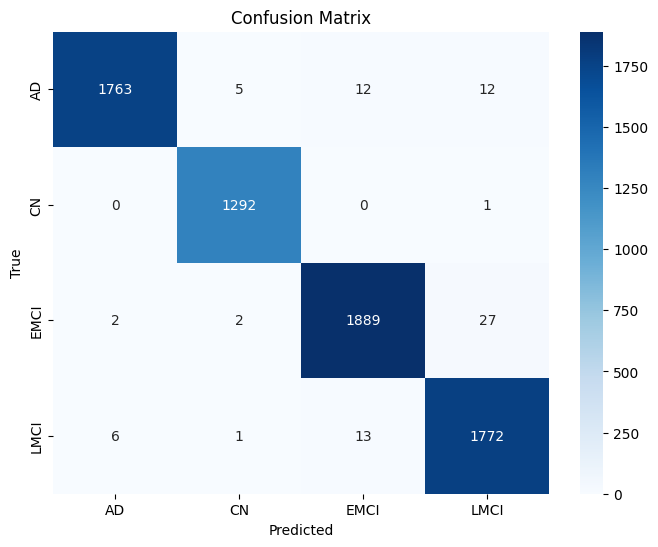

In [8]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_classes, yticklabels=valid_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
import joblib

# Save the ensemble pipeline
save_path = "ensemble_pipeline_1.pkl"

ensemble_data = {
    "pytorch_model": pytorch_model.state_dict(),
    "keras_model": keras_model.to_json(),
    "label_map": label_map,
    "valid_classes": valid_classes
}

joblib.dump(ensemble_data, save_path)
print(f"Ensemble pipeline saved to {save_path}")

Ensemble pipeline saved to ensemble_pipeline_1.pkl
